#1. Import 

In [ ]:
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn

import random
import matplotlib.pyplot as plt
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

#2. Configure Data

In [ ]:
def per_image_standardization(image):
    """
    This function creates a custom per image standardization
    transform which is used for data augmentation.
    params:
        - image (torch Tensor): Image Tensor that needs to be standardized.
    
    returns:
        - image (torch Tensor): Image Tensor post standardization.
    """
    # get original data type
    orig_dtype = image.dtype

    # compute image mean
    image_mean = torch.mean(image, dim=(-1, -2, -3))

    # compute image standard deviation
    stddev = torch.std(image, axis=(-1, -2, -3))

    # compute number of pixels
    num_pixels = torch.tensor(torch.numel(image), dtype=torch.float32)

    # compute minimum standard deviation
    min_stddev = torch.rsqrt(num_pixels)

    # compute adjusted standard deviation
    adjusted_stddev = torch.max(stddev, min_stddev)

    # normalize image
    image -= image_mean
    image = torch.div(image, adjusted_stddev)

    # make sure that image output dtype  == input dtype
    assert image.dtype == orig_dtype

    return image

def shuffle_pixels(image, indicies):
    image = image.reshape(3,-1)
    image = image[:,indicies]
    image = image.reshape(3,32,32)
    return image

class myNormalize(object):
    def __call__(self,img):
        return  per_image_standardization(img)

class myShuffle(object):
    def __init__(self, shape):
        self.indicies = torch.randperm(shape)
    def __call__(self,img):
        return  shuffle_pixels(img, self.indicies)

In [ ]:
BATCH_SIZE = 4

transform_train = transforms.Compose([
    #transforms.CenterCrop(28),
    transforms.ToTensor(),
    myNormalize()
    ])

#Models

## Inception v3

In [ ]:
#### smaller inception for cifar10 input size 28 x 28 
# class Con(nn.Module):
#   def __init__(self, in_channel, c, k, s):
#       super(Con, self).__init__()
#       self.branch1 = nn.Sequential(
#           Conv2d(in_channel, C, kernel_size = k,stride = s, padding=0),
#           nn.BatchNorm2d(C),
#           nn.ReLU()
#       )
    
#   def forward(self, x):
#       branch1 = self.branch1(x)
#       # branch2 = self.branch2(x)
#       # nn.BatchNorm2d(8)
#       # return torch.cat([branch1, branch2], 1) 
#       return branch1

class Inception(nn.Module):
  def __init__(self, in_channel, ch1, ch3):
      super(Inception, self).__init__()
      self.branch1 = nn.Sequential(
          nn.Conv2d(in_channel, ch1, kernel_size = 1,stride=1, padding=0),
          nn.BatchNorm2d(ch1),
          nn.ReLU(inplace=True)
      )
      
      self.branch2 = nn.Sequential(
          nn.Conv2d(in_channel, ch3, kernel_size = 3,stride=1, padding=1),
          nn.BatchNorm2d(ch3),
          nn.ReLU(inplace=True)
      )
      
  def forward(self, x):
      branch1 = self.branch1(x)
      branch2 = self.branch2(x)
      return torch.cat([branch1, branch2], 1) 

class Downsampling(nn.Module):
  def __init__(self, in_channel, ch3):
      super(Downsampling, self).__init__()
      self.branch1 = nn.Sequential(
          nn.Conv2d(in_channel, ch3, kernel_size = 3,stride=2, padding=0), ##is the padding wrong?
          nn.BatchNorm2d(ch3),
          nn.ReLU(inplace=True)
      )
      
      self.branch2 = nn.MaxPool2d(3, stride=2)

      
  def forward(self, x):
      branch1 = self.branch1(x)
      branch2 = self.branch2(x)
      return torch.cat([branch1, branch2], 1) 

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__() ## change input channels 
        self.conv1 = nn.Sequential(nn.Conv2d(3, 96, kernel_size=3, stride = 1),
                                   nn.BatchNorm2d(96),
                                   nn.ReLU(inplace=True))

        self.incept1 = Inception(96, 32, 32) #in_channel, ch1, ch3
        self.incept2 = Inception(64, 32, 48)
        self.ds1 = Downsampling(80,80)

        self.incept3 = Inception(160, 112,48)
        self.incept4 = Inception(160, 96, 64)
        self.incept5 = Inception(160, 80, 80)
        self.incept6 = Inception(160, 48, 96)
        self.ds2 = Downsampling(144,96)

        self.incept7 = Inception(240, 176, 160)
        self.incept8 = Inception(336, 176, 160)
        self.mp = nn.AvgPool2d(7, stride=1,padding=3)

        self.fc = nn.Linear(8400, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # in_size = x.size(0)
        x = self.conv1(x)

        x = self.ds1(self.incept2(self.incept1(x)))

        x = self.incept6(self.incept5(self.incept4(self.incept3(x))))
        x = self.ds2(x)

        x = self.mp(self.incept8(self.incept7(x)))

        # x = x.view(in_size, -1)  # flatten the tensor
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
# model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)

# Training

In [ ]:
from __future__ import print_function
import random
import csv

import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.optim
import time

def convergence(model, directory, train_loader, val_loader,start_epoch=None, epochs=200, p_range=[0,0.2,0.4,0.6,0.8,1]):
  
  times = []
  for p in p_range:
    print("P: " + str(p))
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=transform_train)
    l = trainset.targets
    l_p = l[:int(len(l)*p)]
    random.shuffle(l_p)
    l[:int(len(l)*p)] = l_p
    trainset.targets = l
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

    valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
    
    time_con = train_model(model, directory, train_loader, val_loader,start_epoch=None, epochs=200)
    times.append(time_con)

  plt.plot(p_range,times)
  plt.title("Time To Convergence")
  plt.xlabel("Proportion of Corrupted Labels")
  plt.ylabel("Time (s)")
  with open('convergence.csv','w') as con_file:
    write = csv.writer(con_file)
    write.writerows(times)
  files.download('convergence.csv')


def train_model(model, directory, train_loader, val_loader, start_epoch=None, epochs=200):
  cudnn.benchmark = True

  # define loss function (criterion) and pptimizer
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.SGD(model.parameters(), 0.01,
                              momentum=0.9,
                              weight_decay=1e-4)

  start_epoch = start_epoch or 0
  epochs = epochs

  train_acc = 0

  epoch_list, train_losses, val_losses, train_accs, val_accs = [], [], [], [], []
  start_time=time.time()
  for epoch in range(start_epoch, epochs):
    adjust_learning_rate(optimizer, epoch, 0.1)

    # train for one epoch
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # evaluate on validation set
    val_loss, val_acc = validate_epoch(val_loader, model, criterion, epoch)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    epoch_list.append(epoch)
    logging.info('%03d: Acc-tr: %6.2f, Acc-val: %6.2f, L-tr: %6.4f, L-val: %6.4f',
                    epoch, train_acc, val_acc, train_loss, val_loss)
           
    torch.save(model.state_dict(), directory)
    #/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    end_time = time.time()
    if train_acc == 100.00:
      break

    '''
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Loss Curve")
    plt.plot(epoch_list, train_losses, label="Train")
    plt.plot(epoch_list, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Accuracy Curve")
    plt.plot(epoch_list, train_accs, label="Train")
    plt.plot(epoch_list, val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    #plt.legend(loc='best')
    plt.show()
    '''
  time_con = start_time - end_time
  print("Final Training Accuracy: {}".format(train_accs[-1]))
  print("Final Validation Accuracy: {}".format(val_accs[-1]))
  return time_con

def get_model(model):
  # create model
  if model == 'wide-resnet':

    model = WideResNet(28, 10, 1,drop_rate=0.0)

  elif model == 'mlp':

    n_units = [int(x) for x in '512'.split('x')] # hidden dims
    n_units.append(10)  # output dim
    n_units.insert(0, 32*32*3)        # input dim
    model = MLP(n_units)

  elif model == 'inception':

    model = Net()

  elif model == 'alexnet':

    model = AlexNet(10)

  # for training on multiple GPUs.
  # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
  # model = torch.nn.DataParallel(model).cuda()
  model = model.cuda()

  return model

def train_epoch(train_loader, model, criterion, optimizer, epoch):
  """Train for one epoch on the training set"""
  batch_time = AverageMeter()
  losses = AverageMeter()
  top1 = AverageMeter()

  # switch to train mode
  model.train()

  for i, (input, target) in enumerate(train_loader):
    target = target.cuda(non_blocking=True)
    input = input.cuda()
    input_var = torch.autograd.Variable(input)
    target_var = torch.autograd.Variable(target)

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # measure accuracy and record loss
    prec1 = accuracy(output.data, target, topk=(1,))[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return losses.avg, top1.avg


def validate_epoch(val_loader, model, criterion, epoch):
  """Perform validation on the validation set"""
  batch_time = AverageMeter()
  losses = AverageMeter()
  top1 = AverageMeter()

  # switch to evaluate mode
  model.eval()

  for i, (input, target) in enumerate(val_loader):
    target = target.cuda(non_blocking=True)
    input = input.cuda()
    input_var = torch.autograd.Variable(input, volatile=True)
    target_var = torch.autograd.Variable(target, volatile=True)

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # measure accuracy and record loss
    prec1 = accuracy(output.data, target, topk=(1,))[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

  return losses.avg, top1.avg


class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch, lr_0):
  """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
  lr = lr_0 * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
  """Computes the precision@k for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
  return res

def setup_logging(name):
  import datetime
  exp_dir = os.path.join('/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs', name)
  if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)
  log_fn = os.path.join(exp_dir, "LOG.{0}.txt".format(datetime.date.today().strftime("%y%m%d")))
  logging.basicConfig(filename=log_fn, filemode='w', level=logging.DEBUG)
  # also log into console
  console = logging.StreamHandler()
  console.setLevel(logging.INFO)
  logging.getLogger('').addHandler(console)
  print('Logging into %s...' % exp_dir)

def main(name, model, train, directory, epochs):
  setup_logging(name)
  if train == 'train':
    train_loader = trainloader
    val_loader = valloader
    model = get_model(model)
    logging.info('Number of parameters: %d', sum([p.data.nelement() for p in model.parameters()]))
    #train_model(model, directory,  train_loader, val_loader, 0, epochs)
    convergence(model, directory,  train_loader, val_loader, 0, epochs, [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Results

In [ ]:
BATCH_SIZE = 512

##Color Jitter

In [ ]:
transform_ColorJitter = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.ColorJitter(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified


Number of parameters: 1733466
Number of parameters: 1733466
Number of parameters: 1733466


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  44.94, Acc-val:  56.68, L-tr: 1.5332, L-val: 1.1979
000: Acc-tr:  44.94, Acc-val:  56.68, L-tr: 1.5332, L-val: 1.1979
000: Acc-tr:  44.94, Acc-val:  56.68, L-tr: 1.5332, L-val: 1.1979


Epoch 0 Finished.  Time per Epoch:  51.74 s 


001: Acc-tr:  65.88, Acc-val:  61.95, L-tr: 0.9583, L-val: 1.1312
001: Acc-tr:  65.88, Acc-val:  61.95, L-tr: 0.9583, L-val: 1.1312
001: Acc-tr:  65.88, Acc-val:  61.95, L-tr: 0.9583, L-val: 1.1312


Epoch 1 Finished.  Time per Epoch:  48.00 s 


002: Acc-tr:  73.94, Acc-val:  72.94, L-tr: 0.7393, L-val: 0.7933
002: Acc-tr:  73.94, Acc-val:  72.94, L-tr: 0.7393, L-val: 0.7933
002: Acc-tr:  73.94, Acc-val:  72.94, L-tr: 0.7393, L-val: 0.7933


Epoch 2 Finished.  Time per Epoch:  46.93 s 


003: Acc-tr:  79.57, Acc-val:  75.74, L-tr: 0.5877, L-val: 0.7061
003: Acc-tr:  79.57, Acc-val:  75.74, L-tr: 0.5877, L-val: 0.7061
003: Acc-tr:  79.57, Acc-val:  75.74, L-tr: 0.5877, L-val: 0.7061


Epoch 3 Finished.  Time per Epoch:  46.38 s 


004: Acc-tr:  82.31, Acc-val:  75.07, L-tr: 0.5029, L-val: 0.7492
004: Acc-tr:  82.31, Acc-val:  75.07, L-tr: 0.5029, L-val: 0.7492
004: Acc-tr:  82.31, Acc-val:  75.07, L-tr: 0.5029, L-val: 0.7492


Epoch 4 Finished.  Time per Epoch:  46.09 s 


005: Acc-tr:  85.37, Acc-val:  75.02, L-tr: 0.4209, L-val: 0.7784
005: Acc-tr:  85.37, Acc-val:  75.02, L-tr: 0.4209, L-val: 0.7784
005: Acc-tr:  85.37, Acc-val:  75.02, L-tr: 0.4209, L-val: 0.7784


Epoch 5 Finished.  Time per Epoch:  45.90 s 


006: Acc-tr:  87.56, Acc-val:  75.75, L-tr: 0.3532, L-val: 0.7721
006: Acc-tr:  87.56, Acc-val:  75.75, L-tr: 0.3532, L-val: 0.7721
006: Acc-tr:  87.56, Acc-val:  75.75, L-tr: 0.3532, L-val: 0.7721


Epoch 6 Finished.  Time per Epoch:  45.78 s 


007: Acc-tr:  90.02, Acc-val:  76.22, L-tr: 0.2839, L-val: 0.8303
007: Acc-tr:  90.02, Acc-val:  76.22, L-tr: 0.2839, L-val: 0.8303
007: Acc-tr:  90.02, Acc-val:  76.22, L-tr: 0.2839, L-val: 0.8303


Epoch 7 Finished.  Time per Epoch:  45.68 s 


008: Acc-tr:  91.62, Acc-val:  78.66, L-tr: 0.2371, L-val: 0.6974
008: Acc-tr:  91.62, Acc-val:  78.66, L-tr: 0.2371, L-val: 0.6974
008: Acc-tr:  91.62, Acc-val:  78.66, L-tr: 0.2371, L-val: 0.6974


Epoch 8 Finished.  Time per Epoch:  45.60 s 


009: Acc-tr:  93.11, Acc-val:  79.80, L-tr: 0.1941, L-val: 0.7060
009: Acc-tr:  93.11, Acc-val:  79.80, L-tr: 0.1941, L-val: 0.7060
009: Acc-tr:  93.11, Acc-val:  79.80, L-tr: 0.1941, L-val: 0.7060


Epoch 9 Finished.  Time per Epoch:  45.54 s 


010: Acc-tr:  94.27, Acc-val:  80.05, L-tr: 0.1604, L-val: 0.7325
010: Acc-tr:  94.27, Acc-val:  80.05, L-tr: 0.1604, L-val: 0.7325
010: Acc-tr:  94.27, Acc-val:  80.05, L-tr: 0.1604, L-val: 0.7325


Epoch 10 Finished.  Time per Epoch:  45.49 s 


011: Acc-tr:  95.31, Acc-val:  77.93, L-tr: 0.1314, L-val: 0.8464
011: Acc-tr:  95.31, Acc-val:  77.93, L-tr: 0.1314, L-val: 0.8464
011: Acc-tr:  95.31, Acc-val:  77.93, L-tr: 0.1314, L-val: 0.8464


Epoch 11 Finished.  Time per Epoch:  45.45 s 


012: Acc-tr:  96.45, Acc-val:  77.95, L-tr: 0.1006, L-val: 0.9604
012: Acc-tr:  96.45, Acc-val:  77.95, L-tr: 0.1006, L-val: 0.9604
012: Acc-tr:  96.45, Acc-val:  77.95, L-tr: 0.1006, L-val: 0.9604


Epoch 12 Finished.  Time per Epoch:  45.42 s 


013: Acc-tr:  96.91, Acc-val:  80.75, L-tr: 0.0876, L-val: 0.8637
013: Acc-tr:  96.91, Acc-val:  80.75, L-tr: 0.0876, L-val: 0.8637
013: Acc-tr:  96.91, Acc-val:  80.75, L-tr: 0.0876, L-val: 0.8637


Epoch 13 Finished.  Time per Epoch:  45.39 s 


014: Acc-tr:  97.85, Acc-val:  78.48, L-tr: 0.0640, L-val: 1.0579
014: Acc-tr:  97.85, Acc-val:  78.48, L-tr: 0.0640, L-val: 1.0579
014: Acc-tr:  97.85, Acc-val:  78.48, L-tr: 0.0640, L-val: 1.0579


Epoch 14 Finished.  Time per Epoch:  45.37 s 


015: Acc-tr:  97.94, Acc-val:  78.64, L-tr: 0.0601, L-val: 1.0452
015: Acc-tr:  97.94, Acc-val:  78.64, L-tr: 0.0601, L-val: 1.0452
015: Acc-tr:  97.94, Acc-val:  78.64, L-tr: 0.0601, L-val: 1.0452


Epoch 15 Finished.  Time per Epoch:  45.35 s 


016: Acc-tr:  98.23, Acc-val:  80.69, L-tr: 0.0519, L-val: 0.8936
016: Acc-tr:  98.23, Acc-val:  80.69, L-tr: 0.0519, L-val: 0.8936
016: Acc-tr:  98.23, Acc-val:  80.69, L-tr: 0.0519, L-val: 0.8936


Epoch 16 Finished.  Time per Epoch:  45.34 s 


017: Acc-tr:  98.97, Acc-val:  79.11, L-tr: 0.0322, L-val: 1.1019
017: Acc-tr:  98.97, Acc-val:  79.11, L-tr: 0.0322, L-val: 1.1019
017: Acc-tr:  98.97, Acc-val:  79.11, L-tr: 0.0322, L-val: 1.1019


Epoch 17 Finished.  Time per Epoch:  45.32 s 


018: Acc-tr:  99.53, Acc-val:  82.34, L-tr: 0.0175, L-val: 0.8763
018: Acc-tr:  99.53, Acc-val:  82.34, L-tr: 0.0175, L-val: 0.8763
018: Acc-tr:  99.53, Acc-val:  82.34, L-tr: 0.0175, L-val: 0.8763


Epoch 18 Finished.  Time per Epoch:  45.31 s 


019: Acc-tr:  99.40, Acc-val:  80.22, L-tr: 0.0197, L-val: 1.0624
019: Acc-tr:  99.40, Acc-val:  80.22, L-tr: 0.0197, L-val: 1.0624
019: Acc-tr:  99.40, Acc-val:  80.22, L-tr: 0.0197, L-val: 1.0624


Epoch 19 Finished.  Time per Epoch:  45.30 s 


020: Acc-tr:  99.19, Acc-val:  79.73, L-tr: 0.0249, L-val: 1.0937
020: Acc-tr:  99.19, Acc-val:  79.73, L-tr: 0.0249, L-val: 1.0937
020: Acc-tr:  99.19, Acc-val:  79.73, L-tr: 0.0249, L-val: 1.0937


Epoch 20 Finished.  Time per Epoch:  45.29 s 


021: Acc-tr:  99.11, Acc-val:  78.60, L-tr: 0.0275, L-val: 1.1593
021: Acc-tr:  99.11, Acc-val:  78.60, L-tr: 0.0275, L-val: 1.1593
021: Acc-tr:  99.11, Acc-val:  78.60, L-tr: 0.0275, L-val: 1.1593


Epoch 21 Finished.  Time per Epoch:  45.28 s 


022: Acc-tr:  98.80, Acc-val:  80.82, L-tr: 0.0358, L-val: 0.8896
022: Acc-tr:  98.80, Acc-val:  80.82, L-tr: 0.0358, L-val: 0.8896
022: Acc-tr:  98.80, Acc-val:  80.82, L-tr: 0.0358, L-val: 0.8896


Epoch 22 Finished.  Time per Epoch:  45.27 s 


023: Acc-tr:  98.53, Acc-val:  82.53, L-tr: 0.0429, L-val: 0.8245
023: Acc-tr:  98.53, Acc-val:  82.53, L-tr: 0.0429, L-val: 0.8245
023: Acc-tr:  98.53, Acc-val:  82.53, L-tr: 0.0429, L-val: 0.8245


Epoch 23 Finished.  Time per Epoch:  45.27 s 


024: Acc-tr:  98.92, Acc-val:  80.42, L-tr: 0.0327, L-val: 1.0342
024: Acc-tr:  98.92, Acc-val:  80.42, L-tr: 0.0327, L-val: 1.0342
024: Acc-tr:  98.92, Acc-val:  80.42, L-tr: 0.0327, L-val: 1.0342


Epoch 24 Finished.  Time per Epoch:  45.25 s 


025: Acc-tr:  99.30, Acc-val:  83.46, L-tr: 0.0220, L-val: 0.7802
025: Acc-tr:  99.30, Acc-val:  83.46, L-tr: 0.0220, L-val: 0.7802
025: Acc-tr:  99.30, Acc-val:  83.46, L-tr: 0.0220, L-val: 0.7802


Epoch 25 Finished.  Time per Epoch:  45.23 s 


026: Acc-tr:  99.63, Acc-val:  84.72, L-tr: 0.0129, L-val: 0.7421
026: Acc-tr:  99.63, Acc-val:  84.72, L-tr: 0.0129, L-val: 0.7421
026: Acc-tr:  99.63, Acc-val:  84.72, L-tr: 0.0129, L-val: 0.7421


Epoch 26 Finished.  Time per Epoch:  45.22 s 


027: Acc-tr:  99.81, Acc-val:  85.20, L-tr: 0.0077, L-val: 0.7413
027: Acc-tr:  99.81, Acc-val:  85.20, L-tr: 0.0077, L-val: 0.7413
027: Acc-tr:  99.81, Acc-val:  85.20, L-tr: 0.0077, L-val: 0.7413


Epoch 27 Finished.  Time per Epoch:  45.21 s 


028: Acc-tr:  99.90, Acc-val:  84.92, L-tr: 0.0048, L-val: 0.7654
028: Acc-tr:  99.90, Acc-val:  84.92, L-tr: 0.0048, L-val: 0.7654
028: Acc-tr:  99.90, Acc-val:  84.92, L-tr: 0.0048, L-val: 0.7654


Epoch 28 Finished.  Time per Epoch:  45.20 s 


029: Acc-tr:  99.99, Acc-val:  86.03, L-tr: 0.0011, L-val: 0.6747
029: Acc-tr:  99.99, Acc-val:  86.03, L-tr: 0.0011, L-val: 0.6747
029: Acc-tr:  99.99, Acc-val:  86.03, L-tr: 0.0011, L-val: 0.6747


Epoch 29 Finished.  Time per Epoch:  45.19 s 


030: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0004, L-val: 0.6634
030: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0004, L-val: 0.6634
030: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0004, L-val: 0.6634


Epoch 30 Finished.  Time per Epoch:  45.19 s 


031: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6601
031: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6601
031: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6601


Epoch 31 Finished.  Time per Epoch:  45.19 s 


032: Acc-tr: 100.00, Acc-val:  86.20, L-tr: 0.0003, L-val: 0.6543
032: Acc-tr: 100.00, Acc-val:  86.20, L-tr: 0.0003, L-val: 0.6543
032: Acc-tr: 100.00, Acc-val:  86.20, L-tr: 0.0003, L-val: 0.6543


Epoch 32 Finished.  Time per Epoch:  45.19 s 


033: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0002, L-val: 0.6487
033: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0002, L-val: 0.6487
033: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0002, L-val: 0.6487


Epoch 33 Finished.  Time per Epoch:  45.18 s 


034: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6455
034: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6455
034: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6455


Epoch 34 Finished.  Time per Epoch:  45.17 s 


035: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0002, L-val: 0.6424
035: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0002, L-val: 0.6424
035: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0002, L-val: 0.6424


Epoch 35 Finished.  Time per Epoch:  45.16 s 


036: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6369
036: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6369
036: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6369


Epoch 36 Finished.  Time per Epoch:  45.15 s 


037: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0002, L-val: 0.6338
037: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0002, L-val: 0.6338
037: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0002, L-val: 0.6338


Epoch 37 Finished.  Time per Epoch:  45.13 s 


038: Acc-tr: 100.00, Acc-val:  86.34, L-tr: 0.0003, L-val: 0.6283
038: Acc-tr: 100.00, Acc-val:  86.34, L-tr: 0.0003, L-val: 0.6283
038: Acc-tr: 100.00, Acc-val:  86.34, L-tr: 0.0003, L-val: 0.6283


Epoch 38 Finished.  Time per Epoch:  45.13 s 


039: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.6239
039: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.6239
039: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.6239


Epoch 39 Finished.  Time per Epoch:  45.12 s 


040: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6211
040: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6211
040: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6211


Epoch 40 Finished.  Time per Epoch:  45.11 s 


041: Acc-tr: 100.00, Acc-val:  86.29, L-tr: 0.0003, L-val: 0.6184
041: Acc-tr: 100.00, Acc-val:  86.29, L-tr: 0.0003, L-val: 0.6184
041: Acc-tr: 100.00, Acc-val:  86.29, L-tr: 0.0003, L-val: 0.6184


Epoch 41 Finished.  Time per Epoch:  45.10 s 


042: Acc-tr: 100.00, Acc-val:  86.37, L-tr: 0.0003, L-val: 0.6145
042: Acc-tr: 100.00, Acc-val:  86.37, L-tr: 0.0003, L-val: 0.6145
042: Acc-tr: 100.00, Acc-val:  86.37, L-tr: 0.0003, L-val: 0.6145


Epoch 42 Finished.  Time per Epoch:  45.10 s 


043: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6088
043: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6088
043: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6088


Epoch 43 Finished.  Time per Epoch:  45.09 s 


044: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6076
044: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6076
044: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6076


Epoch 44 Finished.  Time per Epoch:  45.08 s 


045: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6039
045: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6039
045: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6039


Epoch 45 Finished.  Time per Epoch:  45.08 s 


046: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6015
046: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6015
046: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6015


Epoch 46 Finished.  Time per Epoch:  45.07 s 


047: Acc-tr: 100.00, Acc-val:  86.46, L-tr: 0.0003, L-val: 0.5990
047: Acc-tr: 100.00, Acc-val:  86.46, L-tr: 0.0003, L-val: 0.5990
047: Acc-tr: 100.00, Acc-val:  86.46, L-tr: 0.0003, L-val: 0.5990


Epoch 47 Finished.  Time per Epoch:  45.07 s 


048: Acc-tr: 100.00, Acc-val:  86.39, L-tr: 0.0003, L-val: 0.5953
048: Acc-tr: 100.00, Acc-val:  86.39, L-tr: 0.0003, L-val: 0.5953
048: Acc-tr: 100.00, Acc-val:  86.39, L-tr: 0.0003, L-val: 0.5953


Epoch 48 Finished.  Time per Epoch:  45.06 s 


049: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5954
049: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5954
049: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5954


Epoch 49 Finished.  Time per Epoch:  45.06 s 


050: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0003, L-val: 0.5932
050: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0003, L-val: 0.5932
050: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0003, L-val: 0.5932


Epoch 50 Finished.  Time per Epoch:  45.05 s 


051: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5887
051: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5887
051: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5887


Epoch 51 Finished.  Time per Epoch:  45.05 s 


052: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5878
052: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5878
052: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5878


Epoch 52 Finished.  Time per Epoch:  45.04 s 


053: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5864
053: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5864
053: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5864


Epoch 53 Finished.  Time per Epoch:  45.04 s 


054: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5842
054: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5842
054: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5842


Epoch 54 Finished.  Time per Epoch:  45.03 s 


055: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5834
055: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5834
055: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5834


Epoch 55 Finished.  Time per Epoch:  45.03 s 


056: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5830
056: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5830
056: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5830


Epoch 56 Finished.  Time per Epoch:  45.03 s 


057: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5819
057: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5819
057: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5819


Epoch 57 Finished.  Time per Epoch:  45.02 s 


058: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5786
058: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5786
058: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5786


Epoch 58 Finished.  Time per Epoch:  45.02 s 


059: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5786
059: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5786
059: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5786


Epoch 59 Finished.  Time per Epoch:  45.01 s 


060: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5800
060: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5800
060: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5800


Epoch 60 Finished.  Time per Epoch:  45.01 s 


061: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5770
061: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5770
061: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5770


Epoch 61 Finished.  Time per Epoch:  45.01 s 


062: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5762
062: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5762
062: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5762


Epoch 62 Finished.  Time per Epoch:  45.00 s 


063: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5749
063: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5749
063: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5749


Epoch 63 Finished.  Time per Epoch:  45.00 s 


064: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5742
064: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5742
064: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5742


Epoch 64 Finished.  Time per Epoch:  45.00 s 


065: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5753
065: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5753
065: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5753


Epoch 65 Finished.  Time per Epoch:  44.99 s 


066: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5748
066: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5748
066: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5748


Epoch 66 Finished.  Time per Epoch:  44.99 s 


067: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5737
067: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5737
067: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5737


Epoch 67 Finished.  Time per Epoch:  44.99 s 


068: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5730
068: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5730
068: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5730


Epoch 68 Finished.  Time per Epoch:  44.98 s 


069: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5735
069: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5735
069: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5735


Epoch 69 Finished.  Time per Epoch:  44.98 s 


070: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5724
070: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5724
070: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5724


Epoch 70 Finished.  Time per Epoch:  44.98 s 


071: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5740
071: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5740
071: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5740


Epoch 71 Finished.  Time per Epoch:  44.98 s 


072: Acc-tr: 100.00, Acc-val:  86.19, L-tr: 0.0003, L-val: 0.5708
072: Acc-tr: 100.00, Acc-val:  86.19, L-tr: 0.0003, L-val: 0.5708
072: Acc-tr: 100.00, Acc-val:  86.19, L-tr: 0.0003, L-val: 0.5708


Epoch 72 Finished.  Time per Epoch:  44.97 s 


073: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5698
073: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5698
073: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5698


Epoch 73 Finished.  Time per Epoch:  44.97 s 


074: Acc-tr: 100.00, Acc-val:  86.17, L-tr: 0.0003, L-val: 0.5719
074: Acc-tr: 100.00, Acc-val:  86.17, L-tr: 0.0003, L-val: 0.5719
074: Acc-tr: 100.00, Acc-val:  86.17, L-tr: 0.0003, L-val: 0.5719


Epoch 74 Finished.  Time per Epoch:  44.97 s 


075: Acc-tr: 100.00, Acc-val:  86.10, L-tr: 0.0003, L-val: 0.5720
075: Acc-tr: 100.00, Acc-val:  86.10, L-tr: 0.0003, L-val: 0.5720
075: Acc-tr: 100.00, Acc-val:  86.10, L-tr: 0.0003, L-val: 0.5720


Epoch 75 Finished.  Time per Epoch:  44.97 s 


076: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5701
076: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5701
076: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5701


Epoch 76 Finished.  Time per Epoch:  44.96 s 


077: Acc-tr: 100.00, Acc-val:  86.18, L-tr: 0.0003, L-val: 0.5725
077: Acc-tr: 100.00, Acc-val:  86.18, L-tr: 0.0003, L-val: 0.5725
077: Acc-tr: 100.00, Acc-val:  86.18, L-tr: 0.0003, L-val: 0.5725


Epoch 77 Finished.  Time per Epoch:  44.96 s 


078: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5708
078: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5708
078: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5708


Epoch 78 Finished.  Time per Epoch:  44.96 s 


079: Acc-tr: 100.00, Acc-val:  86.16, L-tr: 0.0003, L-val: 0.5719
079: Acc-tr: 100.00, Acc-val:  86.16, L-tr: 0.0003, L-val: 0.5719
079: Acc-tr: 100.00, Acc-val:  86.16, L-tr: 0.0003, L-val: 0.5719


Epoch 79 Finished.  Time per Epoch:  44.96 s 


080: Acc-tr: 100.00, Acc-val:  86.12, L-tr: 0.0003, L-val: 0.5707
080: Acc-tr: 100.00, Acc-val:  86.12, L-tr: 0.0003, L-val: 0.5707
080: Acc-tr: 100.00, Acc-val:  86.12, L-tr: 0.0003, L-val: 0.5707


Epoch 80 Finished.  Time per Epoch:  44.95 s 


081: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5727
081: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5727
081: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5727


Epoch 81 Finished.  Time per Epoch:  44.95 s 


082: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5706
082: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5706
082: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5706


Epoch 82 Finished.  Time per Epoch:  44.95 s 


083: Acc-tr: 100.00, Acc-val:  86.07, L-tr: 0.0003, L-val: 0.5712
083: Acc-tr: 100.00, Acc-val:  86.07, L-tr: 0.0003, L-val: 0.5712
083: Acc-tr: 100.00, Acc-val:  86.07, L-tr: 0.0003, L-val: 0.5712


Epoch 83 Finished.  Time per Epoch:  44.95 s 


084: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5707
084: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5707
084: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5707


Epoch 84 Finished.  Time per Epoch:  44.94 s 


085: Acc-tr: 100.00, Acc-val:  86.15, L-tr: 0.0003, L-val: 0.5700
085: Acc-tr: 100.00, Acc-val:  86.15, L-tr: 0.0003, L-val: 0.5700
085: Acc-tr: 100.00, Acc-val:  86.15, L-tr: 0.0003, L-val: 0.5700


Epoch 85 Finished.  Time per Epoch:  44.94 s 


086: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5711
086: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5711
086: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5711


Epoch 86 Finished.  Time per Epoch:  44.94 s 


087: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5707
087: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5707
087: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5707


Epoch 87 Finished.  Time per Epoch:  44.94 s 


088: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5704
088: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5704
088: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5704


Epoch 88 Finished.  Time per Epoch:  44.93 s 


089: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5717
089: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5717
089: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5717


Epoch 89 Finished.  Time per Epoch:  44.93 s 


090: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5719
090: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5719
090: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5719


Epoch 90 Finished.  Time per Epoch:  44.93 s 


091: Acc-tr: 100.00, Acc-val:  85.90, L-tr: 0.0003, L-val: 0.5713
091: Acc-tr: 100.00, Acc-val:  85.90, L-tr: 0.0003, L-val: 0.5713
091: Acc-tr: 100.00, Acc-val:  85.90, L-tr: 0.0003, L-val: 0.5713


Epoch 91 Finished.  Time per Epoch:  44.93 s 


092: Acc-tr: 100.00, Acc-val:  85.99, L-tr: 0.0003, L-val: 0.5726
092: Acc-tr: 100.00, Acc-val:  85.99, L-tr: 0.0003, L-val: 0.5726
092: Acc-tr: 100.00, Acc-val:  85.99, L-tr: 0.0003, L-val: 0.5726


Epoch 92 Finished.  Time per Epoch:  44.93 s 


093: Acc-tr: 100.00, Acc-val:  86.04, L-tr: 0.0003, L-val: 0.5738
093: Acc-tr: 100.00, Acc-val:  86.04, L-tr: 0.0003, L-val: 0.5738
093: Acc-tr: 100.00, Acc-val:  86.04, L-tr: 0.0003, L-val: 0.5738


Epoch 93 Finished.  Time per Epoch:  44.92 s 


094: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5745
094: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5745
094: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5745


Epoch 94 Finished.  Time per Epoch:  44.92 s 


095: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5722
095: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5722
095: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5722


Epoch 95 Finished.  Time per Epoch:  44.92 s 


096: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5713
096: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5713
096: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5713


Epoch 96 Finished.  Time per Epoch:  44.92 s 


097: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5728
097: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5728
097: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5728


Epoch 97 Finished.  Time per Epoch:  44.91 s 


098: Acc-tr: 100.00, Acc-val:  85.95, L-tr: 0.0003, L-val: 0.5730
098: Acc-tr: 100.00, Acc-val:  85.95, L-tr: 0.0003, L-val: 0.5730
098: Acc-tr: 100.00, Acc-val:  85.95, L-tr: 0.0003, L-val: 0.5730


Epoch 98 Finished.  Time per Epoch:  44.91 s 


099: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5736
099: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5736
099: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5736


Epoch 99 Finished.  Time per Epoch:  44.91 s 


100: Acc-tr: 100.00, Acc-val:  86.02, L-tr: 0.0003, L-val: 0.5746
100: Acc-tr: 100.00, Acc-val:  86.02, L-tr: 0.0003, L-val: 0.5746
100: Acc-tr: 100.00, Acc-val:  86.02, L-tr: 0.0003, L-val: 0.5746


Epoch 100 Finished.  Time per Epoch:  44.91 s 


101: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5727
101: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5727
101: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5727


Epoch 101 Finished.  Time per Epoch:  44.90 s 


102: Acc-tr: 100.00, Acc-val:  86.09, L-tr: 0.0003, L-val: 0.5748
102: Acc-tr: 100.00, Acc-val:  86.09, L-tr: 0.0003, L-val: 0.5748
102: Acc-tr: 100.00, Acc-val:  86.09, L-tr: 0.0003, L-val: 0.5748


Epoch 102 Finished.  Time per Epoch:  44.91 s 


103: Acc-tr: 100.00, Acc-val:  85.97, L-tr: 0.0003, L-val: 0.5760
103: Acc-tr: 100.00, Acc-val:  85.97, L-tr: 0.0003, L-val: 0.5760
103: Acc-tr: 100.00, Acc-val:  85.97, L-tr: 0.0003, L-val: 0.5760


Epoch 103 Finished.  Time per Epoch:  44.91 s 


104: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5723
104: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5723
104: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5723


Epoch 104 Finished.  Time per Epoch:  44.90 s 


105: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5759
105: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5759
105: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5759


Epoch 105 Finished.  Time per Epoch:  44.90 s 


106: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5734
106: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5734
106: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5734


Epoch 106 Finished.  Time per Epoch:  44.90 s 


107: Acc-tr: 100.00, Acc-val:  85.81, L-tr: 0.0003, L-val: 0.5755
107: Acc-tr: 100.00, Acc-val:  85.81, L-tr: 0.0003, L-val: 0.5755
107: Acc-tr: 100.00, Acc-val:  85.81, L-tr: 0.0003, L-val: 0.5755


Epoch 107 Finished.  Time per Epoch:  44.90 s 


108: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0003, L-val: 0.5750
108: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0003, L-val: 0.5750
108: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0003, L-val: 0.5750


Epoch 108 Finished.  Time per Epoch:  44.90 s 


109: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5757
109: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5757
109: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5757


Epoch 109 Finished.  Time per Epoch:  44.90 s 


110: Acc-tr: 100.00, Acc-val:  85.88, L-tr: 0.0003, L-val: 0.5762
110: Acc-tr: 100.00, Acc-val:  85.88, L-tr: 0.0003, L-val: 0.5762
110: Acc-tr: 100.00, Acc-val:  85.88, L-tr: 0.0003, L-val: 0.5762


Epoch 110 Finished.  Time per Epoch:  44.90 s 


111: Acc-tr: 100.00, Acc-val:  85.80, L-tr: 0.0003, L-val: 0.5774
111: Acc-tr: 100.00, Acc-val:  85.80, L-tr: 0.0003, L-val: 0.5774
111: Acc-tr: 100.00, Acc-val:  85.80, L-tr: 0.0003, L-val: 0.5774


Epoch 111 Finished.  Time per Epoch:  44.89 s 


112: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5768
112: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5768
112: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5768


Epoch 112 Finished.  Time per Epoch:  44.89 s 


113: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0002, L-val: 0.5784
113: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0002, L-val: 0.5784
113: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0002, L-val: 0.5784


Epoch 113 Finished.  Time per Epoch:  44.89 s 


114: Acc-tr: 100.00, Acc-val:  85.79, L-tr: 0.0002, L-val: 0.5770
114: Acc-tr: 100.00, Acc-val:  85.79, L-tr: 0.0002, L-val: 0.5770
114: Acc-tr: 100.00, Acc-val:  85.79, L-tr: 0.0002, L-val: 0.5770


Epoch 114 Finished.  Time per Epoch:  44.89 s 


115: Acc-tr: 100.00, Acc-val:  85.68, L-tr: 0.0002, L-val: 0.5772
115: Acc-tr: 100.00, Acc-val:  85.68, L-tr: 0.0002, L-val: 0.5772
115: Acc-tr: 100.00, Acc-val:  85.68, L-tr: 0.0002, L-val: 0.5772


Epoch 115 Finished.  Time per Epoch:  44.89 s 


116: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5780
116: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5780
116: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5780


Epoch 116 Finished.  Time per Epoch:  44.89 s 


117: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5769
117: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5769
117: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5769


Epoch 117 Finished.  Time per Epoch:  44.89 s 


118: Acc-tr: 100.00, Acc-val:  85.74, L-tr: 0.0002, L-val: 0.5797
118: Acc-tr: 100.00, Acc-val:  85.74, L-tr: 0.0002, L-val: 0.5797
118: Acc-tr: 100.00, Acc-val:  85.74, L-tr: 0.0002, L-val: 0.5797


Epoch 118 Finished.  Time per Epoch:  44.89 s 


119: Acc-tr: 100.00, Acc-val:  85.66, L-tr: 0.0002, L-val: 0.5782
119: Acc-tr: 100.00, Acc-val:  85.66, L-tr: 0.0002, L-val: 0.5782
119: Acc-tr: 100.00, Acc-val:  85.66, L-tr: 0.0002, L-val: 0.5782


Epoch 119 Finished.  Time per Epoch:  44.89 s 


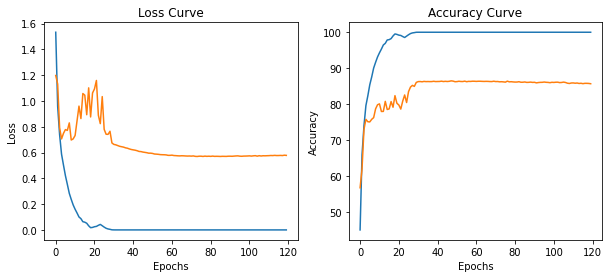

Final Training Accuracy: 100.0
Final Validation Accuracy: 85.66000004882812


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_ColorJitter)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ColorJitter)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_Color_Jitter"

main("Inception",'inception','train', directory, 120)

##Random Horizontal Flip

In [ ]:
transform_RandomHorizontalFlip = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception...


Number of parameters: 1733466
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  39.69, Acc-val:  50.23, L-tr: 1.7015, L-val: 1.3631


Epoch 0 Finished.  Time per Epoch:  17.18 s 


001: Acc-tr:  60.95, Acc-val:  63.74, L-tr: 1.0902, L-val: 1.0230


Epoch 1 Finished.  Time per Epoch:  16.08 s 


002: Acc-tr:  70.10, Acc-val:  67.84, L-tr: 0.8454, L-val: 0.9516


Epoch 2 Finished.  Time per Epoch:  15.80 s 


003: Acc-tr:  75.57, Acc-val:  69.82, L-tr: 0.6994, L-val: 0.9182


Epoch 3 Finished.  Time per Epoch:  15.58 s 


004: Acc-tr:  79.00, Acc-val:  69.98, L-tr: 0.6022, L-val: 0.8813


Epoch 4 Finished.  Time per Epoch:  15.57 s 


005: Acc-tr:  81.25, Acc-val:  73.39, L-tr: 0.5333, L-val: 0.8005


Epoch 5 Finished.  Time per Epoch:  15.49 s 


006: Acc-tr:  84.02, Acc-val:  79.67, L-tr: 0.4586, L-val: 0.6003


Epoch 6 Finished.  Time per Epoch:  15.46 s 


007: Acc-tr:  85.57, Acc-val:  79.35, L-tr: 0.4127, L-val: 0.6183


Epoch 7 Finished.  Time per Epoch:  15.37 s 


008: Acc-tr:  86.83, Acc-val:  76.71, L-tr: 0.3741, L-val: 0.7242


Epoch 8 Finished.  Time per Epoch:  15.40 s 


009: Acc-tr:  87.73, Acc-val:  80.17, L-tr: 0.3482, L-val: 0.6252


Epoch 9 Finished.  Time per Epoch:  15.36 s 


010: Acc-tr:  89.34, Acc-val:  80.94, L-tr: 0.3018, L-val: 0.6081


Epoch 10 Finished.  Time per Epoch:  15.36 s 


011: Acc-tr:  90.19, Acc-val:  80.50, L-tr: 0.2798, L-val: 0.6251


Epoch 11 Finished.  Time per Epoch:  15.34 s 


012: Acc-tr:  91.29, Acc-val:  81.53, L-tr: 0.2515, L-val: 0.5965


Epoch 12 Finished.  Time per Epoch:  15.33 s 


013: Acc-tr:  92.36, Acc-val:  81.35, L-tr: 0.2164, L-val: 0.5942


Epoch 13 Finished.  Time per Epoch:  15.33 s 


014: Acc-tr:  92.84, Acc-val:  78.95, L-tr: 0.2038, L-val: 0.7370


Epoch 14 Finished.  Time per Epoch:  15.32 s 


015: Acc-tr:  93.67, Acc-val:  81.79, L-tr: 0.1789, L-val: 0.6409


Epoch 15 Finished.  Time per Epoch:  15.31 s 


016: Acc-tr:  94.08, Acc-val:  82.35, L-tr: 0.1682, L-val: 0.6452


Epoch 16 Finished.  Time per Epoch:  15.32 s 


017: Acc-tr:  94.84, Acc-val:  81.49, L-tr: 0.1463, L-val: 0.6820


Epoch 17 Finished.  Time per Epoch:  15.33 s 


018: Acc-tr:  94.98, Acc-val:  82.88, L-tr: 0.1408, L-val: 0.5991


Epoch 18 Finished.  Time per Epoch:  15.32 s 


019: Acc-tr:  96.09, Acc-val:  84.44, L-tr: 0.1132, L-val: 0.5255


Epoch 19 Finished.  Time per Epoch:  15.31 s 


020: Acc-tr:  96.32, Acc-val:  82.86, L-tr: 0.1040, L-val: 0.6425


Epoch 20 Finished.  Time per Epoch:  15.30 s 


021: Acc-tr:  96.53, Acc-val:  82.56, L-tr: 0.0984, L-val: 0.7041


Epoch 21 Finished.  Time per Epoch:  15.30 s 


022: Acc-tr:  97.02, Acc-val:  83.34, L-tr: 0.0848, L-val: 0.6914


Epoch 22 Finished.  Time per Epoch:  15.29 s 


023: Acc-tr:  97.16, Acc-val:  84.13, L-tr: 0.0807, L-val: 0.6433


Epoch 23 Finished.  Time per Epoch:  15.28 s 


024: Acc-tr:  97.06, Acc-val:  82.66, L-tr: 0.0840, L-val: 0.7119


Epoch 24 Finished.  Time per Epoch:  15.29 s 


025: Acc-tr:  97.27, Acc-val:  85.80, L-tr: 0.0775, L-val: 0.5789


Epoch 25 Finished.  Time per Epoch:  15.28 s 


026: Acc-tr:  97.91, Acc-val:  85.13, L-tr: 0.0601, L-val: 0.6385


Epoch 26 Finished.  Time per Epoch:  15.28 s 


027: Acc-tr:  97.88, Acc-val:  82.77, L-tr: 0.0592, L-val: 0.7839


Epoch 27 Finished.  Time per Epoch:  15.26 s 


028: Acc-tr:  98.07, Acc-val:  84.22, L-tr: 0.0553, L-val: 0.6720


Epoch 28 Finished.  Time per Epoch:  15.27 s 


029: Acc-tr:  98.33, Acc-val:  84.47, L-tr: 0.0489, L-val: 0.6662


Epoch 29 Finished.  Time per Epoch:  15.26 s 


030: Acc-tr:  98.48, Acc-val:  84.71, L-tr: 0.0456, L-val: 0.6480


Epoch 30 Finished.  Time per Epoch:  15.26 s 


031: Acc-tr:  98.27, Acc-val:  84.25, L-tr: 0.0506, L-val: 0.7320


Epoch 31 Finished.  Time per Epoch:  15.25 s 


032: Acc-tr:  98.70, Acc-val:  84.59, L-tr: 0.0397, L-val: 0.7422


Epoch 32 Finished.  Time per Epoch:  15.26 s 


033: Acc-tr:  98.74, Acc-val:  84.66, L-tr: 0.0380, L-val: 0.6714


Epoch 33 Finished.  Time per Epoch:  15.25 s 


034: Acc-tr:  98.61, Acc-val:  83.59, L-tr: 0.0410, L-val: 0.7883


Epoch 34 Finished.  Time per Epoch:  15.24 s 


035: Acc-tr:  98.46, Acc-val:  85.21, L-tr: 0.0460, L-val: 0.6438


Epoch 35 Finished.  Time per Epoch:  15.25 s 


036: Acc-tr:  98.81, Acc-val:  85.24, L-tr: 0.0379, L-val: 0.6792


Epoch 36 Finished.  Time per Epoch:  15.24 s 


037: Acc-tr:  98.88, Acc-val:  85.12, L-tr: 0.0333, L-val: 0.6879


Epoch 37 Finished.  Time per Epoch:  15.24 s 


038: Acc-tr:  99.01, Acc-val:  85.52, L-tr: 0.0297, L-val: 0.6558


Epoch 38 Finished.  Time per Epoch:  15.24 s 


039: Acc-tr:  98.99, Acc-val:  84.36, L-tr: 0.0316, L-val: 0.7586


Epoch 39 Finished.  Time per Epoch:  15.24 s 


040: Acc-tr:  98.82, Acc-val:  85.44, L-tr: 0.0346, L-val: 0.6816


Epoch 40 Finished.  Time per Epoch:  15.24 s 


041: Acc-tr:  98.86, Acc-val:  84.27, L-tr: 0.0331, L-val: 0.8084


Epoch 41 Finished.  Time per Epoch:  15.24 s 


042: Acc-tr:  98.76, Acc-val:  82.89, L-tr: 0.0380, L-val: 0.9090


Epoch 42 Finished.  Time per Epoch:  15.24 s 


043: Acc-tr:  99.03, Acc-val:  83.92, L-tr: 0.0299, L-val: 0.7504


Epoch 43 Finished.  Time per Epoch:  15.24 s 


044: Acc-tr:  99.05, Acc-val:  85.39, L-tr: 0.0290, L-val: 0.7180


Epoch 44 Finished.  Time per Epoch:  15.24 s 


045: Acc-tr:  99.06, Acc-val:  84.88, L-tr: 0.0282, L-val: 0.7750


Epoch 45 Finished.  Time per Epoch:  15.23 s 


046: Acc-tr:  99.35, Acc-val:  85.31, L-tr: 0.0211, L-val: 0.7495


Epoch 46 Finished.  Time per Epoch:  15.23 s 


047: Acc-tr:  99.29, Acc-val:  85.63, L-tr: 0.0212, L-val: 0.7307


Epoch 47 Finished.  Time per Epoch:  15.24 s 


048: Acc-tr:  99.10, Acc-val:  85.11, L-tr: 0.0256, L-val: 0.7410


Epoch 48 Finished.  Time per Epoch:  15.24 s 


049: Acc-tr:  99.27, Acc-val:  85.91, L-tr: 0.0230, L-val: 0.7395


Epoch 49 Finished.  Time per Epoch:  15.24 s 


050: Acc-tr:  99.38, Acc-val:  84.86, L-tr: 0.0199, L-val: 0.7070


Epoch 50 Finished.  Time per Epoch:  15.24 s 


051: Acc-tr:  99.19, Acc-val:  85.57, L-tr: 0.0255, L-val: 0.7077


Epoch 51 Finished.  Time per Epoch:  15.24 s 


052: Acc-tr:  98.95, Acc-val:  85.38, L-tr: 0.0311, L-val: 0.7023


Epoch 52 Finished.  Time per Epoch:  15.25 s 


053: Acc-tr:  98.84, Acc-val:  84.38, L-tr: 0.0331, L-val: 0.8052


Epoch 53 Finished.  Time per Epoch:  15.25 s 


054: Acc-tr:  98.98, Acc-val:  84.64, L-tr: 0.0296, L-val: 0.7696


Epoch 54 Finished.  Time per Epoch:  15.25 s 


055: Acc-tr:  99.14, Acc-val:  86.16, L-tr: 0.0274, L-val: 0.6695


Epoch 55 Finished.  Time per Epoch:  15.25 s 


056: Acc-tr:  99.09, Acc-val:  84.42, L-tr: 0.0263, L-val: 0.7271


Epoch 56 Finished.  Time per Epoch:  15.26 s 


057: Acc-tr:  99.50, Acc-val:  86.25, L-tr: 0.0166, L-val: 0.6475


Epoch 57 Finished.  Time per Epoch:  15.26 s 


058: Acc-tr:  99.67, Acc-val:  86.72, L-tr: 0.0124, L-val: 0.6461


Epoch 58 Finished.  Time per Epoch:  15.26 s 


059: Acc-tr:  99.77, Acc-val:  86.88, L-tr: 0.0088, L-val: 0.6599


Epoch 59 Finished.  Time per Epoch:  15.26 s 


060: Acc-tr:  99.68, Acc-val:  85.93, L-tr: 0.0107, L-val: 0.7016


Epoch 60 Finished.  Time per Epoch:  15.26 s 


061: Acc-tr:  99.63, Acc-val:  86.19, L-tr: 0.0120, L-val: 0.6805


Epoch 61 Finished.  Time per Epoch:  15.26 s 


062: Acc-tr:  99.77, Acc-val:  87.03, L-tr: 0.0089, L-val: 0.6447


Epoch 62 Finished.  Time per Epoch:  15.26 s 


063: Acc-tr:  99.69, Acc-val:  86.57, L-tr: 0.0106, L-val: 0.6546


Epoch 63 Finished.  Time per Epoch:  15.26 s 


064: Acc-tr:  99.42, Acc-val:  85.75, L-tr: 0.0187, L-val: 0.7247


Epoch 64 Finished.  Time per Epoch:  15.25 s 


065: Acc-tr:  98.72, Acc-val:  83.97, L-tr: 0.0374, L-val: 0.8211


Epoch 65 Finished.  Time per Epoch:  15.25 s 


066: Acc-tr:  98.01, Acc-val:  81.54, L-tr: 0.0583, L-val: 0.9675


Epoch 66 Finished.  Time per Epoch:  15.25 s 


067: Acc-tr:  97.90, Acc-val:  84.40, L-tr: 0.0593, L-val: 0.7089


Epoch 67 Finished.  Time per Epoch:  15.26 s 


068: Acc-tr:  98.84, Acc-val:  86.01, L-tr: 0.0347, L-val: 0.6478


Epoch 68 Finished.  Time per Epoch:  15.25 s 


069: Acc-tr:  99.44, Acc-val:  87.10, L-tr: 0.0194, L-val: 0.5874


Epoch 69 Finished.  Time per Epoch:  15.25 s 


070: Acc-tr:  99.62, Acc-val:  86.98, L-tr: 0.0140, L-val: 0.6073


Epoch 70 Finished.  Time per Epoch:  15.25 s 


071: Acc-tr:  99.72, Acc-val:  87.54, L-tr: 0.0110, L-val: 0.5870


Epoch 71 Finished.  Time per Epoch:  15.25 s 


072: Acc-tr:  99.83, Acc-val:  86.89, L-tr: 0.0072, L-val: 0.6280


Epoch 72 Finished.  Time per Epoch:  15.24 s 


073: Acc-tr:  99.89, Acc-val:  87.53, L-tr: 0.0051, L-val: 0.6017


Epoch 73 Finished.  Time per Epoch:  15.24 s 


074: Acc-tr:  99.94, Acc-val:  88.03, L-tr: 0.0035, L-val: 0.5786


Epoch 74 Finished.  Time per Epoch:  15.24 s 


075: Acc-tr:  99.97, Acc-val:  87.72, L-tr: 0.0017, L-val: 0.6159


Epoch 75 Finished.  Time per Epoch:  15.23 s 


076: Acc-tr:  99.99, Acc-val:  88.66, L-tr: 0.0011, L-val: 0.5570


Epoch 76 Finished.  Time per Epoch:  15.23 s 


077: Acc-tr: 100.00, Acc-val:  88.82, L-tr: 0.0005, L-val: 0.5359


Epoch 77 Finished.  Time per Epoch:  15.22 s 


078: Acc-tr: 100.00, Acc-val:  88.81, L-tr: 0.0005, L-val: 0.5432


Epoch 78 Finished.  Time per Epoch:  15.22 s 


079: Acc-tr: 100.00, Acc-val:  88.58, L-tr: 0.0004, L-val: 0.5413


Epoch 79 Finished.  Time per Epoch:  15.22 s 


080: Acc-tr: 100.00, Acc-val:  88.68, L-tr: 0.0003, L-val: 0.5348


Epoch 80 Finished.  Time per Epoch:  15.22 s 


081: Acc-tr: 100.00, Acc-val:  88.80, L-tr: 0.0003, L-val: 0.5173


Epoch 81 Finished.  Time per Epoch:  15.22 s 


082: Acc-tr: 100.00, Acc-val:  88.94, L-tr: 0.0003, L-val: 0.5149


Epoch 82 Finished.  Time per Epoch:  15.21 s 


083: Acc-tr: 100.00, Acc-val:  88.91, L-tr: 0.0003, L-val: 0.5137


Epoch 83 Finished.  Time per Epoch:  15.21 s 


084: Acc-tr: 100.00, Acc-val:  88.64, L-tr: 0.0003, L-val: 0.5144


Epoch 84 Finished.  Time per Epoch:  15.21 s 


085: Acc-tr: 100.00, Acc-val:  88.81, L-tr: 0.0003, L-val: 0.5121


Epoch 85 Finished.  Time per Epoch:  15.21 s 


086: Acc-tr: 100.00, Acc-val:  88.90, L-tr: 0.0003, L-val: 0.5163


Epoch 86 Finished.  Time per Epoch:  15.20 s 


087: Acc-tr: 100.00, Acc-val:  88.70, L-tr: 0.0003, L-val: 0.5059


Epoch 87 Finished.  Time per Epoch:  15.20 s 


088: Acc-tr: 100.00, Acc-val:  88.85, L-tr: 0.0003, L-val: 0.5015


Epoch 88 Finished.  Time per Epoch:  15.20 s 


089: Acc-tr: 100.00, Acc-val:  88.80, L-tr: 0.0003, L-val: 0.4998


Epoch 89 Finished.  Time per Epoch:  15.20 s 


090: Acc-tr: 100.00, Acc-val:  88.92, L-tr: 0.0003, L-val: 0.5018


Epoch 90 Finished.  Time per Epoch:  15.20 s 


091: Acc-tr: 100.00, Acc-val:  88.79, L-tr: 0.0003, L-val: 0.4963


Epoch 91 Finished.  Time per Epoch:  15.20 s 


092: Acc-tr: 100.00, Acc-val:  88.86, L-tr: 0.0003, L-val: 0.4950


Epoch 92 Finished.  Time per Epoch:  15.19 s 


093: Acc-tr: 100.00, Acc-val:  89.17, L-tr: 0.0003, L-val: 0.4819


Epoch 93 Finished.  Time per Epoch:  15.19 s 


094: Acc-tr: 100.00, Acc-val:  88.90, L-tr: 0.0004, L-val: 0.4867


Epoch 94 Finished.  Time per Epoch:  15.19 s 


095: Acc-tr: 100.00, Acc-val:  88.99, L-tr: 0.0003, L-val: 0.4759


Epoch 95 Finished.  Time per Epoch:  15.19 s 


096: Acc-tr: 100.00, Acc-val:  88.91, L-tr: 0.0004, L-val: 0.4992


Epoch 96 Finished.  Time per Epoch:  15.19 s 


097: Acc-tr: 100.00, Acc-val:  88.78, L-tr: 0.0004, L-val: 0.4837


Epoch 97 Finished.  Time per Epoch:  15.18 s 


098: Acc-tr: 100.00, Acc-val:  88.80, L-tr: 0.0004, L-val: 0.4770


Epoch 98 Finished.  Time per Epoch:  15.18 s 


099: Acc-tr: 100.00, Acc-val:  88.70, L-tr: 0.0004, L-val: 0.4853


Epoch 99 Finished.  Time per Epoch:  15.18 s 


100: Acc-tr: 100.00, Acc-val:  88.67, L-tr: 0.0004, L-val: 0.4797


Epoch 100 Finished.  Time per Epoch:  15.18 s 


101: Acc-tr: 100.00, Acc-val:  88.83, L-tr: 0.0004, L-val: 0.4782


Epoch 101 Finished.  Time per Epoch:  15.18 s 


102: Acc-tr: 100.00, Acc-val:  89.04, L-tr: 0.0004, L-val: 0.4734


Epoch 102 Finished.  Time per Epoch:  15.18 s 


103: Acc-tr: 100.00, Acc-val:  88.75, L-tr: 0.0004, L-val: 0.4746


Epoch 103 Finished.  Time per Epoch:  15.18 s 


104: Acc-tr: 100.00, Acc-val:  88.68, L-tr: 0.0004, L-val: 0.4875


Epoch 104 Finished.  Time per Epoch:  15.18 s 


105: Acc-tr: 100.00, Acc-val:  88.61, L-tr: 0.0004, L-val: 0.4804


Epoch 105 Finished.  Time per Epoch:  15.18 s 


106: Acc-tr: 100.00, Acc-val:  88.76, L-tr: 0.0004, L-val: 0.4784


Epoch 106 Finished.  Time per Epoch:  15.18 s 


107: Acc-tr: 100.00, Acc-val:  88.77, L-tr: 0.0004, L-val: 0.4749


Epoch 107 Finished.  Time per Epoch:  15.18 s 


108: Acc-tr: 100.00, Acc-val:  88.85, L-tr: 0.0004, L-val: 0.4664


Epoch 108 Finished.  Time per Epoch:  15.18 s 


109: Acc-tr: 100.00, Acc-val:  88.45, L-tr: 0.0004, L-val: 0.4771


Epoch 109 Finished.  Time per Epoch:  15.18 s 


110: Acc-tr: 100.00, Acc-val:  89.00, L-tr: 0.0004, L-val: 0.4733


Epoch 110 Finished.  Time per Epoch:  15.18 s 


111: Acc-tr: 100.00, Acc-val:  88.97, L-tr: 0.0004, L-val: 0.4665


Epoch 111 Finished.  Time per Epoch:  15.18 s 


112: Acc-tr: 100.00, Acc-val:  88.77, L-tr: 0.0004, L-val: 0.4668


Epoch 112 Finished.  Time per Epoch:  15.17 s 


113: Acc-tr: 100.00, Acc-val:  88.74, L-tr: 0.0004, L-val: 0.4691


Epoch 113 Finished.  Time per Epoch:  15.17 s 


114: Acc-tr: 100.00, Acc-val:  88.71, L-tr: 0.0004, L-val: 0.4692


Epoch 114 Finished.  Time per Epoch:  15.17 s 


115: Acc-tr: 100.00, Acc-val:  88.62, L-tr: 0.0004, L-val: 0.4618


Epoch 115 Finished.  Time per Epoch:  15.18 s 


116: Acc-tr: 100.00, Acc-val:  88.72, L-tr: 0.0004, L-val: 0.4694


Epoch 116 Finished.  Time per Epoch:  15.18 s 


117: Acc-tr: 100.00, Acc-val:  88.67, L-tr: 0.0004, L-val: 0.4740


Epoch 117 Finished.  Time per Epoch:  15.18 s 


118: Acc-tr: 100.00, Acc-val:  88.68, L-tr: 0.0004, L-val: 0.4628


Epoch 118 Finished.  Time per Epoch:  15.18 s 


119: Acc-tr: 100.00, Acc-val:  88.76, L-tr: 0.0004, L-val: 0.4628


Epoch 119 Finished.  Time per Epoch:  15.18 s 


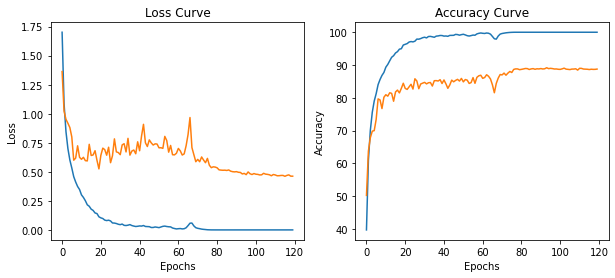

Final Training Accuracy: 100.0
Final Validation Accuracy: 88.76


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomHorizontalFlip)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomHorizontalFlip)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_RandomHorizontalFlip"

main("Inception",'inception','train', directory, 120)

##Random Perspective

In [ ]:
transform_RandomPerspective = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomPerspective(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified


Number of parameters: 1733466
Number of parameters: 1733466


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  34.11, Acc-val:  34.14, L-tr: 1.8143, L-val: 1.9620
000: Acc-tr:  34.11, Acc-val:  34.14, L-tr: 1.8143, L-val: 1.9620


Epoch 0 Finished.  Time per Epoch:  24.56 s 


001: Acc-tr:  53.67, Acc-val:  56.82, L-tr: 1.2822, L-val: 1.2023
001: Acc-tr:  53.67, Acc-val:  56.82, L-tr: 1.2822, L-val: 1.2023


Epoch 1 Finished.  Time per Epoch:  24.76 s 


002: Acc-tr:  63.10, Acc-val:  58.95, L-tr: 1.0324, L-val: 1.2622
002: Acc-tr:  63.10, Acc-val:  58.95, L-tr: 1.0324, L-val: 1.2622


Epoch 2 Finished.  Time per Epoch:  24.74 s 


003: Acc-tr:  68.38, Acc-val:  67.30, L-tr: 0.8921, L-val: 0.9196
003: Acc-tr:  68.38, Acc-val:  67.30, L-tr: 0.8921, L-val: 0.9196


Epoch 3 Finished.  Time per Epoch:  24.73 s 


004: Acc-tr:  72.54, Acc-val:  64.31, L-tr: 0.7798, L-val: 1.0846
004: Acc-tr:  72.54, Acc-val:  64.31, L-tr: 0.7798, L-val: 1.0846


Epoch 4 Finished.  Time per Epoch:  24.85 s 


005: Acc-tr:  75.47, Acc-val:  70.44, L-tr: 0.6932, L-val: 0.8557
005: Acc-tr:  75.47, Acc-val:  70.44, L-tr: 0.6932, L-val: 0.8557


Epoch 5 Finished.  Time per Epoch:  25.08 s 


006: Acc-tr:  77.85, Acc-val:  71.84, L-tr: 0.6331, L-val: 0.8173
006: Acc-tr:  77.85, Acc-val:  71.84, L-tr: 0.6331, L-val: 0.8173


Epoch 6 Finished.  Time per Epoch:  25.25 s 


007: Acc-tr:  79.74, Acc-val:  73.77, L-tr: 0.5839, L-val: 0.7701
007: Acc-tr:  79.74, Acc-val:  73.77, L-tr: 0.5839, L-val: 0.7701


Epoch 7 Finished.  Time per Epoch:  25.38 s 


008: Acc-tr:  81.23, Acc-val:  73.72, L-tr: 0.5345, L-val: 0.7838
008: Acc-tr:  81.23, Acc-val:  73.72, L-tr: 0.5345, L-val: 0.7838


Epoch 8 Finished.  Time per Epoch:  25.45 s 


009: Acc-tr:  82.59, Acc-val:  75.54, L-tr: 0.4989, L-val: 0.7083
009: Acc-tr:  82.59, Acc-val:  75.54, L-tr: 0.4989, L-val: 0.7083


Epoch 9 Finished.  Time per Epoch:  25.56 s 


010: Acc-tr:  83.61, Acc-val:  72.96, L-tr: 0.4709, L-val: 0.8602
010: Acc-tr:  83.61, Acc-val:  72.96, L-tr: 0.4709, L-val: 0.8602


Epoch 10 Finished.  Time per Epoch:  25.63 s 


011: Acc-tr:  84.87, Acc-val:  78.20, L-tr: 0.4384, L-val: 0.6520
011: Acc-tr:  84.87, Acc-val:  78.20, L-tr: 0.4384, L-val: 0.6520


Epoch 11 Finished.  Time per Epoch:  25.69 s 


012: Acc-tr:  85.71, Acc-val:  76.59, L-tr: 0.4060, L-val: 0.7039
012: Acc-tr:  85.71, Acc-val:  76.59, L-tr: 0.4060, L-val: 0.7039


Epoch 12 Finished.  Time per Epoch:  25.73 s 


013: Acc-tr:  86.50, Acc-val:  80.53, L-tr: 0.3877, L-val: 0.5738
013: Acc-tr:  86.50, Acc-val:  80.53, L-tr: 0.3877, L-val: 0.5738


Epoch 13 Finished.  Time per Epoch:  25.75 s 


014: Acc-tr:  87.29, Acc-val:  79.73, L-tr: 0.3584, L-val: 0.6035
014: Acc-tr:  87.29, Acc-val:  79.73, L-tr: 0.3584, L-val: 0.6035


Epoch 14 Finished.  Time per Epoch:  25.76 s 


015: Acc-tr:  87.89, Acc-val:  80.74, L-tr: 0.3478, L-val: 0.5759
015: Acc-tr:  87.89, Acc-val:  80.74, L-tr: 0.3478, L-val: 0.5759


Epoch 15 Finished.  Time per Epoch:  25.80 s 


016: Acc-tr:  88.49, Acc-val:  80.17, L-tr: 0.3283, L-val: 0.5985
016: Acc-tr:  88.49, Acc-val:  80.17, L-tr: 0.3283, L-val: 0.5985


Epoch 16 Finished.  Time per Epoch:  25.84 s 


017: Acc-tr:  89.08, Acc-val:  82.63, L-tr: 0.3114, L-val: 0.5470
017: Acc-tr:  89.08, Acc-val:  82.63, L-tr: 0.3114, L-val: 0.5470


Epoch 17 Finished.  Time per Epoch:  25.89 s 


018: Acc-tr:  89.70, Acc-val:  78.28, L-tr: 0.2922, L-val: 0.6945
018: Acc-tr:  89.70, Acc-val:  78.28, L-tr: 0.2922, L-val: 0.6945


Epoch 18 Finished.  Time per Epoch:  25.92 s 


019: Acc-tr:  90.17, Acc-val:  80.55, L-tr: 0.2813, L-val: 0.6336
019: Acc-tr:  90.17, Acc-val:  80.55, L-tr: 0.2813, L-val: 0.6336


Epoch 19 Finished.  Time per Epoch:  25.96 s 


020: Acc-tr:  90.48, Acc-val:  79.78, L-tr: 0.2735, L-val: 0.6580
020: Acc-tr:  90.48, Acc-val:  79.78, L-tr: 0.2735, L-val: 0.6580


Epoch 20 Finished.  Time per Epoch:  25.99 s 


021: Acc-tr:  91.07, Acc-val:  81.80, L-tr: 0.2561, L-val: 0.5862
021: Acc-tr:  91.07, Acc-val:  81.80, L-tr: 0.2561, L-val: 0.5862


Epoch 21 Finished.  Time per Epoch:  26.02 s 


022: Acc-tr:  91.32, Acc-val:  83.56, L-tr: 0.2445, L-val: 0.5032
022: Acc-tr:  91.32, Acc-val:  83.56, L-tr: 0.2445, L-val: 0.5032


Epoch 22 Finished.  Time per Epoch:  26.05 s 


023: Acc-tr:  91.77, Acc-val:  81.12, L-tr: 0.2335, L-val: 0.5976
023: Acc-tr:  91.77, Acc-val:  81.12, L-tr: 0.2335, L-val: 0.5976


Epoch 23 Finished.  Time per Epoch:  26.07 s 


024: Acc-tr:  91.66, Acc-val:  78.54, L-tr: 0.2388, L-val: 0.7240
024: Acc-tr:  91.66, Acc-val:  78.54, L-tr: 0.2388, L-val: 0.7240


Epoch 24 Finished.  Time per Epoch:  26.10 s 


025: Acc-tr:  92.22, Acc-val:  82.18, L-tr: 0.2228, L-val: 0.5777
025: Acc-tr:  92.22, Acc-val:  82.18, L-tr: 0.2228, L-val: 0.5777


Epoch 25 Finished.  Time per Epoch:  26.14 s 


026: Acc-tr:  92.41, Acc-val:  82.34, L-tr: 0.2163, L-val: 0.5685
026: Acc-tr:  92.41, Acc-val:  82.34, L-tr: 0.2163, L-val: 0.5685


Epoch 26 Finished.  Time per Epoch:  26.16 s 


027: Acc-tr:  92.66, Acc-val:  82.22, L-tr: 0.2105, L-val: 0.5774
027: Acc-tr:  92.66, Acc-val:  82.22, L-tr: 0.2105, L-val: 0.5774


Epoch 27 Finished.  Time per Epoch:  26.17 s 


028: Acc-tr:  92.71, Acc-val:  81.72, L-tr: 0.2032, L-val: 0.5930
028: Acc-tr:  92.71, Acc-val:  81.72, L-tr: 0.2032, L-val: 0.5930


Epoch 28 Finished.  Time per Epoch:  26.17 s 


029: Acc-tr:  93.14, Acc-val:  83.12, L-tr: 0.1958, L-val: 0.5553
029: Acc-tr:  93.14, Acc-val:  83.12, L-tr: 0.1958, L-val: 0.5553


Epoch 29 Finished.  Time per Epoch:  26.16 s 


030: Acc-tr:  93.64, Acc-val:  83.06, L-tr: 0.1828, L-val: 0.5606
030: Acc-tr:  93.64, Acc-val:  83.06, L-tr: 0.1828, L-val: 0.5606


Epoch 30 Finished.  Time per Epoch:  26.15 s 


031: Acc-tr:  93.75, Acc-val:  80.77, L-tr: 0.1791, L-val: 0.6759
031: Acc-tr:  93.75, Acc-val:  80.77, L-tr: 0.1791, L-val: 0.6759


Epoch 31 Finished.  Time per Epoch:  26.13 s 


032: Acc-tr:  93.70, Acc-val:  82.75, L-tr: 0.1783, L-val: 0.6020
032: Acc-tr:  93.70, Acc-val:  82.75, L-tr: 0.1783, L-val: 0.6020


Epoch 32 Finished.  Time per Epoch:  26.09 s 


033: Acc-tr:  94.11, Acc-val:  84.12, L-tr: 0.1720, L-val: 0.5256
033: Acc-tr:  94.11, Acc-val:  84.12, L-tr: 0.1720, L-val: 0.5256


Epoch 33 Finished.  Time per Epoch:  26.06 s 


034: Acc-tr:  93.81, Acc-val:  82.69, L-tr: 0.1751, L-val: 0.6235
034: Acc-tr:  93.81, Acc-val:  82.69, L-tr: 0.1751, L-val: 0.6235


Epoch 34 Finished.  Time per Epoch:  26.03 s 


035: Acc-tr:  94.10, Acc-val:  80.08, L-tr: 0.1693, L-val: 0.7060
035: Acc-tr:  94.10, Acc-val:  80.08, L-tr: 0.1693, L-val: 0.7060


Epoch 35 Finished.  Time per Epoch:  26.00 s 


036: Acc-tr:  94.28, Acc-val:  79.64, L-tr: 0.1625, L-val: 0.7521
036: Acc-tr:  94.28, Acc-val:  79.64, L-tr: 0.1625, L-val: 0.7521


Epoch 36 Finished.  Time per Epoch:  25.97 s 


037: Acc-tr:  94.56, Acc-val:  83.56, L-tr: 0.1570, L-val: 0.5618
037: Acc-tr:  94.56, Acc-val:  83.56, L-tr: 0.1570, L-val: 0.5618


Epoch 37 Finished.  Time per Epoch:  25.94 s 


038: Acc-tr:  94.38, Acc-val:  82.79, L-tr: 0.1576, L-val: 0.6300
038: Acc-tr:  94.38, Acc-val:  82.79, L-tr: 0.1576, L-val: 0.6300


Epoch 38 Finished.  Time per Epoch:  25.93 s 


039: Acc-tr:  94.46, Acc-val:  83.93, L-tr: 0.1580, L-val: 0.5670
039: Acc-tr:  94.46, Acc-val:  83.93, L-tr: 0.1580, L-val: 0.5670


Epoch 39 Finished.  Time per Epoch:  25.95 s 


040: Acc-tr:  94.72, Acc-val:  83.56, L-tr: 0.1502, L-val: 0.5982
040: Acc-tr:  94.72, Acc-val:  83.56, L-tr: 0.1502, L-val: 0.5982


Epoch 40 Finished.  Time per Epoch:  25.97 s 


041: Acc-tr:  94.88, Acc-val:  82.47, L-tr: 0.1466, L-val: 0.6313
041: Acc-tr:  94.88, Acc-val:  82.47, L-tr: 0.1466, L-val: 0.6313


Epoch 41 Finished.  Time per Epoch:  25.98 s 


042: Acc-tr:  95.06, Acc-val:  84.83, L-tr: 0.1430, L-val: 0.5403
042: Acc-tr:  95.06, Acc-val:  84.83, L-tr: 0.1430, L-val: 0.5403


Epoch 42 Finished.  Time per Epoch:  25.98 s 


043: Acc-tr:  95.09, Acc-val:  85.14, L-tr: 0.1400, L-val: 0.5088
043: Acc-tr:  95.09, Acc-val:  85.14, L-tr: 0.1400, L-val: 0.5088


Epoch 43 Finished.  Time per Epoch:  26.00 s 


044: Acc-tr:  95.16, Acc-val:  83.98, L-tr: 0.1387, L-val: 0.5765
044: Acc-tr:  95.16, Acc-val:  83.98, L-tr: 0.1387, L-val: 0.5765


Epoch 44 Finished.  Time per Epoch:  26.00 s 


045: Acc-tr:  95.24, Acc-val:  84.55, L-tr: 0.1351, L-val: 0.5530
045: Acc-tr:  95.24, Acc-val:  84.55, L-tr: 0.1351, L-val: 0.5530


Epoch 45 Finished.  Time per Epoch:  26.02 s 


046: Acc-tr:  95.19, Acc-val:  84.54, L-tr: 0.1361, L-val: 0.5446
046: Acc-tr:  95.19, Acc-val:  84.54, L-tr: 0.1361, L-val: 0.5446


Epoch 46 Finished.  Time per Epoch:  26.04 s 


047: Acc-tr:  95.35, Acc-val:  84.10, L-tr: 0.1322, L-val: 0.6184
047: Acc-tr:  95.35, Acc-val:  84.10, L-tr: 0.1322, L-val: 0.6184


Epoch 47 Finished.  Time per Epoch:  26.05 s 


048: Acc-tr:  95.45, Acc-val:  82.23, L-tr: 0.1317, L-val: 0.6511
048: Acc-tr:  95.45, Acc-val:  82.23, L-tr: 0.1317, L-val: 0.6511


Epoch 48 Finished.  Time per Epoch:  26.07 s 


049: Acc-tr:  95.61, Acc-val:  83.73, L-tr: 0.1281, L-val: 0.5966
049: Acc-tr:  95.61, Acc-val:  83.73, L-tr: 0.1281, L-val: 0.5966


Epoch 49 Finished.  Time per Epoch:  26.09 s 


050: Acc-tr:  95.57, Acc-val:  83.79, L-tr: 0.1273, L-val: 0.5703
050: Acc-tr:  95.57, Acc-val:  83.79, L-tr: 0.1273, L-val: 0.5703


Epoch 50 Finished.  Time per Epoch:  26.11 s 


051: Acc-tr:  95.65, Acc-val:  83.75, L-tr: 0.1268, L-val: 0.5782
051: Acc-tr:  95.65, Acc-val:  83.75, L-tr: 0.1268, L-val: 0.5782


Epoch 51 Finished.  Time per Epoch:  26.12 s 


052: Acc-tr:  95.70, Acc-val:  84.77, L-tr: 0.1232, L-val: 0.5470
052: Acc-tr:  95.70, Acc-val:  84.77, L-tr: 0.1232, L-val: 0.5470


Epoch 52 Finished.  Time per Epoch:  26.14 s 


053: Acc-tr:  95.81, Acc-val:  84.35, L-tr: 0.1190, L-val: 0.5638
053: Acc-tr:  95.81, Acc-val:  84.35, L-tr: 0.1190, L-val: 0.5638


Epoch 53 Finished.  Time per Epoch:  26.15 s 


054: Acc-tr:  95.67, Acc-val:  84.45, L-tr: 0.1242, L-val: 0.5755
054: Acc-tr:  95.67, Acc-val:  84.45, L-tr: 0.1242, L-val: 0.5755


Epoch 54 Finished.  Time per Epoch:  26.17 s 


055: Acc-tr:  95.92, Acc-val:  84.76, L-tr: 0.1194, L-val: 0.5558
055: Acc-tr:  95.92, Acc-val:  84.76, L-tr: 0.1194, L-val: 0.5558


Epoch 55 Finished.  Time per Epoch:  26.19 s 


056: Acc-tr:  95.74, Acc-val:  84.58, L-tr: 0.1233, L-val: 0.5688
056: Acc-tr:  95.74, Acc-val:  84.58, L-tr: 0.1233, L-val: 0.5688


Epoch 56 Finished.  Time per Epoch:  26.21 s 


057: Acc-tr:  96.05, Acc-val:  84.23, L-tr: 0.1173, L-val: 0.5603
057: Acc-tr:  96.05, Acc-val:  84.23, L-tr: 0.1173, L-val: 0.5603


Epoch 57 Finished.  Time per Epoch:  26.23 s 


058: Acc-tr:  95.79, Acc-val:  84.42, L-tr: 0.1181, L-val: 0.5766
058: Acc-tr:  95.79, Acc-val:  84.42, L-tr: 0.1181, L-val: 0.5766


Epoch 58 Finished.  Time per Epoch:  26.25 s 


059: Acc-tr:  95.92, Acc-val:  84.17, L-tr: 0.1156, L-val: 0.5837
059: Acc-tr:  95.92, Acc-val:  84.17, L-tr: 0.1156, L-val: 0.5837


Epoch 59 Finished.  Time per Epoch:  26.28 s 


060: Acc-tr:  95.97, Acc-val:  85.07, L-tr: 0.1149, L-val: 0.5436
060: Acc-tr:  95.97, Acc-val:  85.07, L-tr: 0.1149, L-val: 0.5436


Epoch 60 Finished.  Time per Epoch:  26.30 s 


061: Acc-tr:  96.09, Acc-val:  84.64, L-tr: 0.1130, L-val: 0.5958
061: Acc-tr:  96.09, Acc-val:  84.64, L-tr: 0.1130, L-val: 0.5958


Epoch 61 Finished.  Time per Epoch:  26.31 s 


062: Acc-tr:  96.25, Acc-val:  84.68, L-tr: 0.1061, L-val: 0.5417
062: Acc-tr:  96.25, Acc-val:  84.68, L-tr: 0.1061, L-val: 0.5417


Epoch 62 Finished.  Time per Epoch:  26.31 s 


063: Acc-tr:  96.10, Acc-val:  85.44, L-tr: 0.1123, L-val: 0.5586
063: Acc-tr:  96.10, Acc-val:  85.44, L-tr: 0.1123, L-val: 0.5586


Epoch 63 Finished.  Time per Epoch:  26.30 s 


064: Acc-tr:  96.23, Acc-val:  84.55, L-tr: 0.1087, L-val: 0.5894
064: Acc-tr:  96.23, Acc-val:  84.55, L-tr: 0.1087, L-val: 0.5894


Epoch 64 Finished.  Time per Epoch:  26.30 s 


065: Acc-tr:  96.21, Acc-val:  84.63, L-tr: 0.1098, L-val: 0.5701
065: Acc-tr:  96.21, Acc-val:  84.63, L-tr: 0.1098, L-val: 0.5701


Epoch 65 Finished.  Time per Epoch:  26.29 s 


066: Acc-tr:  96.36, Acc-val:  83.26, L-tr: 0.1039, L-val: 0.6476
066: Acc-tr:  96.36, Acc-val:  83.26, L-tr: 0.1039, L-val: 0.6476


Epoch 66 Finished.  Time per Epoch:  26.28 s 


067: Acc-tr:  96.25, Acc-val:  84.07, L-tr: 0.1079, L-val: 0.6077
067: Acc-tr:  96.25, Acc-val:  84.07, L-tr: 0.1079, L-val: 0.6077


Epoch 67 Finished.  Time per Epoch:  26.26 s 


068: Acc-tr:  96.52, Acc-val:  84.48, L-tr: 0.1019, L-val: 0.5800
068: Acc-tr:  96.52, Acc-val:  84.48, L-tr: 0.1019, L-val: 0.5800


Epoch 68 Finished.  Time per Epoch:  26.24 s 


069: Acc-tr:  96.39, Acc-val:  84.25, L-tr: 0.1026, L-val: 0.6095
069: Acc-tr:  96.39, Acc-val:  84.25, L-tr: 0.1026, L-val: 0.6095


Epoch 69 Finished.  Time per Epoch:  26.22 s 


070: Acc-tr:  96.36, Acc-val:  83.99, L-tr: 0.1049, L-val: 0.5941
070: Acc-tr:  96.36, Acc-val:  83.99, L-tr: 0.1049, L-val: 0.5941


Epoch 70 Finished.  Time per Epoch:  26.20 s 


071: Acc-tr:  96.41, Acc-val:  84.81, L-tr: 0.1016, L-val: 0.5699
071: Acc-tr:  96.41, Acc-val:  84.81, L-tr: 0.1016, L-val: 0.5699


Epoch 71 Finished.  Time per Epoch:  26.19 s 


072: Acc-tr:  96.57, Acc-val:  85.95, L-tr: 0.0977, L-val: 0.5195
072: Acc-tr:  96.57, Acc-val:  85.95, L-tr: 0.0977, L-val: 0.5195


Epoch 72 Finished.  Time per Epoch:  26.18 s 


073: Acc-tr:  96.45, Acc-val:  83.76, L-tr: 0.1027, L-val: 0.6327
073: Acc-tr:  96.45, Acc-val:  83.76, L-tr: 0.1027, L-val: 0.6327


Epoch 73 Finished.  Time per Epoch:  26.17 s 


074: Acc-tr:  96.69, Acc-val:  85.31, L-tr: 0.0963, L-val: 0.5512
074: Acc-tr:  96.69, Acc-val:  85.31, L-tr: 0.0963, L-val: 0.5512


Epoch 74 Finished.  Time per Epoch:  26.17 s 


075: Acc-tr:  96.53, Acc-val:  84.75, L-tr: 0.0985, L-val: 0.5587
075: Acc-tr:  96.53, Acc-val:  84.75, L-tr: 0.0985, L-val: 0.5587


Epoch 75 Finished.  Time per Epoch:  26.17 s 


076: Acc-tr:  96.49, Acc-val:  83.96, L-tr: 0.1018, L-val: 0.6119
076: Acc-tr:  96.49, Acc-val:  83.96, L-tr: 0.1018, L-val: 0.6119


Epoch 76 Finished.  Time per Epoch:  26.17 s 


077: Acc-tr:  96.90, Acc-val:  84.85, L-tr: 0.0916, L-val: 0.5840
077: Acc-tr:  96.90, Acc-val:  84.85, L-tr: 0.0916, L-val: 0.5840


Epoch 77 Finished.  Time per Epoch:  26.17 s 


078: Acc-tr:  96.61, Acc-val:  83.34, L-tr: 0.0984, L-val: 0.6142
078: Acc-tr:  96.61, Acc-val:  83.34, L-tr: 0.0984, L-val: 0.6142


Epoch 78 Finished.  Time per Epoch:  26.17 s 


079: Acc-tr:  96.76, Acc-val:  84.34, L-tr: 0.0937, L-val: 0.6062
079: Acc-tr:  96.76, Acc-val:  84.34, L-tr: 0.0937, L-val: 0.6062


Epoch 79 Finished.  Time per Epoch:  26.18 s 


080: Acc-tr:  96.75, Acc-val:  85.21, L-tr: 0.0945, L-val: 0.5453
080: Acc-tr:  96.75, Acc-val:  85.21, L-tr: 0.0945, L-val: 0.5453


Epoch 80 Finished.  Time per Epoch:  26.18 s 


081: Acc-tr:  96.64, Acc-val:  84.13, L-tr: 0.0972, L-val: 0.6182
081: Acc-tr:  96.64, Acc-val:  84.13, L-tr: 0.0972, L-val: 0.6182


Epoch 81 Finished.  Time per Epoch:  26.19 s 


082: Acc-tr:  96.66, Acc-val:  84.80, L-tr: 0.0979, L-val: 0.5819
082: Acc-tr:  96.66, Acc-val:  84.80, L-tr: 0.0979, L-val: 0.5819


Epoch 82 Finished.  Time per Epoch:  26.19 s 


083: Acc-tr:  97.10, Acc-val:  84.72, L-tr: 0.0847, L-val: 0.6106
083: Acc-tr:  97.10, Acc-val:  84.72, L-tr: 0.0847, L-val: 0.6106


Epoch 83 Finished.  Time per Epoch:  26.20 s 


084: Acc-tr:  96.74, Acc-val:  85.30, L-tr: 0.0940, L-val: 0.5692
084: Acc-tr:  96.74, Acc-val:  85.30, L-tr: 0.0940, L-val: 0.5692


Epoch 84 Finished.  Time per Epoch:  26.20 s 


085: Acc-tr:  96.90, Acc-val:  84.89, L-tr: 0.0904, L-val: 0.5701
085: Acc-tr:  96.90, Acc-val:  84.89, L-tr: 0.0904, L-val: 0.5701


Epoch 85 Finished.  Time per Epoch:  26.21 s 


086: Acc-tr:  96.68, Acc-val:  84.13, L-tr: 0.0954, L-val: 0.5925
086: Acc-tr:  96.68, Acc-val:  84.13, L-tr: 0.0954, L-val: 0.5925


Epoch 86 Finished.  Time per Epoch:  26.21 s 


087: Acc-tr:  96.76, Acc-val:  85.65, L-tr: 0.0916, L-val: 0.5499
087: Acc-tr:  96.76, Acc-val:  85.65, L-tr: 0.0916, L-val: 0.5499


Epoch 87 Finished.  Time per Epoch:  26.21 s 


088: Acc-tr:  96.95, Acc-val:  84.72, L-tr: 0.0889, L-val: 0.5938
088: Acc-tr:  96.95, Acc-val:  84.72, L-tr: 0.0889, L-val: 0.5938


Epoch 88 Finished.  Time per Epoch:  26.23 s 


089: Acc-tr:  96.76, Acc-val:  84.51, L-tr: 0.0952, L-val: 0.5914
089: Acc-tr:  96.76, Acc-val:  84.51, L-tr: 0.0952, L-val: 0.5914


Epoch 89 Finished.  Time per Epoch:  26.24 s 


090: Acc-tr:  97.07, Acc-val:  84.23, L-tr: 0.0850, L-val: 0.6111
090: Acc-tr:  97.07, Acc-val:  84.23, L-tr: 0.0850, L-val: 0.6111


Epoch 90 Finished.  Time per Epoch:  26.26 s 


091: Acc-tr:  96.88, Acc-val:  83.13, L-tr: 0.0895, L-val: 0.6612
091: Acc-tr:  96.88, Acc-val:  83.13, L-tr: 0.0895, L-val: 0.6612


Epoch 91 Finished.  Time per Epoch:  26.28 s 


092: Acc-tr:  96.90, Acc-val:  84.85, L-tr: 0.0890, L-val: 0.5903
092: Acc-tr:  96.90, Acc-val:  84.85, L-tr: 0.0890, L-val: 0.5903


Epoch 92 Finished.  Time per Epoch:  26.29 s 


093: Acc-tr:  96.97, Acc-val:  84.12, L-tr: 0.0876, L-val: 0.6246
093: Acc-tr:  96.97, Acc-val:  84.12, L-tr: 0.0876, L-val: 0.6246


Epoch 93 Finished.  Time per Epoch:  26.31 s 


094: Acc-tr:  97.01, Acc-val:  85.31, L-tr: 0.0857, L-val: 0.6058
094: Acc-tr:  97.01, Acc-val:  85.31, L-tr: 0.0857, L-val: 0.6058


Epoch 94 Finished.  Time per Epoch:  26.33 s 


095: Acc-tr:  96.81, Acc-val:  85.63, L-tr: 0.0923, L-val: 0.5593
095: Acc-tr:  96.81, Acc-val:  85.63, L-tr: 0.0923, L-val: 0.5593


Epoch 95 Finished.  Time per Epoch:  26.34 s 


096: Acc-tr:  97.01, Acc-val:  83.23, L-tr: 0.0871, L-val: 0.6615
096: Acc-tr:  97.01, Acc-val:  83.23, L-tr: 0.0871, L-val: 0.6615


Epoch 96 Finished.  Time per Epoch:  26.34 s 


097: Acc-tr:  96.90, Acc-val:  83.71, L-tr: 0.0894, L-val: 0.6501
097: Acc-tr:  96.90, Acc-val:  83.71, L-tr: 0.0894, L-val: 0.6501


Epoch 97 Finished.  Time per Epoch:  26.34 s 


098: Acc-tr:  96.78, Acc-val:  85.02, L-tr: 0.0924, L-val: 0.5460
098: Acc-tr:  96.78, Acc-val:  85.02, L-tr: 0.0924, L-val: 0.5460


Epoch 98 Finished.  Time per Epoch:  26.35 s 


099: Acc-tr:  97.11, Acc-val:  85.09, L-tr: 0.0851, L-val: 0.5938
099: Acc-tr:  97.11, Acc-val:  85.09, L-tr: 0.0851, L-val: 0.5938


Epoch 99 Finished.  Time per Epoch:  26.35 s 


100: Acc-tr:  96.95, Acc-val:  86.02, L-tr: 0.0891, L-val: 0.5198
100: Acc-tr:  96.95, Acc-val:  86.02, L-tr: 0.0891, L-val: 0.5198


Epoch 100 Finished.  Time per Epoch:  26.35 s 


101: Acc-tr:  97.17, Acc-val:  86.04, L-tr: 0.0821, L-val: 0.5337
101: Acc-tr:  97.17, Acc-val:  86.04, L-tr: 0.0821, L-val: 0.5337


Epoch 101 Finished.  Time per Epoch:  26.34 s 


102: Acc-tr:  97.13, Acc-val:  85.93, L-tr: 0.0822, L-val: 0.5445
102: Acc-tr:  97.13, Acc-val:  85.93, L-tr: 0.0822, L-val: 0.5445


Epoch 102 Finished.  Time per Epoch:  26.34 s 


103: Acc-tr:  97.12, Acc-val:  83.70, L-tr: 0.0815, L-val: 0.6153
103: Acc-tr:  97.12, Acc-val:  83.70, L-tr: 0.0815, L-val: 0.6153


Epoch 103 Finished.  Time per Epoch:  26.34 s 


104: Acc-tr:  96.73, Acc-val:  84.28, L-tr: 0.0931, L-val: 0.6086
104: Acc-tr:  96.73, Acc-val:  84.28, L-tr: 0.0931, L-val: 0.6086


Epoch 104 Finished.  Time per Epoch:  26.35 s 


105: Acc-tr:  96.89, Acc-val:  85.31, L-tr: 0.0883, L-val: 0.5563
105: Acc-tr:  96.89, Acc-val:  85.31, L-tr: 0.0883, L-val: 0.5563


Epoch 105 Finished.  Time per Epoch:  26.34 s 


106: Acc-tr:  96.95, Acc-val:  86.06, L-tr: 0.0875, L-val: 0.5298
106: Acc-tr:  96.95, Acc-val:  86.06, L-tr: 0.0875, L-val: 0.5298


Epoch 106 Finished.  Time per Epoch:  26.34 s 


107: Acc-tr:  97.09, Acc-val:  83.88, L-tr: 0.0835, L-val: 0.6098
107: Acc-tr:  97.09, Acc-val:  83.88, L-tr: 0.0835, L-val: 0.6098


Epoch 107 Finished.  Time per Epoch:  26.35 s 


108: Acc-tr:  97.36, Acc-val:  84.52, L-tr: 0.0768, L-val: 0.5871
108: Acc-tr:  97.36, Acc-val:  84.52, L-tr: 0.0768, L-val: 0.5871


Epoch 108 Finished.  Time per Epoch:  26.36 s 


109: Acc-tr:  97.24, Acc-val:  84.99, L-tr: 0.0794, L-val: 0.5796
109: Acc-tr:  97.24, Acc-val:  84.99, L-tr: 0.0794, L-val: 0.5796


Epoch 109 Finished.  Time per Epoch:  26.36 s 


110: Acc-tr:  97.11, Acc-val:  85.22, L-tr: 0.0831, L-val: 0.5687
110: Acc-tr:  97.11, Acc-val:  85.22, L-tr: 0.0831, L-val: 0.5687


Epoch 110 Finished.  Time per Epoch:  26.36 s 


111: Acc-tr:  97.21, Acc-val:  84.04, L-tr: 0.0799, L-val: 0.6130
111: Acc-tr:  97.21, Acc-val:  84.04, L-tr: 0.0799, L-val: 0.6130


Epoch 111 Finished.  Time per Epoch:  26.36 s 


112: Acc-tr:  97.28, Acc-val:  85.53, L-tr: 0.0809, L-val: 0.5836
112: Acc-tr:  97.28, Acc-val:  85.53, L-tr: 0.0809, L-val: 0.5836


Epoch 112 Finished.  Time per Epoch:  26.36 s 


113: Acc-tr:  97.12, Acc-val:  85.15, L-tr: 0.0829, L-val: 0.5760
113: Acc-tr:  97.12, Acc-val:  85.15, L-tr: 0.0829, L-val: 0.5760


Epoch 113 Finished.  Time per Epoch:  26.36 s 


114: Acc-tr:  97.23, Acc-val:  85.87, L-tr: 0.0808, L-val: 0.5649
114: Acc-tr:  97.23, Acc-val:  85.87, L-tr: 0.0808, L-val: 0.5649


Epoch 114 Finished.  Time per Epoch:  26.36 s 


115: Acc-tr:  97.14, Acc-val:  84.22, L-tr: 0.0803, L-val: 0.6215
115: Acc-tr:  97.14, Acc-val:  84.22, L-tr: 0.0803, L-val: 0.6215


Epoch 115 Finished.  Time per Epoch:  26.36 s 


116: Acc-tr:  97.10, Acc-val:  84.75, L-tr: 0.0826, L-val: 0.5831
116: Acc-tr:  97.10, Acc-val:  84.75, L-tr: 0.0826, L-val: 0.5831


Epoch 116 Finished.  Time per Epoch:  26.36 s 


117: Acc-tr:  97.27, Acc-val:  84.73, L-tr: 0.0779, L-val: 0.5988
117: Acc-tr:  97.27, Acc-val:  84.73, L-tr: 0.0779, L-val: 0.5988


Epoch 117 Finished.  Time per Epoch:  26.36 s 


118: Acc-tr:  97.22, Acc-val:  84.51, L-tr: 0.0810, L-val: 0.6047
118: Acc-tr:  97.22, Acc-val:  84.51, L-tr: 0.0810, L-val: 0.6047


Epoch 118 Finished.  Time per Epoch:  26.36 s 


119: Acc-tr:  97.54, Acc-val:  85.54, L-tr: 0.0717, L-val: 0.5555
119: Acc-tr:  97.54, Acc-val:  85.54, L-tr: 0.0717, L-val: 0.5555


Epoch 119 Finished.  Time per Epoch:  26.36 s 


120: Acc-tr:  97.44, Acc-val:  86.35, L-tr: 0.0741, L-val: 0.5454
120: Acc-tr:  97.44, Acc-val:  86.35, L-tr: 0.0741, L-val: 0.5454


Epoch 120 Finished.  Time per Epoch:  26.36 s 


121: Acc-tr:  97.30, Acc-val:  85.83, L-tr: 0.0802, L-val: 0.5393
121: Acc-tr:  97.30, Acc-val:  85.83, L-tr: 0.0802, L-val: 0.5393


Epoch 121 Finished.  Time per Epoch:  26.36 s 


122: Acc-tr:  97.32, Acc-val:  84.39, L-tr: 0.0776, L-val: 0.5874
122: Acc-tr:  97.32, Acc-val:  84.39, L-tr: 0.0776, L-val: 0.5874


Epoch 122 Finished.  Time per Epoch:  26.37 s 


123: Acc-tr:  97.27, Acc-val:  85.73, L-tr: 0.0770, L-val: 0.5254
123: Acc-tr:  97.27, Acc-val:  85.73, L-tr: 0.0770, L-val: 0.5254


Epoch 123 Finished.  Time per Epoch:  26.37 s 


124: Acc-tr:  97.33, Acc-val:  85.71, L-tr: 0.0773, L-val: 0.5732
124: Acc-tr:  97.33, Acc-val:  85.71, L-tr: 0.0773, L-val: 0.5732


Epoch 124 Finished.  Time per Epoch:  26.36 s 


125: Acc-tr:  97.20, Acc-val:  85.83, L-tr: 0.0789, L-val: 0.5473
125: Acc-tr:  97.20, Acc-val:  85.83, L-tr: 0.0789, L-val: 0.5473


Epoch 125 Finished.  Time per Epoch:  26.37 s 


126: Acc-tr:  97.25, Acc-val:  86.17, L-tr: 0.0799, L-val: 0.5353
126: Acc-tr:  97.25, Acc-val:  86.17, L-tr: 0.0799, L-val: 0.5353


Epoch 126 Finished.  Time per Epoch:  26.37 s 


127: Acc-tr:  97.22, Acc-val:  83.36, L-tr: 0.0791, L-val: 0.6649
127: Acc-tr:  97.22, Acc-val:  83.36, L-tr: 0.0791, L-val: 0.6649


Epoch 127 Finished.  Time per Epoch:  26.37 s 


128: Acc-tr:  97.48, Acc-val:  85.58, L-tr: 0.0733, L-val: 0.5489
128: Acc-tr:  97.48, Acc-val:  85.58, L-tr: 0.0733, L-val: 0.5489


Epoch 128 Finished.  Time per Epoch:  26.37 s 


129: Acc-tr:  97.40, Acc-val:  85.38, L-tr: 0.0770, L-val: 0.5521
129: Acc-tr:  97.40, Acc-val:  85.38, L-tr: 0.0770, L-val: 0.5521


Epoch 129 Finished.  Time per Epoch:  26.37 s 


130: Acc-tr:  97.15, Acc-val:  85.48, L-tr: 0.0809, L-val: 0.5860
130: Acc-tr:  97.15, Acc-val:  85.48, L-tr: 0.0809, L-val: 0.5860


Epoch 130 Finished.  Time per Epoch:  26.37 s 


131: Acc-tr:  97.12, Acc-val:  85.26, L-tr: 0.0813, L-val: 0.5870
131: Acc-tr:  97.12, Acc-val:  85.26, L-tr: 0.0813, L-val: 0.5870


Epoch 131 Finished.  Time per Epoch:  26.37 s 


132: Acc-tr:  97.40, Acc-val:  85.25, L-tr: 0.0744, L-val: 0.6106
132: Acc-tr:  97.40, Acc-val:  85.25, L-tr: 0.0744, L-val: 0.6106


Epoch 132 Finished.  Time per Epoch:  26.37 s 


133: Acc-tr:  97.38, Acc-val:  85.37, L-tr: 0.0762, L-val: 0.5485
133: Acc-tr:  97.38, Acc-val:  85.37, L-tr: 0.0762, L-val: 0.5485


Epoch 133 Finished.  Time per Epoch:  26.36 s 


134: Acc-tr:  97.50, Acc-val:  85.26, L-tr: 0.0725, L-val: 0.5586
134: Acc-tr:  97.50, Acc-val:  85.26, L-tr: 0.0725, L-val: 0.5586


Epoch 134 Finished.  Time per Epoch:  26.36 s 


135: Acc-tr:  97.43, Acc-val:  85.73, L-tr: 0.0775, L-val: 0.5651
135: Acc-tr:  97.43, Acc-val:  85.73, L-tr: 0.0775, L-val: 0.5651


Epoch 135 Finished.  Time per Epoch:  26.36 s 


136: Acc-tr:  97.37, Acc-val:  84.53, L-tr: 0.0754, L-val: 0.6113
136: Acc-tr:  97.37, Acc-val:  84.53, L-tr: 0.0754, L-val: 0.6113


Epoch 136 Finished.  Time per Epoch:  26.34 s 


137: Acc-tr:  97.62, Acc-val:  86.07, L-tr: 0.0709, L-val: 0.5396
137: Acc-tr:  97.62, Acc-val:  86.07, L-tr: 0.0709, L-val: 0.5396


Epoch 137 Finished.  Time per Epoch:  26.34 s 


138: Acc-tr:  97.42, Acc-val:  84.47, L-tr: 0.0744, L-val: 0.5944
138: Acc-tr:  97.42, Acc-val:  84.47, L-tr: 0.0744, L-val: 0.5944


Epoch 138 Finished.  Time per Epoch:  26.32 s 


139: Acc-tr:  97.18, Acc-val:  83.70, L-tr: 0.0793, L-val: 0.6619
139: Acc-tr:  97.18, Acc-val:  83.70, L-tr: 0.0793, L-val: 0.6619


Epoch 139 Finished.  Time per Epoch:  26.32 s 


140: Acc-tr:  97.30, Acc-val:  86.04, L-tr: 0.0764, L-val: 0.5568
140: Acc-tr:  97.30, Acc-val:  86.04, L-tr: 0.0764, L-val: 0.5568


Epoch 140 Finished.  Time per Epoch:  26.31 s 


141: Acc-tr:  97.54, Acc-val:  85.20, L-tr: 0.0710, L-val: 0.6191
141: Acc-tr:  97.54, Acc-val:  85.20, L-tr: 0.0710, L-val: 0.6191


Epoch 141 Finished.  Time per Epoch:  26.29 s 


142: Acc-tr:  97.45, Acc-val:  83.44, L-tr: 0.0727, L-val: 0.6918
142: Acc-tr:  97.45, Acc-val:  83.44, L-tr: 0.0727, L-val: 0.6918


Epoch 142 Finished.  Time per Epoch:  26.28 s 


143: Acc-tr:  97.52, Acc-val:  84.58, L-tr: 0.0711, L-val: 0.6350
143: Acc-tr:  97.52, Acc-val:  84.58, L-tr: 0.0711, L-val: 0.6350


Epoch 143 Finished.  Time per Epoch:  26.28 s 


144: Acc-tr:  97.28, Acc-val:  83.40, L-tr: 0.0756, L-val: 0.6838
144: Acc-tr:  97.28, Acc-val:  83.40, L-tr: 0.0756, L-val: 0.6838


Epoch 144 Finished.  Time per Epoch:  26.27 s 


145: Acc-tr:  97.43, Acc-val:  84.99, L-tr: 0.0748, L-val: 0.5909
145: Acc-tr:  97.43, Acc-val:  84.99, L-tr: 0.0748, L-val: 0.5909


Epoch 145 Finished.  Time per Epoch:  26.27 s 


146: Acc-tr:  97.32, Acc-val:  85.38, L-tr: 0.0781, L-val: 0.5578
146: Acc-tr:  97.32, Acc-val:  85.38, L-tr: 0.0781, L-val: 0.5578


Epoch 146 Finished.  Time per Epoch:  26.27 s 


147: Acc-tr:  97.32, Acc-val:  84.99, L-tr: 0.0770, L-val: 0.5868
147: Acc-tr:  97.32, Acc-val:  84.99, L-tr: 0.0770, L-val: 0.5868


Epoch 147 Finished.  Time per Epoch:  26.26 s 


148: Acc-tr:  97.40, Acc-val:  86.06, L-tr: 0.0749, L-val: 0.5466
148: Acc-tr:  97.40, Acc-val:  86.06, L-tr: 0.0749, L-val: 0.5466


Epoch 148 Finished.  Time per Epoch:  26.26 s 


149: Acc-tr:  97.42, Acc-val:  84.88, L-tr: 0.0754, L-val: 0.5769
149: Acc-tr:  97.42, Acc-val:  84.88, L-tr: 0.0754, L-val: 0.5769


Epoch 149 Finished.  Time per Epoch:  26.26 s 


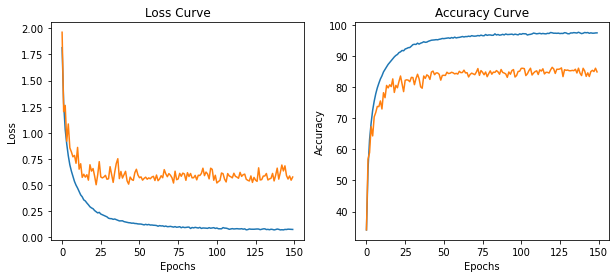

Final Training Accuracy: 97.42000000976563
Final Validation Accuracy: 84.87999990234376


000: Acc-tr:  97.57, Acc-val:  86.09, L-tr: 0.0706, L-val: 0.5393
000: Acc-tr:  97.57, Acc-val:  86.09, L-tr: 0.0706, L-val: 0.5393


Epoch 0 Finished.  Time per Epoch:  3965.70 s 


001: Acc-tr:  97.59, Acc-val:  84.37, L-tr: 0.0721, L-val: 0.6237
001: Acc-tr:  97.59, Acc-val:  84.37, L-tr: 0.0721, L-val: 0.6237


Epoch 1 Finished.  Time per Epoch:  1996.10 s 


002: Acc-tr:  97.58, Acc-val:  84.56, L-tr: 0.0700, L-val: 0.6114
002: Acc-tr:  97.58, Acc-val:  84.56, L-tr: 0.0700, L-val: 0.6114


Epoch 2 Finished.  Time per Epoch:  1339.41 s 


003: Acc-tr:  97.50, Acc-val:  85.88, L-tr: 0.0717, L-val: 0.5599
003: Acc-tr:  97.50, Acc-val:  85.88, L-tr: 0.0717, L-val: 0.5599


Epoch 3 Finished.  Time per Epoch:  1011.20 s 


004: Acc-tr:  97.60, Acc-val:  85.37, L-tr: 0.0694, L-val: 0.6128
004: Acc-tr:  97.60, Acc-val:  85.37, L-tr: 0.0694, L-val: 0.6128


Epoch 4 Finished.  Time per Epoch:  814.27 s 


005: Acc-tr:  97.33, Acc-val:  82.98, L-tr: 0.0778, L-val: 0.7002
005: Acc-tr:  97.33, Acc-val:  82.98, L-tr: 0.0778, L-val: 0.7002


Epoch 5 Finished.  Time per Epoch:  683.00 s 


006: Acc-tr:  97.33, Acc-val:  84.79, L-tr: 0.0759, L-val: 0.6042
006: Acc-tr:  97.33, Acc-val:  84.79, L-tr: 0.0759, L-val: 0.6042


Epoch 6 Finished.  Time per Epoch:  589.24 s 


007: Acc-tr:  97.43, Acc-val:  85.17, L-tr: 0.0726, L-val: 0.5829
007: Acc-tr:  97.43, Acc-val:  85.17, L-tr: 0.0726, L-val: 0.5829


Epoch 7 Finished.  Time per Epoch:  518.89 s 


008: Acc-tr:  97.66, Acc-val:  84.53, L-tr: 0.0674, L-val: 0.6136
008: Acc-tr:  97.66, Acc-val:  84.53, L-tr: 0.0674, L-val: 0.6136


Epoch 8 Finished.  Time per Epoch:  464.21 s 


009: Acc-tr:  97.61, Acc-val:  81.23, L-tr: 0.0686, L-val: 0.8976
009: Acc-tr:  97.61, Acc-val:  81.23, L-tr: 0.0686, L-val: 0.8976


Epoch 9 Finished.  Time per Epoch:  420.49 s 


010: Acc-tr:  97.37, Acc-val:  86.37, L-tr: 0.0745, L-val: 0.5089
010: Acc-tr:  97.37, Acc-val:  86.37, L-tr: 0.0745, L-val: 0.5089


Epoch 10 Finished.  Time per Epoch:  384.75 s 


011: Acc-tr:  97.56, Acc-val:  86.25, L-tr: 0.0710, L-val: 0.5368
011: Acc-tr:  97.56, Acc-val:  86.25, L-tr: 0.0710, L-val: 0.5368


Epoch 11 Finished.  Time per Epoch:  355.00 s 


012: Acc-tr:  97.75, Acc-val:  85.02, L-tr: 0.0654, L-val: 0.6004
012: Acc-tr:  97.75, Acc-val:  85.02, L-tr: 0.0654, L-val: 0.6004


Epoch 12 Finished.  Time per Epoch:  329.85 s 


KeyboardInterrupt: ignored

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomPerspective)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomPerspective)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_RandomPerspective"

main("Inception",'inception','train', directory, 150)

##Random Rotation

In [ ]:
transform_RandomRotation = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomRotation(60),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified


Number of parameters: 1733466
Number of parameters: 1733466
Number of parameters: 1733466
Number of parameters: 1733466
Number of parameters: 1733466


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  34.87, Acc-val:  30.16, L-tr: 1.8389, L-val: 2.2133
000: Acc-tr:  34.87, Acc-val:  30.16, L-tr: 1.8389, L-val: 2.2133
000: Acc-tr:  34.87, Acc-val:  30.16, L-tr: 1.8389, L-val: 2.2133
000: Acc-tr:  34.87, Acc-val:  30.16, L-tr: 1.8389, L-val: 2.2133
000: Acc-tr:  34.87, Acc-val:  30.16, L-tr: 1.8389, L-val: 2.2133


Epoch 0 Finished.  Time per Epoch:  28.61 s 


001: Acc-tr:  48.35, Acc-val:  49.14, L-tr: 1.4321, L-val: 1.3912
001: Acc-tr:  48.35, Acc-val:  49.14, L-tr: 1.4321, L-val: 1.3912
001: Acc-tr:  48.35, Acc-val:  49.14, L-tr: 1.4321, L-val: 1.3912
001: Acc-tr:  48.35, Acc-val:  49.14, L-tr: 1.4321, L-val: 1.3912
001: Acc-tr:  48.35, Acc-val:  49.14, L-tr: 1.4321, L-val: 1.3912


Epoch 1 Finished.  Time per Epoch:  28.76 s 


002: Acc-tr:  56.01, Acc-val:  55.17, L-tr: 1.2290, L-val: 1.2778
002: Acc-tr:  56.01, Acc-val:  55.17, L-tr: 1.2290, L-val: 1.2778
002: Acc-tr:  56.01, Acc-val:  55.17, L-tr: 1.2290, L-val: 1.2778
002: Acc-tr:  56.01, Acc-val:  55.17, L-tr: 1.2290, L-val: 1.2778
002: Acc-tr:  56.01, Acc-val:  55.17, L-tr: 1.2290, L-val: 1.2778


Epoch 2 Finished.  Time per Epoch:  28.76 s 


003: Acc-tr:  61.05, Acc-val:  55.60, L-tr: 1.0987, L-val: 1.2794
003: Acc-tr:  61.05, Acc-val:  55.60, L-tr: 1.0987, L-val: 1.2794
003: Acc-tr:  61.05, Acc-val:  55.60, L-tr: 1.0987, L-val: 1.2794
003: Acc-tr:  61.05, Acc-val:  55.60, L-tr: 1.0987, L-val: 1.2794
003: Acc-tr:  61.05, Acc-val:  55.60, L-tr: 1.0987, L-val: 1.2794


Epoch 3 Finished.  Time per Epoch:  28.82 s 


004: Acc-tr:  64.79, Acc-val:  62.10, L-tr: 0.9982, L-val: 1.1122
004: Acc-tr:  64.79, Acc-val:  62.10, L-tr: 0.9982, L-val: 1.1122
004: Acc-tr:  64.79, Acc-val:  62.10, L-tr: 0.9982, L-val: 1.1122
004: Acc-tr:  64.79, Acc-val:  62.10, L-tr: 0.9982, L-val: 1.1122
004: Acc-tr:  64.79, Acc-val:  62.10, L-tr: 0.9982, L-val: 1.1122


Epoch 4 Finished.  Time per Epoch:  28.80 s 


005: Acc-tr:  67.47, Acc-val:  65.07, L-tr: 0.9207, L-val: 0.9971
005: Acc-tr:  67.47, Acc-val:  65.07, L-tr: 0.9207, L-val: 0.9971
005: Acc-tr:  67.47, Acc-val:  65.07, L-tr: 0.9207, L-val: 0.9971
005: Acc-tr:  67.47, Acc-val:  65.07, L-tr: 0.9207, L-val: 0.9971
005: Acc-tr:  67.47, Acc-val:  65.07, L-tr: 0.9207, L-val: 0.9971


Epoch 5 Finished.  Time per Epoch:  28.76 s 


006: Acc-tr:  69.55, Acc-val:  63.10, L-tr: 0.8666, L-val: 1.0578
006: Acc-tr:  69.55, Acc-val:  63.10, L-tr: 0.8666, L-val: 1.0578
006: Acc-tr:  69.55, Acc-val:  63.10, L-tr: 0.8666, L-val: 1.0578
006: Acc-tr:  69.55, Acc-val:  63.10, L-tr: 0.8666, L-val: 1.0578
006: Acc-tr:  69.55, Acc-val:  63.10, L-tr: 0.8666, L-val: 1.0578


Epoch 6 Finished.  Time per Epoch:  28.75 s 


007: Acc-tr:  71.54, Acc-val:  67.65, L-tr: 0.8103, L-val: 0.9302
007: Acc-tr:  71.54, Acc-val:  67.65, L-tr: 0.8103, L-val: 0.9302
007: Acc-tr:  71.54, Acc-val:  67.65, L-tr: 0.8103, L-val: 0.9302
007: Acc-tr:  71.54, Acc-val:  67.65, L-tr: 0.8103, L-val: 0.9302
007: Acc-tr:  71.54, Acc-val:  67.65, L-tr: 0.8103, L-val: 0.9302


Epoch 7 Finished.  Time per Epoch:  28.79 s 


008: Acc-tr:  72.82, Acc-val:  67.39, L-tr: 0.7760, L-val: 0.9867
008: Acc-tr:  72.82, Acc-val:  67.39, L-tr: 0.7760, L-val: 0.9867
008: Acc-tr:  72.82, Acc-val:  67.39, L-tr: 0.7760, L-val: 0.9867
008: Acc-tr:  72.82, Acc-val:  67.39, L-tr: 0.7760, L-val: 0.9867
008: Acc-tr:  72.82, Acc-val:  67.39, L-tr: 0.7760, L-val: 0.9867


Epoch 8 Finished.  Time per Epoch:  28.84 s 


009: Acc-tr:  74.31, Acc-val:  68.51, L-tr: 0.7344, L-val: 0.9145
009: Acc-tr:  74.31, Acc-val:  68.51, L-tr: 0.7344, L-val: 0.9145
009: Acc-tr:  74.31, Acc-val:  68.51, L-tr: 0.7344, L-val: 0.9145
009: Acc-tr:  74.31, Acc-val:  68.51, L-tr: 0.7344, L-val: 0.9145
009: Acc-tr:  74.31, Acc-val:  68.51, L-tr: 0.7344, L-val: 0.9145


Epoch 9 Finished.  Time per Epoch:  28.91 s 


010: Acc-tr:  75.38, Acc-val:  71.17, L-tr: 0.7065, L-val: 0.8560
010: Acc-tr:  75.38, Acc-val:  71.17, L-tr: 0.7065, L-val: 0.8560
010: Acc-tr:  75.38, Acc-val:  71.17, L-tr: 0.7065, L-val: 0.8560
010: Acc-tr:  75.38, Acc-val:  71.17, L-tr: 0.7065, L-val: 0.8560
010: Acc-tr:  75.38, Acc-val:  71.17, L-tr: 0.7065, L-val: 0.8560


Epoch 10 Finished.  Time per Epoch:  28.89 s 


011: Acc-tr:  76.50, Acc-val:  72.92, L-tr: 0.6788, L-val: 0.7897
011: Acc-tr:  76.50, Acc-val:  72.92, L-tr: 0.6788, L-val: 0.7897
011: Acc-tr:  76.50, Acc-val:  72.92, L-tr: 0.6788, L-val: 0.7897
011: Acc-tr:  76.50, Acc-val:  72.92, L-tr: 0.6788, L-val: 0.7897
011: Acc-tr:  76.50, Acc-val:  72.92, L-tr: 0.6788, L-val: 0.7897


Epoch 11 Finished.  Time per Epoch:  28.87 s 


012: Acc-tr:  77.43, Acc-val:  67.65, L-tr: 0.6489, L-val: 0.9935
012: Acc-tr:  77.43, Acc-val:  67.65, L-tr: 0.6489, L-val: 0.9935
012: Acc-tr:  77.43, Acc-val:  67.65, L-tr: 0.6489, L-val: 0.9935
012: Acc-tr:  77.43, Acc-val:  67.65, L-tr: 0.6489, L-val: 0.9935
012: Acc-tr:  77.43, Acc-val:  67.65, L-tr: 0.6489, L-val: 0.9935


Epoch 12 Finished.  Time per Epoch:  28.89 s 


013: Acc-tr:  78.42, Acc-val:  72.11, L-tr: 0.6165, L-val: 0.8246
013: Acc-tr:  78.42, Acc-val:  72.11, L-tr: 0.6165, L-val: 0.8246
013: Acc-tr:  78.42, Acc-val:  72.11, L-tr: 0.6165, L-val: 0.8246
013: Acc-tr:  78.42, Acc-val:  72.11, L-tr: 0.6165, L-val: 0.8246
013: Acc-tr:  78.42, Acc-val:  72.11, L-tr: 0.6165, L-val: 0.8246


Epoch 13 Finished.  Time per Epoch:  28.82 s 


014: Acc-tr:  79.12, Acc-val:  73.90, L-tr: 0.6011, L-val: 0.7493
014: Acc-tr:  79.12, Acc-val:  73.90, L-tr: 0.6011, L-val: 0.7493
014: Acc-tr:  79.12, Acc-val:  73.90, L-tr: 0.6011, L-val: 0.7493
014: Acc-tr:  79.12, Acc-val:  73.90, L-tr: 0.6011, L-val: 0.7493
014: Acc-tr:  79.12, Acc-val:  73.90, L-tr: 0.6011, L-val: 0.7493


Epoch 14 Finished.  Time per Epoch:  28.78 s 


015: Acc-tr:  79.98, Acc-val:  74.85, L-tr: 0.5704, L-val: 0.7348
015: Acc-tr:  79.98, Acc-val:  74.85, L-tr: 0.5704, L-val: 0.7348
015: Acc-tr:  79.98, Acc-val:  74.85, L-tr: 0.5704, L-val: 0.7348
015: Acc-tr:  79.98, Acc-val:  74.85, L-tr: 0.5704, L-val: 0.7348
015: Acc-tr:  79.98, Acc-val:  74.85, L-tr: 0.5704, L-val: 0.7348


Epoch 15 Finished.  Time per Epoch:  28.78 s 


016: Acc-tr:  80.63, Acc-val:  76.78, L-tr: 0.5547, L-val: 0.6840
016: Acc-tr:  80.63, Acc-val:  76.78, L-tr: 0.5547, L-val: 0.6840
016: Acc-tr:  80.63, Acc-val:  76.78, L-tr: 0.5547, L-val: 0.6840
016: Acc-tr:  80.63, Acc-val:  76.78, L-tr: 0.5547, L-val: 0.6840
016: Acc-tr:  80.63, Acc-val:  76.78, L-tr: 0.5547, L-val: 0.6840


Epoch 16 Finished.  Time per Epoch:  28.83 s 


017: Acc-tr:  81.49, Acc-val:  74.98, L-tr: 0.5339, L-val: 0.7395
017: Acc-tr:  81.49, Acc-val:  74.98, L-tr: 0.5339, L-val: 0.7395
017: Acc-tr:  81.49, Acc-val:  74.98, L-tr: 0.5339, L-val: 0.7395
017: Acc-tr:  81.49, Acc-val:  74.98, L-tr: 0.5339, L-val: 0.7395
017: Acc-tr:  81.49, Acc-val:  74.98, L-tr: 0.5339, L-val: 0.7395


Epoch 17 Finished.  Time per Epoch:  28.85 s 


018: Acc-tr:  81.81, Acc-val:  74.17, L-tr: 0.5201, L-val: 0.7624
018: Acc-tr:  81.81, Acc-val:  74.17, L-tr: 0.5201, L-val: 0.7624
018: Acc-tr:  81.81, Acc-val:  74.17, L-tr: 0.5201, L-val: 0.7624
018: Acc-tr:  81.81, Acc-val:  74.17, L-tr: 0.5201, L-val: 0.7624
018: Acc-tr:  81.81, Acc-val:  74.17, L-tr: 0.5201, L-val: 0.7624


Epoch 18 Finished.  Time per Epoch:  28.84 s 


019: Acc-tr:  82.43, Acc-val:  76.21, L-tr: 0.4984, L-val: 0.7002
019: Acc-tr:  82.43, Acc-val:  76.21, L-tr: 0.4984, L-val: 0.7002
019: Acc-tr:  82.43, Acc-val:  76.21, L-tr: 0.4984, L-val: 0.7002
019: Acc-tr:  82.43, Acc-val:  76.21, L-tr: 0.4984, L-val: 0.7002
019: Acc-tr:  82.43, Acc-val:  76.21, L-tr: 0.4984, L-val: 0.7002


Epoch 19 Finished.  Time per Epoch:  28.83 s 


020: Acc-tr:  82.91, Acc-val:  76.28, L-tr: 0.4848, L-val: 0.6901
020: Acc-tr:  82.91, Acc-val:  76.28, L-tr: 0.4848, L-val: 0.6901
020: Acc-tr:  82.91, Acc-val:  76.28, L-tr: 0.4848, L-val: 0.6901
020: Acc-tr:  82.91, Acc-val:  76.28, L-tr: 0.4848, L-val: 0.6901
020: Acc-tr:  82.91, Acc-val:  76.28, L-tr: 0.4848, L-val: 0.6901


Epoch 20 Finished.  Time per Epoch:  28.83 s 


021: Acc-tr:  83.34, Acc-val:  76.22, L-tr: 0.4773, L-val: 0.6915
021: Acc-tr:  83.34, Acc-val:  76.22, L-tr: 0.4773, L-val: 0.6915
021: Acc-tr:  83.34, Acc-val:  76.22, L-tr: 0.4773, L-val: 0.6915
021: Acc-tr:  83.34, Acc-val:  76.22, L-tr: 0.4773, L-val: 0.6915
021: Acc-tr:  83.34, Acc-val:  76.22, L-tr: 0.4773, L-val: 0.6915


Epoch 21 Finished.  Time per Epoch:  28.81 s 


022: Acc-tr:  83.90, Acc-val:  78.40, L-tr: 0.4576, L-val: 0.6331
022: Acc-tr:  83.90, Acc-val:  78.40, L-tr: 0.4576, L-val: 0.6331
022: Acc-tr:  83.90, Acc-val:  78.40, L-tr: 0.4576, L-val: 0.6331
022: Acc-tr:  83.90, Acc-val:  78.40, L-tr: 0.4576, L-val: 0.6331
022: Acc-tr:  83.90, Acc-val:  78.40, L-tr: 0.4576, L-val: 0.6331


Epoch 22 Finished.  Time per Epoch:  28.81 s 


023: Acc-tr:  84.61, Acc-val:  77.35, L-tr: 0.4397, L-val: 0.6687
023: Acc-tr:  84.61, Acc-val:  77.35, L-tr: 0.4397, L-val: 0.6687
023: Acc-tr:  84.61, Acc-val:  77.35, L-tr: 0.4397, L-val: 0.6687
023: Acc-tr:  84.61, Acc-val:  77.35, L-tr: 0.4397, L-val: 0.6687
023: Acc-tr:  84.61, Acc-val:  77.35, L-tr: 0.4397, L-val: 0.6687


Epoch 23 Finished.  Time per Epoch:  28.83 s 


024: Acc-tr:  84.60, Acc-val:  77.46, L-tr: 0.4336, L-val: 0.6850
024: Acc-tr:  84.60, Acc-val:  77.46, L-tr: 0.4336, L-val: 0.6850
024: Acc-tr:  84.60, Acc-val:  77.46, L-tr: 0.4336, L-val: 0.6850
024: Acc-tr:  84.60, Acc-val:  77.46, L-tr: 0.4336, L-val: 0.6850
024: Acc-tr:  84.60, Acc-val:  77.46, L-tr: 0.4336, L-val: 0.6850


Epoch 24 Finished.  Time per Epoch:  28.84 s 


025: Acc-tr:  85.18, Acc-val:  76.86, L-tr: 0.4225, L-val: 0.7050
025: Acc-tr:  85.18, Acc-val:  76.86, L-tr: 0.4225, L-val: 0.7050
025: Acc-tr:  85.18, Acc-val:  76.86, L-tr: 0.4225, L-val: 0.7050
025: Acc-tr:  85.18, Acc-val:  76.86, L-tr: 0.4225, L-val: 0.7050
025: Acc-tr:  85.18, Acc-val:  76.86, L-tr: 0.4225, L-val: 0.7050


Epoch 25 Finished.  Time per Epoch:  28.89 s 


026: Acc-tr:  85.81, Acc-val:  77.21, L-tr: 0.4051, L-val: 0.6948
026: Acc-tr:  85.81, Acc-val:  77.21, L-tr: 0.4051, L-val: 0.6948
026: Acc-tr:  85.81, Acc-val:  77.21, L-tr: 0.4051, L-val: 0.6948
026: Acc-tr:  85.81, Acc-val:  77.21, L-tr: 0.4051, L-val: 0.6948
026: Acc-tr:  85.81, Acc-val:  77.21, L-tr: 0.4051, L-val: 0.6948


Epoch 26 Finished.  Time per Epoch:  28.90 s 


027: Acc-tr:  86.13, Acc-val:  74.78, L-tr: 0.3968, L-val: 0.7904
027: Acc-tr:  86.13, Acc-val:  74.78, L-tr: 0.3968, L-val: 0.7904
027: Acc-tr:  86.13, Acc-val:  74.78, L-tr: 0.3968, L-val: 0.7904
027: Acc-tr:  86.13, Acc-val:  74.78, L-tr: 0.3968, L-val: 0.7904
027: Acc-tr:  86.13, Acc-val:  74.78, L-tr: 0.3968, L-val: 0.7904


Epoch 27 Finished.  Time per Epoch:  28.90 s 


028: Acc-tr:  86.61, Acc-val:  77.63, L-tr: 0.3805, L-val: 0.6811
028: Acc-tr:  86.61, Acc-val:  77.63, L-tr: 0.3805, L-val: 0.6811
028: Acc-tr:  86.61, Acc-val:  77.63, L-tr: 0.3805, L-val: 0.6811
028: Acc-tr:  86.61, Acc-val:  77.63, L-tr: 0.3805, L-val: 0.6811
028: Acc-tr:  86.61, Acc-val:  77.63, L-tr: 0.3805, L-val: 0.6811


Epoch 28 Finished.  Time per Epoch:  28.91 s 


029: Acc-tr:  87.14, Acc-val:  78.70, L-tr: 0.3670, L-val: 0.6497
029: Acc-tr:  87.14, Acc-val:  78.70, L-tr: 0.3670, L-val: 0.6497
029: Acc-tr:  87.14, Acc-val:  78.70, L-tr: 0.3670, L-val: 0.6497
029: Acc-tr:  87.14, Acc-val:  78.70, L-tr: 0.3670, L-val: 0.6497
029: Acc-tr:  87.14, Acc-val:  78.70, L-tr: 0.3670, L-val: 0.6497


Epoch 29 Finished.  Time per Epoch:  28.92 s 


030: Acc-tr:  87.02, Acc-val:  77.31, L-tr: 0.3707, L-val: 0.6798
030: Acc-tr:  87.02, Acc-val:  77.31, L-tr: 0.3707, L-val: 0.6798
030: Acc-tr:  87.02, Acc-val:  77.31, L-tr: 0.3707, L-val: 0.6798
030: Acc-tr:  87.02, Acc-val:  77.31, L-tr: 0.3707, L-val: 0.6798
030: Acc-tr:  87.02, Acc-val:  77.31, L-tr: 0.3707, L-val: 0.6798


Epoch 30 Finished.  Time per Epoch:  28.94 s 


031: Acc-tr:  87.89, Acc-val:  78.66, L-tr: 0.3467, L-val: 0.6608
031: Acc-tr:  87.89, Acc-val:  78.66, L-tr: 0.3467, L-val: 0.6608
031: Acc-tr:  87.89, Acc-val:  78.66, L-tr: 0.3467, L-val: 0.6608
031: Acc-tr:  87.89, Acc-val:  78.66, L-tr: 0.3467, L-val: 0.6608
031: Acc-tr:  87.89, Acc-val:  78.66, L-tr: 0.3467, L-val: 0.6608


Epoch 31 Finished.  Time per Epoch:  28.94 s 


032: Acc-tr:  87.70, Acc-val:  78.81, L-tr: 0.3484, L-val: 0.6471
032: Acc-tr:  87.70, Acc-val:  78.81, L-tr: 0.3484, L-val: 0.6471
032: Acc-tr:  87.70, Acc-val:  78.81, L-tr: 0.3484, L-val: 0.6471
032: Acc-tr:  87.70, Acc-val:  78.81, L-tr: 0.3484, L-val: 0.6471
032: Acc-tr:  87.70, Acc-val:  78.81, L-tr: 0.3484, L-val: 0.6471


Epoch 32 Finished.  Time per Epoch:  28.94 s 


033: Acc-tr:  88.01, Acc-val:  78.35, L-tr: 0.3378, L-val: 0.6754
033: Acc-tr:  88.01, Acc-val:  78.35, L-tr: 0.3378, L-val: 0.6754
033: Acc-tr:  88.01, Acc-val:  78.35, L-tr: 0.3378, L-val: 0.6754
033: Acc-tr:  88.01, Acc-val:  78.35, L-tr: 0.3378, L-val: 0.6754
033: Acc-tr:  88.01, Acc-val:  78.35, L-tr: 0.3378, L-val: 0.6754


Epoch 33 Finished.  Time per Epoch:  28.94 s 


034: Acc-tr:  88.45, Acc-val:  79.57, L-tr: 0.3252, L-val: 0.6489
034: Acc-tr:  88.45, Acc-val:  79.57, L-tr: 0.3252, L-val: 0.6489
034: Acc-tr:  88.45, Acc-val:  79.57, L-tr: 0.3252, L-val: 0.6489
034: Acc-tr:  88.45, Acc-val:  79.57, L-tr: 0.3252, L-val: 0.6489
034: Acc-tr:  88.45, Acc-val:  79.57, L-tr: 0.3252, L-val: 0.6489


Epoch 34 Finished.  Time per Epoch:  28.93 s 


035: Acc-tr:  88.62, Acc-val:  79.55, L-tr: 0.3205, L-val: 0.6392
035: Acc-tr:  88.62, Acc-val:  79.55, L-tr: 0.3205, L-val: 0.6392
035: Acc-tr:  88.62, Acc-val:  79.55, L-tr: 0.3205, L-val: 0.6392
035: Acc-tr:  88.62, Acc-val:  79.55, L-tr: 0.3205, L-val: 0.6392
035: Acc-tr:  88.62, Acc-val:  79.55, L-tr: 0.3205, L-val: 0.6392


Epoch 35 Finished.  Time per Epoch:  28.93 s 


036: Acc-tr:  89.16, Acc-val:  77.55, L-tr: 0.3084, L-val: 0.7502
036: Acc-tr:  89.16, Acc-val:  77.55, L-tr: 0.3084, L-val: 0.7502
036: Acc-tr:  89.16, Acc-val:  77.55, L-tr: 0.3084, L-val: 0.7502
036: Acc-tr:  89.16, Acc-val:  77.55, L-tr: 0.3084, L-val: 0.7502
036: Acc-tr:  89.16, Acc-val:  77.55, L-tr: 0.3084, L-val: 0.7502


Epoch 36 Finished.  Time per Epoch:  28.92 s 


037: Acc-tr:  89.21, Acc-val:  79.42, L-tr: 0.3068, L-val: 0.6371
037: Acc-tr:  89.21, Acc-val:  79.42, L-tr: 0.3068, L-val: 0.6371
037: Acc-tr:  89.21, Acc-val:  79.42, L-tr: 0.3068, L-val: 0.6371
037: Acc-tr:  89.21, Acc-val:  79.42, L-tr: 0.3068, L-val: 0.6371
037: Acc-tr:  89.21, Acc-val:  79.42, L-tr: 0.3068, L-val: 0.6371


Epoch 37 Finished.  Time per Epoch:  28.91 s 


038: Acc-tr:  89.42, Acc-val:  79.03, L-tr: 0.3003, L-val: 0.6507
038: Acc-tr:  89.42, Acc-val:  79.03, L-tr: 0.3003, L-val: 0.6507
038: Acc-tr:  89.42, Acc-val:  79.03, L-tr: 0.3003, L-val: 0.6507
038: Acc-tr:  89.42, Acc-val:  79.03, L-tr: 0.3003, L-val: 0.6507
038: Acc-tr:  89.42, Acc-val:  79.03, L-tr: 0.3003, L-val: 0.6507


Epoch 38 Finished.  Time per Epoch:  28.91 s 


039: Acc-tr:  90.00, Acc-val:  80.01, L-tr: 0.2854, L-val: 0.6135
039: Acc-tr:  90.00, Acc-val:  80.01, L-tr: 0.2854, L-val: 0.6135
039: Acc-tr:  90.00, Acc-val:  80.01, L-tr: 0.2854, L-val: 0.6135
039: Acc-tr:  90.00, Acc-val:  80.01, L-tr: 0.2854, L-val: 0.6135
039: Acc-tr:  90.00, Acc-val:  80.01, L-tr: 0.2854, L-val: 0.6135


Epoch 39 Finished.  Time per Epoch:  28.91 s 


040: Acc-tr:  89.94, Acc-val:  80.50, L-tr: 0.2868, L-val: 0.6125
040: Acc-tr:  89.94, Acc-val:  80.50, L-tr: 0.2868, L-val: 0.6125
040: Acc-tr:  89.94, Acc-val:  80.50, L-tr: 0.2868, L-val: 0.6125
040: Acc-tr:  89.94, Acc-val:  80.50, L-tr: 0.2868, L-val: 0.6125
040: Acc-tr:  89.94, Acc-val:  80.50, L-tr: 0.2868, L-val: 0.6125


Epoch 40 Finished.  Time per Epoch:  28.90 s 


041: Acc-tr:  90.17, Acc-val:  79.29, L-tr: 0.2747, L-val: 0.6608
041: Acc-tr:  90.17, Acc-val:  79.29, L-tr: 0.2747, L-val: 0.6608
041: Acc-tr:  90.17, Acc-val:  79.29, L-tr: 0.2747, L-val: 0.6608
041: Acc-tr:  90.17, Acc-val:  79.29, L-tr: 0.2747, L-val: 0.6608
041: Acc-tr:  90.17, Acc-val:  79.29, L-tr: 0.2747, L-val: 0.6608


Epoch 41 Finished.  Time per Epoch:  28.90 s 


042: Acc-tr:  90.29, Acc-val:  79.46, L-tr: 0.2772, L-val: 0.6553
042: Acc-tr:  90.29, Acc-val:  79.46, L-tr: 0.2772, L-val: 0.6553
042: Acc-tr:  90.29, Acc-val:  79.46, L-tr: 0.2772, L-val: 0.6553
042: Acc-tr:  90.29, Acc-val:  79.46, L-tr: 0.2772, L-val: 0.6553
042: Acc-tr:  90.29, Acc-val:  79.46, L-tr: 0.2772, L-val: 0.6553


Epoch 42 Finished.  Time per Epoch:  28.90 s 


043: Acc-tr:  90.88, Acc-val:  80.92, L-tr: 0.2612, L-val: 0.6123
043: Acc-tr:  90.88, Acc-val:  80.92, L-tr: 0.2612, L-val: 0.6123
043: Acc-tr:  90.88, Acc-val:  80.92, L-tr: 0.2612, L-val: 0.6123
043: Acc-tr:  90.88, Acc-val:  80.92, L-tr: 0.2612, L-val: 0.6123
043: Acc-tr:  90.88, Acc-val:  80.92, L-tr: 0.2612, L-val: 0.6123


Epoch 43 Finished.  Time per Epoch:  28.90 s 


044: Acc-tr:  90.94, Acc-val:  78.75, L-tr: 0.2583, L-val: 0.6867
044: Acc-tr:  90.94, Acc-val:  78.75, L-tr: 0.2583, L-val: 0.6867
044: Acc-tr:  90.94, Acc-val:  78.75, L-tr: 0.2583, L-val: 0.6867
044: Acc-tr:  90.94, Acc-val:  78.75, L-tr: 0.2583, L-val: 0.6867
044: Acc-tr:  90.94, Acc-val:  78.75, L-tr: 0.2583, L-val: 0.6867


Epoch 44 Finished.  Time per Epoch:  28.89 s 


045: Acc-tr:  90.53, Acc-val:  78.89, L-tr: 0.2643, L-val: 0.6842
045: Acc-tr:  90.53, Acc-val:  78.89, L-tr: 0.2643, L-val: 0.6842
045: Acc-tr:  90.53, Acc-val:  78.89, L-tr: 0.2643, L-val: 0.6842
045: Acc-tr:  90.53, Acc-val:  78.89, L-tr: 0.2643, L-val: 0.6842
045: Acc-tr:  90.53, Acc-val:  78.89, L-tr: 0.2643, L-val: 0.6842


Epoch 45 Finished.  Time per Epoch:  28.89 s 


046: Acc-tr:  91.24, Acc-val:  81.05, L-tr: 0.2466, L-val: 0.6186
046: Acc-tr:  91.24, Acc-val:  81.05, L-tr: 0.2466, L-val: 0.6186
046: Acc-tr:  91.24, Acc-val:  81.05, L-tr: 0.2466, L-val: 0.6186
046: Acc-tr:  91.24, Acc-val:  81.05, L-tr: 0.2466, L-val: 0.6186
046: Acc-tr:  91.24, Acc-val:  81.05, L-tr: 0.2466, L-val: 0.6186


Epoch 46 Finished.  Time per Epoch:  28.89 s 


047: Acc-tr:  91.14, Acc-val:  80.45, L-tr: 0.2523, L-val: 0.6415
047: Acc-tr:  91.14, Acc-val:  80.45, L-tr: 0.2523, L-val: 0.6415
047: Acc-tr:  91.14, Acc-val:  80.45, L-tr: 0.2523, L-val: 0.6415
047: Acc-tr:  91.14, Acc-val:  80.45, L-tr: 0.2523, L-val: 0.6415
047: Acc-tr:  91.14, Acc-val:  80.45, L-tr: 0.2523, L-val: 0.6415


Epoch 47 Finished.  Time per Epoch:  28.89 s 


048: Acc-tr:  91.56, Acc-val:  80.51, L-tr: 0.2363, L-val: 0.6199
048: Acc-tr:  91.56, Acc-val:  80.51, L-tr: 0.2363, L-val: 0.6199
048: Acc-tr:  91.56, Acc-val:  80.51, L-tr: 0.2363, L-val: 0.6199
048: Acc-tr:  91.56, Acc-val:  80.51, L-tr: 0.2363, L-val: 0.6199
048: Acc-tr:  91.56, Acc-val:  80.51, L-tr: 0.2363, L-val: 0.6199


Epoch 48 Finished.  Time per Epoch:  28.88 s 


049: Acc-tr:  91.36, Acc-val:  80.00, L-tr: 0.2412, L-val: 0.6549
049: Acc-tr:  91.36, Acc-val:  80.00, L-tr: 0.2412, L-val: 0.6549
049: Acc-tr:  91.36, Acc-val:  80.00, L-tr: 0.2412, L-val: 0.6549
049: Acc-tr:  91.36, Acc-val:  80.00, L-tr: 0.2412, L-val: 0.6549
049: Acc-tr:  91.36, Acc-val:  80.00, L-tr: 0.2412, L-val: 0.6549


Epoch 49 Finished.  Time per Epoch:  28.88 s 


050: Acc-tr:  91.91, Acc-val:  79.35, L-tr: 0.2277, L-val: 0.6933
050: Acc-tr:  91.91, Acc-val:  79.35, L-tr: 0.2277, L-val: 0.6933
050: Acc-tr:  91.91, Acc-val:  79.35, L-tr: 0.2277, L-val: 0.6933
050: Acc-tr:  91.91, Acc-val:  79.35, L-tr: 0.2277, L-val: 0.6933
050: Acc-tr:  91.91, Acc-val:  79.35, L-tr: 0.2277, L-val: 0.6933


Epoch 50 Finished.  Time per Epoch:  28.87 s 


051: Acc-tr:  91.76, Acc-val:  80.19, L-tr: 0.2360, L-val: 0.6574
051: Acc-tr:  91.76, Acc-val:  80.19, L-tr: 0.2360, L-val: 0.6574
051: Acc-tr:  91.76, Acc-val:  80.19, L-tr: 0.2360, L-val: 0.6574
051: Acc-tr:  91.76, Acc-val:  80.19, L-tr: 0.2360, L-val: 0.6574
051: Acc-tr:  91.76, Acc-val:  80.19, L-tr: 0.2360, L-val: 0.6574


Epoch 51 Finished.  Time per Epoch:  28.88 s 


052: Acc-tr:  92.24, Acc-val:  80.62, L-tr: 0.2217, L-val: 0.6386
052: Acc-tr:  92.24, Acc-val:  80.62, L-tr: 0.2217, L-val: 0.6386
052: Acc-tr:  92.24, Acc-val:  80.62, L-tr: 0.2217, L-val: 0.6386
052: Acc-tr:  92.24, Acc-val:  80.62, L-tr: 0.2217, L-val: 0.6386
052: Acc-tr:  92.24, Acc-val:  80.62, L-tr: 0.2217, L-val: 0.6386


Epoch 52 Finished.  Time per Epoch:  28.89 s 


053: Acc-tr:  92.10, Acc-val:  80.97, L-tr: 0.2225, L-val: 0.6313
053: Acc-tr:  92.10, Acc-val:  80.97, L-tr: 0.2225, L-val: 0.6313
053: Acc-tr:  92.10, Acc-val:  80.97, L-tr: 0.2225, L-val: 0.6313
053: Acc-tr:  92.10, Acc-val:  80.97, L-tr: 0.2225, L-val: 0.6313
053: Acc-tr:  92.10, Acc-val:  80.97, L-tr: 0.2225, L-val: 0.6313


Epoch 53 Finished.  Time per Epoch:  28.89 s 


054: Acc-tr:  92.63, Acc-val:  79.17, L-tr: 0.2100, L-val: 0.7141
054: Acc-tr:  92.63, Acc-val:  79.17, L-tr: 0.2100, L-val: 0.7141
054: Acc-tr:  92.63, Acc-val:  79.17, L-tr: 0.2100, L-val: 0.7141
054: Acc-tr:  92.63, Acc-val:  79.17, L-tr: 0.2100, L-val: 0.7141
054: Acc-tr:  92.63, Acc-val:  79.17, L-tr: 0.2100, L-val: 0.7141


Epoch 54 Finished.  Time per Epoch:  28.88 s 


055: Acc-tr:  92.36, Acc-val:  80.05, L-tr: 0.2179, L-val: 0.6600
055: Acc-tr:  92.36, Acc-val:  80.05, L-tr: 0.2179, L-val: 0.6600
055: Acc-tr:  92.36, Acc-val:  80.05, L-tr: 0.2179, L-val: 0.6600
055: Acc-tr:  92.36, Acc-val:  80.05, L-tr: 0.2179, L-val: 0.6600
055: Acc-tr:  92.36, Acc-val:  80.05, L-tr: 0.2179, L-val: 0.6600


Epoch 55 Finished.  Time per Epoch:  28.88 s 


056: Acc-tr:  92.75, Acc-val:  78.32, L-tr: 0.2036, L-val: 0.7671
056: Acc-tr:  92.75, Acc-val:  78.32, L-tr: 0.2036, L-val: 0.7671
056: Acc-tr:  92.75, Acc-val:  78.32, L-tr: 0.2036, L-val: 0.7671
056: Acc-tr:  92.75, Acc-val:  78.32, L-tr: 0.2036, L-val: 0.7671
056: Acc-tr:  92.75, Acc-val:  78.32, L-tr: 0.2036, L-val: 0.7671


Epoch 56 Finished.  Time per Epoch:  28.87 s 


057: Acc-tr:  92.82, Acc-val:  80.04, L-tr: 0.2037, L-val: 0.6748
057: Acc-tr:  92.82, Acc-val:  80.04, L-tr: 0.2037, L-val: 0.6748
057: Acc-tr:  92.82, Acc-val:  80.04, L-tr: 0.2037, L-val: 0.6748
057: Acc-tr:  92.82, Acc-val:  80.04, L-tr: 0.2037, L-val: 0.6748
057: Acc-tr:  92.82, Acc-val:  80.04, L-tr: 0.2037, L-val: 0.6748


Epoch 57 Finished.  Time per Epoch:  28.87 s 


058: Acc-tr:  92.80, Acc-val:  78.80, L-tr: 0.2015, L-val: 0.7648
058: Acc-tr:  92.80, Acc-val:  78.80, L-tr: 0.2015, L-val: 0.7648
058: Acc-tr:  92.80, Acc-val:  78.80, L-tr: 0.2015, L-val: 0.7648
058: Acc-tr:  92.80, Acc-val:  78.80, L-tr: 0.2015, L-val: 0.7648
058: Acc-tr:  92.80, Acc-val:  78.80, L-tr: 0.2015, L-val: 0.7648


Epoch 58 Finished.  Time per Epoch:  28.87 s 


059: Acc-tr:  92.80, Acc-val:  80.88, L-tr: 0.2041, L-val: 0.6300
059: Acc-tr:  92.80, Acc-val:  80.88, L-tr: 0.2041, L-val: 0.6300
059: Acc-tr:  92.80, Acc-val:  80.88, L-tr: 0.2041, L-val: 0.6300
059: Acc-tr:  92.80, Acc-val:  80.88, L-tr: 0.2041, L-val: 0.6300
059: Acc-tr:  92.80, Acc-val:  80.88, L-tr: 0.2041, L-val: 0.6300


Epoch 59 Finished.  Time per Epoch:  28.87 s 


060: Acc-tr:  92.98, Acc-val:  80.83, L-tr: 0.1990, L-val: 0.6476
060: Acc-tr:  92.98, Acc-val:  80.83, L-tr: 0.1990, L-val: 0.6476
060: Acc-tr:  92.98, Acc-val:  80.83, L-tr: 0.1990, L-val: 0.6476
060: Acc-tr:  92.98, Acc-val:  80.83, L-tr: 0.1990, L-val: 0.6476
060: Acc-tr:  92.98, Acc-val:  80.83, L-tr: 0.1990, L-val: 0.6476


Epoch 60 Finished.  Time per Epoch:  28.87 s 


061: Acc-tr:  93.01, Acc-val:  80.24, L-tr: 0.1956, L-val: 0.7012
061: Acc-tr:  93.01, Acc-val:  80.24, L-tr: 0.1956, L-val: 0.7012
061: Acc-tr:  93.01, Acc-val:  80.24, L-tr: 0.1956, L-val: 0.7012
061: Acc-tr:  93.01, Acc-val:  80.24, L-tr: 0.1956, L-val: 0.7012
061: Acc-tr:  93.01, Acc-val:  80.24, L-tr: 0.1956, L-val: 0.7012


Epoch 61 Finished.  Time per Epoch:  28.87 s 


062: Acc-tr:  93.27, Acc-val:  80.23, L-tr: 0.1915, L-val: 0.6920
062: Acc-tr:  93.27, Acc-val:  80.23, L-tr: 0.1915, L-val: 0.6920
062: Acc-tr:  93.27, Acc-val:  80.23, L-tr: 0.1915, L-val: 0.6920
062: Acc-tr:  93.27, Acc-val:  80.23, L-tr: 0.1915, L-val: 0.6920
062: Acc-tr:  93.27, Acc-val:  80.23, L-tr: 0.1915, L-val: 0.6920


Epoch 62 Finished.  Time per Epoch:  28.86 s 


063: Acc-tr:  93.32, Acc-val:  79.52, L-tr: 0.1889, L-val: 0.7315
063: Acc-tr:  93.32, Acc-val:  79.52, L-tr: 0.1889, L-val: 0.7315
063: Acc-tr:  93.32, Acc-val:  79.52, L-tr: 0.1889, L-val: 0.7315
063: Acc-tr:  93.32, Acc-val:  79.52, L-tr: 0.1889, L-val: 0.7315
063: Acc-tr:  93.32, Acc-val:  79.52, L-tr: 0.1889, L-val: 0.7315


Epoch 63 Finished.  Time per Epoch:  28.86 s 


064: Acc-tr:  93.44, Acc-val:  81.08, L-tr: 0.1844, L-val: 0.6551
064: Acc-tr:  93.44, Acc-val:  81.08, L-tr: 0.1844, L-val: 0.6551
064: Acc-tr:  93.44, Acc-val:  81.08, L-tr: 0.1844, L-val: 0.6551
064: Acc-tr:  93.44, Acc-val:  81.08, L-tr: 0.1844, L-val: 0.6551
064: Acc-tr:  93.44, Acc-val:  81.08, L-tr: 0.1844, L-val: 0.6551


Epoch 64 Finished.  Time per Epoch:  28.86 s 


065: Acc-tr:  93.61, Acc-val:  80.66, L-tr: 0.1796, L-val: 0.6849
065: Acc-tr:  93.61, Acc-val:  80.66, L-tr: 0.1796, L-val: 0.6849
065: Acc-tr:  93.61, Acc-val:  80.66, L-tr: 0.1796, L-val: 0.6849
065: Acc-tr:  93.61, Acc-val:  80.66, L-tr: 0.1796, L-val: 0.6849
065: Acc-tr:  93.61, Acc-val:  80.66, L-tr: 0.1796, L-val: 0.6849


Epoch 65 Finished.  Time per Epoch:  28.85 s 


066: Acc-tr:  93.60, Acc-val:  81.00, L-tr: 0.1812, L-val: 0.6516
066: Acc-tr:  93.60, Acc-val:  81.00, L-tr: 0.1812, L-val: 0.6516
066: Acc-tr:  93.60, Acc-val:  81.00, L-tr: 0.1812, L-val: 0.6516
066: Acc-tr:  93.60, Acc-val:  81.00, L-tr: 0.1812, L-val: 0.6516
066: Acc-tr:  93.60, Acc-val:  81.00, L-tr: 0.1812, L-val: 0.6516


Epoch 66 Finished.  Time per Epoch:  28.85 s 


067: Acc-tr:  93.32, Acc-val:  79.86, L-tr: 0.1872, L-val: 0.7076
067: Acc-tr:  93.32, Acc-val:  79.86, L-tr: 0.1872, L-val: 0.7076
067: Acc-tr:  93.32, Acc-val:  79.86, L-tr: 0.1872, L-val: 0.7076
067: Acc-tr:  93.32, Acc-val:  79.86, L-tr: 0.1872, L-val: 0.7076
067: Acc-tr:  93.32, Acc-val:  79.86, L-tr: 0.1872, L-val: 0.7076


Epoch 67 Finished.  Time per Epoch:  28.85 s 


068: Acc-tr:  94.15, Acc-val:  79.72, L-tr: 0.1668, L-val: 0.7452
068: Acc-tr:  94.15, Acc-val:  79.72, L-tr: 0.1668, L-val: 0.7452
068: Acc-tr:  94.15, Acc-val:  79.72, L-tr: 0.1668, L-val: 0.7452
068: Acc-tr:  94.15, Acc-val:  79.72, L-tr: 0.1668, L-val: 0.7452
068: Acc-tr:  94.15, Acc-val:  79.72, L-tr: 0.1668, L-val: 0.7452


Epoch 68 Finished.  Time per Epoch:  28.85 s 


069: Acc-tr:  94.07, Acc-val:  81.01, L-tr: 0.1682, L-val: 0.6451
069: Acc-tr:  94.07, Acc-val:  81.01, L-tr: 0.1682, L-val: 0.6451
069: Acc-tr:  94.07, Acc-val:  81.01, L-tr: 0.1682, L-val: 0.6451
069: Acc-tr:  94.07, Acc-val:  81.01, L-tr: 0.1682, L-val: 0.6451
069: Acc-tr:  94.07, Acc-val:  81.01, L-tr: 0.1682, L-val: 0.6451


Epoch 69 Finished.  Time per Epoch:  28.84 s 


070: Acc-tr:  94.18, Acc-val:  81.06, L-tr: 0.1684, L-val: 0.6688
070: Acc-tr:  94.18, Acc-val:  81.06, L-tr: 0.1684, L-val: 0.6688
070: Acc-tr:  94.18, Acc-val:  81.06, L-tr: 0.1684, L-val: 0.6688
070: Acc-tr:  94.18, Acc-val:  81.06, L-tr: 0.1684, L-val: 0.6688
070: Acc-tr:  94.18, Acc-val:  81.06, L-tr: 0.1684, L-val: 0.6688


Epoch 70 Finished.  Time per Epoch:  28.84 s 


071: Acc-tr:  94.02, Acc-val:  78.44, L-tr: 0.1687, L-val: 0.8036
071: Acc-tr:  94.02, Acc-val:  78.44, L-tr: 0.1687, L-val: 0.8036
071: Acc-tr:  94.02, Acc-val:  78.44, L-tr: 0.1687, L-val: 0.8036
071: Acc-tr:  94.02, Acc-val:  78.44, L-tr: 0.1687, L-val: 0.8036
071: Acc-tr:  94.02, Acc-val:  78.44, L-tr: 0.1687, L-val: 0.8036


Epoch 71 Finished.  Time per Epoch:  28.83 s 


072: Acc-tr:  94.17, Acc-val:  80.47, L-tr: 0.1647, L-val: 0.6958
072: Acc-tr:  94.17, Acc-val:  80.47, L-tr: 0.1647, L-val: 0.6958
072: Acc-tr:  94.17, Acc-val:  80.47, L-tr: 0.1647, L-val: 0.6958
072: Acc-tr:  94.17, Acc-val:  80.47, L-tr: 0.1647, L-val: 0.6958
072: Acc-tr:  94.17, Acc-val:  80.47, L-tr: 0.1647, L-val: 0.6958


Epoch 72 Finished.  Time per Epoch:  28.82 s 


073: Acc-tr:  94.34, Acc-val:  80.67, L-tr: 0.1609, L-val: 0.7303
073: Acc-tr:  94.34, Acc-val:  80.67, L-tr: 0.1609, L-val: 0.7303
073: Acc-tr:  94.34, Acc-val:  80.67, L-tr: 0.1609, L-val: 0.7303
073: Acc-tr:  94.34, Acc-val:  80.67, L-tr: 0.1609, L-val: 0.7303
073: Acc-tr:  94.34, Acc-val:  80.67, L-tr: 0.1609, L-val: 0.7303


Epoch 73 Finished.  Time per Epoch:  28.82 s 


074: Acc-tr:  94.61, Acc-val:  81.04, L-tr: 0.1552, L-val: 0.6775
074: Acc-tr:  94.61, Acc-val:  81.04, L-tr: 0.1552, L-val: 0.6775
074: Acc-tr:  94.61, Acc-val:  81.04, L-tr: 0.1552, L-val: 0.6775
074: Acc-tr:  94.61, Acc-val:  81.04, L-tr: 0.1552, L-val: 0.6775
074: Acc-tr:  94.61, Acc-val:  81.04, L-tr: 0.1552, L-val: 0.6775


Epoch 74 Finished.  Time per Epoch:  28.82 s 


075: Acc-tr:  94.52, Acc-val:  80.99, L-tr: 0.1548, L-val: 0.6817
075: Acc-tr:  94.52, Acc-val:  80.99, L-tr: 0.1548, L-val: 0.6817
075: Acc-tr:  94.52, Acc-val:  80.99, L-tr: 0.1548, L-val: 0.6817
075: Acc-tr:  94.52, Acc-val:  80.99, L-tr: 0.1548, L-val: 0.6817
075: Acc-tr:  94.52, Acc-val:  80.99, L-tr: 0.1548, L-val: 0.6817


Epoch 75 Finished.  Time per Epoch:  28.81 s 


076: Acc-tr:  94.40, Acc-val:  80.17, L-tr: 0.1587, L-val: 0.6970
076: Acc-tr:  94.40, Acc-val:  80.17, L-tr: 0.1587, L-val: 0.6970
076: Acc-tr:  94.40, Acc-val:  80.17, L-tr: 0.1587, L-val: 0.6970
076: Acc-tr:  94.40, Acc-val:  80.17, L-tr: 0.1587, L-val: 0.6970
076: Acc-tr:  94.40, Acc-val:  80.17, L-tr: 0.1587, L-val: 0.6970


Epoch 76 Finished.  Time per Epoch:  28.80 s 


077: Acc-tr:  94.13, Acc-val:  80.17, L-tr: 0.1641, L-val: 0.7344
077: Acc-tr:  94.13, Acc-val:  80.17, L-tr: 0.1641, L-val: 0.7344
077: Acc-tr:  94.13, Acc-val:  80.17, L-tr: 0.1641, L-val: 0.7344
077: Acc-tr:  94.13, Acc-val:  80.17, L-tr: 0.1641, L-val: 0.7344
077: Acc-tr:  94.13, Acc-val:  80.17, L-tr: 0.1641, L-val: 0.7344


Epoch 77 Finished.  Time per Epoch:  28.79 s 


078: Acc-tr:  94.80, Acc-val:  80.44, L-tr: 0.1486, L-val: 0.7259
078: Acc-tr:  94.80, Acc-val:  80.44, L-tr: 0.1486, L-val: 0.7259
078: Acc-tr:  94.80, Acc-val:  80.44, L-tr: 0.1486, L-val: 0.7259
078: Acc-tr:  94.80, Acc-val:  80.44, L-tr: 0.1486, L-val: 0.7259
078: Acc-tr:  94.80, Acc-val:  80.44, L-tr: 0.1486, L-val: 0.7259


Epoch 78 Finished.  Time per Epoch:  28.79 s 


079: Acc-tr:  94.40, Acc-val:  81.09, L-tr: 0.1592, L-val: 0.6587
079: Acc-tr:  94.40, Acc-val:  81.09, L-tr: 0.1592, L-val: 0.6587
079: Acc-tr:  94.40, Acc-val:  81.09, L-tr: 0.1592, L-val: 0.6587
079: Acc-tr:  94.40, Acc-val:  81.09, L-tr: 0.1592, L-val: 0.6587
079: Acc-tr:  94.40, Acc-val:  81.09, L-tr: 0.1592, L-val: 0.6587


Epoch 79 Finished.  Time per Epoch:  28.79 s 


080: Acc-tr:  94.63, Acc-val:  81.95, L-tr: 0.1512, L-val: 0.6405
080: Acc-tr:  94.63, Acc-val:  81.95, L-tr: 0.1512, L-val: 0.6405
080: Acc-tr:  94.63, Acc-val:  81.95, L-tr: 0.1512, L-val: 0.6405
080: Acc-tr:  94.63, Acc-val:  81.95, L-tr: 0.1512, L-val: 0.6405
080: Acc-tr:  94.63, Acc-val:  81.95, L-tr: 0.1512, L-val: 0.6405


Epoch 80 Finished.  Time per Epoch:  28.79 s 


081: Acc-tr:  94.76, Acc-val:  79.85, L-tr: 0.1494, L-val: 0.7566
081: Acc-tr:  94.76, Acc-val:  79.85, L-tr: 0.1494, L-val: 0.7566
081: Acc-tr:  94.76, Acc-val:  79.85, L-tr: 0.1494, L-val: 0.7566
081: Acc-tr:  94.76, Acc-val:  79.85, L-tr: 0.1494, L-val: 0.7566
081: Acc-tr:  94.76, Acc-val:  79.85, L-tr: 0.1494, L-val: 0.7566


Epoch 81 Finished.  Time per Epoch:  28.79 s 


082: Acc-tr:  94.86, Acc-val:  81.63, L-tr: 0.1491, L-val: 0.6531
082: Acc-tr:  94.86, Acc-val:  81.63, L-tr: 0.1491, L-val: 0.6531
082: Acc-tr:  94.86, Acc-val:  81.63, L-tr: 0.1491, L-val: 0.6531
082: Acc-tr:  94.86, Acc-val:  81.63, L-tr: 0.1491, L-val: 0.6531
082: Acc-tr:  94.86, Acc-val:  81.63, L-tr: 0.1491, L-val: 0.6531


Epoch 82 Finished.  Time per Epoch:  28.78 s 


083: Acc-tr:  94.96, Acc-val:  83.06, L-tr: 0.1431, L-val: 0.6245
083: Acc-tr:  94.96, Acc-val:  83.06, L-tr: 0.1431, L-val: 0.6245
083: Acc-tr:  94.96, Acc-val:  83.06, L-tr: 0.1431, L-val: 0.6245
083: Acc-tr:  94.96, Acc-val:  83.06, L-tr: 0.1431, L-val: 0.6245
083: Acc-tr:  94.96, Acc-val:  83.06, L-tr: 0.1431, L-val: 0.6245


Epoch 83 Finished.  Time per Epoch:  28.78 s 


084: Acc-tr:  94.91, Acc-val:  80.27, L-tr: 0.1414, L-val: 0.7584
084: Acc-tr:  94.91, Acc-val:  80.27, L-tr: 0.1414, L-val: 0.7584
084: Acc-tr:  94.91, Acc-val:  80.27, L-tr: 0.1414, L-val: 0.7584
084: Acc-tr:  94.91, Acc-val:  80.27, L-tr: 0.1414, L-val: 0.7584
084: Acc-tr:  94.91, Acc-val:  80.27, L-tr: 0.1414, L-val: 0.7584


Epoch 84 Finished.  Time per Epoch:  28.77 s 


085: Acc-tr:  94.80, Acc-val:  80.57, L-tr: 0.1483, L-val: 0.6838
085: Acc-tr:  94.80, Acc-val:  80.57, L-tr: 0.1483, L-val: 0.6838
085: Acc-tr:  94.80, Acc-val:  80.57, L-tr: 0.1483, L-val: 0.6838
085: Acc-tr:  94.80, Acc-val:  80.57, L-tr: 0.1483, L-val: 0.6838
085: Acc-tr:  94.80, Acc-val:  80.57, L-tr: 0.1483, L-val: 0.6838


Epoch 85 Finished.  Time per Epoch:  28.77 s 


086: Acc-tr:  94.85, Acc-val:  81.16, L-tr: 0.1463, L-val: 0.7275
086: Acc-tr:  94.85, Acc-val:  81.16, L-tr: 0.1463, L-val: 0.7275
086: Acc-tr:  94.85, Acc-val:  81.16, L-tr: 0.1463, L-val: 0.7275
086: Acc-tr:  94.85, Acc-val:  81.16, L-tr: 0.1463, L-val: 0.7275
086: Acc-tr:  94.85, Acc-val:  81.16, L-tr: 0.1463, L-val: 0.7275


Epoch 86 Finished.  Time per Epoch:  28.77 s 


087: Acc-tr:  94.94, Acc-val:  81.47, L-tr: 0.1416, L-val: 0.6765
087: Acc-tr:  94.94, Acc-val:  81.47, L-tr: 0.1416, L-val: 0.6765
087: Acc-tr:  94.94, Acc-val:  81.47, L-tr: 0.1416, L-val: 0.6765
087: Acc-tr:  94.94, Acc-val:  81.47, L-tr: 0.1416, L-val: 0.6765
087: Acc-tr:  94.94, Acc-val:  81.47, L-tr: 0.1416, L-val: 0.6765


Epoch 87 Finished.  Time per Epoch:  28.77 s 


088: Acc-tr:  95.14, Acc-val:  81.54, L-tr: 0.1381, L-val: 0.6845
088: Acc-tr:  95.14, Acc-val:  81.54, L-tr: 0.1381, L-val: 0.6845
088: Acc-tr:  95.14, Acc-val:  81.54, L-tr: 0.1381, L-val: 0.6845
088: Acc-tr:  95.14, Acc-val:  81.54, L-tr: 0.1381, L-val: 0.6845
088: Acc-tr:  95.14, Acc-val:  81.54, L-tr: 0.1381, L-val: 0.6845


Epoch 88 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 89 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
090: Acc-tr:  95.10, Acc-val:  80.06, L-tr: 0.1379, L-val: 0.7308
090: Acc-tr:  95.10, Acc-val:  80.06, L-tr: 0.1379, L-val: 0.7308
090: Acc-tr:  95.10, Acc-val:  80.06, L-tr: 0.1379, L-val: 0.7308
090: Acc-tr:  95.10, Acc-val:  80.06, L-tr: 0.1379, L-val: 0.7308
090: Acc-tr:  95.10, Acc-val:  80.06, L-tr: 0.1379, L-val: 0.7308


Epoch 90 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 91 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 92 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 93 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 94 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 95 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 96 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 97 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 98 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 99 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 100 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 101 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 102 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 103 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 104 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 105 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 106 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 107 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 108 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 109 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 110 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 111 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 112 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 113 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 114 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 115 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 116 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 117 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 118 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 119 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 120 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 121 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 122 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 123 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 124 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 125 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 126 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 127 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 128 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 129 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 130 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 131 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 132 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 133 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 134 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 135 Finished.  Time per Epoch:  28.74 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 136 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 137 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 138 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 139 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 140 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 141 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 142 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 143 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 144 Finished.  Time per Epoch:  28.75 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 145 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 146 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 147 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 148 Finished.  Time per Epoch:  28.76 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 149 Finished.  Time per Epoch:  28.77 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 150 Finished.  Time per Epoch:  28.78 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 151 Finished.  Time per Epoch:  28.78 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 152 Finished.  Time per Epoch:  28.78 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 153 Finished.  Time per Epoch:  28.79 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 154 Finished.  Time per Epoch:  28.79 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 155 Finished.  Time per Epoch:  28.79 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 156 Finished.  Time per Epoch:  28.80 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 157 Finished.  Time per Epoch:  28.80 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 158 Finished.  Time per Epoch:  28.80 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 159 Finished.  Time per Epoch:  28.81 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 160 Finished.  Time per Epoch:  28.81 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 161 Finished.  Time per Epoch:  28.81 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 162 Finished.  Time per Epoch:  28.82 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 163 Finished.  Time per Epoch:  28.82 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 164 Finished.  Time per Epoch:  28.83 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 165 Finished.  Time per Epoch:  28.84 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 166 Finished.  Time per Epoch:  28.84 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 167 Finished.  Time per Epoch:  28.85 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 168 Finished.  Time per Epoch:  28.85 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 169 Finished.  Time per Epoch:  28.86 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 170 Finished.  Time per Epoch:  28.87 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 171 Finished.  Time per Epoch:  28.88 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 172 Finished.  Time per Epoch:  28.88 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 173 Finished.  Time per Epoch:  28.89 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 174 Finished.  Time per Epoch:  28.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 175 Finished.  Time per Epoch:  28.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 176 Finished.  Time per Epoch:  28.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 177 Finished.  Time per Epoch:  28.91 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 178 Finished.  Time per Epoch:  28.91 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 179 Finished.  Time per Epoch:  28.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 180 Finished.  Time per Epoch:  28.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 181 Finished.  Time per Epoch:  28.93 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 182 Finished.  Time per Epoch:  28.93 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 183 Finished.  Time per Epoch:  28.94 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 184 Finished.  Time per Epoch:  28.94 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 185 Finished.  Time per Epoch:  28.95 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 186 Finished.  Time per Epoch:  28.96 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 187 Finished.  Time per Epoch:  28.96 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 188 Finished.  Time per Epoch:  28.97 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 189 Finished.  Time per Epoch:  28.97 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 190 Finished.  Time per Epoch:  28.98 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._par

Epoch 191 Finished.  Time per Epoch:  28.98 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 192 Finished.  Time per Epoch:  28.99 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 193 Finished.  Time per Epoch:  29.00 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 194 Finished.  Time per Epoch:  29.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 195 Finished.  Time per Epoch:  29.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 196 Finished.  Time per Epoch:  29.02 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 197 Finished.  Time per Epoch:  29.02 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 198 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 199 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 200 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 201 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 202 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 203 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 204 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 205 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 206 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 207 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 208 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 209 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 210 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 211 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 212 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 213 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 214 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 215 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 216 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 217 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 218 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 219 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 220 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 221 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 222 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 223 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 224 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 225 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 226 Finished.  Time per Epoch:  29.08 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 227 Finished.  Time per Epoch:  29.08 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 228 Finished.  Time per Epoch:  29.08 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 229 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 230 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 231 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 232 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 233 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 234 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 235 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 236 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 237 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 238 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 239 Finished.  Time per Epoch:  29.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 240 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 241 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 242 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 243 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 244 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 245 Finished.  Time per Epoch:  29.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 246 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 247 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 248 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 249 Finished.  Time per Epoch:  29.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 250 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 251 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 252 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 253 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 254 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 255 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 256 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 257 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 258 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 259 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 260 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 261 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 262 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 263 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 264 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 265 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 266 Finished.  Time per Epoch:  29.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 267 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 268 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 269 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 270 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 271 Finished.  Time per Epoch:  29.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 272 Finished.  Time per Epoch:  29.02 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 273 Finished.  Time per Epoch:  29.02 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 274 Finished.  Time per Epoch:  29.02 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 275 Finished.  Time per Epoch:  29.02 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 276 Finished.  Time per Epoch:  29.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 277 Finished.  Time per Epoch:  29.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 278 Finished.  Time per Epoch:  29.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 279 Finished.  Time per Epoch:  29.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 280 Finished.  Time per Epoch:  29.00 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 281 Finished.  Time per Epoch:  29.00 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 282 Finished.  Time per Epoch:  29.00 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1383a6fcb0>
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 283 Finished.  Time per Epoch:  29.00 s 


284: Acc-tr:  99.95, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6485
284: Acc-tr:  99.95, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6485
284: Acc-tr:  99.95, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6485
284: Acc-tr:  99.95, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6485
284: Acc-tr:  99.95, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6485


Epoch 284 Finished.  Time per Epoch:  28.99 s 


285: Acc-tr:  99.93, Acc-val:  85.46, L-tr: 0.0051, L-val: 0.6348
285: Acc-tr:  99.93, Acc-val:  85.46, L-tr: 0.0051, L-val: 0.6348
285: Acc-tr:  99.93, Acc-val:  85.46, L-tr: 0.0051, L-val: 0.6348
285: Acc-tr:  99.93, Acc-val:  85.46, L-tr: 0.0051, L-val: 0.6348
285: Acc-tr:  99.93, Acc-val:  85.46, L-tr: 0.0051, L-val: 0.6348


Epoch 285 Finished.  Time per Epoch:  28.99 s 


286: Acc-tr:  99.92, Acc-val:  85.97, L-tr: 0.0054, L-val: 0.6080
286: Acc-tr:  99.92, Acc-val:  85.97, L-tr: 0.0054, L-val: 0.6080
286: Acc-tr:  99.92, Acc-val:  85.97, L-tr: 0.0054, L-val: 0.6080
286: Acc-tr:  99.92, Acc-val:  85.97, L-tr: 0.0054, L-val: 0.6080
286: Acc-tr:  99.92, Acc-val:  85.97, L-tr: 0.0054, L-val: 0.6080


Epoch 286 Finished.  Time per Epoch:  28.98 s 


287: Acc-tr:  99.94, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6495
287: Acc-tr:  99.94, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6495
287: Acc-tr:  99.94, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6495
287: Acc-tr:  99.94, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6495
287: Acc-tr:  99.94, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6495


Epoch 287 Finished.  Time per Epoch:  28.98 s 


288: Acc-tr:  99.95, Acc-val:  85.77, L-tr: 0.0052, L-val: 0.6147
288: Acc-tr:  99.95, Acc-val:  85.77, L-tr: 0.0052, L-val: 0.6147
288: Acc-tr:  99.95, Acc-val:  85.77, L-tr: 0.0052, L-val: 0.6147
288: Acc-tr:  99.95, Acc-val:  85.77, L-tr: 0.0052, L-val: 0.6147
288: Acc-tr:  99.95, Acc-val:  85.77, L-tr: 0.0052, L-val: 0.6147


Epoch 288 Finished.  Time per Epoch:  28.97 s 


289: Acc-tr:  99.94, Acc-val:  85.94, L-tr: 0.0051, L-val: 0.6107
289: Acc-tr:  99.94, Acc-val:  85.94, L-tr: 0.0051, L-val: 0.6107
289: Acc-tr:  99.94, Acc-val:  85.94, L-tr: 0.0051, L-val: 0.6107
289: Acc-tr:  99.94, Acc-val:  85.94, L-tr: 0.0051, L-val: 0.6107
289: Acc-tr:  99.94, Acc-val:  85.94, L-tr: 0.0051, L-val: 0.6107


Epoch 289 Finished.  Time per Epoch:  28.97 s 


290: Acc-tr:  99.96, Acc-val:  85.45, L-tr: 0.0050, L-val: 0.6387
290: Acc-tr:  99.96, Acc-val:  85.45, L-tr: 0.0050, L-val: 0.6387
290: Acc-tr:  99.96, Acc-val:  85.45, L-tr: 0.0050, L-val: 0.6387
290: Acc-tr:  99.96, Acc-val:  85.45, L-tr: 0.0050, L-val: 0.6387
290: Acc-tr:  99.96, Acc-val:  85.45, L-tr: 0.0050, L-val: 0.6387


Epoch 290 Finished.  Time per Epoch:  28.96 s 


291: Acc-tr:  99.94, Acc-val:  85.47, L-tr: 0.0052, L-val: 0.6356
291: Acc-tr:  99.94, Acc-val:  85.47, L-tr: 0.0052, L-val: 0.6356
291: Acc-tr:  99.94, Acc-val:  85.47, L-tr: 0.0052, L-val: 0.6356
291: Acc-tr:  99.94, Acc-val:  85.47, L-tr: 0.0052, L-val: 0.6356
291: Acc-tr:  99.94, Acc-val:  85.47, L-tr: 0.0052, L-val: 0.6356


Epoch 291 Finished.  Time per Epoch:  28.96 s 


292: Acc-tr:  99.95, Acc-val:  85.97, L-tr: 0.0050, L-val: 0.6227
292: Acc-tr:  99.95, Acc-val:  85.97, L-tr: 0.0050, L-val: 0.6227
292: Acc-tr:  99.95, Acc-val:  85.97, L-tr: 0.0050, L-val: 0.6227
292: Acc-tr:  99.95, Acc-val:  85.97, L-tr: 0.0050, L-val: 0.6227
292: Acc-tr:  99.95, Acc-val:  85.97, L-tr: 0.0050, L-val: 0.6227


Epoch 292 Finished.  Time per Epoch:  28.95 s 


293: Acc-tr:  99.93, Acc-val:  85.54, L-tr: 0.0054, L-val: 0.6225
293: Acc-tr:  99.93, Acc-val:  85.54, L-tr: 0.0054, L-val: 0.6225
293: Acc-tr:  99.93, Acc-val:  85.54, L-tr: 0.0054, L-val: 0.6225
293: Acc-tr:  99.93, Acc-val:  85.54, L-tr: 0.0054, L-val: 0.6225
293: Acc-tr:  99.93, Acc-val:  85.54, L-tr: 0.0054, L-val: 0.6225


Epoch 293 Finished.  Time per Epoch:  28.95 s 


294: Acc-tr:  99.96, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6203
294: Acc-tr:  99.96, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6203
294: Acc-tr:  99.96, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6203
294: Acc-tr:  99.96, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6203
294: Acc-tr:  99.96, Acc-val:  85.52, L-tr: 0.0051, L-val: 0.6203


Epoch 294 Finished.  Time per Epoch:  28.94 s 


295: Acc-tr:  99.93, Acc-val:  85.57, L-tr: 0.0052, L-val: 0.6534
295: Acc-tr:  99.93, Acc-val:  85.57, L-tr: 0.0052, L-val: 0.6534
295: Acc-tr:  99.93, Acc-val:  85.57, L-tr: 0.0052, L-val: 0.6534
295: Acc-tr:  99.93, Acc-val:  85.57, L-tr: 0.0052, L-val: 0.6534
295: Acc-tr:  99.93, Acc-val:  85.57, L-tr: 0.0052, L-val: 0.6534


Epoch 295 Finished.  Time per Epoch:  28.94 s 


296: Acc-tr:  99.91, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6205
296: Acc-tr:  99.91, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6205
296: Acc-tr:  99.91, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6205
296: Acc-tr:  99.91, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6205
296: Acc-tr:  99.91, Acc-val:  85.73, L-tr: 0.0053, L-val: 0.6205


Epoch 296 Finished.  Time per Epoch:  28.94 s 


297: Acc-tr:  99.95, Acc-val:  85.63, L-tr: 0.0051, L-val: 0.6281
297: Acc-tr:  99.95, Acc-val:  85.63, L-tr: 0.0051, L-val: 0.6281
297: Acc-tr:  99.95, Acc-val:  85.63, L-tr: 0.0051, L-val: 0.6281
297: Acc-tr:  99.95, Acc-val:  85.63, L-tr: 0.0051, L-val: 0.6281
297: Acc-tr:  99.95, Acc-val:  85.63, L-tr: 0.0051, L-val: 0.6281


Epoch 297 Finished.  Time per Epoch:  28.93 s 


298: Acc-tr:  99.92, Acc-val:  85.80, L-tr: 0.0054, L-val: 0.6219
298: Acc-tr:  99.92, Acc-val:  85.80, L-tr: 0.0054, L-val: 0.6219
298: Acc-tr:  99.92, Acc-val:  85.80, L-tr: 0.0054, L-val: 0.6219
298: Acc-tr:  99.92, Acc-val:  85.80, L-tr: 0.0054, L-val: 0.6219
298: Acc-tr:  99.92, Acc-val:  85.80, L-tr: 0.0054, L-val: 0.6219


Epoch 298 Finished.  Time per Epoch:  28.93 s 


299: Acc-tr:  99.94, Acc-val:  85.35, L-tr: 0.0056, L-val: 0.6422
299: Acc-tr:  99.94, Acc-val:  85.35, L-tr: 0.0056, L-val: 0.6422
299: Acc-tr:  99.94, Acc-val:  85.35, L-tr: 0.0056, L-val: 0.6422
299: Acc-tr:  99.94, Acc-val:  85.35, L-tr: 0.0056, L-val: 0.6422
299: Acc-tr:  99.94, Acc-val:  85.35, L-tr: 0.0056, L-val: 0.6422


Epoch 299 Finished.  Time per Epoch:  28.92 s 


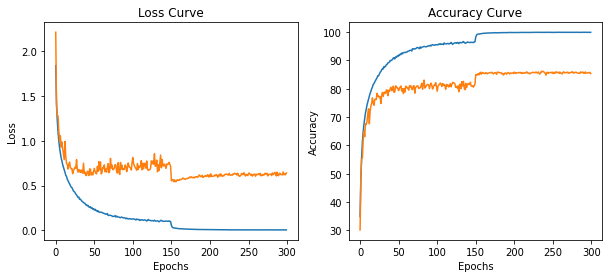

Final Training Accuracy: 99.936
Final Validation Accuracy: 85.34999989013671


000: Acc-tr:  98.63, Acc-val:  79.96, L-tr: 0.0420, L-val: 0.9526
000: Acc-tr:  98.63, Acc-val:  79.96, L-tr: 0.0420, L-val: 0.9526
000: Acc-tr:  98.63, Acc-val:  79.96, L-tr: 0.0420, L-val: 0.9526
000: Acc-tr:  98.63, Acc-val:  79.96, L-tr: 0.0420, L-val: 0.9526
000: Acc-tr:  98.63, Acc-val:  79.96, L-tr: 0.0420, L-val: 0.9526


Epoch 0 Finished.  Time per Epoch:  8705.26 s 


001: Acc-tr:  93.53, Acc-val:  75.36, L-tr: 0.1851, L-val: 1.0460
001: Acc-tr:  93.53, Acc-val:  75.36, L-tr: 0.1851, L-val: 1.0460
001: Acc-tr:  93.53, Acc-val:  75.36, L-tr: 0.1851, L-val: 1.0460
001: Acc-tr:  93.53, Acc-val:  75.36, L-tr: 0.1851, L-val: 1.0460
001: Acc-tr:  93.53, Acc-val:  75.36, L-tr: 0.1851, L-val: 1.0460


Epoch 1 Finished.  Time per Epoch:  4366.52 s 


002: Acc-tr:  94.27, Acc-val:  79.46, L-tr: 0.1613, L-val: 0.7936
002: Acc-tr:  94.27, Acc-val:  79.46, L-tr: 0.1613, L-val: 0.7936
002: Acc-tr:  94.27, Acc-val:  79.46, L-tr: 0.1613, L-val: 0.7936
002: Acc-tr:  94.27, Acc-val:  79.46, L-tr: 0.1613, L-val: 0.7936
002: Acc-tr:  94.27, Acc-val:  79.46, L-tr: 0.1613, L-val: 0.7936


Epoch 2 Finished.  Time per Epoch:  2920.23 s 


003: Acc-tr:  95.28, Acc-val:  81.39, L-tr: 0.1357, L-val: 0.7132
003: Acc-tr:  95.28, Acc-val:  81.39, L-tr: 0.1357, L-val: 0.7132
003: Acc-tr:  95.28, Acc-val:  81.39, L-tr: 0.1357, L-val: 0.7132
003: Acc-tr:  95.28, Acc-val:  81.39, L-tr: 0.1357, L-val: 0.7132
003: Acc-tr:  95.28, Acc-val:  81.39, L-tr: 0.1357, L-val: 0.7132


Epoch 3 Finished.  Time per Epoch:  2197.08 s 


004: Acc-tr:  95.59, Acc-val:  80.49, L-tr: 0.1270, L-val: 0.7589
004: Acc-tr:  95.59, Acc-val:  80.49, L-tr: 0.1270, L-val: 0.7589
004: Acc-tr:  95.59, Acc-val:  80.49, L-tr: 0.1270, L-val: 0.7589
004: Acc-tr:  95.59, Acc-val:  80.49, L-tr: 0.1270, L-val: 0.7589
004: Acc-tr:  95.59, Acc-val:  80.49, L-tr: 0.1270, L-val: 0.7589


Epoch 4 Finished.  Time per Epoch:  1763.13 s 


005: Acc-tr:  95.85, Acc-val:  81.20, L-tr: 0.1175, L-val: 0.6877
005: Acc-tr:  95.85, Acc-val:  81.20, L-tr: 0.1175, L-val: 0.6877
005: Acc-tr:  95.85, Acc-val:  81.20, L-tr: 0.1175, L-val: 0.6877
005: Acc-tr:  95.85, Acc-val:  81.20, L-tr: 0.1175, L-val: 0.6877
005: Acc-tr:  95.85, Acc-val:  81.20, L-tr: 0.1175, L-val: 0.6877


Epoch 5 Finished.  Time per Epoch:  1473.88 s 


006: Acc-tr:  95.91, Acc-val:  80.47, L-tr: 0.1131, L-val: 0.7899
006: Acc-tr:  95.91, Acc-val:  80.47, L-tr: 0.1131, L-val: 0.7899
006: Acc-tr:  95.91, Acc-val:  80.47, L-tr: 0.1131, L-val: 0.7899
006: Acc-tr:  95.91, Acc-val:  80.47, L-tr: 0.1131, L-val: 0.7899
006: Acc-tr:  95.91, Acc-val:  80.47, L-tr: 0.1131, L-val: 0.7899


Epoch 6 Finished.  Time per Epoch:  1267.25 s 


007: Acc-tr:  95.95, Acc-val:  81.28, L-tr: 0.1155, L-val: 0.6959
007: Acc-tr:  95.95, Acc-val:  81.28, L-tr: 0.1155, L-val: 0.6959
007: Acc-tr:  95.95, Acc-val:  81.28, L-tr: 0.1155, L-val: 0.6959
007: Acc-tr:  95.95, Acc-val:  81.28, L-tr: 0.1155, L-val: 0.6959
007: Acc-tr:  95.95, Acc-val:  81.28, L-tr: 0.1155, L-val: 0.6959


Epoch 7 Finished.  Time per Epoch:  1112.34 s 


008: Acc-tr:  96.47, Acc-val:  80.52, L-tr: 0.1035, L-val: 0.7771
008: Acc-tr:  96.47, Acc-val:  80.52, L-tr: 0.1035, L-val: 0.7771
008: Acc-tr:  96.47, Acc-val:  80.52, L-tr: 0.1035, L-val: 0.7771
008: Acc-tr:  96.47, Acc-val:  80.52, L-tr: 0.1035, L-val: 0.7771
008: Acc-tr:  96.47, Acc-val:  80.52, L-tr: 0.1035, L-val: 0.7771


Epoch 8 Finished.  Time per Epoch:  991.84 s 


009: Acc-tr:  96.02, Acc-val:  81.16, L-tr: 0.1137, L-val: 0.7483
009: Acc-tr:  96.02, Acc-val:  81.16, L-tr: 0.1137, L-val: 0.7483
009: Acc-tr:  96.02, Acc-val:  81.16, L-tr: 0.1137, L-val: 0.7483
009: Acc-tr:  96.02, Acc-val:  81.16, L-tr: 0.1137, L-val: 0.7483
009: Acc-tr:  96.02, Acc-val:  81.16, L-tr: 0.1137, L-val: 0.7483


Epoch 9 Finished.  Time per Epoch:  895.48 s 


010: Acc-tr:  96.24, Acc-val:  81.66, L-tr: 0.1084, L-val: 0.6841
010: Acc-tr:  96.24, Acc-val:  81.66, L-tr: 0.1084, L-val: 0.6841
010: Acc-tr:  96.24, Acc-val:  81.66, L-tr: 0.1084, L-val: 0.6841
010: Acc-tr:  96.24, Acc-val:  81.66, L-tr: 0.1084, L-val: 0.6841
010: Acc-tr:  96.24, Acc-val:  81.66, L-tr: 0.1084, L-val: 0.6841


Epoch 10 Finished.  Time per Epoch:  816.62 s 


011: Acc-tr:  96.39, Acc-val:  79.43, L-tr: 0.1041, L-val: 0.8179
011: Acc-tr:  96.39, Acc-val:  79.43, L-tr: 0.1041, L-val: 0.8179
011: Acc-tr:  96.39, Acc-val:  79.43, L-tr: 0.1041, L-val: 0.8179
011: Acc-tr:  96.39, Acc-val:  79.43, L-tr: 0.1041, L-val: 0.8179
011: Acc-tr:  96.39, Acc-val:  79.43, L-tr: 0.1041, L-val: 0.8179


Epoch 11 Finished.  Time per Epoch:  750.89 s 


012: Acc-tr:  95.91, Acc-val:  79.92, L-tr: 0.1157, L-val: 0.7853
012: Acc-tr:  95.91, Acc-val:  79.92, L-tr: 0.1157, L-val: 0.7853
012: Acc-tr:  95.91, Acc-val:  79.92, L-tr: 0.1157, L-val: 0.7853
012: Acc-tr:  95.91, Acc-val:  79.92, L-tr: 0.1157, L-val: 0.7853
012: Acc-tr:  95.91, Acc-val:  79.92, L-tr: 0.1157, L-val: 0.7853


Epoch 12 Finished.  Time per Epoch:  695.27 s 


013: Acc-tr:  96.19, Acc-val:  81.57, L-tr: 0.1096, L-val: 0.6811
013: Acc-tr:  96.19, Acc-val:  81.57, L-tr: 0.1096, L-val: 0.6811
013: Acc-tr:  96.19, Acc-val:  81.57, L-tr: 0.1096, L-val: 0.6811
013: Acc-tr:  96.19, Acc-val:  81.57, L-tr: 0.1096, L-val: 0.6811
013: Acc-tr:  96.19, Acc-val:  81.57, L-tr: 0.1096, L-val: 0.6811


Epoch 13 Finished.  Time per Epoch:  647.57 s 


014: Acc-tr:  96.13, Acc-val:  80.04, L-tr: 0.1090, L-val: 0.7888
014: Acc-tr:  96.13, Acc-val:  80.04, L-tr: 0.1090, L-val: 0.7888
014: Acc-tr:  96.13, Acc-val:  80.04, L-tr: 0.1090, L-val: 0.7888
014: Acc-tr:  96.13, Acc-val:  80.04, L-tr: 0.1090, L-val: 0.7888
014: Acc-tr:  96.13, Acc-val:  80.04, L-tr: 0.1090, L-val: 0.7888


Epoch 14 Finished.  Time per Epoch:  606.23 s 


015: Acc-tr:  96.41, Acc-val:  80.69, L-tr: 0.1024, L-val: 0.7464
015: Acc-tr:  96.41, Acc-val:  80.69, L-tr: 0.1024, L-val: 0.7464
015: Acc-tr:  96.41, Acc-val:  80.69, L-tr: 0.1024, L-val: 0.7464
015: Acc-tr:  96.41, Acc-val:  80.69, L-tr: 0.1024, L-val: 0.7464
015: Acc-tr:  96.41, Acc-val:  80.69, L-tr: 0.1024, L-val: 0.7464


Epoch 15 Finished.  Time per Epoch:  570.05 s 


016: Acc-tr:  96.36, Acc-val:  80.49, L-tr: 0.1062, L-val: 0.7743
016: Acc-tr:  96.36, Acc-val:  80.49, L-tr: 0.1062, L-val: 0.7743
016: Acc-tr:  96.36, Acc-val:  80.49, L-tr: 0.1062, L-val: 0.7743
016: Acc-tr:  96.36, Acc-val:  80.49, L-tr: 0.1062, L-val: 0.7743
016: Acc-tr:  96.36, Acc-val:  80.49, L-tr: 0.1062, L-val: 0.7743


Epoch 16 Finished.  Time per Epoch:  538.16 s 


017: Acc-tr:  96.09, Acc-val:  80.97, L-tr: 0.1091, L-val: 0.7350
017: Acc-tr:  96.09, Acc-val:  80.97, L-tr: 0.1091, L-val: 0.7350
017: Acc-tr:  96.09, Acc-val:  80.97, L-tr: 0.1091, L-val: 0.7350
017: Acc-tr:  96.09, Acc-val:  80.97, L-tr: 0.1091, L-val: 0.7350
017: Acc-tr:  96.09, Acc-val:  80.97, L-tr: 0.1091, L-val: 0.7350


Epoch 17 Finished.  Time per Epoch:  509.78 s 


018: Acc-tr:  96.14, Acc-val:  81.11, L-tr: 0.1101, L-val: 0.6968
018: Acc-tr:  96.14, Acc-val:  81.11, L-tr: 0.1101, L-val: 0.6968
018: Acc-tr:  96.14, Acc-val:  81.11, L-tr: 0.1101, L-val: 0.6968
018: Acc-tr:  96.14, Acc-val:  81.11, L-tr: 0.1101, L-val: 0.6968
018: Acc-tr:  96.14, Acc-val:  81.11, L-tr: 0.1101, L-val: 0.6968


Epoch 18 Finished.  Time per Epoch:  484.37 s 


019: Acc-tr:  96.40, Acc-val:  81.31, L-tr: 0.1042, L-val: 0.7256
019: Acc-tr:  96.40, Acc-val:  81.31, L-tr: 0.1042, L-val: 0.7256
019: Acc-tr:  96.40, Acc-val:  81.31, L-tr: 0.1042, L-val: 0.7256
019: Acc-tr:  96.40, Acc-val:  81.31, L-tr: 0.1042, L-val: 0.7256
019: Acc-tr:  96.40, Acc-val:  81.31, L-tr: 0.1042, L-val: 0.7256


Epoch 19 Finished.  Time per Epoch:  461.50 s 


020: Acc-tr:  96.46, Acc-val:  80.65, L-tr: 0.1017, L-val: 0.7592
020: Acc-tr:  96.46, Acc-val:  80.65, L-tr: 0.1017, L-val: 0.7592
020: Acc-tr:  96.46, Acc-val:  80.65, L-tr: 0.1017, L-val: 0.7592
020: Acc-tr:  96.46, Acc-val:  80.65, L-tr: 0.1017, L-val: 0.7592
020: Acc-tr:  96.46, Acc-val:  80.65, L-tr: 0.1017, L-val: 0.7592


Epoch 20 Finished.  Time per Epoch:  440.83 s 


021: Acc-tr:  96.42, Acc-val:  80.38, L-tr: 0.1010, L-val: 0.7693
021: Acc-tr:  96.42, Acc-val:  80.38, L-tr: 0.1010, L-val: 0.7693
021: Acc-tr:  96.42, Acc-val:  80.38, L-tr: 0.1010, L-val: 0.7693
021: Acc-tr:  96.42, Acc-val:  80.38, L-tr: 0.1010, L-val: 0.7693
021: Acc-tr:  96.42, Acc-val:  80.38, L-tr: 0.1010, L-val: 0.7693


Epoch 21 Finished.  Time per Epoch:  422.03 s 


022: Acc-tr:  96.42, Acc-val:  80.67, L-tr: 0.1025, L-val: 0.7252
022: Acc-tr:  96.42, Acc-val:  80.67, L-tr: 0.1025, L-val: 0.7252
022: Acc-tr:  96.42, Acc-val:  80.67, L-tr: 0.1025, L-val: 0.7252
022: Acc-tr:  96.42, Acc-val:  80.67, L-tr: 0.1025, L-val: 0.7252
022: Acc-tr:  96.42, Acc-val:  80.67, L-tr: 0.1025, L-val: 0.7252


Epoch 22 Finished.  Time per Epoch:  404.85 s 


023: Acc-tr:  96.23, Acc-val:  80.60, L-tr: 0.1070, L-val: 0.7664
023: Acc-tr:  96.23, Acc-val:  80.60, L-tr: 0.1070, L-val: 0.7664
023: Acc-tr:  96.23, Acc-val:  80.60, L-tr: 0.1070, L-val: 0.7664
023: Acc-tr:  96.23, Acc-val:  80.60, L-tr: 0.1070, L-val: 0.7664
023: Acc-tr:  96.23, Acc-val:  80.60, L-tr: 0.1070, L-val: 0.7664


Epoch 23 Finished.  Time per Epoch:  389.12 s 


024: Acc-tr:  96.48, Acc-val:  81.94, L-tr: 0.1019, L-val: 0.6914
024: Acc-tr:  96.48, Acc-val:  81.94, L-tr: 0.1019, L-val: 0.6914
024: Acc-tr:  96.48, Acc-val:  81.94, L-tr: 0.1019, L-val: 0.6914
024: Acc-tr:  96.48, Acc-val:  81.94, L-tr: 0.1019, L-val: 0.6914
024: Acc-tr:  96.48, Acc-val:  81.94, L-tr: 0.1019, L-val: 0.6914


Epoch 24 Finished.  Time per Epoch:  374.64 s 


025: Acc-tr:  96.75, Acc-val:  81.23, L-tr: 0.0943, L-val: 0.7443
025: Acc-tr:  96.75, Acc-val:  81.23, L-tr: 0.0943, L-val: 0.7443
025: Acc-tr:  96.75, Acc-val:  81.23, L-tr: 0.0943, L-val: 0.7443
025: Acc-tr:  96.75, Acc-val:  81.23, L-tr: 0.0943, L-val: 0.7443
025: Acc-tr:  96.75, Acc-val:  81.23, L-tr: 0.0943, L-val: 0.7443


Epoch 25 Finished.  Time per Epoch:  361.27 s 


KeyboardInterrupt: ignored

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomRotation)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomRotation)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_RandomRotation"

main("Inception",'inception','train', directory, 300)

##Random Erasing

In [ ]:
transform_RandomErasing = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomErasing(),
    myNormalize()
    ])


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception...


Number of parameters: 1733466
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  38.41, Acc-val:  39.55, L-tr: 1.6940, L-val: 1.8065


Epoch 0 Finished.  Time per Epoch:  24.97 s 


001: Acc-tr:  58.81, Acc-val:  59.78, L-tr: 1.1454, L-val: 1.1483


Epoch 1 Finished.  Time per Epoch:  23.58 s 


002: Acc-tr:  66.97, Acc-val:  62.54, L-tr: 0.9205, L-val: 1.0832


Epoch 2 Finished.  Time per Epoch:  23.26 s 


003: Acc-tr:  72.28, Acc-val:  69.76, L-tr: 0.7902, L-val: 0.8655


Epoch 3 Finished.  Time per Epoch:  23.05 s 


004: Acc-tr:  75.63, Acc-val:  71.41, L-tr: 0.6900, L-val: 0.8287


Epoch 4 Finished.  Time per Epoch:  22.96 s 


005: Acc-tr:  78.18, Acc-val:  71.85, L-tr: 0.6154, L-val: 0.8385


Epoch 5 Finished.  Time per Epoch:  22.88 s 


006: Acc-tr:  80.00, Acc-val:  73.37, L-tr: 0.5659, L-val: 0.7782


Epoch 6 Finished.  Time per Epoch:  22.83 s 


007: Acc-tr:  82.11, Acc-val:  72.50, L-tr: 0.5094, L-val: 0.8329


Epoch 7 Finished.  Time per Epoch:  22.76 s 


008: Acc-tr:  83.48, Acc-val:  75.57, L-tr: 0.4727, L-val: 0.7556


Epoch 8 Finished.  Time per Epoch:  22.71 s 


009: Acc-tr:  84.86, Acc-val:  78.05, L-tr: 0.4279, L-val: 0.6410


Epoch 9 Finished.  Time per Epoch:  22.67 s 


010: Acc-tr:  86.21, Acc-val:  79.39, L-tr: 0.3947, L-val: 0.6124


Epoch 10 Finished.  Time per Epoch:  22.66 s 


011: Acc-tr:  87.43, Acc-val:  76.18, L-tr: 0.3554, L-val: 0.7393


Epoch 11 Finished.  Time per Epoch:  22.67 s 


012: Acc-tr:  88.32, Acc-val:  70.65, L-tr: 0.3295, L-val: 0.9790


Epoch 12 Finished.  Time per Epoch:  22.66 s 


013: Acc-tr:  88.75, Acc-val:  77.19, L-tr: 0.3177, L-val: 0.7281


Epoch 13 Finished.  Time per Epoch:  22.64 s 


014: Acc-tr:  89.92, Acc-val:  76.45, L-tr: 0.2838, L-val: 0.7731


Epoch 14 Finished.  Time per Epoch:  22.66 s 


015: Acc-tr:  90.80, Acc-val:  77.83, L-tr: 0.2612, L-val: 0.7980


Epoch 15 Finished.  Time per Epoch:  22.63 s 


016: Acc-tr:  91.03, Acc-val:  80.88, L-tr: 0.2505, L-val: 0.6217


Epoch 16 Finished.  Time per Epoch:  22.62 s 


017: Acc-tr:  92.23, Acc-val:  77.59, L-tr: 0.2223, L-val: 0.7834


Epoch 17 Finished.  Time per Epoch:  22.62 s 


018: Acc-tr:  92.53, Acc-val:  79.84, L-tr: 0.2101, L-val: 0.7142


Epoch 18 Finished.  Time per Epoch:  22.63 s 


019: Acc-tr:  92.94, Acc-val:  79.88, L-tr: 0.2006, L-val: 0.6724


Epoch 19 Finished.  Time per Epoch:  22.60 s 


020: Acc-tr:  93.25, Acc-val:  78.00, L-tr: 0.1904, L-val: 0.8058


Epoch 20 Finished.  Time per Epoch:  22.60 s 


021: Acc-tr:  93.42, Acc-val:  79.36, L-tr: 0.1847, L-val: 0.8412


Epoch 21 Finished.  Time per Epoch:  22.60 s 


022: Acc-tr:  94.22, Acc-val:  80.67, L-tr: 0.1659, L-val: 0.6975


Epoch 22 Finished.  Time per Epoch:  22.59 s 


023: Acc-tr:  94.57, Acc-val:  80.67, L-tr: 0.1564, L-val: 0.6977


Epoch 23 Finished.  Time per Epoch:  22.59 s 


024: Acc-tr:  94.54, Acc-val:  80.26, L-tr: 0.1581, L-val: 0.7597


Epoch 24 Finished.  Time per Epoch:  22.59 s 


025: Acc-tr:  94.82, Acc-val:  81.01, L-tr: 0.1469, L-val: 0.7313


Epoch 25 Finished.  Time per Epoch:  22.60 s 


026: Acc-tr:  95.21, Acc-val:  81.62, L-tr: 0.1378, L-val: 0.7606


Epoch 26 Finished.  Time per Epoch:  22.59 s 


027: Acc-tr:  95.08, Acc-val:  79.01, L-tr: 0.1390, L-val: 0.7915


Epoch 27 Finished.  Time per Epoch:  22.60 s 


028: Acc-tr:  95.22, Acc-val:  82.34, L-tr: 0.1356, L-val: 0.6549


Epoch 28 Finished.  Time per Epoch:  22.61 s 


029: Acc-tr:  95.72, Acc-val:  79.33, L-tr: 0.1239, L-val: 0.7832


Epoch 29 Finished.  Time per Epoch:  22.61 s 


030: Acc-tr:  95.62, Acc-val:  79.87, L-tr: 0.1249, L-val: 0.8230


Epoch 30 Finished.  Time per Epoch:  22.62 s 


031: Acc-tr:  95.73, Acc-val:  81.26, L-tr: 0.1218, L-val: 0.7644


Epoch 31 Finished.  Time per Epoch:  22.62 s 


032: Acc-tr:  95.88, Acc-val:  80.48, L-tr: 0.1180, L-val: 0.8183


Epoch 32 Finished.  Time per Epoch:  22.61 s 


033: Acc-tr:  96.10, Acc-val:  82.83, L-tr: 0.1143, L-val: 0.6208


Epoch 33 Finished.  Time per Epoch:  22.61 s 


034: Acc-tr:  96.19, Acc-val:  80.99, L-tr: 0.1110, L-val: 0.7190


Epoch 34 Finished.  Time per Epoch:  22.62 s 


035: Acc-tr:  96.06, Acc-val:  80.14, L-tr: 0.1126, L-val: 0.7909


Epoch 35 Finished.  Time per Epoch:  22.63 s 


036: Acc-tr:  96.26, Acc-val:  81.36, L-tr: 0.1092, L-val: 0.7047


Epoch 36 Finished.  Time per Epoch:  22.63 s 


037: Acc-tr:  96.29, Acc-val:  81.09, L-tr: 0.1067, L-val: 0.7318


Epoch 37 Finished.  Time per Epoch:  22.64 s 


038: Acc-tr:  96.47, Acc-val:  80.51, L-tr: 0.1034, L-val: 0.8051


Epoch 38 Finished.  Time per Epoch:  22.64 s 


039: Acc-tr:  96.35, Acc-val:  80.61, L-tr: 0.1028, L-val: 0.7615


Epoch 39 Finished.  Time per Epoch:  22.64 s 


040: Acc-tr:  96.57, Acc-val:  81.17, L-tr: 0.1004, L-val: 0.7423


Epoch 40 Finished.  Time per Epoch:  22.64 s 


041: Acc-tr:  96.53, Acc-val:  79.09, L-tr: 0.1006, L-val: 0.8842


Epoch 41 Finished.  Time per Epoch:  22.64 s 


042: Acc-tr:  96.62, Acc-val:  81.97, L-tr: 0.0973, L-val: 0.7283


Epoch 42 Finished.  Time per Epoch:  22.64 s 


043: Acc-tr:  96.75, Acc-val:  75.38, L-tr: 0.0939, L-val: 0.9994


Epoch 43 Finished.  Time per Epoch:  22.65 s 


044: Acc-tr:  96.89, Acc-val:  82.42, L-tr: 0.0905, L-val: 0.7069


Epoch 44 Finished.  Time per Epoch:  22.65 s 


045: Acc-tr:  96.86, Acc-val:  82.94, L-tr: 0.0919, L-val: 0.6581


Epoch 45 Finished.  Time per Epoch:  22.66 s 


046: Acc-tr:  96.98, Acc-val:  81.97, L-tr: 0.0880, L-val: 0.7076


Epoch 46 Finished.  Time per Epoch:  22.66 s 


047: Acc-tr:  96.92, Acc-val:  80.92, L-tr: 0.0895, L-val: 0.7858


Epoch 47 Finished.  Time per Epoch:  22.66 s 


048: Acc-tr:  96.99, Acc-val:  81.81, L-tr: 0.0878, L-val: 0.7173


Epoch 48 Finished.  Time per Epoch:  22.66 s 


049: Acc-tr:  97.03, Acc-val:  81.53, L-tr: 0.0859, L-val: 0.7403


Epoch 49 Finished.  Time per Epoch:  22.67 s 


050: Acc-tr:  97.17, Acc-val:  83.09, L-tr: 0.0806, L-val: 0.6928


Epoch 50 Finished.  Time per Epoch:  22.67 s 


051: Acc-tr:  97.18, Acc-val:  83.46, L-tr: 0.0830, L-val: 0.7081


Epoch 51 Finished.  Time per Epoch:  22.66 s 


052: Acc-tr:  96.98, Acc-val:  80.73, L-tr: 0.0869, L-val: 0.7452


Epoch 52 Finished.  Time per Epoch:  22.66 s 


053: Acc-tr:  97.21, Acc-val:  81.22, L-tr: 0.0790, L-val: 0.7409


Epoch 53 Finished.  Time per Epoch:  22.67 s 


054: Acc-tr:  96.89, Acc-val:  81.05, L-tr: 0.0877, L-val: 0.8099


Epoch 54 Finished.  Time per Epoch:  22.67 s 


055: Acc-tr:  97.08, Acc-val:  83.13, L-tr: 0.0832, L-val: 0.6745


Epoch 55 Finished.  Time per Epoch:  22.67 s 


056: Acc-tr:  97.22, Acc-val:  81.26, L-tr: 0.0791, L-val: 0.8552


Epoch 56 Finished.  Time per Epoch:  22.68 s 


057: Acc-tr:  97.19, Acc-val:  82.27, L-tr: 0.0820, L-val: 0.7289


Epoch 57 Finished.  Time per Epoch:  22.68 s 


058: Acc-tr:  97.20, Acc-val:  81.41, L-tr: 0.0810, L-val: 0.7607


Epoch 58 Finished.  Time per Epoch:  22.68 s 


059: Acc-tr:  97.38, Acc-val:  82.47, L-tr: 0.0782, L-val: 0.7261


Epoch 59 Finished.  Time per Epoch:  22.68 s 


060: Acc-tr:  97.48, Acc-val:  82.21, L-tr: 0.0733, L-val: 0.7735


Epoch 60 Finished.  Time per Epoch:  22.68 s 


061: Acc-tr:  97.35, Acc-val:  82.06, L-tr: 0.0740, L-val: 0.7283


Epoch 61 Finished.  Time per Epoch:  22.68 s 


062: Acc-tr:  97.48, Acc-val:  83.00, L-tr: 0.0734, L-val: 0.7311


Epoch 62 Finished.  Time per Epoch:  22.68 s 


063: Acc-tr:  97.40, Acc-val:  80.53, L-tr: 0.0757, L-val: 0.8494


Epoch 63 Finished.  Time per Epoch:  22.68 s 


064: Acc-tr:  97.43, Acc-val:  82.42, L-tr: 0.0755, L-val: 0.7056


Epoch 64 Finished.  Time per Epoch:  22.68 s 


065: Acc-tr:  97.49, Acc-val:  82.96, L-tr: 0.0728, L-val: 0.7123


Epoch 65 Finished.  Time per Epoch:  22.69 s 


066: Acc-tr:  97.35, Acc-val:  81.13, L-tr: 0.0749, L-val: 0.7725


Epoch 66 Finished.  Time per Epoch:  22.69 s 


067: Acc-tr:  97.41, Acc-val:  82.21, L-tr: 0.0757, L-val: 0.7931


Epoch 67 Finished.  Time per Epoch:  22.69 s 


068: Acc-tr:  97.44, Acc-val:  81.33, L-tr: 0.0732, L-val: 0.7610


Epoch 68 Finished.  Time per Epoch:  22.68 s 


069: Acc-tr:  97.52, Acc-val:  82.75, L-tr: 0.0735, L-val: 0.6978


Epoch 69 Finished.  Time per Epoch:  22.68 s 


070: Acc-tr:  97.63, Acc-val:  80.68, L-tr: 0.0682, L-val: 0.8224


Epoch 70 Finished.  Time per Epoch:  22.68 s 


071: Acc-tr:  97.34, Acc-val:  81.76, L-tr: 0.0753, L-val: 0.7256


Epoch 71 Finished.  Time per Epoch:  22.68 s 


072: Acc-tr:  97.47, Acc-val:  83.51, L-tr: 0.0719, L-val: 0.6823


Epoch 72 Finished.  Time per Epoch:  22.68 s 


073: Acc-tr:  97.69, Acc-val:  82.33, L-tr: 0.0665, L-val: 0.7045


Epoch 73 Finished.  Time per Epoch:  22.68 s 


074: Acc-tr:  97.69, Acc-val:  83.33, L-tr: 0.0684, L-val: 0.6736


Epoch 74 Finished.  Time per Epoch:  22.68 s 


075: Acc-tr:  97.73, Acc-val:  81.53, L-tr: 0.0669, L-val: 0.7782


Epoch 75 Finished.  Time per Epoch:  22.68 s 


076: Acc-tr:  97.41, Acc-val:  82.32, L-tr: 0.0747, L-val: 0.7216


Epoch 76 Finished.  Time per Epoch:  22.68 s 


077: Acc-tr:  97.39, Acc-val:  82.47, L-tr: 0.0744, L-val: 0.7033


Epoch 77 Finished.  Time per Epoch:  22.68 s 


078: Acc-tr:  97.67, Acc-val:  82.14, L-tr: 0.0674, L-val: 0.7759


Epoch 78 Finished.  Time per Epoch:  22.68 s 


079: Acc-tr:  97.67, Acc-val:  81.45, L-tr: 0.0686, L-val: 0.7600


Epoch 79 Finished.  Time per Epoch:  22.67 s 


080: Acc-tr:  97.50, Acc-val:  80.54, L-tr: 0.0730, L-val: 0.8427


Epoch 80 Finished.  Time per Epoch:  22.67 s 


081: Acc-tr:  97.76, Acc-val:  82.53, L-tr: 0.0647, L-val: 0.7183


Epoch 81 Finished.  Time per Epoch:  22.67 s 


082: Acc-tr:  97.76, Acc-val:  81.06, L-tr: 0.0662, L-val: 0.8979


Epoch 82 Finished.  Time per Epoch:  22.66 s 


083: Acc-tr:  97.69, Acc-val:  79.73, L-tr: 0.0669, L-val: 0.9464


Epoch 83 Finished.  Time per Epoch:  22.66 s 


084: Acc-tr:  97.62, Acc-val:  82.26, L-tr: 0.0692, L-val: 0.7629


Epoch 84 Finished.  Time per Epoch:  22.66 s 


085: Acc-tr:  97.87, Acc-val:  82.89, L-tr: 0.0632, L-val: 0.7007


Epoch 85 Finished.  Time per Epoch:  22.66 s 


086: Acc-tr:  97.73, Acc-val:  83.09, L-tr: 0.0662, L-val: 0.6562


Epoch 86 Finished.  Time per Epoch:  22.65 s 


087: Acc-tr:  97.66, Acc-val:  80.81, L-tr: 0.0678, L-val: 0.8223


Epoch 87 Finished.  Time per Epoch:  22.65 s 


088: Acc-tr:  97.84, Acc-val:  78.00, L-tr: 0.0629, L-val: 1.0433


Epoch 88 Finished.  Time per Epoch:  22.65 s 


089: Acc-tr:  97.76, Acc-val:  81.38, L-tr: 0.0646, L-val: 0.7521


Epoch 89 Finished.  Time per Epoch:  22.65 s 


090: Acc-tr:  97.74, Acc-val:  80.71, L-tr: 0.0659, L-val: 0.8614


Epoch 90 Finished.  Time per Epoch:  22.65 s 


091: Acc-tr:  97.79, Acc-val:  82.48, L-tr: 0.0659, L-val: 0.7464


Epoch 91 Finished.  Time per Epoch:  22.65 s 


092: Acc-tr:  97.89, Acc-val:  82.53, L-tr: 0.0628, L-val: 0.7015


Epoch 92 Finished.  Time per Epoch:  22.64 s 


093: Acc-tr:  97.71, Acc-val:  82.70, L-tr: 0.0661, L-val: 0.6888


Epoch 93 Finished.  Time per Epoch:  22.64 s 


094: Acc-tr:  97.76, Acc-val:  82.56, L-tr: 0.0648, L-val: 0.7688


Epoch 94 Finished.  Time per Epoch:  22.64 s 


095: Acc-tr:  97.83, Acc-val:  82.32, L-tr: 0.0626, L-val: 0.7689


Epoch 95 Finished.  Time per Epoch:  22.64 s 


096: Acc-tr:  97.71, Acc-val:  81.68, L-tr: 0.0668, L-val: 0.7975


Epoch 96 Finished.  Time per Epoch:  22.64 s 


097: Acc-tr:  97.92, Acc-val:  82.66, L-tr: 0.0604, L-val: 0.7643


Epoch 97 Finished.  Time per Epoch:  22.64 s 


098: Acc-tr:  97.95, Acc-val:  83.64, L-tr: 0.0608, L-val: 0.6781


Epoch 98 Finished.  Time per Epoch:  22.64 s 


099: Acc-tr:  97.78, Acc-val:  81.50, L-tr: 0.0636, L-val: 0.7628


Epoch 99 Finished.  Time per Epoch:  22.63 s 


100: Acc-tr:  97.96, Acc-val:  81.05, L-tr: 0.0608, L-val: 0.8225


Epoch 100 Finished.  Time per Epoch:  22.63 s 
Epoch 101 Finished.  Time per Epoch:  22.63 s 


102: Acc-tr:  97.90, Acc-val:  80.39, L-tr: 0.0614, L-val: 0.9335


Epoch 102 Finished.  Time per Epoch:  22.63 s 


103: Acc-tr:  97.89, Acc-val:  81.95, L-tr: 0.0626, L-val: 0.7718


Epoch 103 Finished.  Time per Epoch:  22.63 s 


104: Acc-tr:  97.86, Acc-val:  82.95, L-tr: 0.0618, L-val: 0.7352


Epoch 104 Finished.  Time per Epoch:  22.63 s 


105: Acc-tr:  97.89, Acc-val:  82.73, L-tr: 0.0616, L-val: 0.7155


Epoch 105 Finished.  Time per Epoch:  22.62 s 


106: Acc-tr:  97.79, Acc-val:  79.88, L-tr: 0.0636, L-val: 0.9664


Epoch 106 Finished.  Time per Epoch:  22.62 s 


107: Acc-tr:  97.91, Acc-val:  82.81, L-tr: 0.0609, L-val: 0.7375


Epoch 107 Finished.  Time per Epoch:  22.62 s 


108: Acc-tr:  97.94, Acc-val:  82.23, L-tr: 0.0610, L-val: 0.7293


Epoch 108 Finished.  Time per Epoch:  22.62 s 


109: Acc-tr:  97.79, Acc-val:  82.12, L-tr: 0.0632, L-val: 0.7917


Epoch 109 Finished.  Time per Epoch:  22.62 s 


110: Acc-tr:  97.83, Acc-val:  83.27, L-tr: 0.0630, L-val: 0.7272


Epoch 110 Finished.  Time per Epoch:  22.62 s 


111: Acc-tr:  97.84, Acc-val:  82.77, L-tr: 0.0610, L-val: 0.7170


Epoch 111 Finished.  Time per Epoch:  22.62 s 


112: Acc-tr:  97.78, Acc-val:  82.84, L-tr: 0.0648, L-val: 0.6904


Epoch 112 Finished.  Time per Epoch:  22.62 s 


113: Acc-tr:  97.92, Acc-val:  80.42, L-tr: 0.0599, L-val: 0.7949


Epoch 113 Finished.  Time per Epoch:  22.62 s 


114: Acc-tr:  97.72, Acc-val:  82.48, L-tr: 0.0665, L-val: 0.7018


Epoch 114 Finished.  Time per Epoch:  22.62 s 


115: Acc-tr:  97.99, Acc-val:  82.64, L-tr: 0.0596, L-val: 0.6610


Epoch 115 Finished.  Time per Epoch:  22.61 s 


116: Acc-tr:  98.02, Acc-val:  82.43, L-tr: 0.0586, L-val: 0.7129


Epoch 116 Finished.  Time per Epoch:  22.61 s 


117: Acc-tr:  97.99, Acc-val:  82.82, L-tr: 0.0609, L-val: 0.6755


Epoch 117 Finished.  Time per Epoch:  22.61 s 


118: Acc-tr:  98.08, Acc-val:  83.94, L-tr: 0.0568, L-val: 0.6469


Epoch 118 Finished.  Time per Epoch:  22.61 s 


119: Acc-tr:  98.05, Acc-val:  81.19, L-tr: 0.0572, L-val: 0.8479


Epoch 119 Finished.  Time per Epoch:  22.60 s 


120: Acc-tr:  97.76, Acc-val:  82.30, L-tr: 0.0649, L-val: 0.7215


Epoch 120 Finished.  Time per Epoch:  22.60 s 


121: Acc-tr:  98.00, Acc-val:  82.10, L-tr: 0.0583, L-val: 0.7668


Epoch 121 Finished.  Time per Epoch:  22.60 s 


122: Acc-tr:  97.95, Acc-val:  81.69, L-tr: 0.0589, L-val: 0.8189


Epoch 122 Finished.  Time per Epoch:  22.60 s 


123: Acc-tr:  97.96, Acc-val:  81.92, L-tr: 0.0617, L-val: 0.7764


Epoch 123 Finished.  Time per Epoch:  22.60 s 


124: Acc-tr:  97.95, Acc-val:  82.81, L-tr: 0.0596, L-val: 0.7090


Epoch 124 Finished.  Time per Epoch:  22.60 s 


125: Acc-tr:  97.93, Acc-val:  82.43, L-tr: 0.0594, L-val: 0.7624


Epoch 125 Finished.  Time per Epoch:  22.60 s 


126: Acc-tr:  98.08, Acc-val:  81.74, L-tr: 0.0564, L-val: 0.7767


Epoch 126 Finished.  Time per Epoch:  22.60 s 


127: Acc-tr:  98.00, Acc-val:  82.43, L-tr: 0.0589, L-val: 0.6864


Epoch 127 Finished.  Time per Epoch:  22.59 s 


128: Acc-tr:  98.06, Acc-val:  78.99, L-tr: 0.0569, L-val: 0.9044


Epoch 128 Finished.  Time per Epoch:  22.59 s 


129: Acc-tr:  97.99, Acc-val:  79.85, L-tr: 0.0585, L-val: 0.8929


Epoch 129 Finished.  Time per Epoch:  22.59 s 


130: Acc-tr:  97.98, Acc-val:  81.82, L-tr: 0.0578, L-val: 0.7567


Epoch 130 Finished.  Time per Epoch:  22.59 s 


131: Acc-tr:  97.85, Acc-val:  81.47, L-tr: 0.0612, L-val: 0.7702


Epoch 131 Finished.  Time per Epoch:  22.59 s 


132: Acc-tr:  97.92, Acc-val:  81.55, L-tr: 0.0580, L-val: 0.7958


Epoch 132 Finished.  Time per Epoch:  22.59 s 


133: Acc-tr:  98.02, Acc-val:  79.07, L-tr: 0.0580, L-val: 0.9136


Epoch 133 Finished.  Time per Epoch:  22.59 s 


134: Acc-tr:  97.84, Acc-val:  82.98, L-tr: 0.0634, L-val: 0.6835


Epoch 134 Finished.  Time per Epoch:  22.58 s 


135: Acc-tr:  98.09, Acc-val:  81.22, L-tr: 0.0540, L-val: 0.8359


Epoch 135 Finished.  Time per Epoch:  22.58 s 


136: Acc-tr:  97.97, Acc-val:  82.24, L-tr: 0.0588, L-val: 0.7675


Epoch 136 Finished.  Time per Epoch:  22.58 s 


137: Acc-tr:  98.06, Acc-val:  79.79, L-tr: 0.0570, L-val: 0.8848


Epoch 137 Finished.  Time per Epoch:  22.58 s 


138: Acc-tr:  97.98, Acc-val:  82.49, L-tr: 0.0585, L-val: 0.7083


Epoch 138 Finished.  Time per Epoch:  22.58 s 


139: Acc-tr:  97.82, Acc-val:  80.37, L-tr: 0.0629, L-val: 0.9029


Epoch 139 Finished.  Time per Epoch:  22.58 s 


140: Acc-tr:  98.13, Acc-val:  82.97, L-tr: 0.0551, L-val: 0.7032


Epoch 140 Finished.  Time per Epoch:  22.58 s 


141: Acc-tr:  98.06, Acc-val:  80.58, L-tr: 0.0564, L-val: 0.8065


Epoch 141 Finished.  Time per Epoch:  22.58 s 


142: Acc-tr:  98.10, Acc-val:  81.98, L-tr: 0.0562, L-val: 0.8040


Epoch 142 Finished.  Time per Epoch:  22.58 s 


143: Acc-tr:  98.11, Acc-val:  82.72, L-tr: 0.0540, L-val: 0.6919


Epoch 143 Finished.  Time per Epoch:  22.58 s 


144: Acc-tr:  98.10, Acc-val:  81.47, L-tr: 0.0553, L-val: 0.7418


Epoch 144 Finished.  Time per Epoch:  22.57 s 


145: Acc-tr:  98.11, Acc-val:  81.71, L-tr: 0.0543, L-val: 0.7898


Epoch 145 Finished.  Time per Epoch:  22.57 s 


146: Acc-tr:  97.91, Acc-val:  81.41, L-tr: 0.0605, L-val: 0.8513


Epoch 146 Finished.  Time per Epoch:  22.57 s 


147: Acc-tr:  97.88, Acc-val:  81.36, L-tr: 0.0626, L-val: 0.7791


Epoch 147 Finished.  Time per Epoch:  22.57 s 


148: Acc-tr:  98.08, Acc-val:  77.73, L-tr: 0.0564, L-val: 1.0194


Epoch 148 Finished.  Time per Epoch:  22.57 s 


149: Acc-tr:  98.13, Acc-val:  81.09, L-tr: 0.0559, L-val: 0.7726


Epoch 149 Finished.  Time per Epoch:  22.57 s 


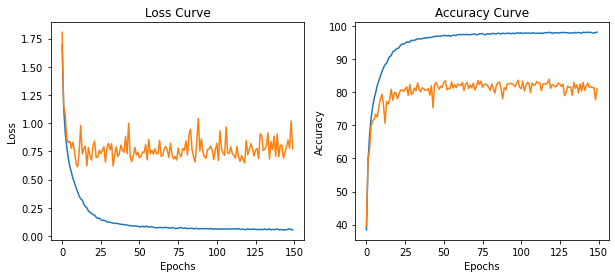

Final Training Accuracy: 98.13399998291015
Final Validation Accuracy: 81.09000001220703


000: Acc-tr:  98.04, Acc-val:  80.91, L-tr: 0.0567, L-val: 0.8570


Epoch 0 Finished.  Time per Epoch:  3408.21 s 


001: Acc-tr:  98.07, Acc-val:  81.96, L-tr: 0.0552, L-val: 0.7849


Epoch 1 Finished.  Time per Epoch:  1715.30 s 


002: Acc-tr:  98.05, Acc-val:  83.89, L-tr: 0.0554, L-val: 0.6657


Epoch 2 Finished.  Time per Epoch:  1151.03 s 


003: Acc-tr:  98.07, Acc-val:  79.84, L-tr: 0.0570, L-val: 0.9894


Epoch 3 Finished.  Time per Epoch:  868.99 s 


004: Acc-tr:  98.13, Acc-val:  83.10, L-tr: 0.0567, L-val: 0.6633


Epoch 4 Finished.  Time per Epoch:  699.67 s 


005: Acc-tr:  98.25, Acc-val:  81.64, L-tr: 0.0520, L-val: 0.8377


Epoch 5 Finished.  Time per Epoch:  586.81 s 


006: Acc-tr:  98.08, Acc-val:  81.26, L-tr: 0.0559, L-val: 0.8452


Epoch 6 Finished.  Time per Epoch:  506.20 s 


007: Acc-tr:  98.24, Acc-val:  82.33, L-tr: 0.0506, L-val: 0.7260


Epoch 7 Finished.  Time per Epoch:  445.73 s 


008: Acc-tr:  98.13, Acc-val:  82.12, L-tr: 0.0528, L-val: 0.7760


Epoch 8 Finished.  Time per Epoch:  398.69 s 


009: Acc-tr:  98.18, Acc-val:  81.67, L-tr: 0.0525, L-val: 0.7766


Epoch 9 Finished.  Time per Epoch:  361.09 s 


010: Acc-tr:  98.29, Acc-val:  81.91, L-tr: 0.0524, L-val: 0.7599


Epoch 10 Finished.  Time per Epoch:  330.33 s 


011: Acc-tr:  98.16, Acc-val:  81.57, L-tr: 0.0521, L-val: 0.8242


Epoch 11 Finished.  Time per Epoch:  304.68 s 


012: Acc-tr:  98.12, Acc-val:  80.97, L-tr: 0.0548, L-val: 0.8051


Epoch 12 Finished.  Time per Epoch:  282.97 s 


013: Acc-tr:  98.04, Acc-val:  81.56, L-tr: 0.0568, L-val: 0.8120


Epoch 13 Finished.  Time per Epoch:  264.35 s 


KeyboardInterrupt: ignored

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomErasing)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomErasing)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_RandomErasing"

main("Inception",'inception','train', directory, 150)

# Corruption

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 28, 28])
Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception...


Number of parameters: 1733466
Number of parameters: 1733466
Number of parameters: 1733466
Number of parameters: 1733466


P: 0
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:187: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  43.73, Acc-val:  50.23, L-tr: 1.5507, L-val: 1.3913
000: Acc-tr:  43.73, Acc-val:  50.23, L-tr: 1.5507, L-val: 1.3913
000: Acc-tr:  43.73, Acc-val:  50.23, L-tr: 1.5507, L-val: 1.3913
000: Acc-tr:  43.73, Acc-val:  50.23, L-tr: 1.5507, L-val: 1.3913


Epoch 0 Finished.  Time per Epoch:  12.98 s 


001: Acc-tr:  65.90, Acc-val:  64.63, L-tr: 0.9647, L-val: 0.9833
001: Acc-tr:  65.90, Acc-val:  64.63, L-tr: 0.9647, L-val: 0.9833
001: Acc-tr:  65.90, Acc-val:  64.63, L-tr: 0.9647, L-val: 0.9833
001: Acc-tr:  65.90, Acc-val:  64.63, L-tr: 0.9647, L-val: 0.9833


Epoch 1 Finished.  Time per Epoch:  12.35 s 


002: Acc-tr:  73.93, Acc-val:  70.23, L-tr: 0.7394, L-val: 0.8837
002: Acc-tr:  73.93, Acc-val:  70.23, L-tr: 0.7394, L-val: 0.8837
002: Acc-tr:  73.93, Acc-val:  70.23, L-tr: 0.7394, L-val: 0.8837
002: Acc-tr:  73.93, Acc-val:  70.23, L-tr: 0.7394, L-val: 0.8837


Epoch 2 Finished.  Time per Epoch:  12.13 s 


003: Acc-tr:  79.08, Acc-val:  74.04, L-tr: 0.6010, L-val: 0.7479
003: Acc-tr:  79.08, Acc-val:  74.04, L-tr: 0.6010, L-val: 0.7479
003: Acc-tr:  79.08, Acc-val:  74.04, L-tr: 0.6010, L-val: 0.7479
003: Acc-tr:  79.08, Acc-val:  74.04, L-tr: 0.6010, L-val: 0.7479


Epoch 3 Finished.  Time per Epoch:  12.11 s 


004: Acc-tr:  82.77, Acc-val:  71.74, L-tr: 0.4961, L-val: 0.8954
004: Acc-tr:  82.77, Acc-val:  71.74, L-tr: 0.4961, L-val: 0.8954
004: Acc-tr:  82.77, Acc-val:  71.74, L-tr: 0.4961, L-val: 0.8954
004: Acc-tr:  82.77, Acc-val:  71.74, L-tr: 0.4961, L-val: 0.8954


Epoch 4 Finished.  Time per Epoch:  12.02 s 


005: Acc-tr:  85.07, Acc-val:  78.65, L-tr: 0.4279, L-val: 0.6328
005: Acc-tr:  85.07, Acc-val:  78.65, L-tr: 0.4279, L-val: 0.6328
005: Acc-tr:  85.07, Acc-val:  78.65, L-tr: 0.4279, L-val: 0.6328
005: Acc-tr:  85.07, Acc-val:  78.65, L-tr: 0.4279, L-val: 0.6328


Epoch 5 Finished.  Time per Epoch:  11.99 s 


006: Acc-tr:  87.81, Acc-val:  78.09, L-tr: 0.3510, L-val: 0.7069
006: Acc-tr:  87.81, Acc-val:  78.09, L-tr: 0.3510, L-val: 0.7069
006: Acc-tr:  87.81, Acc-val:  78.09, L-tr: 0.3510, L-val: 0.7069
006: Acc-tr:  87.81, Acc-val:  78.09, L-tr: 0.3510, L-val: 0.7069


Epoch 6 Finished.  Time per Epoch:  11.99 s 


007: Acc-tr:  89.60, Acc-val:  78.76, L-tr: 0.2947, L-val: 0.6666
007: Acc-tr:  89.60, Acc-val:  78.76, L-tr: 0.2947, L-val: 0.6666
007: Acc-tr:  89.60, Acc-val:  78.76, L-tr: 0.2947, L-val: 0.6666
007: Acc-tr:  89.60, Acc-val:  78.76, L-tr: 0.2947, L-val: 0.6666


Epoch 7 Finished.  Time per Epoch:  11.94 s 


008: Acc-tr:  91.53, Acc-val:  75.18, L-tr: 0.2422, L-val: 0.8565
008: Acc-tr:  91.53, Acc-val:  75.18, L-tr: 0.2422, L-val: 0.8565
008: Acc-tr:  91.53, Acc-val:  75.18, L-tr: 0.2422, L-val: 0.8565
008: Acc-tr:  91.53, Acc-val:  75.18, L-tr: 0.2422, L-val: 0.8565


Epoch 8 Finished.  Time per Epoch:  11.94 s 


009: Acc-tr:  93.30, Acc-val:  78.91, L-tr: 0.1906, L-val: 0.7642
009: Acc-tr:  93.30, Acc-val:  78.91, L-tr: 0.1906, L-val: 0.7642
009: Acc-tr:  93.30, Acc-val:  78.91, L-tr: 0.1906, L-val: 0.7642
009: Acc-tr:  93.30, Acc-val:  78.91, L-tr: 0.1906, L-val: 0.7642


Epoch 9 Finished.  Time per Epoch:  11.97 s 


010: Acc-tr:  94.84, Acc-val:  79.06, L-tr: 0.1480, L-val: 0.7373
010: Acc-tr:  94.84, Acc-val:  79.06, L-tr: 0.1480, L-val: 0.7373
010: Acc-tr:  94.84, Acc-val:  79.06, L-tr: 0.1480, L-val: 0.7373
010: Acc-tr:  94.84, Acc-val:  79.06, L-tr: 0.1480, L-val: 0.7373


Epoch 10 Finished.  Time per Epoch:  11.95 s 


011: Acc-tr:  95.56, Acc-val:  79.24, L-tr: 0.1259, L-val: 0.8546
011: Acc-tr:  95.56, Acc-val:  79.24, L-tr: 0.1259, L-val: 0.8546
011: Acc-tr:  95.56, Acc-val:  79.24, L-tr: 0.1259, L-val: 0.8546
011: Acc-tr:  95.56, Acc-val:  79.24, L-tr: 0.1259, L-val: 0.8546


Epoch 11 Finished.  Time per Epoch:  11.94 s 


012: Acc-tr:  96.41, Acc-val:  78.99, L-tr: 0.1040, L-val: 0.8448
012: Acc-tr:  96.41, Acc-val:  78.99, L-tr: 0.1040, L-val: 0.8448
012: Acc-tr:  96.41, Acc-val:  78.99, L-tr: 0.1040, L-val: 0.8448
012: Acc-tr:  96.41, Acc-val:  78.99, L-tr: 0.1040, L-val: 0.8448


Epoch 12 Finished.  Time per Epoch:  11.92 s 


013: Acc-tr:  97.05, Acc-val:  80.96, L-tr: 0.0857, L-val: 0.7687
013: Acc-tr:  97.05, Acc-val:  80.96, L-tr: 0.0857, L-val: 0.7687
013: Acc-tr:  97.05, Acc-val:  80.96, L-tr: 0.0857, L-val: 0.7687
013: Acc-tr:  97.05, Acc-val:  80.96, L-tr: 0.0857, L-val: 0.7687


Epoch 13 Finished.  Time per Epoch:  11.93 s 


014: Acc-tr:  98.05, Acc-val:  77.92, L-tr: 0.0592, L-val: 1.0030
014: Acc-tr:  98.05, Acc-val:  77.92, L-tr: 0.0592, L-val: 1.0030
014: Acc-tr:  98.05, Acc-val:  77.92, L-tr: 0.0592, L-val: 1.0030
014: Acc-tr:  98.05, Acc-val:  77.92, L-tr: 0.0592, L-val: 1.0030


Epoch 14 Finished.  Time per Epoch:  11.94 s 


015: Acc-tr:  97.74, Acc-val:  80.16, L-tr: 0.0656, L-val: 0.9272
015: Acc-tr:  97.74, Acc-val:  80.16, L-tr: 0.0656, L-val: 0.9272
015: Acc-tr:  97.74, Acc-val:  80.16, L-tr: 0.0656, L-val: 0.9272
015: Acc-tr:  97.74, Acc-val:  80.16, L-tr: 0.0656, L-val: 0.9272


Epoch 15 Finished.  Time per Epoch:  11.93 s 


016: Acc-tr:  97.95, Acc-val:  77.80, L-tr: 0.0577, L-val: 1.1295
016: Acc-tr:  97.95, Acc-val:  77.80, L-tr: 0.0577, L-val: 1.1295
016: Acc-tr:  97.95, Acc-val:  77.80, L-tr: 0.0577, L-val: 1.1295
016: Acc-tr:  97.95, Acc-val:  77.80, L-tr: 0.0577, L-val: 1.1295


Epoch 16 Finished.  Time per Epoch:  11.92 s 


017: Acc-tr:  98.84, Acc-val:  80.94, L-tr: 0.0355, L-val: 0.9161
017: Acc-tr:  98.84, Acc-val:  80.94, L-tr: 0.0355, L-val: 0.9161
017: Acc-tr:  98.84, Acc-val:  80.94, L-tr: 0.0355, L-val: 0.9161
017: Acc-tr:  98.84, Acc-val:  80.94, L-tr: 0.0355, L-val: 0.9161


Epoch 17 Finished.  Time per Epoch:  11.93 s 


018: Acc-tr:  99.24, Acc-val:  81.38, L-tr: 0.0243, L-val: 0.9240
018: Acc-tr:  99.24, Acc-val:  81.38, L-tr: 0.0243, L-val: 0.9240
018: Acc-tr:  99.24, Acc-val:  81.38, L-tr: 0.0243, L-val: 0.9240
018: Acc-tr:  99.24, Acc-val:  81.38, L-tr: 0.0243, L-val: 0.9240


Epoch 18 Finished.  Time per Epoch:  11.92 s 


019: Acc-tr:  99.62, Acc-val:  83.56, L-tr: 0.0141, L-val: 0.7633
019: Acc-tr:  99.62, Acc-val:  83.56, L-tr: 0.0141, L-val: 0.7633
019: Acc-tr:  99.62, Acc-val:  83.56, L-tr: 0.0141, L-val: 0.7633
019: Acc-tr:  99.62, Acc-val:  83.56, L-tr: 0.0141, L-val: 0.7633


Epoch 19 Finished.  Time per Epoch:  11.91 s 


020: Acc-tr:  99.82, Acc-val:  84.88, L-tr: 0.0075, L-val: 0.7327
020: Acc-tr:  99.82, Acc-val:  84.88, L-tr: 0.0075, L-val: 0.7327
020: Acc-tr:  99.82, Acc-val:  84.88, L-tr: 0.0075, L-val: 0.7327
020: Acc-tr:  99.82, Acc-val:  84.88, L-tr: 0.0075, L-val: 0.7327


Epoch 20 Finished.  Time per Epoch:  11.91 s 


021: Acc-tr:  99.98, Acc-val:  86.20, L-tr: 0.0026, L-val: 0.6641
021: Acc-tr:  99.98, Acc-val:  86.20, L-tr: 0.0026, L-val: 0.6641
021: Acc-tr:  99.98, Acc-val:  86.20, L-tr: 0.0026, L-val: 0.6641
021: Acc-tr:  99.98, Acc-val:  86.20, L-tr: 0.0026, L-val: 0.6641


Epoch 21 Finished.  Time per Epoch:  11.90 s 


022: Acc-tr: 100.00, Acc-val:  86.51, L-tr: 0.0007, L-val: 0.6430
022: Acc-tr: 100.00, Acc-val:  86.51, L-tr: 0.0007, L-val: 0.6430
022: Acc-tr: 100.00, Acc-val:  86.51, L-tr: 0.0007, L-val: 0.6430
022: Acc-tr: 100.00, Acc-val:  86.51, L-tr: 0.0007, L-val: 0.6430


Epoch 22 Finished.  Time per Epoch:  11.90 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 86.51
P: 0.1
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  81.60, Acc-val:  79.75, L-tr: 0.9301, L-val: 0.6401
000: Acc-tr:  81.60, Acc-val:  79.75, L-tr: 0.9301, L-val: 0.6401
000: Acc-tr:  81.60, Acc-val:  79.75, L-tr: 0.9301, L-val: 0.6401
000: Acc-tr:  81.60, Acc-val:  79.75, L-tr: 0.9301, L-val: 0.6401


Epoch 0 Finished.  Time per Epoch:  12.06 s 


001: Acc-tr:  88.25, Acc-val:  77.95, L-tr: 0.6225, L-val: 0.7076
001: Acc-tr:  88.25, Acc-val:  77.95, L-tr: 0.6225, L-val: 0.7076
001: Acc-tr:  88.25, Acc-val:  77.95, L-tr: 0.6225, L-val: 0.7076
001: Acc-tr:  88.25, Acc-val:  77.95, L-tr: 0.6225, L-val: 0.7076


Epoch 1 Finished.  Time per Epoch:  11.93 s 


002: Acc-tr:  88.79, Acc-val:  75.89, L-tr: 0.5315, L-val: 0.7714
002: Acc-tr:  88.79, Acc-val:  75.89, L-tr: 0.5315, L-val: 0.7714
002: Acc-tr:  88.79, Acc-val:  75.89, L-tr: 0.5315, L-val: 0.7714
002: Acc-tr:  88.79, Acc-val:  75.89, L-tr: 0.5315, L-val: 0.7714


Epoch 2 Finished.  Time per Epoch:  11.97 s 


003: Acc-tr:  89.31, Acc-val:  76.74, L-tr: 0.4500, L-val: 0.7743
003: Acc-tr:  89.31, Acc-val:  76.74, L-tr: 0.4500, L-val: 0.7743
003: Acc-tr:  89.31, Acc-val:  76.74, L-tr: 0.4500, L-val: 0.7743
003: Acc-tr:  89.31, Acc-val:  76.74, L-tr: 0.4500, L-val: 0.7743


Epoch 3 Finished.  Time per Epoch:  11.92 s 


004: Acc-tr:  90.03, Acc-val:  76.07, L-tr: 0.3850, L-val: 0.8227
004: Acc-tr:  90.03, Acc-val:  76.07, L-tr: 0.3850, L-val: 0.8227
004: Acc-tr:  90.03, Acc-val:  76.07, L-tr: 0.3850, L-val: 0.8227
004: Acc-tr:  90.03, Acc-val:  76.07, L-tr: 0.3850, L-val: 0.8227


Epoch 4 Finished.  Time per Epoch:  11.90 s 


005: Acc-tr:  91.20, Acc-val:  69.03, L-tr: 0.3099, L-val: 1.1273
005: Acc-tr:  91.20, Acc-val:  69.03, L-tr: 0.3099, L-val: 1.1273
005: Acc-tr:  91.20, Acc-val:  69.03, L-tr: 0.3099, L-val: 1.1273
005: Acc-tr:  91.20, Acc-val:  69.03, L-tr: 0.3099, L-val: 1.1273


Epoch 5 Finished.  Time per Epoch:  11.96 s 


006: Acc-tr:  91.49, Acc-val:  61.98, L-tr: 0.2846, L-val: 1.5262
006: Acc-tr:  91.49, Acc-val:  61.98, L-tr: 0.2846, L-val: 1.5262
006: Acc-tr:  91.49, Acc-val:  61.98, L-tr: 0.2846, L-val: 1.5262
006: Acc-tr:  91.49, Acc-val:  61.98, L-tr: 0.2846, L-val: 1.5262


Epoch 6 Finished.  Time per Epoch:  11.95 s 


007: Acc-tr:  92.70, Acc-val:  64.52, L-tr: 0.2373, L-val: 1.4010
007: Acc-tr:  92.70, Acc-val:  64.52, L-tr: 0.2373, L-val: 1.4010
007: Acc-tr:  92.70, Acc-val:  64.52, L-tr: 0.2373, L-val: 1.4010
007: Acc-tr:  92.70, Acc-val:  64.52, L-tr: 0.2373, L-val: 1.4010


Epoch 7 Finished.  Time per Epoch:  11.90 s 


008: Acc-tr:  93.23, Acc-val:  63.29, L-tr: 0.2120, L-val: 1.5089
008: Acc-tr:  93.23, Acc-val:  63.29, L-tr: 0.2120, L-val: 1.5089
008: Acc-tr:  93.23, Acc-val:  63.29, L-tr: 0.2120, L-val: 1.5089
008: Acc-tr:  93.23, Acc-val:  63.29, L-tr: 0.2120, L-val: 1.5089


Epoch 8 Finished.  Time per Epoch:  11.92 s 


009: Acc-tr:  94.92, Acc-val:  71.75, L-tr: 0.1600, L-val: 1.1873
009: Acc-tr:  94.92, Acc-val:  71.75, L-tr: 0.1600, L-val: 1.1873
009: Acc-tr:  94.92, Acc-val:  71.75, L-tr: 0.1600, L-val: 1.1873
009: Acc-tr:  94.92, Acc-val:  71.75, L-tr: 0.1600, L-val: 1.1873


Epoch 9 Finished.  Time per Epoch:  11.89 s 


010: Acc-tr:  96.02, Acc-val:  70.77, L-tr: 0.1226, L-val: 1.2656
010: Acc-tr:  96.02, Acc-val:  70.77, L-tr: 0.1226, L-val: 1.2656
010: Acc-tr:  96.02, Acc-val:  70.77, L-tr: 0.1226, L-val: 1.2656
010: Acc-tr:  96.02, Acc-val:  70.77, L-tr: 0.1226, L-val: 1.2656


Epoch 10 Finished.  Time per Epoch:  11.90 s 


011: Acc-tr:  96.77, Acc-val:  68.99, L-tr: 0.0996, L-val: 1.5714
011: Acc-tr:  96.77, Acc-val:  68.99, L-tr: 0.0996, L-val: 1.5714
011: Acc-tr:  96.77, Acc-val:  68.99, L-tr: 0.0996, L-val: 1.5714
011: Acc-tr:  96.77, Acc-val:  68.99, L-tr: 0.0996, L-val: 1.5714


Epoch 11 Finished.  Time per Epoch:  11.91 s 


012: Acc-tr:  95.95, Acc-val:  69.94, L-tr: 0.1217, L-val: 1.3466
012: Acc-tr:  95.95, Acc-val:  69.94, L-tr: 0.1217, L-val: 1.3466
012: Acc-tr:  95.95, Acc-val:  69.94, L-tr: 0.1217, L-val: 1.3466
012: Acc-tr:  95.95, Acc-val:  69.94, L-tr: 0.1217, L-val: 1.3466


Epoch 12 Finished.  Time per Epoch:  11.89 s 


013: Acc-tr:  96.87, Acc-val:  68.27, L-tr: 0.0944, L-val: 1.5028
013: Acc-tr:  96.87, Acc-val:  68.27, L-tr: 0.0944, L-val: 1.5028
013: Acc-tr:  96.87, Acc-val:  68.27, L-tr: 0.0944, L-val: 1.5028
013: Acc-tr:  96.87, Acc-val:  68.27, L-tr: 0.0944, L-val: 1.5028


Epoch 13 Finished.  Time per Epoch:  11.88 s 


014: Acc-tr:  98.10, Acc-val:  73.50, L-tr: 0.0595, L-val: 1.3634
014: Acc-tr:  98.10, Acc-val:  73.50, L-tr: 0.0595, L-val: 1.3634
014: Acc-tr:  98.10, Acc-val:  73.50, L-tr: 0.0595, L-val: 1.3634
014: Acc-tr:  98.10, Acc-val:  73.50, L-tr: 0.0595, L-val: 1.3634


Epoch 14 Finished.  Time per Epoch:  11.89 s 


015: Acc-tr:  98.17, Acc-val:  71.09, L-tr: 0.0559, L-val: 1.6025
015: Acc-tr:  98.17, Acc-val:  71.09, L-tr: 0.0559, L-val: 1.6025
015: Acc-tr:  98.17, Acc-val:  71.09, L-tr: 0.0559, L-val: 1.6025
015: Acc-tr:  98.17, Acc-val:  71.09, L-tr: 0.0559, L-val: 1.6025


Epoch 15 Finished.  Time per Epoch:  11.88 s 


016: Acc-tr:  98.50, Acc-val:  68.12, L-tr: 0.0458, L-val: 1.7826
016: Acc-tr:  98.50, Acc-val:  68.12, L-tr: 0.0458, L-val: 1.7826
016: Acc-tr:  98.50, Acc-val:  68.12, L-tr: 0.0458, L-val: 1.7826
016: Acc-tr:  98.50, Acc-val:  68.12, L-tr: 0.0458, L-val: 1.7826


Epoch 16 Finished.  Time per Epoch:  11.88 s 


017: Acc-tr:  98.35, Acc-val:  69.39, L-tr: 0.0497, L-val: 1.5051
017: Acc-tr:  98.35, Acc-val:  69.39, L-tr: 0.0497, L-val: 1.5051
017: Acc-tr:  98.35, Acc-val:  69.39, L-tr: 0.0497, L-val: 1.5051
017: Acc-tr:  98.35, Acc-val:  69.39, L-tr: 0.0497, L-val: 1.5051


Epoch 17 Finished.  Time per Epoch:  11.88 s 


018: Acc-tr:  98.25, Acc-val:  71.75, L-tr: 0.0529, L-val: 1.4239
018: Acc-tr:  98.25, Acc-val:  71.75, L-tr: 0.0529, L-val: 1.4239
018: Acc-tr:  98.25, Acc-val:  71.75, L-tr: 0.0529, L-val: 1.4239
018: Acc-tr:  98.25, Acc-val:  71.75, L-tr: 0.0529, L-val: 1.4239


Epoch 18 Finished.  Time per Epoch:  11.87 s 


019: Acc-tr:  97.98, Acc-val:  62.64, L-tr: 0.0598, L-val: 2.2135
019: Acc-tr:  97.98, Acc-val:  62.64, L-tr: 0.0598, L-val: 2.2135
019: Acc-tr:  97.98, Acc-val:  62.64, L-tr: 0.0598, L-val: 2.2135
019: Acc-tr:  97.98, Acc-val:  62.64, L-tr: 0.0598, L-val: 2.2135


Epoch 19 Finished.  Time per Epoch:  11.87 s 


020: Acc-tr:  98.08, Acc-val:  69.66, L-tr: 0.0579, L-val: 1.5477
020: Acc-tr:  98.08, Acc-val:  69.66, L-tr: 0.0579, L-val: 1.5477
020: Acc-tr:  98.08, Acc-val:  69.66, L-tr: 0.0579, L-val: 1.5477
020: Acc-tr:  98.08, Acc-val:  69.66, L-tr: 0.0579, L-val: 1.5477


Epoch 20 Finished.  Time per Epoch:  11.87 s 


021: Acc-tr:  98.23, Acc-val:  71.96, L-tr: 0.0526, L-val: 1.4275
021: Acc-tr:  98.23, Acc-val:  71.96, L-tr: 0.0526, L-val: 1.4275
021: Acc-tr:  98.23, Acc-val:  71.96, L-tr: 0.0526, L-val: 1.4275
021: Acc-tr:  98.23, Acc-val:  71.96, L-tr: 0.0526, L-val: 1.4275


Epoch 21 Finished.  Time per Epoch:  11.86 s 


022: Acc-tr:  98.68, Acc-val:  70.99, L-tr: 0.0416, L-val: 1.5316
022: Acc-tr:  98.68, Acc-val:  70.99, L-tr: 0.0416, L-val: 1.5316
022: Acc-tr:  98.68, Acc-val:  70.99, L-tr: 0.0416, L-val: 1.5316
022: Acc-tr:  98.68, Acc-val:  70.99, L-tr: 0.0416, L-val: 1.5316


Epoch 22 Finished.  Time per Epoch:  11.85 s 


023: Acc-tr:  98.97, Acc-val:  71.82, L-tr: 0.0322, L-val: 1.5084
023: Acc-tr:  98.97, Acc-val:  71.82, L-tr: 0.0322, L-val: 1.5084
023: Acc-tr:  98.97, Acc-val:  71.82, L-tr: 0.0322, L-val: 1.5084
023: Acc-tr:  98.97, Acc-val:  71.82, L-tr: 0.0322, L-val: 1.5084


Epoch 23 Finished.  Time per Epoch:  11.85 s 


024: Acc-tr:  99.18, Acc-val:  73.48, L-tr: 0.0264, L-val: 1.3616
024: Acc-tr:  99.18, Acc-val:  73.48, L-tr: 0.0264, L-val: 1.3616
024: Acc-tr:  99.18, Acc-val:  73.48, L-tr: 0.0264, L-val: 1.3616
024: Acc-tr:  99.18, Acc-val:  73.48, L-tr: 0.0264, L-val: 1.3616


Epoch 24 Finished.  Time per Epoch:  11.85 s 


025: Acc-tr:  99.60, Acc-val:  76.77, L-tr: 0.0149, L-val: 1.1286
025: Acc-tr:  99.60, Acc-val:  76.77, L-tr: 0.0149, L-val: 1.1286
025: Acc-tr:  99.60, Acc-val:  76.77, L-tr: 0.0149, L-val: 1.1286
025: Acc-tr:  99.60, Acc-val:  76.77, L-tr: 0.0149, L-val: 1.1286


Epoch 25 Finished.  Time per Epoch:  11.85 s 


026: Acc-tr:  99.84, Acc-val:  75.05, L-tr: 0.0072, L-val: 1.2871
026: Acc-tr:  99.84, Acc-val:  75.05, L-tr: 0.0072, L-val: 1.2871
026: Acc-tr:  99.84, Acc-val:  75.05, L-tr: 0.0072, L-val: 1.2871
026: Acc-tr:  99.84, Acc-val:  75.05, L-tr: 0.0072, L-val: 1.2871


Epoch 26 Finished.  Time per Epoch:  11.84 s 


027: Acc-tr:  99.98, Acc-val:  79.09, L-tr: 0.0021, L-val: 1.0211
027: Acc-tr:  99.98, Acc-val:  79.09, L-tr: 0.0021, L-val: 1.0211
027: Acc-tr:  99.98, Acc-val:  79.09, L-tr: 0.0021, L-val: 1.0211
027: Acc-tr:  99.98, Acc-val:  79.09, L-tr: 0.0021, L-val: 1.0211


Epoch 27 Finished.  Time per Epoch:  11.84 s 


028: Acc-tr: 100.00, Acc-val:  79.94, L-tr: 0.0006, L-val: 0.9862
028: Acc-tr: 100.00, Acc-val:  79.94, L-tr: 0.0006, L-val: 0.9862
028: Acc-tr: 100.00, Acc-val:  79.94, L-tr: 0.0006, L-val: 0.9862
028: Acc-tr: 100.00, Acc-val:  79.94, L-tr: 0.0006, L-val: 0.9862


Epoch 28 Finished.  Time per Epoch:  11.84 s 


029: Acc-tr: 100.00, Acc-val:  80.18, L-tr: 0.0003, L-val: 0.9714
029: Acc-tr: 100.00, Acc-val:  80.18, L-tr: 0.0003, L-val: 0.9714
029: Acc-tr: 100.00, Acc-val:  80.18, L-tr: 0.0003, L-val: 0.9714
029: Acc-tr: 100.00, Acc-val:  80.18, L-tr: 0.0003, L-val: 0.9714


Epoch 29 Finished.  Time per Epoch:  11.84 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 80.18000002441406
P: 0.2
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  73.90, Acc-val:  79.50, L-tr: 1.2327, L-val: 0.7359
000: Acc-tr:  73.90, Acc-val:  79.50, L-tr: 1.2327, L-val: 0.7359
000: Acc-tr:  73.90, Acc-val:  79.50, L-tr: 1.2327, L-val: 0.7359
000: Acc-tr:  73.90, Acc-val:  79.50, L-tr: 1.2327, L-val: 0.7359


Epoch 0 Finished.  Time per Epoch:  12.19 s 


001: Acc-tr:  81.05, Acc-val:  72.96, L-tr: 0.8362, L-val: 0.8805
001: Acc-tr:  81.05, Acc-val:  72.96, L-tr: 0.8362, L-val: 0.8805
001: Acc-tr:  81.05, Acc-val:  72.96, L-tr: 0.8362, L-val: 0.8805
001: Acc-tr:  81.05, Acc-val:  72.96, L-tr: 0.8362, L-val: 0.8805


Epoch 1 Finished.  Time per Epoch:  11.99 s 


002: Acc-tr:  82.95, Acc-val:  71.23, L-tr: 0.6685, L-val: 0.9522
002: Acc-tr:  82.95, Acc-val:  71.23, L-tr: 0.6685, L-val: 0.9522
002: Acc-tr:  82.95, Acc-val:  71.23, L-tr: 0.6685, L-val: 0.9522
002: Acc-tr:  82.95, Acc-val:  71.23, L-tr: 0.6685, L-val: 0.9522


Epoch 2 Finished.  Time per Epoch:  11.88 s 


003: Acc-tr:  85.13, Acc-val:  67.26, L-tr: 0.5254, L-val: 1.1667
003: Acc-tr:  85.13, Acc-val:  67.26, L-tr: 0.5254, L-val: 1.1667
003: Acc-tr:  85.13, Acc-val:  67.26, L-tr: 0.5254, L-val: 1.1667
003: Acc-tr:  85.13, Acc-val:  67.26, L-tr: 0.5254, L-val: 1.1667


Epoch 3 Finished.  Time per Epoch:  11.86 s 


004: Acc-tr:  87.48, Acc-val:  53.40, L-tr: 0.4207, L-val: 1.8660
004: Acc-tr:  87.48, Acc-val:  53.40, L-tr: 0.4207, L-val: 1.8660
004: Acc-tr:  87.48, Acc-val:  53.40, L-tr: 0.4207, L-val: 1.8660
004: Acc-tr:  87.48, Acc-val:  53.40, L-tr: 0.4207, L-val: 1.8660


Epoch 4 Finished.  Time per Epoch:  11.80 s 


005: Acc-tr:  88.34, Acc-val:  57.36, L-tr: 0.3764, L-val: 1.6708
005: Acc-tr:  88.34, Acc-val:  57.36, L-tr: 0.3764, L-val: 1.6708
005: Acc-tr:  88.34, Acc-val:  57.36, L-tr: 0.3764, L-val: 1.6708
005: Acc-tr:  88.34, Acc-val:  57.36, L-tr: 0.3764, L-val: 1.6708


Epoch 5 Finished.  Time per Epoch:  11.80 s 


006: Acc-tr:  89.61, Acc-val:  55.23, L-tr: 0.3218, L-val: 1.9851
006: Acc-tr:  89.61, Acc-val:  55.23, L-tr: 0.3218, L-val: 1.9851
006: Acc-tr:  89.61, Acc-val:  55.23, L-tr: 0.3218, L-val: 1.9851
006: Acc-tr:  89.61, Acc-val:  55.23, L-tr: 0.3218, L-val: 1.9851


Epoch 6 Finished.  Time per Epoch:  11.83 s 


007: Acc-tr:  91.60, Acc-val:  55.72, L-tr: 0.2622, L-val: 1.8127
007: Acc-tr:  91.60, Acc-val:  55.72, L-tr: 0.2622, L-val: 1.8127
007: Acc-tr:  91.60, Acc-val:  55.72, L-tr: 0.2622, L-val: 1.8127
007: Acc-tr:  91.60, Acc-val:  55.72, L-tr: 0.2622, L-val: 1.8127


Epoch 7 Finished.  Time per Epoch:  11.82 s 


008: Acc-tr:  92.16, Acc-val:  57.83, L-tr: 0.2423, L-val: 1.6601
008: Acc-tr:  92.16, Acc-val:  57.83, L-tr: 0.2423, L-val: 1.6601
008: Acc-tr:  92.16, Acc-val:  57.83, L-tr: 0.2423, L-val: 1.6601
008: Acc-tr:  92.16, Acc-val:  57.83, L-tr: 0.2423, L-val: 1.6601


Epoch 8 Finished.  Time per Epoch:  11.82 s 


009: Acc-tr:  93.79, Acc-val:  61.20, L-tr: 0.1864, L-val: 1.6185
009: Acc-tr:  93.79, Acc-val:  61.20, L-tr: 0.1864, L-val: 1.6185
009: Acc-tr:  93.79, Acc-val:  61.20, L-tr: 0.1864, L-val: 1.6185
009: Acc-tr:  93.79, Acc-val:  61.20, L-tr: 0.1864, L-val: 1.6185


Epoch 9 Finished.  Time per Epoch:  11.79 s 


010: Acc-tr:  94.31, Acc-val:  64.10, L-tr: 0.1710, L-val: 1.5377
010: Acc-tr:  94.31, Acc-val:  64.10, L-tr: 0.1710, L-val: 1.5377
010: Acc-tr:  94.31, Acc-val:  64.10, L-tr: 0.1710, L-val: 1.5377
010: Acc-tr:  94.31, Acc-val:  64.10, L-tr: 0.1710, L-val: 1.5377


Epoch 10 Finished.  Time per Epoch:  11.79 s 


011: Acc-tr:  95.45, Acc-val:  61.99, L-tr: 0.1384, L-val: 1.9213
011: Acc-tr:  95.45, Acc-val:  61.99, L-tr: 0.1384, L-val: 1.9213
011: Acc-tr:  95.45, Acc-val:  61.99, L-tr: 0.1384, L-val: 1.9213
011: Acc-tr:  95.45, Acc-val:  61.99, L-tr: 0.1384, L-val: 1.9213


Epoch 11 Finished.  Time per Epoch:  11.81 s 


012: Acc-tr:  96.01, Acc-val:  62.63, L-tr: 0.1216, L-val: 1.8414
012: Acc-tr:  96.01, Acc-val:  62.63, L-tr: 0.1216, L-val: 1.8414
012: Acc-tr:  96.01, Acc-val:  62.63, L-tr: 0.1216, L-val: 1.8414
012: Acc-tr:  96.01, Acc-val:  62.63, L-tr: 0.1216, L-val: 1.8414


Epoch 12 Finished.  Time per Epoch:  11.80 s 


013: Acc-tr:  96.08, Acc-val:  58.21, L-tr: 0.1147, L-val: 2.0763
013: Acc-tr:  96.08, Acc-val:  58.21, L-tr: 0.1147, L-val: 2.0763
013: Acc-tr:  96.08, Acc-val:  58.21, L-tr: 0.1147, L-val: 2.0763
013: Acc-tr:  96.08, Acc-val:  58.21, L-tr: 0.1147, L-val: 2.0763


Epoch 13 Finished.  Time per Epoch:  11.79 s 


014: Acc-tr:  96.55, Acc-val:  63.24, L-tr: 0.1039, L-val: 1.7176
014: Acc-tr:  96.55, Acc-val:  63.24, L-tr: 0.1039, L-val: 1.7176
014: Acc-tr:  96.55, Acc-val:  63.24, L-tr: 0.1039, L-val: 1.7176
014: Acc-tr:  96.55, Acc-val:  63.24, L-tr: 0.1039, L-val: 1.7176


Epoch 14 Finished.  Time per Epoch:  11.79 s 


015: Acc-tr:  96.79, Acc-val:  63.96, L-tr: 0.0984, L-val: 1.8310
015: Acc-tr:  96.79, Acc-val:  63.96, L-tr: 0.0984, L-val: 1.8310
015: Acc-tr:  96.79, Acc-val:  63.96, L-tr: 0.0984, L-val: 1.8310
015: Acc-tr:  96.79, Acc-val:  63.96, L-tr: 0.0984, L-val: 1.8310


Epoch 15 Finished.  Time per Epoch:  11.78 s 


016: Acc-tr:  97.62, Acc-val:  63.33, L-tr: 0.0752, L-val: 1.8444
016: Acc-tr:  97.62, Acc-val:  63.33, L-tr: 0.0752, L-val: 1.8444
016: Acc-tr:  97.62, Acc-val:  63.33, L-tr: 0.0752, L-val: 1.8444
016: Acc-tr:  97.62, Acc-val:  63.33, L-tr: 0.0752, L-val: 1.8444


Epoch 16 Finished.  Time per Epoch:  11.79 s 


017: Acc-tr:  98.16, Acc-val:  65.95, L-tr: 0.0569, L-val: 1.7425
017: Acc-tr:  98.16, Acc-val:  65.95, L-tr: 0.0569, L-val: 1.7425
017: Acc-tr:  98.16, Acc-val:  65.95, L-tr: 0.0569, L-val: 1.7425
017: Acc-tr:  98.16, Acc-val:  65.95, L-tr: 0.0569, L-val: 1.7425


Epoch 17 Finished.  Time per Epoch:  11.79 s 


018: Acc-tr:  98.49, Acc-val:  65.90, L-tr: 0.0470, L-val: 1.8842
018: Acc-tr:  98.49, Acc-val:  65.90, L-tr: 0.0470, L-val: 1.8842
018: Acc-tr:  98.49, Acc-val:  65.90, L-tr: 0.0470, L-val: 1.8842
018: Acc-tr:  98.49, Acc-val:  65.90, L-tr: 0.0470, L-val: 1.8842


Epoch 18 Finished.  Time per Epoch:  11.78 s 


019: Acc-tr:  98.45, Acc-val:  68.35, L-tr: 0.0488, L-val: 1.6551
019: Acc-tr:  98.45, Acc-val:  68.35, L-tr: 0.0488, L-val: 1.6551
019: Acc-tr:  98.45, Acc-val:  68.35, L-tr: 0.0488, L-val: 1.6551
019: Acc-tr:  98.45, Acc-val:  68.35, L-tr: 0.0488, L-val: 1.6551


Epoch 19 Finished.  Time per Epoch:  11.78 s 


020: Acc-tr:  98.28, Acc-val:  65.90, L-tr: 0.0523, L-val: 1.7353
020: Acc-tr:  98.28, Acc-val:  65.90, L-tr: 0.0523, L-val: 1.7353
020: Acc-tr:  98.28, Acc-val:  65.90, L-tr: 0.0523, L-val: 1.7353
020: Acc-tr:  98.28, Acc-val:  65.90, L-tr: 0.0523, L-val: 1.7353


Epoch 20 Finished.  Time per Epoch:  11.77 s 


021: Acc-tr:  98.02, Acc-val:  59.46, L-tr: 0.0613, L-val: 2.6163
021: Acc-tr:  98.02, Acc-val:  59.46, L-tr: 0.0613, L-val: 2.6163
021: Acc-tr:  98.02, Acc-val:  59.46, L-tr: 0.0613, L-val: 2.6163
021: Acc-tr:  98.02, Acc-val:  59.46, L-tr: 0.0613, L-val: 2.6163


Epoch 21 Finished.  Time per Epoch:  11.77 s 


022: Acc-tr:  97.09, Acc-val:  58.89, L-tr: 0.0872, L-val: 2.2452
022: Acc-tr:  97.09, Acc-val:  58.89, L-tr: 0.0872, L-val: 2.2452
022: Acc-tr:  97.09, Acc-val:  58.89, L-tr: 0.0872, L-val: 2.2452
022: Acc-tr:  97.09, Acc-val:  58.89, L-tr: 0.0872, L-val: 2.2452


Epoch 22 Finished.  Time per Epoch:  11.77 s 


023: Acc-tr:  97.06, Acc-val:  61.76, L-tr: 0.0895, L-val: 1.9077
023: Acc-tr:  97.06, Acc-val:  61.76, L-tr: 0.0895, L-val: 1.9077
023: Acc-tr:  97.06, Acc-val:  61.76, L-tr: 0.0895, L-val: 1.9077
023: Acc-tr:  97.06, Acc-val:  61.76, L-tr: 0.0895, L-val: 1.9077


Epoch 23 Finished.  Time per Epoch:  11.77 s 


024: Acc-tr:  97.92, Acc-val:  66.16, L-tr: 0.0656, L-val: 1.6248
024: Acc-tr:  97.92, Acc-val:  66.16, L-tr: 0.0656, L-val: 1.6248
024: Acc-tr:  97.92, Acc-val:  66.16, L-tr: 0.0656, L-val: 1.6248
024: Acc-tr:  97.92, Acc-val:  66.16, L-tr: 0.0656, L-val: 1.6248


Epoch 24 Finished.  Time per Epoch:  11.78 s 


025: Acc-tr:  98.46, Acc-val:  65.23, L-tr: 0.0481, L-val: 1.7905
025: Acc-tr:  98.46, Acc-val:  65.23, L-tr: 0.0481, L-val: 1.7905
025: Acc-tr:  98.46, Acc-val:  65.23, L-tr: 0.0481, L-val: 1.7905
025: Acc-tr:  98.46, Acc-val:  65.23, L-tr: 0.0481, L-val: 1.7905


Epoch 25 Finished.  Time per Epoch:  11.79 s 


026: Acc-tr:  99.04, Acc-val:  65.43, L-tr: 0.0315, L-val: 1.7987
026: Acc-tr:  99.04, Acc-val:  65.43, L-tr: 0.0315, L-val: 1.7987
026: Acc-tr:  99.04, Acc-val:  65.43, L-tr: 0.0315, L-val: 1.7987
026: Acc-tr:  99.04, Acc-val:  65.43, L-tr: 0.0315, L-val: 1.7987


Epoch 26 Finished.  Time per Epoch:  11.79 s 


027: Acc-tr:  99.47, Acc-val:  70.19, L-tr: 0.0179, L-val: 1.5607
027: Acc-tr:  99.47, Acc-val:  70.19, L-tr: 0.0179, L-val: 1.5607
027: Acc-tr:  99.47, Acc-val:  70.19, L-tr: 0.0179, L-val: 1.5607
027: Acc-tr:  99.47, Acc-val:  70.19, L-tr: 0.0179, L-val: 1.5607


Epoch 27 Finished.  Time per Epoch:  11.78 s 


028: Acc-tr:  99.72, Acc-val:  70.24, L-tr: 0.0113, L-val: 1.5270
028: Acc-tr:  99.72, Acc-val:  70.24, L-tr: 0.0113, L-val: 1.5270
028: Acc-tr:  99.72, Acc-val:  70.24, L-tr: 0.0113, L-val: 1.5270
028: Acc-tr:  99.72, Acc-val:  70.24, L-tr: 0.0113, L-val: 1.5270


Epoch 28 Finished.  Time per Epoch:  11.79 s 


029: Acc-tr:  99.95, Acc-val:  72.43, L-tr: 0.0040, L-val: 1.3962
029: Acc-tr:  99.95, Acc-val:  72.43, L-tr: 0.0040, L-val: 1.3962
029: Acc-tr:  99.95, Acc-val:  72.43, L-tr: 0.0040, L-val: 1.3962
029: Acc-tr:  99.95, Acc-val:  72.43, L-tr: 0.0040, L-val: 1.3962


Epoch 29 Finished.  Time per Epoch:  11.80 s 


030: Acc-tr: 100.00, Acc-val:  73.13, L-tr: 0.0008, L-val: 1.3547
030: Acc-tr: 100.00, Acc-val:  73.13, L-tr: 0.0008, L-val: 1.3547
030: Acc-tr: 100.00, Acc-val:  73.13, L-tr: 0.0008, L-val: 1.3547
030: Acc-tr: 100.00, Acc-val:  73.13, L-tr: 0.0008, L-val: 1.3547


Epoch 30 Finished.  Time per Epoch:  11.79 s 


031: Acc-tr: 100.00, Acc-val:  73.59, L-tr: 0.0004, L-val: 1.3221
031: Acc-tr: 100.00, Acc-val:  73.59, L-tr: 0.0004, L-val: 1.3221
031: Acc-tr: 100.00, Acc-val:  73.59, L-tr: 0.0004, L-val: 1.3221
031: Acc-tr: 100.00, Acc-val:  73.59, L-tr: 0.0004, L-val: 1.3221


Epoch 31 Finished.  Time per Epoch:  11.79 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 73.58999998779296
P: 0.3
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  63.60, Acc-val:  75.42, L-tr: 1.5675, L-val: 0.8951
000: Acc-tr:  63.60, Acc-val:  75.42, L-tr: 1.5675, L-val: 0.8951
000: Acc-tr:  63.60, Acc-val:  75.42, L-tr: 1.5675, L-val: 0.8951
000: Acc-tr:  63.60, Acc-val:  75.42, L-tr: 1.5675, L-val: 0.8951


Epoch 0 Finished.  Time per Epoch:  11.88 s 


001: Acc-tr:  72.28, Acc-val:  73.58, L-tr: 1.1021, L-val: 0.9473
001: Acc-tr:  72.28, Acc-val:  73.58, L-tr: 1.1021, L-val: 0.9473
001: Acc-tr:  72.28, Acc-val:  73.58, L-tr: 1.1021, L-val: 0.9473
001: Acc-tr:  72.28, Acc-val:  73.58, L-tr: 1.1021, L-val: 0.9473


Epoch 1 Finished.  Time per Epoch:  11.81 s 


002: Acc-tr:  75.08, Acc-val:  70.05, L-tr: 0.8985, L-val: 0.9724
002: Acc-tr:  75.08, Acc-val:  70.05, L-tr: 0.8985, L-val: 0.9724
002: Acc-tr:  75.08, Acc-val:  70.05, L-tr: 0.8985, L-val: 0.9724
002: Acc-tr:  75.08, Acc-val:  70.05, L-tr: 0.8985, L-val: 0.9724


Epoch 2 Finished.  Time per Epoch:  11.80 s 


003: Acc-tr:  78.53, Acc-val:  61.29, L-tr: 0.7119, L-val: 1.3247
003: Acc-tr:  78.53, Acc-val:  61.29, L-tr: 0.7119, L-val: 1.3247
003: Acc-tr:  78.53, Acc-val:  61.29, L-tr: 0.7119, L-val: 1.3247
003: Acc-tr:  78.53, Acc-val:  61.29, L-tr: 0.7119, L-val: 1.3247


Epoch 3 Finished.  Time per Epoch:  11.71 s 


004: Acc-tr:  82.45, Acc-val:  60.30, L-tr: 0.5636, L-val: 1.4140
004: Acc-tr:  82.45, Acc-val:  60.30, L-tr: 0.5636, L-val: 1.4140
004: Acc-tr:  82.45, Acc-val:  60.30, L-tr: 0.5636, L-val: 1.4140
004: Acc-tr:  82.45, Acc-val:  60.30, L-tr: 0.5636, L-val: 1.4140


Epoch 4 Finished.  Time per Epoch:  11.83 s 


005: Acc-tr:  84.21, Acc-val:  48.20, L-tr: 0.4952, L-val: 2.0887
005: Acc-tr:  84.21, Acc-val:  48.20, L-tr: 0.4952, L-val: 2.0887
005: Acc-tr:  84.21, Acc-val:  48.20, L-tr: 0.4952, L-val: 2.0887
005: Acc-tr:  84.21, Acc-val:  48.20, L-tr: 0.4952, L-val: 2.0887


Epoch 5 Finished.  Time per Epoch:  11.88 s 


006: Acc-tr:  86.60, Acc-val:  52.72, L-tr: 0.4148, L-val: 1.8813
006: Acc-tr:  86.60, Acc-val:  52.72, L-tr: 0.4148, L-val: 1.8813
006: Acc-tr:  86.60, Acc-val:  52.72, L-tr: 0.4148, L-val: 1.8813
006: Acc-tr:  86.60, Acc-val:  52.72, L-tr: 0.4148, L-val: 1.8813


Epoch 6 Finished.  Time per Epoch:  11.91 s 


007: Acc-tr:  88.10, Acc-val:  57.55, L-tr: 0.3650, L-val: 1.7830
007: Acc-tr:  88.10, Acc-val:  57.55, L-tr: 0.3650, L-val: 1.7830
007: Acc-tr:  88.10, Acc-val:  57.55, L-tr: 0.3650, L-val: 1.7830
007: Acc-tr:  88.10, Acc-val:  57.55, L-tr: 0.3650, L-val: 1.7830


Epoch 7 Finished.  Time per Epoch:  11.90 s 


008: Acc-tr:  90.05, Acc-val:  55.77, L-tr: 0.3026, L-val: 2.0676
008: Acc-tr:  90.05, Acc-val:  55.77, L-tr: 0.3026, L-val: 2.0676
008: Acc-tr:  90.05, Acc-val:  55.77, L-tr: 0.3026, L-val: 2.0676
008: Acc-tr:  90.05, Acc-val:  55.77, L-tr: 0.3026, L-val: 2.0676


Epoch 8 Finished.  Time per Epoch:  11.86 s 


009: Acc-tr:  91.39, Acc-val:  50.46, L-tr: 0.2617, L-val: 2.3648
009: Acc-tr:  91.39, Acc-val:  50.46, L-tr: 0.2617, L-val: 2.3648
009: Acc-tr:  91.39, Acc-val:  50.46, L-tr: 0.2617, L-val: 2.3648
009: Acc-tr:  91.39, Acc-val:  50.46, L-tr: 0.2617, L-val: 2.3648


Epoch 9 Finished.  Time per Epoch:  11.85 s 


010: Acc-tr:  92.56, Acc-val:  57.39, L-tr: 0.2264, L-val: 2.0911
010: Acc-tr:  92.56, Acc-val:  57.39, L-tr: 0.2264, L-val: 2.0911
010: Acc-tr:  92.56, Acc-val:  57.39, L-tr: 0.2264, L-val: 2.0911
010: Acc-tr:  92.56, Acc-val:  57.39, L-tr: 0.2264, L-val: 2.0911


Epoch 10 Finished.  Time per Epoch:  11.86 s 


011: Acc-tr:  94.03, Acc-val:  58.20, L-tr: 0.1817, L-val: 2.0239
011: Acc-tr:  94.03, Acc-val:  58.20, L-tr: 0.1817, L-val: 2.0239
011: Acc-tr:  94.03, Acc-val:  58.20, L-tr: 0.1817, L-val: 2.0239
011: Acc-tr:  94.03, Acc-val:  58.20, L-tr: 0.1817, L-val: 2.0239


Epoch 11 Finished.  Time per Epoch:  11.83 s 


012: Acc-tr:  94.66, Acc-val:  55.41, L-tr: 0.1603, L-val: 2.2366
012: Acc-tr:  94.66, Acc-val:  55.41, L-tr: 0.1603, L-val: 2.2366
012: Acc-tr:  94.66, Acc-val:  55.41, L-tr: 0.1603, L-val: 2.2366
012: Acc-tr:  94.66, Acc-val:  55.41, L-tr: 0.1603, L-val: 2.2366


Epoch 12 Finished.  Time per Epoch:  11.82 s 


013: Acc-tr:  95.49, Acc-val:  58.77, L-tr: 0.1382, L-val: 2.0116
013: Acc-tr:  95.49, Acc-val:  58.77, L-tr: 0.1382, L-val: 2.0116
013: Acc-tr:  95.49, Acc-val:  58.77, L-tr: 0.1382, L-val: 2.0116
013: Acc-tr:  95.49, Acc-val:  58.77, L-tr: 0.1382, L-val: 2.0116


Epoch 13 Finished.  Time per Epoch:  11.82 s 


014: Acc-tr:  95.72, Acc-val:  55.04, L-tr: 0.1314, L-val: 2.4127
014: Acc-tr:  95.72, Acc-val:  55.04, L-tr: 0.1314, L-val: 2.4127
014: Acc-tr:  95.72, Acc-val:  55.04, L-tr: 0.1314, L-val: 2.4127
014: Acc-tr:  95.72, Acc-val:  55.04, L-tr: 0.1314, L-val: 2.4127


Epoch 14 Finished.  Time per Epoch:  11.82 s 


015: Acc-tr:  95.75, Acc-val:  50.96, L-tr: 0.1291, L-val: 2.7044
015: Acc-tr:  95.75, Acc-val:  50.96, L-tr: 0.1291, L-val: 2.7044
015: Acc-tr:  95.75, Acc-val:  50.96, L-tr: 0.1291, L-val: 2.7044
015: Acc-tr:  95.75, Acc-val:  50.96, L-tr: 0.1291, L-val: 2.7044


Epoch 15 Finished.  Time per Epoch:  11.82 s 


016: Acc-tr:  95.96, Acc-val:  54.48, L-tr: 0.1223, L-val: 2.3286
016: Acc-tr:  95.96, Acc-val:  54.48, L-tr: 0.1223, L-val: 2.3286
016: Acc-tr:  95.96, Acc-val:  54.48, L-tr: 0.1223, L-val: 2.3286
016: Acc-tr:  95.96, Acc-val:  54.48, L-tr: 0.1223, L-val: 2.3286


Epoch 16 Finished.  Time per Epoch:  11.82 s 


017: Acc-tr:  96.67, Acc-val:  51.88, L-tr: 0.1019, L-val: 2.7518
017: Acc-tr:  96.67, Acc-val:  51.88, L-tr: 0.1019, L-val: 2.7518
017: Acc-tr:  96.67, Acc-val:  51.88, L-tr: 0.1019, L-val: 2.7518
017: Acc-tr:  96.67, Acc-val:  51.88, L-tr: 0.1019, L-val: 2.7518


Epoch 17 Finished.  Time per Epoch:  11.81 s 


018: Acc-tr:  97.52, Acc-val:  57.54, L-tr: 0.0776, L-val: 2.1798
018: Acc-tr:  97.52, Acc-val:  57.54, L-tr: 0.0776, L-val: 2.1798
018: Acc-tr:  97.52, Acc-val:  57.54, L-tr: 0.0776, L-val: 2.1798
018: Acc-tr:  97.52, Acc-val:  57.54, L-tr: 0.0776, L-val: 2.1798


Epoch 18 Finished.  Time per Epoch:  11.81 s 


019: Acc-tr:  98.04, Acc-val:  58.32, L-tr: 0.0602, L-val: 2.2136
019: Acc-tr:  98.04, Acc-val:  58.32, L-tr: 0.0602, L-val: 2.2136
019: Acc-tr:  98.04, Acc-val:  58.32, L-tr: 0.0602, L-val: 2.2136
019: Acc-tr:  98.04, Acc-val:  58.32, L-tr: 0.0602, L-val: 2.2136


Epoch 19 Finished.  Time per Epoch:  11.81 s 


020: Acc-tr:  98.26, Acc-val:  59.58, L-tr: 0.0559, L-val: 2.2240
020: Acc-tr:  98.26, Acc-val:  59.58, L-tr: 0.0559, L-val: 2.2240
020: Acc-tr:  98.26, Acc-val:  59.58, L-tr: 0.0559, L-val: 2.2240
020: Acc-tr:  98.26, Acc-val:  59.58, L-tr: 0.0559, L-val: 2.2240


Epoch 20 Finished.  Time per Epoch:  11.81 s 


021: Acc-tr:  97.72, Acc-val:  46.89, L-tr: 0.0701, L-val: 3.2389
021: Acc-tr:  97.72, Acc-val:  46.89, L-tr: 0.0701, L-val: 3.2389
021: Acc-tr:  97.72, Acc-val:  46.89, L-tr: 0.0701, L-val: 3.2389
021: Acc-tr:  97.72, Acc-val:  46.89, L-tr: 0.0701, L-val: 3.2389


Epoch 21 Finished.  Time per Epoch:  11.82 s 


022: Acc-tr:  97.31, Acc-val:  56.71, L-tr: 0.0793, L-val: 2.3665
022: Acc-tr:  97.31, Acc-val:  56.71, L-tr: 0.0793, L-val: 2.3665
022: Acc-tr:  97.31, Acc-val:  56.71, L-tr: 0.0793, L-val: 2.3665
022: Acc-tr:  97.31, Acc-val:  56.71, L-tr: 0.0793, L-val: 2.3665


Epoch 22 Finished.  Time per Epoch:  11.83 s 


023: Acc-tr:  96.86, Acc-val:  50.62, L-tr: 0.0928, L-val: 3.0567
023: Acc-tr:  96.86, Acc-val:  50.62, L-tr: 0.0928, L-val: 3.0567
023: Acc-tr:  96.86, Acc-val:  50.62, L-tr: 0.0928, L-val: 3.0567
023: Acc-tr:  96.86, Acc-val:  50.62, L-tr: 0.0928, L-val: 3.0567


Epoch 23 Finished.  Time per Epoch:  11.83 s 


024: Acc-tr:  96.68, Acc-val:  58.29, L-tr: 0.0967, L-val: 2.3894
024: Acc-tr:  96.68, Acc-val:  58.29, L-tr: 0.0967, L-val: 2.3894
024: Acc-tr:  96.68, Acc-val:  58.29, L-tr: 0.0967, L-val: 2.3894
024: Acc-tr:  96.68, Acc-val:  58.29, L-tr: 0.0967, L-val: 2.3894


Epoch 24 Finished.  Time per Epoch:  11.85 s 


025: Acc-tr:  97.09, Acc-val:  60.32, L-tr: 0.0872, L-val: 2.0214
025: Acc-tr:  97.09, Acc-val:  60.32, L-tr: 0.0872, L-val: 2.0214
025: Acc-tr:  97.09, Acc-val:  60.32, L-tr: 0.0872, L-val: 2.0214
025: Acc-tr:  97.09, Acc-val:  60.32, L-tr: 0.0872, L-val: 2.0214


Epoch 25 Finished.  Time per Epoch:  11.86 s 


026: Acc-tr:  97.97, Acc-val:  60.77, L-tr: 0.0610, L-val: 2.1107
026: Acc-tr:  97.97, Acc-val:  60.77, L-tr: 0.0610, L-val: 2.1107
026: Acc-tr:  97.97, Acc-val:  60.77, L-tr: 0.0610, L-val: 2.1107
026: Acc-tr:  97.97, Acc-val:  60.77, L-tr: 0.0610, L-val: 2.1107


Epoch 26 Finished.  Time per Epoch:  11.87 s 


027: Acc-tr:  98.48, Acc-val:  61.21, L-tr: 0.0473, L-val: 2.2391
027: Acc-tr:  98.48, Acc-val:  61.21, L-tr: 0.0473, L-val: 2.2391
027: Acc-tr:  98.48, Acc-val:  61.21, L-tr: 0.0473, L-val: 2.2391
027: Acc-tr:  98.48, Acc-val:  61.21, L-tr: 0.0473, L-val: 2.2391


Epoch 27 Finished.  Time per Epoch:  11.88 s 


028: Acc-tr:  98.84, Acc-val:  61.47, L-tr: 0.0370, L-val: 2.0564
028: Acc-tr:  98.84, Acc-val:  61.47, L-tr: 0.0370, L-val: 2.0564
028: Acc-tr:  98.84, Acc-val:  61.47, L-tr: 0.0370, L-val: 2.0564
028: Acc-tr:  98.84, Acc-val:  61.47, L-tr: 0.0370, L-val: 2.0564


Epoch 28 Finished.  Time per Epoch:  11.89 s 


029: Acc-tr:  98.91, Acc-val:  60.71, L-tr: 0.0342, L-val: 2.1777
029: Acc-tr:  98.91, Acc-val:  60.71, L-tr: 0.0342, L-val: 2.1777
029: Acc-tr:  98.91, Acc-val:  60.71, L-tr: 0.0342, L-val: 2.1777
029: Acc-tr:  98.91, Acc-val:  60.71, L-tr: 0.0342, L-val: 2.1777


Epoch 29 Finished.  Time per Epoch:  11.90 s 


030: Acc-tr:  99.07, Acc-val:  62.66, L-tr: 0.0326, L-val: 2.0281
030: Acc-tr:  99.07, Acc-val:  62.66, L-tr: 0.0326, L-val: 2.0281
030: Acc-tr:  99.07, Acc-val:  62.66, L-tr: 0.0326, L-val: 2.0281
030: Acc-tr:  99.07, Acc-val:  62.66, L-tr: 0.0326, L-val: 2.0281


Epoch 30 Finished.  Time per Epoch:  11.91 s 


031: Acc-tr:  99.22, Acc-val:  59.60, L-tr: 0.0242, L-val: 2.2923
031: Acc-tr:  99.22, Acc-val:  59.60, L-tr: 0.0242, L-val: 2.2923
031: Acc-tr:  99.22, Acc-val:  59.60, L-tr: 0.0242, L-val: 2.2923
031: Acc-tr:  99.22, Acc-val:  59.60, L-tr: 0.0242, L-val: 2.2923


Epoch 31 Finished.  Time per Epoch:  11.93 s 


032: Acc-tr:  99.29, Acc-val:  61.86, L-tr: 0.0236, L-val: 2.1558
032: Acc-tr:  99.29, Acc-val:  61.86, L-tr: 0.0236, L-val: 2.1558
032: Acc-tr:  99.29, Acc-val:  61.86, L-tr: 0.0236, L-val: 2.1558
032: Acc-tr:  99.29, Acc-val:  61.86, L-tr: 0.0236, L-val: 2.1558


Epoch 32 Finished.  Time per Epoch:  11.95 s 


033: Acc-tr:  99.01, Acc-val:  59.64, L-tr: 0.0311, L-val: 2.2971
033: Acc-tr:  99.01, Acc-val:  59.64, L-tr: 0.0311, L-val: 2.2971
033: Acc-tr:  99.01, Acc-val:  59.64, L-tr: 0.0311, L-val: 2.2971
033: Acc-tr:  99.01, Acc-val:  59.64, L-tr: 0.0311, L-val: 2.2971


Epoch 33 Finished.  Time per Epoch:  11.96 s 


034: Acc-tr:  98.59, Acc-val:  57.90, L-tr: 0.0437, L-val: 2.2550
034: Acc-tr:  98.59, Acc-val:  57.90, L-tr: 0.0437, L-val: 2.2550
034: Acc-tr:  98.59, Acc-val:  57.90, L-tr: 0.0437, L-val: 2.2550
034: Acc-tr:  98.59, Acc-val:  57.90, L-tr: 0.0437, L-val: 2.2550


Epoch 34 Finished.  Time per Epoch:  11.98 s 


035: Acc-tr:  97.27, Acc-val:  56.52, L-tr: 0.0804, L-val: 2.4383
035: Acc-tr:  97.27, Acc-val:  56.52, L-tr: 0.0804, L-val: 2.4383
035: Acc-tr:  97.27, Acc-val:  56.52, L-tr: 0.0804, L-val: 2.4383
035: Acc-tr:  97.27, Acc-val:  56.52, L-tr: 0.0804, L-val: 2.4383


Epoch 35 Finished.  Time per Epoch:  11.98 s 


036: Acc-tr:  95.53, Acc-val:  53.54, L-tr: 0.1336, L-val: 2.6827
036: Acc-tr:  95.53, Acc-val:  53.54, L-tr: 0.1336, L-val: 2.6827
036: Acc-tr:  95.53, Acc-val:  53.54, L-tr: 0.1336, L-val: 2.6827
036: Acc-tr:  95.53, Acc-val:  53.54, L-tr: 0.1336, L-val: 2.6827


Epoch 36 Finished.  Time per Epoch:  11.98 s 


037: Acc-tr:  95.75, Acc-val:  50.84, L-tr: 0.1256, L-val: 2.7014
037: Acc-tr:  95.75, Acc-val:  50.84, L-tr: 0.1256, L-val: 2.7014
037: Acc-tr:  95.75, Acc-val:  50.84, L-tr: 0.1256, L-val: 2.7014
037: Acc-tr:  95.75, Acc-val:  50.84, L-tr: 0.1256, L-val: 2.7014


Epoch 37 Finished.  Time per Epoch:  11.99 s 


038: Acc-tr:  97.19, Acc-val:  58.98, L-tr: 0.0852, L-val: 2.2650
038: Acc-tr:  97.19, Acc-val:  58.98, L-tr: 0.0852, L-val: 2.2650
038: Acc-tr:  97.19, Acc-val:  58.98, L-tr: 0.0852, L-val: 2.2650
038: Acc-tr:  97.19, Acc-val:  58.98, L-tr: 0.0852, L-val: 2.2650


Epoch 38 Finished.  Time per Epoch:  11.99 s 


039: Acc-tr:  98.52, Acc-val:  59.63, L-tr: 0.0466, L-val: 2.1203
039: Acc-tr:  98.52, Acc-val:  59.63, L-tr: 0.0466, L-val: 2.1203
039: Acc-tr:  98.52, Acc-val:  59.63, L-tr: 0.0466, L-val: 2.1203
039: Acc-tr:  98.52, Acc-val:  59.63, L-tr: 0.0466, L-val: 2.1203


Epoch 39 Finished.  Time per Epoch:  11.99 s 


040: Acc-tr:  99.11, Acc-val:  61.06, L-tr: 0.0288, L-val: 2.0337
040: Acc-tr:  99.11, Acc-val:  61.06, L-tr: 0.0288, L-val: 2.0337
040: Acc-tr:  99.11, Acc-val:  61.06, L-tr: 0.0288, L-val: 2.0337
040: Acc-tr:  99.11, Acc-val:  61.06, L-tr: 0.0288, L-val: 2.0337


Epoch 40 Finished.  Time per Epoch:  12.00 s 


041: Acc-tr:  99.60, Acc-val:  63.74, L-tr: 0.0147, L-val: 1.8746
041: Acc-tr:  99.60, Acc-val:  63.74, L-tr: 0.0147, L-val: 1.8746
041: Acc-tr:  99.60, Acc-val:  63.74, L-tr: 0.0147, L-val: 1.8746
041: Acc-tr:  99.60, Acc-val:  63.74, L-tr: 0.0147, L-val: 1.8746


Epoch 41 Finished.  Time per Epoch:  12.01 s 


042: Acc-tr:  99.91, Acc-val:  66.03, L-tr: 0.0059, L-val: 1.8010
042: Acc-tr:  99.91, Acc-val:  66.03, L-tr: 0.0059, L-val: 1.8010
042: Acc-tr:  99.91, Acc-val:  66.03, L-tr: 0.0059, L-val: 1.8010
042: Acc-tr:  99.91, Acc-val:  66.03, L-tr: 0.0059, L-val: 1.8010


Epoch 42 Finished.  Time per Epoch:  12.01 s 


043: Acc-tr:  99.99, Acc-val:  67.16, L-tr: 0.0016, L-val: 1.6881
043: Acc-tr:  99.99, Acc-val:  67.16, L-tr: 0.0016, L-val: 1.6881
043: Acc-tr:  99.99, Acc-val:  67.16, L-tr: 0.0016, L-val: 1.6881
043: Acc-tr:  99.99, Acc-val:  67.16, L-tr: 0.0016, L-val: 1.6881


Epoch 43 Finished.  Time per Epoch:  12.03 s 


044: Acc-tr:  99.99, Acc-val:  67.75, L-tr: 0.0010, L-val: 1.6603
044: Acc-tr:  99.99, Acc-val:  67.75, L-tr: 0.0010, L-val: 1.6603
044: Acc-tr:  99.99, Acc-val:  67.75, L-tr: 0.0010, L-val: 1.6603
044: Acc-tr:  99.99, Acc-val:  67.75, L-tr: 0.0010, L-val: 1.6603


Epoch 44 Finished.  Time per Epoch:  12.04 s 


045: Acc-tr: 100.00, Acc-val:  67.67, L-tr: 0.0004, L-val: 1.6404
045: Acc-tr: 100.00, Acc-val:  67.67, L-tr: 0.0004, L-val: 1.6404
045: Acc-tr: 100.00, Acc-val:  67.67, L-tr: 0.0004, L-val: 1.6404
045: Acc-tr: 100.00, Acc-val:  67.67, L-tr: 0.0004, L-val: 1.6404


Epoch 45 Finished.  Time per Epoch:  12.04 s 


046: Acc-tr: 100.00, Acc-val:  67.66, L-tr: 0.0004, L-val: 1.6311
046: Acc-tr: 100.00, Acc-val:  67.66, L-tr: 0.0004, L-val: 1.6311
046: Acc-tr: 100.00, Acc-val:  67.66, L-tr: 0.0004, L-val: 1.6311
046: Acc-tr: 100.00, Acc-val:  67.66, L-tr: 0.0004, L-val: 1.6311


Epoch 46 Finished.  Time per Epoch:  12.04 s 


047: Acc-tr: 100.00, Acc-val:  68.01, L-tr: 0.0004, L-val: 1.6109
047: Acc-tr: 100.00, Acc-val:  68.01, L-tr: 0.0004, L-val: 1.6109
047: Acc-tr: 100.00, Acc-val:  68.01, L-tr: 0.0004, L-val: 1.6109
047: Acc-tr: 100.00, Acc-val:  68.01, L-tr: 0.0004, L-val: 1.6109


Epoch 47 Finished.  Time per Epoch:  12.04 s 


048: Acc-tr: 100.00, Acc-val:  67.99, L-tr: 0.0003, L-val: 1.5948
048: Acc-tr: 100.00, Acc-val:  67.99, L-tr: 0.0003, L-val: 1.5948
048: Acc-tr: 100.00, Acc-val:  67.99, L-tr: 0.0003, L-val: 1.5948
048: Acc-tr: 100.00, Acc-val:  67.99, L-tr: 0.0003, L-val: 1.5948


Epoch 48 Finished.  Time per Epoch:  12.04 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 67.98999998779297
P: 0.4
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  51.70, Acc-val:  72.76, L-tr: 1.8749, L-val: 1.0492
000: Acc-tr:  51.70, Acc-val:  72.76, L-tr: 1.8749, L-val: 1.0492
000: Acc-tr:  51.70, Acc-val:  72.76, L-tr: 1.8749, L-val: 1.0492
000: Acc-tr:  51.70, Acc-val:  72.76, L-tr: 1.8749, L-val: 1.0492


Epoch 0 Finished.  Time per Epoch:  12.07 s 


001: Acc-tr:  62.14, Acc-val:  69.03, L-tr: 1.3916, L-val: 1.1303
001: Acc-tr:  62.14, Acc-val:  69.03, L-tr: 1.3916, L-val: 1.1303
001: Acc-tr:  62.14, Acc-val:  69.03, L-tr: 1.3916, L-val: 1.1303
001: Acc-tr:  62.14, Acc-val:  69.03, L-tr: 1.3916, L-val: 1.1303


Epoch 1 Finished.  Time per Epoch:  12.06 s 


002: Acc-tr:  66.15, Acc-val:  65.02, L-tr: 1.1754, L-val: 1.1688
002: Acc-tr:  66.15, Acc-val:  65.02, L-tr: 1.1754, L-val: 1.1688
002: Acc-tr:  66.15, Acc-val:  65.02, L-tr: 1.1754, L-val: 1.1688
002: Acc-tr:  66.15, Acc-val:  65.02, L-tr: 1.1754, L-val: 1.1688


Epoch 2 Finished.  Time per Epoch:  12.00 s 


003: Acc-tr:  70.43, Acc-val:  60.25, L-tr: 0.9695, L-val: 1.3366
003: Acc-tr:  70.43, Acc-val:  60.25, L-tr: 0.9695, L-val: 1.3366
003: Acc-tr:  70.43, Acc-val:  60.25, L-tr: 0.9695, L-val: 1.3366
003: Acc-tr:  70.43, Acc-val:  60.25, L-tr: 0.9695, L-val: 1.3366


Epoch 3 Finished.  Time per Epoch:  12.00 s 


004: Acc-tr:  75.48, Acc-val:  53.56, L-tr: 0.7815, L-val: 1.6609
004: Acc-tr:  75.48, Acc-val:  53.56, L-tr: 0.7815, L-val: 1.6609
004: Acc-tr:  75.48, Acc-val:  53.56, L-tr: 0.7815, L-val: 1.6609
004: Acc-tr:  75.48, Acc-val:  53.56, L-tr: 0.7815, L-val: 1.6609


Epoch 4 Finished.  Time per Epoch:  11.97 s 


005: Acc-tr:  79.00, Acc-val:  47.24, L-tr: 0.6616, L-val: 1.8734
005: Acc-tr:  79.00, Acc-val:  47.24, L-tr: 0.6616, L-val: 1.8734
005: Acc-tr:  79.00, Acc-val:  47.24, L-tr: 0.6616, L-val: 1.8734
005: Acc-tr:  79.00, Acc-val:  47.24, L-tr: 0.6616, L-val: 1.8734


Epoch 5 Finished.  Time per Epoch:  11.96 s 


006: Acc-tr:  81.33, Acc-val:  44.76, L-tr: 0.5744, L-val: 2.2146
006: Acc-tr:  81.33, Acc-val:  44.76, L-tr: 0.5744, L-val: 2.2146
006: Acc-tr:  81.33, Acc-val:  44.76, L-tr: 0.5744, L-val: 2.2146
006: Acc-tr:  81.33, Acc-val:  44.76, L-tr: 0.5744, L-val: 2.2146


Epoch 6 Finished.  Time per Epoch:  11.96 s 


007: Acc-tr:  83.67, Acc-val:  44.56, L-tr: 0.4971, L-val: 2.6663
007: Acc-tr:  83.67, Acc-val:  44.56, L-tr: 0.4971, L-val: 2.6663
007: Acc-tr:  83.67, Acc-val:  44.56, L-tr: 0.4971, L-val: 2.6663
007: Acc-tr:  83.67, Acc-val:  44.56, L-tr: 0.4971, L-val: 2.6663


Epoch 7 Finished.  Time per Epoch:  11.95 s 


008: Acc-tr:  86.53, Acc-val:  47.63, L-tr: 0.4079, L-val: 2.5543
008: Acc-tr:  86.53, Acc-val:  47.63, L-tr: 0.4079, L-val: 2.5543
008: Acc-tr:  86.53, Acc-val:  47.63, L-tr: 0.4079, L-val: 2.5543
008: Acc-tr:  86.53, Acc-val:  47.63, L-tr: 0.4079, L-val: 2.5543


Epoch 8 Finished.  Time per Epoch:  11.97 s 


009: Acc-tr:  87.88, Acc-val:  46.77, L-tr: 0.3636, L-val: 2.3100
009: Acc-tr:  87.88, Acc-val:  46.77, L-tr: 0.3636, L-val: 2.3100
009: Acc-tr:  87.88, Acc-val:  46.77, L-tr: 0.3636, L-val: 2.3100
009: Acc-tr:  87.88, Acc-val:  46.77, L-tr: 0.3636, L-val: 2.3100


Epoch 9 Finished.  Time per Epoch:  11.97 s 


010: Acc-tr:  89.62, Acc-val:  43.35, L-tr: 0.3153, L-val: 3.2907
010: Acc-tr:  89.62, Acc-val:  43.35, L-tr: 0.3153, L-val: 3.2907
010: Acc-tr:  89.62, Acc-val:  43.35, L-tr: 0.3153, L-val: 3.2907
010: Acc-tr:  89.62, Acc-val:  43.35, L-tr: 0.3153, L-val: 3.2907


Epoch 10 Finished.  Time per Epoch:  11.99 s 


011: Acc-tr:  91.35, Acc-val:  45.16, L-tr: 0.2620, L-val: 2.8153
011: Acc-tr:  91.35, Acc-val:  45.16, L-tr: 0.2620, L-val: 2.8153
011: Acc-tr:  91.35, Acc-val:  45.16, L-tr: 0.2620, L-val: 2.8153
011: Acc-tr:  91.35, Acc-val:  45.16, L-tr: 0.2620, L-val: 2.8153


Epoch 11 Finished.  Time per Epoch:  11.98 s 


012: Acc-tr:  92.46, Acc-val:  48.38, L-tr: 0.2277, L-val: 2.7744
012: Acc-tr:  92.46, Acc-val:  48.38, L-tr: 0.2277, L-val: 2.7744
012: Acc-tr:  92.46, Acc-val:  48.38, L-tr: 0.2277, L-val: 2.7744
012: Acc-tr:  92.46, Acc-val:  48.38, L-tr: 0.2277, L-val: 2.7744


Epoch 12 Finished.  Time per Epoch:  11.97 s 


013: Acc-tr:  93.18, Acc-val:  49.02, L-tr: 0.2042, L-val: 2.8103
013: Acc-tr:  93.18, Acc-val:  49.02, L-tr: 0.2042, L-val: 2.8103
013: Acc-tr:  93.18, Acc-val:  49.02, L-tr: 0.2042, L-val: 2.8103
013: Acc-tr:  93.18, Acc-val:  49.02, L-tr: 0.2042, L-val: 2.8103


Epoch 13 Finished.  Time per Epoch:  11.98 s 


014: Acc-tr:  93.98, Acc-val:  49.14, L-tr: 0.1840, L-val: 2.8064
014: Acc-tr:  93.98, Acc-val:  49.14, L-tr: 0.1840, L-val: 2.8064
014: Acc-tr:  93.98, Acc-val:  49.14, L-tr: 0.1840, L-val: 2.8064
014: Acc-tr:  93.98, Acc-val:  49.14, L-tr: 0.1840, L-val: 2.8064


Epoch 14 Finished.  Time per Epoch:  11.97 s 


015: Acc-tr:  94.84, Acc-val:  47.22, L-tr: 0.1567, L-val: 2.7336
015: Acc-tr:  94.84, Acc-val:  47.22, L-tr: 0.1567, L-val: 2.7336
015: Acc-tr:  94.84, Acc-val:  47.22, L-tr: 0.1567, L-val: 2.7336
015: Acc-tr:  94.84, Acc-val:  47.22, L-tr: 0.1567, L-val: 2.7336


Epoch 15 Finished.  Time per Epoch:  11.97 s 


016: Acc-tr:  95.61, Acc-val:  48.37, L-tr: 0.1293, L-val: 2.8653
016: Acc-tr:  95.61, Acc-val:  48.37, L-tr: 0.1293, L-val: 2.8653
016: Acc-tr:  95.61, Acc-val:  48.37, L-tr: 0.1293, L-val: 2.8653
016: Acc-tr:  95.61, Acc-val:  48.37, L-tr: 0.1293, L-val: 2.8653


Epoch 16 Finished.  Time per Epoch:  11.97 s 


017: Acc-tr:  95.80, Acc-val:  46.12, L-tr: 0.1280, L-val: 2.9793
017: Acc-tr:  95.80, Acc-val:  46.12, L-tr: 0.1280, L-val: 2.9793
017: Acc-tr:  95.80, Acc-val:  46.12, L-tr: 0.1280, L-val: 2.9793
017: Acc-tr:  95.80, Acc-val:  46.12, L-tr: 0.1280, L-val: 2.9793


Epoch 17 Finished.  Time per Epoch:  11.96 s 


018: Acc-tr:  96.08, Acc-val:  52.53, L-tr: 0.1207, L-val: 2.7426
018: Acc-tr:  96.08, Acc-val:  52.53, L-tr: 0.1207, L-val: 2.7426
018: Acc-tr:  96.08, Acc-val:  52.53, L-tr: 0.1207, L-val: 2.7426
018: Acc-tr:  96.08, Acc-val:  52.53, L-tr: 0.1207, L-val: 2.7426


Epoch 18 Finished.  Time per Epoch:  11.96 s 


019: Acc-tr:  95.61, Acc-val:  54.34, L-tr: 0.1323, L-val: 2.5107
019: Acc-tr:  95.61, Acc-val:  54.34, L-tr: 0.1323, L-val: 2.5107
019: Acc-tr:  95.61, Acc-val:  54.34, L-tr: 0.1323, L-val: 2.5107
019: Acc-tr:  95.61, Acc-val:  54.34, L-tr: 0.1323, L-val: 2.5107


Epoch 19 Finished.  Time per Epoch:  11.96 s 


020: Acc-tr:  96.26, Acc-val:  50.21, L-tr: 0.1114, L-val: 2.8107
020: Acc-tr:  96.26, Acc-val:  50.21, L-tr: 0.1114, L-val: 2.8107
020: Acc-tr:  96.26, Acc-val:  50.21, L-tr: 0.1114, L-val: 2.8107
020: Acc-tr:  96.26, Acc-val:  50.21, L-tr: 0.1114, L-val: 2.8107


Epoch 20 Finished.  Time per Epoch:  11.96 s 


021: Acc-tr:  96.62, Acc-val:  48.69, L-tr: 0.0985, L-val: 3.0633
021: Acc-tr:  96.62, Acc-val:  48.69, L-tr: 0.0985, L-val: 3.0633
021: Acc-tr:  96.62, Acc-val:  48.69, L-tr: 0.0985, L-val: 3.0633
021: Acc-tr:  96.62, Acc-val:  48.69, L-tr: 0.0985, L-val: 3.0633


Epoch 21 Finished.  Time per Epoch:  11.97 s 


022: Acc-tr:  97.04, Acc-val:  51.53, L-tr: 0.0903, L-val: 2.7467
022: Acc-tr:  97.04, Acc-val:  51.53, L-tr: 0.0903, L-val: 2.7467
022: Acc-tr:  97.04, Acc-val:  51.53, L-tr: 0.0903, L-val: 2.7467
022: Acc-tr:  97.04, Acc-val:  51.53, L-tr: 0.0903, L-val: 2.7467


Epoch 22 Finished.  Time per Epoch:  11.97 s 


023: Acc-tr:  97.00, Acc-val:  51.12, L-tr: 0.0887, L-val: 2.7767
023: Acc-tr:  97.00, Acc-val:  51.12, L-tr: 0.0887, L-val: 2.7767
023: Acc-tr:  97.00, Acc-val:  51.12, L-tr: 0.0887, L-val: 2.7767
023: Acc-tr:  97.00, Acc-val:  51.12, L-tr: 0.0887, L-val: 2.7767


Epoch 23 Finished.  Time per Epoch:  11.97 s 


024: Acc-tr:  97.63, Acc-val:  51.77, L-tr: 0.0751, L-val: 2.5894
024: Acc-tr:  97.63, Acc-val:  51.77, L-tr: 0.0751, L-val: 2.5894
024: Acc-tr:  97.63, Acc-val:  51.77, L-tr: 0.0751, L-val: 2.5894
024: Acc-tr:  97.63, Acc-val:  51.77, L-tr: 0.0751, L-val: 2.5894


Epoch 24 Finished.  Time per Epoch:  11.97 s 


025: Acc-tr:  97.59, Acc-val:  47.20, L-tr: 0.0721, L-val: 3.1756
025: Acc-tr:  97.59, Acc-val:  47.20, L-tr: 0.0721, L-val: 3.1756
025: Acc-tr:  97.59, Acc-val:  47.20, L-tr: 0.0721, L-val: 3.1756
025: Acc-tr:  97.59, Acc-val:  47.20, L-tr: 0.0721, L-val: 3.1756


Epoch 25 Finished.  Time per Epoch:  11.97 s 


026: Acc-tr:  97.60, Acc-val:  49.87, L-tr: 0.0724, L-val: 2.8740
026: Acc-tr:  97.60, Acc-val:  49.87, L-tr: 0.0724, L-val: 2.8740
026: Acc-tr:  97.60, Acc-val:  49.87, L-tr: 0.0724, L-val: 2.8740
026: Acc-tr:  97.60, Acc-val:  49.87, L-tr: 0.0724, L-val: 2.8740


Epoch 26 Finished.  Time per Epoch:  11.97 s 


027: Acc-tr:  98.08, Acc-val:  47.87, L-tr: 0.0580, L-val: 3.1694
027: Acc-tr:  98.08, Acc-val:  47.87, L-tr: 0.0580, L-val: 3.1694
027: Acc-tr:  98.08, Acc-val:  47.87, L-tr: 0.0580, L-val: 3.1694
027: Acc-tr:  98.08, Acc-val:  47.87, L-tr: 0.0580, L-val: 3.1694


Epoch 27 Finished.  Time per Epoch:  11.96 s 


028: Acc-tr:  98.41, Acc-val:  52.54, L-tr: 0.0495, L-val: 2.8581
028: Acc-tr:  98.41, Acc-val:  52.54, L-tr: 0.0495, L-val: 2.8581
028: Acc-tr:  98.41, Acc-val:  52.54, L-tr: 0.0495, L-val: 2.8581
028: Acc-tr:  98.41, Acc-val:  52.54, L-tr: 0.0495, L-val: 2.8581


Epoch 28 Finished.  Time per Epoch:  11.95 s 


029: Acc-tr:  98.73, Acc-val:  53.94, L-tr: 0.0408, L-val: 2.6578
029: Acc-tr:  98.73, Acc-val:  53.94, L-tr: 0.0408, L-val: 2.6578
029: Acc-tr:  98.73, Acc-val:  53.94, L-tr: 0.0408, L-val: 2.6578
029: Acc-tr:  98.73, Acc-val:  53.94, L-tr: 0.0408, L-val: 2.6578


Epoch 29 Finished.  Time per Epoch:  11.95 s 


030: Acc-tr:  98.75, Acc-val:  55.60, L-tr: 0.0399, L-val: 2.5350
030: Acc-tr:  98.75, Acc-val:  55.60, L-tr: 0.0399, L-val: 2.5350
030: Acc-tr:  98.75, Acc-val:  55.60, L-tr: 0.0399, L-val: 2.5350
030: Acc-tr:  98.75, Acc-val:  55.60, L-tr: 0.0399, L-val: 2.5350


Epoch 30 Finished.  Time per Epoch:  11.95 s 


031: Acc-tr:  98.45, Acc-val:  52.19, L-tr: 0.0473, L-val: 2.9557
031: Acc-tr:  98.45, Acc-val:  52.19, L-tr: 0.0473, L-val: 2.9557
031: Acc-tr:  98.45, Acc-val:  52.19, L-tr: 0.0473, L-val: 2.9557
031: Acc-tr:  98.45, Acc-val:  52.19, L-tr: 0.0473, L-val: 2.9557


Epoch 31 Finished.  Time per Epoch:  11.94 s 


032: Acc-tr:  97.82, Acc-val:  49.43, L-tr: 0.0667, L-val: 2.8726
032: Acc-tr:  97.82, Acc-val:  49.43, L-tr: 0.0667, L-val: 2.8726
032: Acc-tr:  97.82, Acc-val:  49.43, L-tr: 0.0667, L-val: 2.8726
032: Acc-tr:  97.82, Acc-val:  49.43, L-tr: 0.0667, L-val: 2.8726


Epoch 32 Finished.  Time per Epoch:  11.94 s 


033: Acc-tr:  97.08, Acc-val:  45.05, L-tr: 0.0880, L-val: 2.9914
033: Acc-tr:  97.08, Acc-val:  45.05, L-tr: 0.0880, L-val: 2.9914
033: Acc-tr:  97.08, Acc-val:  45.05, L-tr: 0.0880, L-val: 2.9914
033: Acc-tr:  97.08, Acc-val:  45.05, L-tr: 0.0880, L-val: 2.9914


Epoch 33 Finished.  Time per Epoch:  11.94 s 


034: Acc-tr:  96.01, Acc-val:  49.29, L-tr: 0.1193, L-val: 3.0365
034: Acc-tr:  96.01, Acc-val:  49.29, L-tr: 0.1193, L-val: 3.0365
034: Acc-tr:  96.01, Acc-val:  49.29, L-tr: 0.1193, L-val: 3.0365
034: Acc-tr:  96.01, Acc-val:  49.29, L-tr: 0.1193, L-val: 3.0365


Epoch 34 Finished.  Time per Epoch:  11.93 s 


035: Acc-tr:  95.41, Acc-val:  49.50, L-tr: 0.1336, L-val: 2.8807
035: Acc-tr:  95.41, Acc-val:  49.50, L-tr: 0.1336, L-val: 2.8807
035: Acc-tr:  95.41, Acc-val:  49.50, L-tr: 0.1336, L-val: 2.8807
035: Acc-tr:  95.41, Acc-val:  49.50, L-tr: 0.1336, L-val: 2.8807


Epoch 35 Finished.  Time per Epoch:  11.93 s 


036: Acc-tr:  96.78, Acc-val:  44.40, L-tr: 0.0944, L-val: 3.3584
036: Acc-tr:  96.78, Acc-val:  44.40, L-tr: 0.0944, L-val: 3.3584
036: Acc-tr:  96.78, Acc-val:  44.40, L-tr: 0.0944, L-val: 3.3584
036: Acc-tr:  96.78, Acc-val:  44.40, L-tr: 0.0944, L-val: 3.3584


Epoch 36 Finished.  Time per Epoch:  11.92 s 


037: Acc-tr:  97.80, Acc-val:  48.95, L-tr: 0.0675, L-val: 2.8347
037: Acc-tr:  97.80, Acc-val:  48.95, L-tr: 0.0675, L-val: 2.8347
037: Acc-tr:  97.80, Acc-val:  48.95, L-tr: 0.0675, L-val: 2.8347
037: Acc-tr:  97.80, Acc-val:  48.95, L-tr: 0.0675, L-val: 2.8347


Epoch 37 Finished.  Time per Epoch:  11.91 s 


038: Acc-tr:  98.63, Acc-val:  54.04, L-tr: 0.0440, L-val: 2.6294
038: Acc-tr:  98.63, Acc-val:  54.04, L-tr: 0.0440, L-val: 2.6294
038: Acc-tr:  98.63, Acc-val:  54.04, L-tr: 0.0440, L-val: 2.6294
038: Acc-tr:  98.63, Acc-val:  54.04, L-tr: 0.0440, L-val: 2.6294


Epoch 38 Finished.  Time per Epoch:  11.91 s 


039: Acc-tr:  99.11, Acc-val:  54.26, L-tr: 0.0307, L-val: 2.5918
039: Acc-tr:  99.11, Acc-val:  54.26, L-tr: 0.0307, L-val: 2.5918
039: Acc-tr:  99.11, Acc-val:  54.26, L-tr: 0.0307, L-val: 2.5918
039: Acc-tr:  99.11, Acc-val:  54.26, L-tr: 0.0307, L-val: 2.5918


Epoch 39 Finished.  Time per Epoch:  11.90 s 


040: Acc-tr:  99.72, Acc-val:  54.81, L-tr: 0.0122, L-val: 2.5349
040: Acc-tr:  99.72, Acc-val:  54.81, L-tr: 0.0122, L-val: 2.5349
040: Acc-tr:  99.72, Acc-val:  54.81, L-tr: 0.0122, L-val: 2.5349
040: Acc-tr:  99.72, Acc-val:  54.81, L-tr: 0.0122, L-val: 2.5349


Epoch 40 Finished.  Time per Epoch:  11.90 s 


041: Acc-tr:  99.90, Acc-val:  56.68, L-tr: 0.0053, L-val: 2.4562
041: Acc-tr:  99.90, Acc-val:  56.68, L-tr: 0.0053, L-val: 2.4562
041: Acc-tr:  99.90, Acc-val:  56.68, L-tr: 0.0053, L-val: 2.4562
041: Acc-tr:  99.90, Acc-val:  56.68, L-tr: 0.0053, L-val: 2.4562


Epoch 41 Finished.  Time per Epoch:  11.89 s 


042: Acc-tr:  99.99, Acc-val:  58.59, L-tr: 0.0018, L-val: 2.2705
042: Acc-tr:  99.99, Acc-val:  58.59, L-tr: 0.0018, L-val: 2.2705
042: Acc-tr:  99.99, Acc-val:  58.59, L-tr: 0.0018, L-val: 2.2705
042: Acc-tr:  99.99, Acc-val:  58.59, L-tr: 0.0018, L-val: 2.2705


Epoch 42 Finished.  Time per Epoch:  11.89 s 


043: Acc-tr: 100.00, Acc-val:  59.25, L-tr: 0.0007, L-val: 2.2117
043: Acc-tr: 100.00, Acc-val:  59.25, L-tr: 0.0007, L-val: 2.2117
043: Acc-tr: 100.00, Acc-val:  59.25, L-tr: 0.0007, L-val: 2.2117
043: Acc-tr: 100.00, Acc-val:  59.25, L-tr: 0.0007, L-val: 2.2117


Epoch 43 Finished.  Time per Epoch:  11.89 s 


044: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1934
044: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1934
044: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1934
044: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1934


Epoch 44 Finished.  Time per Epoch:  11.88 s 


045: Acc-tr: 100.00, Acc-val:  58.89, L-tr: 0.0004, L-val: 2.1774
045: Acc-tr: 100.00, Acc-val:  58.89, L-tr: 0.0004, L-val: 2.1774
045: Acc-tr: 100.00, Acc-val:  58.89, L-tr: 0.0004, L-val: 2.1774
045: Acc-tr: 100.00, Acc-val:  58.89, L-tr: 0.0004, L-val: 2.1774


Epoch 45 Finished.  Time per Epoch:  11.88 s 


046: Acc-tr: 100.00, Acc-val:  59.02, L-tr: 0.0004, L-val: 2.1566
046: Acc-tr: 100.00, Acc-val:  59.02, L-tr: 0.0004, L-val: 2.1566
046: Acc-tr: 100.00, Acc-val:  59.02, L-tr: 0.0004, L-val: 2.1566
046: Acc-tr: 100.00, Acc-val:  59.02, L-tr: 0.0004, L-val: 2.1566


Epoch 46 Finished.  Time per Epoch:  11.88 s 


047: Acc-tr: 100.00, Acc-val:  59.03, L-tr: 0.0004, L-val: 2.1322
047: Acc-tr: 100.00, Acc-val:  59.03, L-tr: 0.0004, L-val: 2.1322
047: Acc-tr: 100.00, Acc-val:  59.03, L-tr: 0.0004, L-val: 2.1322
047: Acc-tr: 100.00, Acc-val:  59.03, L-tr: 0.0004, L-val: 2.1322


Epoch 47 Finished.  Time per Epoch:  11.88 s 


048: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1129
048: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1129
048: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1129
048: Acc-tr: 100.00, Acc-val:  59.04, L-tr: 0.0004, L-val: 2.1129


Epoch 48 Finished.  Time per Epoch:  11.88 s 


049: Acc-tr: 100.00, Acc-val:  59.11, L-tr: 0.0003, L-val: 2.0878
049: Acc-tr: 100.00, Acc-val:  59.11, L-tr: 0.0003, L-val: 2.0878
049: Acc-tr: 100.00, Acc-val:  59.11, L-tr: 0.0003, L-val: 2.0878
049: Acc-tr: 100.00, Acc-val:  59.11, L-tr: 0.0003, L-val: 2.0878


Epoch 49 Finished.  Time per Epoch:  11.88 s 


050: Acc-tr: 100.00, Acc-val:  59.08, L-tr: 0.0003, L-val: 2.0689
050: Acc-tr: 100.00, Acc-val:  59.08, L-tr: 0.0003, L-val: 2.0689
050: Acc-tr: 100.00, Acc-val:  59.08, L-tr: 0.0003, L-val: 2.0689
050: Acc-tr: 100.00, Acc-val:  59.08, L-tr: 0.0003, L-val: 2.0689


Epoch 50 Finished.  Time per Epoch:  11.88 s 


051: Acc-tr: 100.00, Acc-val:  59.30, L-tr: 0.0003, L-val: 2.0442
051: Acc-tr: 100.00, Acc-val:  59.30, L-tr: 0.0003, L-val: 2.0442
051: Acc-tr: 100.00, Acc-val:  59.30, L-tr: 0.0003, L-val: 2.0442
051: Acc-tr: 100.00, Acc-val:  59.30, L-tr: 0.0003, L-val: 2.0442


Epoch 51 Finished.  Time per Epoch:  11.88 s 


052: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0287
052: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0287
052: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0287
052: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0287


Epoch 52 Finished.  Time per Epoch:  11.88 s 


053: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0124
053: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0124
053: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0124
053: Acc-tr: 100.00, Acc-val:  59.31, L-tr: 0.0003, L-val: 2.0124


Epoch 53 Finished.  Time per Epoch:  11.88 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 59.310000006103515
P: 0.5
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  39.81, Acc-val:  68.82, L-tr: 2.1586, L-val: 1.2352
000: Acc-tr:  39.81, Acc-val:  68.82, L-tr: 2.1586, L-val: 1.2352
000: Acc-tr:  39.81, Acc-val:  68.82, L-tr: 2.1586, L-val: 1.2352
000: Acc-tr:  39.81, Acc-val:  68.82, L-tr: 2.1586, L-val: 1.2352


Epoch 0 Finished.  Time per Epoch:  11.76 s 


001: Acc-tr:  50.00, Acc-val:  66.20, L-tr: 1.7165, L-val: 1.2830
001: Acc-tr:  50.00, Acc-val:  66.20, L-tr: 1.7165, L-val: 1.2830
001: Acc-tr:  50.00, Acc-val:  66.20, L-tr: 1.7165, L-val: 1.2830
001: Acc-tr:  50.00, Acc-val:  66.20, L-tr: 1.7165, L-val: 1.2830


Epoch 1 Finished.  Time per Epoch:  11.96 s 


002: Acc-tr:  55.14, Acc-val:  59.52, L-tr: 1.5146, L-val: 1.3843
002: Acc-tr:  55.14, Acc-val:  59.52, L-tr: 1.5146, L-val: 1.3843
002: Acc-tr:  55.14, Acc-val:  59.52, L-tr: 1.5146, L-val: 1.3843
002: Acc-tr:  55.14, Acc-val:  59.52, L-tr: 1.5146, L-val: 1.3843


Epoch 2 Finished.  Time per Epoch:  11.83 s 


003: Acc-tr:  59.71, Acc-val:  56.70, L-tr: 1.3094, L-val: 1.4351
003: Acc-tr:  59.71, Acc-val:  56.70, L-tr: 1.3094, L-val: 1.4351
003: Acc-tr:  59.71, Acc-val:  56.70, L-tr: 1.3094, L-val: 1.4351
003: Acc-tr:  59.71, Acc-val:  56.70, L-tr: 1.3094, L-val: 1.4351


Epoch 3 Finished.  Time per Epoch:  11.84 s 


004: Acc-tr:  64.97, Acc-val:  47.61, L-tr: 1.1096, L-val: 1.7211
004: Acc-tr:  64.97, Acc-val:  47.61, L-tr: 1.1096, L-val: 1.7211
004: Acc-tr:  64.97, Acc-val:  47.61, L-tr: 1.1096, L-val: 1.7211
004: Acc-tr:  64.97, Acc-val:  47.61, L-tr: 1.1096, L-val: 1.7211


Epoch 4 Finished.  Time per Epoch:  11.80 s 


005: Acc-tr:  69.63, Acc-val:  47.87, L-tr: 0.9487, L-val: 1.8465
005: Acc-tr:  69.63, Acc-val:  47.87, L-tr: 0.9487, L-val: 1.8465
005: Acc-tr:  69.63, Acc-val:  47.87, L-tr: 0.9487, L-val: 1.8465
005: Acc-tr:  69.63, Acc-val:  47.87, L-tr: 0.9487, L-val: 1.8465


Epoch 5 Finished.  Time per Epoch:  11.80 s 


006: Acc-tr:  72.65, Acc-val:  42.34, L-tr: 0.8464, L-val: 1.9979
006: Acc-tr:  72.65, Acc-val:  42.34, L-tr: 0.8464, L-val: 1.9979
006: Acc-tr:  72.65, Acc-val:  42.34, L-tr: 0.8464, L-val: 1.9979
006: Acc-tr:  72.65, Acc-val:  42.34, L-tr: 0.8464, L-val: 1.9979


Epoch 6 Finished.  Time per Epoch:  11.80 s 


007: Acc-tr:  76.91, Acc-val:  34.74, L-tr: 0.7127, L-val: 2.5622
007: Acc-tr:  76.91, Acc-val:  34.74, L-tr: 0.7127, L-val: 2.5622
007: Acc-tr:  76.91, Acc-val:  34.74, L-tr: 0.7127, L-val: 2.5622
007: Acc-tr:  76.91, Acc-val:  34.74, L-tr: 0.7127, L-val: 2.5622


Epoch 7 Finished.  Time per Epoch:  11.78 s 


008: Acc-tr:  79.90, Acc-val:  35.91, L-tr: 0.6063, L-val: 2.9798
008: Acc-tr:  79.90, Acc-val:  35.91, L-tr: 0.6063, L-val: 2.9798
008: Acc-tr:  79.90, Acc-val:  35.91, L-tr: 0.6063, L-val: 2.9798
008: Acc-tr:  79.90, Acc-val:  35.91, L-tr: 0.6063, L-val: 2.9798


Epoch 8 Finished.  Time per Epoch:  11.77 s 


009: Acc-tr:  82.18, Acc-val:  39.69, L-tr: 0.5459, L-val: 2.6988
009: Acc-tr:  82.18, Acc-val:  39.69, L-tr: 0.5459, L-val: 2.6988
009: Acc-tr:  82.18, Acc-val:  39.69, L-tr: 0.5459, L-val: 2.6988
009: Acc-tr:  82.18, Acc-val:  39.69, L-tr: 0.5459, L-val: 2.6988


Epoch 9 Finished.  Time per Epoch:  11.78 s 


010: Acc-tr:  84.64, Acc-val:  42.00, L-tr: 0.4666, L-val: 2.7202
010: Acc-tr:  84.64, Acc-val:  42.00, L-tr: 0.4666, L-val: 2.7202
010: Acc-tr:  84.64, Acc-val:  42.00, L-tr: 0.4666, L-val: 2.7202
010: Acc-tr:  84.64, Acc-val:  42.00, L-tr: 0.4666, L-val: 2.7202


Epoch 10 Finished.  Time per Epoch:  11.76 s 


011: Acc-tr:  86.69, Acc-val:  38.98, L-tr: 0.3982, L-val: 3.1586
011: Acc-tr:  86.69, Acc-val:  38.98, L-tr: 0.3982, L-val: 3.1586
011: Acc-tr:  86.69, Acc-val:  38.98, L-tr: 0.3982, L-val: 3.1586
011: Acc-tr:  86.69, Acc-val:  38.98, L-tr: 0.3982, L-val: 3.1586


Epoch 11 Finished.  Time per Epoch:  11.77 s 


012: Acc-tr:  89.52, Acc-val:  39.25, L-tr: 0.3192, L-val: 3.3667
012: Acc-tr:  89.52, Acc-val:  39.25, L-tr: 0.3192, L-val: 3.3667
012: Acc-tr:  89.52, Acc-val:  39.25, L-tr: 0.3192, L-val: 3.3667
012: Acc-tr:  89.52, Acc-val:  39.25, L-tr: 0.3192, L-val: 3.3667


Epoch 12 Finished.  Time per Epoch:  11.77 s 


013: Acc-tr:  90.06, Acc-val:  38.36, L-tr: 0.2964, L-val: 3.3012
013: Acc-tr:  90.06, Acc-val:  38.36, L-tr: 0.2964, L-val: 3.3012
013: Acc-tr:  90.06, Acc-val:  38.36, L-tr: 0.2964, L-val: 3.3012
013: Acc-tr:  90.06, Acc-val:  38.36, L-tr: 0.2964, L-val: 3.3012


Epoch 13 Finished.  Time per Epoch:  11.75 s 


014: Acc-tr:  91.06, Acc-val:  34.54, L-tr: 0.2672, L-val: 3.6587
014: Acc-tr:  91.06, Acc-val:  34.54, L-tr: 0.2672, L-val: 3.6587
014: Acc-tr:  91.06, Acc-val:  34.54, L-tr: 0.2672, L-val: 3.6587
014: Acc-tr:  91.06, Acc-val:  34.54, L-tr: 0.2672, L-val: 3.6587


Epoch 14 Finished.  Time per Epoch:  11.76 s 


015: Acc-tr:  92.62, Acc-val:  37.31, L-tr: 0.2223, L-val: 3.1659
015: Acc-tr:  92.62, Acc-val:  37.31, L-tr: 0.2223, L-val: 3.1659
015: Acc-tr:  92.62, Acc-val:  37.31, L-tr: 0.2223, L-val: 3.1659
015: Acc-tr:  92.62, Acc-val:  37.31, L-tr: 0.2223, L-val: 3.1659


Epoch 15 Finished.  Time per Epoch:  11.76 s 


016: Acc-tr:  93.46, Acc-val:  36.05, L-tr: 0.1998, L-val: 3.6175
016: Acc-tr:  93.46, Acc-val:  36.05, L-tr: 0.1998, L-val: 3.6175
016: Acc-tr:  93.46, Acc-val:  36.05, L-tr: 0.1998, L-val: 3.6175
016: Acc-tr:  93.46, Acc-val:  36.05, L-tr: 0.1998, L-val: 3.6175


Epoch 16 Finished.  Time per Epoch:  11.75 s 


017: Acc-tr:  93.73, Acc-val:  35.26, L-tr: 0.1903, L-val: 3.3286
017: Acc-tr:  93.73, Acc-val:  35.26, L-tr: 0.1903, L-val: 3.3286
017: Acc-tr:  93.73, Acc-val:  35.26, L-tr: 0.1903, L-val: 3.3286
017: Acc-tr:  93.73, Acc-val:  35.26, L-tr: 0.1903, L-val: 3.3286


Epoch 17 Finished.  Time per Epoch:  11.75 s 


018: Acc-tr:  94.67, Acc-val:  39.24, L-tr: 0.1590, L-val: 3.3188
018: Acc-tr:  94.67, Acc-val:  39.24, L-tr: 0.1590, L-val: 3.3188
018: Acc-tr:  94.67, Acc-val:  39.24, L-tr: 0.1590, L-val: 3.3188
018: Acc-tr:  94.67, Acc-val:  39.24, L-tr: 0.1590, L-val: 3.3188


Epoch 18 Finished.  Time per Epoch:  11.74 s 


019: Acc-tr:  95.20, Acc-val:  41.07, L-tr: 0.1476, L-val: 3.4834
019: Acc-tr:  95.20, Acc-val:  41.07, L-tr: 0.1476, L-val: 3.4834
019: Acc-tr:  95.20, Acc-val:  41.07, L-tr: 0.1476, L-val: 3.4834
019: Acc-tr:  95.20, Acc-val:  41.07, L-tr: 0.1476, L-val: 3.4834


Epoch 19 Finished.  Time per Epoch:  11.74 s 


020: Acc-tr:  95.47, Acc-val:  39.43, L-tr: 0.1386, L-val: 3.6868
020: Acc-tr:  95.47, Acc-val:  39.43, L-tr: 0.1386, L-val: 3.6868
020: Acc-tr:  95.47, Acc-val:  39.43, L-tr: 0.1386, L-val: 3.6868
020: Acc-tr:  95.47, Acc-val:  39.43, L-tr: 0.1386, L-val: 3.6868


Epoch 20 Finished.  Time per Epoch:  11.75 s 


021: Acc-tr:  95.51, Acc-val:  39.96, L-tr: 0.1346, L-val: 3.3154
021: Acc-tr:  95.51, Acc-val:  39.96, L-tr: 0.1346, L-val: 3.3154
021: Acc-tr:  95.51, Acc-val:  39.96, L-tr: 0.1346, L-val: 3.3154
021: Acc-tr:  95.51, Acc-val:  39.96, L-tr: 0.1346, L-val: 3.3154


Epoch 21 Finished.  Time per Epoch:  11.75 s 


022: Acc-tr:  95.96, Acc-val:  41.77, L-tr: 0.1211, L-val: 3.5380
022: Acc-tr:  95.96, Acc-val:  41.77, L-tr: 0.1211, L-val: 3.5380
022: Acc-tr:  95.96, Acc-val:  41.77, L-tr: 0.1211, L-val: 3.5380
022: Acc-tr:  95.96, Acc-val:  41.77, L-tr: 0.1211, L-val: 3.5380


Epoch 22 Finished.  Time per Epoch:  11.77 s 


023: Acc-tr:  95.96, Acc-val:  38.20, L-tr: 0.1219, L-val: 3.5139
023: Acc-tr:  95.96, Acc-val:  38.20, L-tr: 0.1219, L-val: 3.5139
023: Acc-tr:  95.96, Acc-val:  38.20, L-tr: 0.1219, L-val: 3.5139
023: Acc-tr:  95.96, Acc-val:  38.20, L-tr: 0.1219, L-val: 3.5139


Epoch 23 Finished.  Time per Epoch:  11.78 s 


024: Acc-tr:  96.48, Acc-val:  44.62, L-tr: 0.1040, L-val: 3.2853
024: Acc-tr:  96.48, Acc-val:  44.62, L-tr: 0.1040, L-val: 3.2853
024: Acc-tr:  96.48, Acc-val:  44.62, L-tr: 0.1040, L-val: 3.2853
024: Acc-tr:  96.48, Acc-val:  44.62, L-tr: 0.1040, L-val: 3.2853


Epoch 24 Finished.  Time per Epoch:  11.78 s 


025: Acc-tr:  97.16, Acc-val:  42.49, L-tr: 0.0880, L-val: 3.4876
025: Acc-tr:  97.16, Acc-val:  42.49, L-tr: 0.0880, L-val: 3.4876
025: Acc-tr:  97.16, Acc-val:  42.49, L-tr: 0.0880, L-val: 3.4876
025: Acc-tr:  97.16, Acc-val:  42.49, L-tr: 0.0880, L-val: 3.4876


Epoch 25 Finished.  Time per Epoch:  11.79 s 


026: Acc-tr:  97.23, Acc-val:  42.59, L-tr: 0.0860, L-val: 3.2441
026: Acc-tr:  97.23, Acc-val:  42.59, L-tr: 0.0860, L-val: 3.2441
026: Acc-tr:  97.23, Acc-val:  42.59, L-tr: 0.0860, L-val: 3.2441
026: Acc-tr:  97.23, Acc-val:  42.59, L-tr: 0.0860, L-val: 3.2441


Epoch 26 Finished.  Time per Epoch:  11.78 s 


027: Acc-tr:  97.32, Acc-val:  40.04, L-tr: 0.0812, L-val: 3.4375
027: Acc-tr:  97.32, Acc-val:  40.04, L-tr: 0.0812, L-val: 3.4375
027: Acc-tr:  97.32, Acc-val:  40.04, L-tr: 0.0812, L-val: 3.4375
027: Acc-tr:  97.32, Acc-val:  40.04, L-tr: 0.0812, L-val: 3.4375


Epoch 27 Finished.  Time per Epoch:  11.78 s 


028: Acc-tr:  97.09, Acc-val:  44.01, L-tr: 0.0890, L-val: 3.3632
028: Acc-tr:  97.09, Acc-val:  44.01, L-tr: 0.0890, L-val: 3.3632
028: Acc-tr:  97.09, Acc-val:  44.01, L-tr: 0.0890, L-val: 3.3632
028: Acc-tr:  97.09, Acc-val:  44.01, L-tr: 0.0890, L-val: 3.3632


Epoch 28 Finished.  Time per Epoch:  11.78 s 


029: Acc-tr:  96.67, Acc-val:  35.56, L-tr: 0.0997, L-val: 4.2674
029: Acc-tr:  96.67, Acc-val:  35.56, L-tr: 0.0997, L-val: 4.2674
029: Acc-tr:  96.67, Acc-val:  35.56, L-tr: 0.0997, L-val: 4.2674
029: Acc-tr:  96.67, Acc-val:  35.56, L-tr: 0.0997, L-val: 4.2674


Epoch 29 Finished.  Time per Epoch:  11.78 s 


030: Acc-tr:  97.12, Acc-val:  42.53, L-tr: 0.0884, L-val: 3.6244
030: Acc-tr:  97.12, Acc-val:  42.53, L-tr: 0.0884, L-val: 3.6244
030: Acc-tr:  97.12, Acc-val:  42.53, L-tr: 0.0884, L-val: 3.6244
030: Acc-tr:  97.12, Acc-val:  42.53, L-tr: 0.0884, L-val: 3.6244


Epoch 30 Finished.  Time per Epoch:  11.78 s 


031: Acc-tr:  97.39, Acc-val:  42.67, L-tr: 0.0780, L-val: 3.3600
031: Acc-tr:  97.39, Acc-val:  42.67, L-tr: 0.0780, L-val: 3.3600
031: Acc-tr:  97.39, Acc-val:  42.67, L-tr: 0.0780, L-val: 3.3600
031: Acc-tr:  97.39, Acc-val:  42.67, L-tr: 0.0780, L-val: 3.3600


Epoch 31 Finished.  Time per Epoch:  11.78 s 


032: Acc-tr:  97.34, Acc-val:  44.80, L-tr: 0.0806, L-val: 3.3679
032: Acc-tr:  97.34, Acc-val:  44.80, L-tr: 0.0806, L-val: 3.3679
032: Acc-tr:  97.34, Acc-val:  44.80, L-tr: 0.0806, L-val: 3.3679
032: Acc-tr:  97.34, Acc-val:  44.80, L-tr: 0.0806, L-val: 3.3679


Epoch 32 Finished.  Time per Epoch:  11.79 s 


033: Acc-tr:  97.69, Acc-val:  40.23, L-tr: 0.0709, L-val: 3.9566
033: Acc-tr:  97.69, Acc-val:  40.23, L-tr: 0.0709, L-val: 3.9566
033: Acc-tr:  97.69, Acc-val:  40.23, L-tr: 0.0709, L-val: 3.9566
033: Acc-tr:  97.69, Acc-val:  40.23, L-tr: 0.0709, L-val: 3.9566


Epoch 33 Finished.  Time per Epoch:  11.78 s 


034: Acc-tr:  98.00, Acc-val:  44.88, L-tr: 0.0626, L-val: 3.4337
034: Acc-tr:  98.00, Acc-val:  44.88, L-tr: 0.0626, L-val: 3.4337
034: Acc-tr:  98.00, Acc-val:  44.88, L-tr: 0.0626, L-val: 3.4337
034: Acc-tr:  98.00, Acc-val:  44.88, L-tr: 0.0626, L-val: 3.4337


Epoch 34 Finished.  Time per Epoch:  11.78 s 


035: Acc-tr:  97.70, Acc-val:  40.17, L-tr: 0.0691, L-val: 3.7728
035: Acc-tr:  97.70, Acc-val:  40.17, L-tr: 0.0691, L-val: 3.7728
035: Acc-tr:  97.70, Acc-val:  40.17, L-tr: 0.0691, L-val: 3.7728
035: Acc-tr:  97.70, Acc-val:  40.17, L-tr: 0.0691, L-val: 3.7728


Epoch 35 Finished.  Time per Epoch:  11.78 s 


036: Acc-tr:  97.61, Acc-val:  43.84, L-tr: 0.0731, L-val: 3.5368
036: Acc-tr:  97.61, Acc-val:  43.84, L-tr: 0.0731, L-val: 3.5368
036: Acc-tr:  97.61, Acc-val:  43.84, L-tr: 0.0731, L-val: 3.5368
036: Acc-tr:  97.61, Acc-val:  43.84, L-tr: 0.0731, L-val: 3.5368


Epoch 36 Finished.  Time per Epoch:  11.78 s 


037: Acc-tr:  97.37, Acc-val:  42.42, L-tr: 0.0788, L-val: 3.3375
037: Acc-tr:  97.37, Acc-val:  42.42, L-tr: 0.0788, L-val: 3.3375
037: Acc-tr:  97.37, Acc-val:  42.42, L-tr: 0.0788, L-val: 3.3375
037: Acc-tr:  97.37, Acc-val:  42.42, L-tr: 0.0788, L-val: 3.3375


Epoch 37 Finished.  Time per Epoch:  11.78 s 


038: Acc-tr:  97.18, Acc-val:  38.08, L-tr: 0.0847, L-val: 4.0328
038: Acc-tr:  97.18, Acc-val:  38.08, L-tr: 0.0847, L-val: 4.0328
038: Acc-tr:  97.18, Acc-val:  38.08, L-tr: 0.0847, L-val: 4.0328
038: Acc-tr:  97.18, Acc-val:  38.08, L-tr: 0.0847, L-val: 4.0328


Epoch 38 Finished.  Time per Epoch:  11.78 s 


039: Acc-tr:  97.03, Acc-val:  42.02, L-tr: 0.0885, L-val: 3.4705
039: Acc-tr:  97.03, Acc-val:  42.02, L-tr: 0.0885, L-val: 3.4705
039: Acc-tr:  97.03, Acc-val:  42.02, L-tr: 0.0885, L-val: 3.4705
039: Acc-tr:  97.03, Acc-val:  42.02, L-tr: 0.0885, L-val: 3.4705


Epoch 39 Finished.  Time per Epoch:  11.78 s 


040: Acc-tr:  97.39, Acc-val:  43.45, L-tr: 0.0791, L-val: 3.4426
040: Acc-tr:  97.39, Acc-val:  43.45, L-tr: 0.0791, L-val: 3.4426
040: Acc-tr:  97.39, Acc-val:  43.45, L-tr: 0.0791, L-val: 3.4426
040: Acc-tr:  97.39, Acc-val:  43.45, L-tr: 0.0791, L-val: 3.4426


Epoch 40 Finished.  Time per Epoch:  11.78 s 


041: Acc-tr:  97.82, Acc-val:  41.46, L-tr: 0.0654, L-val: 3.6005
041: Acc-tr:  97.82, Acc-val:  41.46, L-tr: 0.0654, L-val: 3.6005
041: Acc-tr:  97.82, Acc-val:  41.46, L-tr: 0.0654, L-val: 3.6005
041: Acc-tr:  97.82, Acc-val:  41.46, L-tr: 0.0654, L-val: 3.6005


Epoch 41 Finished.  Time per Epoch:  11.78 s 


042: Acc-tr:  97.77, Acc-val:  38.02, L-tr: 0.0697, L-val: 3.9722
042: Acc-tr:  97.77, Acc-val:  38.02, L-tr: 0.0697, L-val: 3.9722
042: Acc-tr:  97.77, Acc-val:  38.02, L-tr: 0.0697, L-val: 3.9722
042: Acc-tr:  97.77, Acc-val:  38.02, L-tr: 0.0697, L-val: 3.9722


Epoch 42 Finished.  Time per Epoch:  11.78 s 


043: Acc-tr:  98.11, Acc-val:  44.29, L-tr: 0.0593, L-val: 3.5800
043: Acc-tr:  98.11, Acc-val:  44.29, L-tr: 0.0593, L-val: 3.5800
043: Acc-tr:  98.11, Acc-val:  44.29, L-tr: 0.0593, L-val: 3.5800
043: Acc-tr:  98.11, Acc-val:  44.29, L-tr: 0.0593, L-val: 3.5800


Epoch 43 Finished.  Time per Epoch:  11.78 s 


044: Acc-tr:  98.12, Acc-val:  42.91, L-tr: 0.0591, L-val: 3.5832
044: Acc-tr:  98.12, Acc-val:  42.91, L-tr: 0.0591, L-val: 3.5832
044: Acc-tr:  98.12, Acc-val:  42.91, L-tr: 0.0591, L-val: 3.5832
044: Acc-tr:  98.12, Acc-val:  42.91, L-tr: 0.0591, L-val: 3.5832


Epoch 44 Finished.  Time per Epoch:  11.78 s 


045: Acc-tr:  97.70, Acc-val:  40.99, L-tr: 0.0687, L-val: 3.5836
045: Acc-tr:  97.70, Acc-val:  40.99, L-tr: 0.0687, L-val: 3.5836
045: Acc-tr:  97.70, Acc-val:  40.99, L-tr: 0.0687, L-val: 3.5836
045: Acc-tr:  97.70, Acc-val:  40.99, L-tr: 0.0687, L-val: 3.5836


Epoch 45 Finished.  Time per Epoch:  11.79 s 


046: Acc-tr:  97.41, Acc-val:  44.11, L-tr: 0.0787, L-val: 3.5524
046: Acc-tr:  97.41, Acc-val:  44.11, L-tr: 0.0787, L-val: 3.5524
046: Acc-tr:  97.41, Acc-val:  44.11, L-tr: 0.0787, L-val: 3.5524
046: Acc-tr:  97.41, Acc-val:  44.11, L-tr: 0.0787, L-val: 3.5524


Epoch 46 Finished.  Time per Epoch:  11.79 s 


047: Acc-tr:  97.27, Acc-val:  41.77, L-tr: 0.0813, L-val: 3.7389
047: Acc-tr:  97.27, Acc-val:  41.77, L-tr: 0.0813, L-val: 3.7389
047: Acc-tr:  97.27, Acc-val:  41.77, L-tr: 0.0813, L-val: 3.7389
047: Acc-tr:  97.27, Acc-val:  41.77, L-tr: 0.0813, L-val: 3.7389


Epoch 47 Finished.  Time per Epoch:  11.80 s 


048: Acc-tr:  97.77, Acc-val:  39.82, L-tr: 0.0672, L-val: 3.6071
048: Acc-tr:  97.77, Acc-val:  39.82, L-tr: 0.0672, L-val: 3.6071
048: Acc-tr:  97.77, Acc-val:  39.82, L-tr: 0.0672, L-val: 3.6071
048: Acc-tr:  97.77, Acc-val:  39.82, L-tr: 0.0672, L-val: 3.6071


Epoch 48 Finished.  Time per Epoch:  11.80 s 


049: Acc-tr:  97.97, Acc-val:  44.73, L-tr: 0.0625, L-val: 3.3423
049: Acc-tr:  97.97, Acc-val:  44.73, L-tr: 0.0625, L-val: 3.3423
049: Acc-tr:  97.97, Acc-val:  44.73, L-tr: 0.0625, L-val: 3.3423
049: Acc-tr:  97.97, Acc-val:  44.73, L-tr: 0.0625, L-val: 3.3423


Epoch 49 Finished.  Time per Epoch:  11.80 s 


050: Acc-tr:  98.19, Acc-val:  42.21, L-tr: 0.0554, L-val: 3.4928
050: Acc-tr:  98.19, Acc-val:  42.21, L-tr: 0.0554, L-val: 3.4928
050: Acc-tr:  98.19, Acc-val:  42.21, L-tr: 0.0554, L-val: 3.4928
050: Acc-tr:  98.19, Acc-val:  42.21, L-tr: 0.0554, L-val: 3.4928


Epoch 50 Finished.  Time per Epoch:  11.80 s 


051: Acc-tr:  98.43, Acc-val:  46.93, L-tr: 0.0488, L-val: 3.3560
051: Acc-tr:  98.43, Acc-val:  46.93, L-tr: 0.0488, L-val: 3.3560
051: Acc-tr:  98.43, Acc-val:  46.93, L-tr: 0.0488, L-val: 3.3560
051: Acc-tr:  98.43, Acc-val:  46.93, L-tr: 0.0488, L-val: 3.3560


Epoch 51 Finished.  Time per Epoch:  11.80 s 


052: Acc-tr:  98.31, Acc-val:  45.18, L-tr: 0.0534, L-val: 3.3037
052: Acc-tr:  98.31, Acc-val:  45.18, L-tr: 0.0534, L-val: 3.3037
052: Acc-tr:  98.31, Acc-val:  45.18, L-tr: 0.0534, L-val: 3.3037
052: Acc-tr:  98.31, Acc-val:  45.18, L-tr: 0.0534, L-val: 3.3037


Epoch 52 Finished.  Time per Epoch:  11.80 s 


053: Acc-tr:  98.71, Acc-val:  45.43, L-tr: 0.0411, L-val: 3.4520
053: Acc-tr:  98.71, Acc-val:  45.43, L-tr: 0.0411, L-val: 3.4520
053: Acc-tr:  98.71, Acc-val:  45.43, L-tr: 0.0411, L-val: 3.4520
053: Acc-tr:  98.71, Acc-val:  45.43, L-tr: 0.0411, L-val: 3.4520


Epoch 53 Finished.  Time per Epoch:  11.80 s 


054: Acc-tr:  98.83, Acc-val:  45.11, L-tr: 0.0382, L-val: 3.4188
054: Acc-tr:  98.83, Acc-val:  45.11, L-tr: 0.0382, L-val: 3.4188
054: Acc-tr:  98.83, Acc-val:  45.11, L-tr: 0.0382, L-val: 3.4188
054: Acc-tr:  98.83, Acc-val:  45.11, L-tr: 0.0382, L-val: 3.4188


Epoch 54 Finished.  Time per Epoch:  11.80 s 


055: Acc-tr:  98.66, Acc-val:  38.26, L-tr: 0.0409, L-val: 4.0901
055: Acc-tr:  98.66, Acc-val:  38.26, L-tr: 0.0409, L-val: 4.0901
055: Acc-tr:  98.66, Acc-val:  38.26, L-tr: 0.0409, L-val: 4.0901
055: Acc-tr:  98.66, Acc-val:  38.26, L-tr: 0.0409, L-val: 4.0901


Epoch 55 Finished.  Time per Epoch:  11.80 s 


056: Acc-tr:  98.65, Acc-val:  45.79, L-tr: 0.0413, L-val: 3.1388
056: Acc-tr:  98.65, Acc-val:  45.79, L-tr: 0.0413, L-val: 3.1388
056: Acc-tr:  98.65, Acc-val:  45.79, L-tr: 0.0413, L-val: 3.1388
056: Acc-tr:  98.65, Acc-val:  45.79, L-tr: 0.0413, L-val: 3.1388


Epoch 56 Finished.  Time per Epoch:  11.80 s 


057: Acc-tr:  98.15, Acc-val:  47.29, L-tr: 0.0562, L-val: 3.3948
057: Acc-tr:  98.15, Acc-val:  47.29, L-tr: 0.0562, L-val: 3.3948
057: Acc-tr:  98.15, Acc-val:  47.29, L-tr: 0.0562, L-val: 3.3948
057: Acc-tr:  98.15, Acc-val:  47.29, L-tr: 0.0562, L-val: 3.3948


Epoch 57 Finished.  Time per Epoch:  11.81 s 


058: Acc-tr:  97.36, Acc-val:  40.58, L-tr: 0.0810, L-val: 3.5296
058: Acc-tr:  97.36, Acc-val:  40.58, L-tr: 0.0810, L-val: 3.5296
058: Acc-tr:  97.36, Acc-val:  40.58, L-tr: 0.0810, L-val: 3.5296
058: Acc-tr:  97.36, Acc-val:  40.58, L-tr: 0.0810, L-val: 3.5296


Epoch 58 Finished.  Time per Epoch:  11.81 s 


059: Acc-tr:  96.04, Acc-val:  40.60, L-tr: 0.1190, L-val: 3.5406
059: Acc-tr:  96.04, Acc-val:  40.60, L-tr: 0.1190, L-val: 3.5406
059: Acc-tr:  96.04, Acc-val:  40.60, L-tr: 0.1190, L-val: 3.5406
059: Acc-tr:  96.04, Acc-val:  40.60, L-tr: 0.1190, L-val: 3.5406


Epoch 59 Finished.  Time per Epoch:  11.81 s 


060: Acc-tr:  95.26, Acc-val:  39.03, L-tr: 0.1368, L-val: 4.0466
060: Acc-tr:  95.26, Acc-val:  39.03, L-tr: 0.1368, L-val: 4.0466
060: Acc-tr:  95.26, Acc-val:  39.03, L-tr: 0.1368, L-val: 4.0466
060: Acc-tr:  95.26, Acc-val:  39.03, L-tr: 0.1368, L-val: 4.0466


Epoch 60 Finished.  Time per Epoch:  11.81 s 


061: Acc-tr:  96.09, Acc-val:  41.19, L-tr: 0.1184, L-val: 3.4604
061: Acc-tr:  96.09, Acc-val:  41.19, L-tr: 0.1184, L-val: 3.4604
061: Acc-tr:  96.09, Acc-val:  41.19, L-tr: 0.1184, L-val: 3.4604
061: Acc-tr:  96.09, Acc-val:  41.19, L-tr: 0.1184, L-val: 3.4604


Epoch 61 Finished.  Time per Epoch:  11.81 s 


062: Acc-tr:  97.45, Acc-val:  46.72, L-tr: 0.0781, L-val: 3.1508
062: Acc-tr:  97.45, Acc-val:  46.72, L-tr: 0.0781, L-val: 3.1508
062: Acc-tr:  97.45, Acc-val:  46.72, L-tr: 0.0781, L-val: 3.1508
062: Acc-tr:  97.45, Acc-val:  46.72, L-tr: 0.0781, L-val: 3.1508


Epoch 62 Finished.  Time per Epoch:  11.81 s 


063: Acc-tr:  98.40, Acc-val:  41.98, L-tr: 0.0488, L-val: 3.4505
063: Acc-tr:  98.40, Acc-val:  41.98, L-tr: 0.0488, L-val: 3.4505
063: Acc-tr:  98.40, Acc-val:  41.98, L-tr: 0.0488, L-val: 3.4505
063: Acc-tr:  98.40, Acc-val:  41.98, L-tr: 0.0488, L-val: 3.4505


Epoch 63 Finished.  Time per Epoch:  11.80 s 


064: Acc-tr:  99.08, Acc-val:  46.47, L-tr: 0.0329, L-val: 3.0686
064: Acc-tr:  99.08, Acc-val:  46.47, L-tr: 0.0329, L-val: 3.0686
064: Acc-tr:  99.08, Acc-val:  46.47, L-tr: 0.0329, L-val: 3.0686
064: Acc-tr:  99.08, Acc-val:  46.47, L-tr: 0.0329, L-val: 3.0686


Epoch 64 Finished.  Time per Epoch:  11.80 s 


065: Acc-tr:  99.50, Acc-val:  47.90, L-tr: 0.0185, L-val: 3.1628
065: Acc-tr:  99.50, Acc-val:  47.90, L-tr: 0.0185, L-val: 3.1628
065: Acc-tr:  99.50, Acc-val:  47.90, L-tr: 0.0185, L-val: 3.1628
065: Acc-tr:  99.50, Acc-val:  47.90, L-tr: 0.0185, L-val: 3.1628


Epoch 65 Finished.  Time per Epoch:  11.81 s 


066: Acc-tr:  99.83, Acc-val:  49.33, L-tr: 0.0080, L-val: 2.8975
066: Acc-tr:  99.83, Acc-val:  49.33, L-tr: 0.0080, L-val: 2.8975
066: Acc-tr:  99.83, Acc-val:  49.33, L-tr: 0.0080, L-val: 2.8975
066: Acc-tr:  99.83, Acc-val:  49.33, L-tr: 0.0080, L-val: 2.8975


Epoch 66 Finished.  Time per Epoch:  11.80 s 


067: Acc-tr:  99.96, Acc-val:  48.38, L-tr: 0.0032, L-val: 2.8763
067: Acc-tr:  99.96, Acc-val:  48.38, L-tr: 0.0032, L-val: 2.8763
067: Acc-tr:  99.96, Acc-val:  48.38, L-tr: 0.0032, L-val: 2.8763
067: Acc-tr:  99.96, Acc-val:  48.38, L-tr: 0.0032, L-val: 2.8763


Epoch 67 Finished.  Time per Epoch:  11.81 s 


068: Acc-tr:  99.99, Acc-val:  50.51, L-tr: 0.0011, L-val: 2.7503
068: Acc-tr:  99.99, Acc-val:  50.51, L-tr: 0.0011, L-val: 2.7503
068: Acc-tr:  99.99, Acc-val:  50.51, L-tr: 0.0011, L-val: 2.7503
068: Acc-tr:  99.99, Acc-val:  50.51, L-tr: 0.0011, L-val: 2.7503


Epoch 68 Finished.  Time per Epoch:  11.81 s 


069: Acc-tr: 100.00, Acc-val:  51.15, L-tr: 0.0007, L-val: 2.7033
069: Acc-tr: 100.00, Acc-val:  51.15, L-tr: 0.0007, L-val: 2.7033
069: Acc-tr: 100.00, Acc-val:  51.15, L-tr: 0.0007, L-val: 2.7033
069: Acc-tr: 100.00, Acc-val:  51.15, L-tr: 0.0007, L-val: 2.7033


Epoch 69 Finished.  Time per Epoch:  11.81 s 


070: Acc-tr: 100.00, Acc-val:  51.07, L-tr: 0.0004, L-val: 2.6826
070: Acc-tr: 100.00, Acc-val:  51.07, L-tr: 0.0004, L-val: 2.6826
070: Acc-tr: 100.00, Acc-val:  51.07, L-tr: 0.0004, L-val: 2.6826
070: Acc-tr: 100.00, Acc-val:  51.07, L-tr: 0.0004, L-val: 2.6826


Epoch 70 Finished.  Time per Epoch:  11.81 s 


071: Acc-tr: 100.00, Acc-val:  51.49, L-tr: 0.0004, L-val: 2.6395
071: Acc-tr: 100.00, Acc-val:  51.49, L-tr: 0.0004, L-val: 2.6395
071: Acc-tr: 100.00, Acc-val:  51.49, L-tr: 0.0004, L-val: 2.6395
071: Acc-tr: 100.00, Acc-val:  51.49, L-tr: 0.0004, L-val: 2.6395


Epoch 71 Finished.  Time per Epoch:  11.81 s 


072: Acc-tr: 100.00, Acc-val:  51.09, L-tr: 0.0004, L-val: 2.6154
072: Acc-tr: 100.00, Acc-val:  51.09, L-tr: 0.0004, L-val: 2.6154
072: Acc-tr: 100.00, Acc-val:  51.09, L-tr: 0.0004, L-val: 2.6154
072: Acc-tr: 100.00, Acc-val:  51.09, L-tr: 0.0004, L-val: 2.6154


Epoch 72 Finished.  Time per Epoch:  11.81 s 


073: Acc-tr: 100.00, Acc-val:  51.40, L-tr: 0.0004, L-val: 2.5911
073: Acc-tr: 100.00, Acc-val:  51.40, L-tr: 0.0004, L-val: 2.5911
073: Acc-tr: 100.00, Acc-val:  51.40, L-tr: 0.0004, L-val: 2.5911
073: Acc-tr: 100.00, Acc-val:  51.40, L-tr: 0.0004, L-val: 2.5911


Epoch 73 Finished.  Time per Epoch:  11.81 s 


074: Acc-tr: 100.00, Acc-val:  51.42, L-tr: 0.0004, L-val: 2.5764
074: Acc-tr: 100.00, Acc-val:  51.42, L-tr: 0.0004, L-val: 2.5764
074: Acc-tr: 100.00, Acc-val:  51.42, L-tr: 0.0004, L-val: 2.5764
074: Acc-tr: 100.00, Acc-val:  51.42, L-tr: 0.0004, L-val: 2.5764


Epoch 74 Finished.  Time per Epoch:  11.82 s 


075: Acc-tr: 100.00, Acc-val:  51.22, L-tr: 0.0004, L-val: 2.5442
075: Acc-tr: 100.00, Acc-val:  51.22, L-tr: 0.0004, L-val: 2.5442
075: Acc-tr: 100.00, Acc-val:  51.22, L-tr: 0.0004, L-val: 2.5442
075: Acc-tr: 100.00, Acc-val:  51.22, L-tr: 0.0004, L-val: 2.5442


Epoch 75 Finished.  Time per Epoch:  11.82 s 


076: Acc-tr: 100.00, Acc-val:  51.52, L-tr: 0.0004, L-val: 2.5203
076: Acc-tr: 100.00, Acc-val:  51.52, L-tr: 0.0004, L-val: 2.5203
076: Acc-tr: 100.00, Acc-val:  51.52, L-tr: 0.0004, L-val: 2.5203
076: Acc-tr: 100.00, Acc-val:  51.52, L-tr: 0.0004, L-val: 2.5203


Epoch 76 Finished.  Time per Epoch:  11.82 s 


077: Acc-tr: 100.00, Acc-val:  51.67, L-tr: 0.0004, L-val: 2.4829
077: Acc-tr: 100.00, Acc-val:  51.67, L-tr: 0.0004, L-val: 2.4829
077: Acc-tr: 100.00, Acc-val:  51.67, L-tr: 0.0004, L-val: 2.4829
077: Acc-tr: 100.00, Acc-val:  51.67, L-tr: 0.0004, L-val: 2.4829


Epoch 77 Finished.  Time per Epoch:  11.82 s 


078: Acc-tr: 100.00, Acc-val:  51.28, L-tr: 0.0004, L-val: 2.4749
078: Acc-tr: 100.00, Acc-val:  51.28, L-tr: 0.0004, L-val: 2.4749
078: Acc-tr: 100.00, Acc-val:  51.28, L-tr: 0.0004, L-val: 2.4749
078: Acc-tr: 100.00, Acc-val:  51.28, L-tr: 0.0004, L-val: 2.4749


Epoch 78 Finished.  Time per Epoch:  11.82 s 


079: Acc-tr: 100.00, Acc-val:  51.51, L-tr: 0.0004, L-val: 2.4527
079: Acc-tr: 100.00, Acc-val:  51.51, L-tr: 0.0004, L-val: 2.4527
079: Acc-tr: 100.00, Acc-val:  51.51, L-tr: 0.0004, L-val: 2.4527
079: Acc-tr: 100.00, Acc-val:  51.51, L-tr: 0.0004, L-val: 2.4527


Epoch 79 Finished.  Time per Epoch:  11.82 s 


080: Acc-tr: 100.00, Acc-val:  51.58, L-tr: 0.0004, L-val: 2.4259
080: Acc-tr: 100.00, Acc-val:  51.58, L-tr: 0.0004, L-val: 2.4259
080: Acc-tr: 100.00, Acc-val:  51.58, L-tr: 0.0004, L-val: 2.4259
080: Acc-tr: 100.00, Acc-val:  51.58, L-tr: 0.0004, L-val: 2.4259


Epoch 80 Finished.  Time per Epoch:  11.82 s 


081: Acc-tr: 100.00, Acc-val:  51.56, L-tr: 0.0004, L-val: 2.4057
081: Acc-tr: 100.00, Acc-val:  51.56, L-tr: 0.0004, L-val: 2.4057
081: Acc-tr: 100.00, Acc-val:  51.56, L-tr: 0.0004, L-val: 2.4057
081: Acc-tr: 100.00, Acc-val:  51.56, L-tr: 0.0004, L-val: 2.4057


Epoch 81 Finished.  Time per Epoch:  11.82 s 


082: Acc-tr: 100.00, Acc-val:  51.54, L-tr: 0.0005, L-val: 2.3925
082: Acc-tr: 100.00, Acc-val:  51.54, L-tr: 0.0005, L-val: 2.3925
082: Acc-tr: 100.00, Acc-val:  51.54, L-tr: 0.0005, L-val: 2.3925
082: Acc-tr: 100.00, Acc-val:  51.54, L-tr: 0.0005, L-val: 2.3925


Epoch 82 Finished.  Time per Epoch:  11.83 s 


083: Acc-tr: 100.00, Acc-val:  51.86, L-tr: 0.0004, L-val: 2.3657
083: Acc-tr: 100.00, Acc-val:  51.86, L-tr: 0.0004, L-val: 2.3657
083: Acc-tr: 100.00, Acc-val:  51.86, L-tr: 0.0004, L-val: 2.3657
083: Acc-tr: 100.00, Acc-val:  51.86, L-tr: 0.0004, L-val: 2.3657


Epoch 83 Finished.  Time per Epoch:  11.83 s 


084: Acc-tr: 100.00, Acc-val:  51.72, L-tr: 0.0004, L-val: 2.3514
084: Acc-tr: 100.00, Acc-val:  51.72, L-tr: 0.0004, L-val: 2.3514
084: Acc-tr: 100.00, Acc-val:  51.72, L-tr: 0.0004, L-val: 2.3514
084: Acc-tr: 100.00, Acc-val:  51.72, L-tr: 0.0004, L-val: 2.3514


Epoch 84 Finished.  Time per Epoch:  11.83 s 


085: Acc-tr: 100.00, Acc-val:  51.69, L-tr: 0.0004, L-val: 2.3406
085: Acc-tr: 100.00, Acc-val:  51.69, L-tr: 0.0004, L-val: 2.3406
085: Acc-tr: 100.00, Acc-val:  51.69, L-tr: 0.0004, L-val: 2.3406
085: Acc-tr: 100.00, Acc-val:  51.69, L-tr: 0.0004, L-val: 2.3406


Epoch 85 Finished.  Time per Epoch:  11.83 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 51.689999993896485
P: 0.6
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  28.63, Acc-val:  60.64, L-tr: 2.3552, L-val: 1.5444
000: Acc-tr:  28.63, Acc-val:  60.64, L-tr: 2.3552, L-val: 1.5444
000: Acc-tr:  28.63, Acc-val:  60.64, L-tr: 2.3552, L-val: 1.5444
000: Acc-tr:  28.63, Acc-val:  60.64, L-tr: 2.3552, L-val: 1.5444


Epoch 0 Finished.  Time per Epoch:  11.82 s 


001: Acc-tr:  36.04, Acc-val:  64.73, L-tr: 2.0132, L-val: 1.4412
001: Acc-tr:  36.04, Acc-val:  64.73, L-tr: 2.0132, L-val: 1.4412
001: Acc-tr:  36.04, Acc-val:  64.73, L-tr: 2.0132, L-val: 1.4412
001: Acc-tr:  36.04, Acc-val:  64.73, L-tr: 2.0132, L-val: 1.4412


Epoch 1 Finished.  Time per Epoch:  11.87 s 


002: Acc-tr:  40.73, Acc-val:  60.60, L-tr: 1.8912, L-val: 1.4424
002: Acc-tr:  40.73, Acc-val:  60.60, L-tr: 1.8912, L-val: 1.4424
002: Acc-tr:  40.73, Acc-val:  60.60, L-tr: 1.8912, L-val: 1.4424
002: Acc-tr:  40.73, Acc-val:  60.60, L-tr: 1.8912, L-val: 1.4424


Epoch 2 Finished.  Time per Epoch:  11.76 s 


003: Acc-tr:  44.92, Acc-val:  55.03, L-tr: 1.7401, L-val: 1.5336
003: Acc-tr:  44.92, Acc-val:  55.03, L-tr: 1.7401, L-val: 1.5336
003: Acc-tr:  44.92, Acc-val:  55.03, L-tr: 1.7401, L-val: 1.5336
003: Acc-tr:  44.92, Acc-val:  55.03, L-tr: 1.7401, L-val: 1.5336


Epoch 3 Finished.  Time per Epoch:  11.79 s 


004: Acc-tr:  50.25, Acc-val:  45.24, L-tr: 1.5554, L-val: 1.7719
004: Acc-tr:  50.25, Acc-val:  45.24, L-tr: 1.5554, L-val: 1.7719
004: Acc-tr:  50.25, Acc-val:  45.24, L-tr: 1.5554, L-val: 1.7719
004: Acc-tr:  50.25, Acc-val:  45.24, L-tr: 1.5554, L-val: 1.7719


Epoch 4 Finished.  Time per Epoch:  11.82 s 


005: Acc-tr:  55.91, Acc-val:  39.66, L-tr: 1.3684, L-val: 1.9985
005: Acc-tr:  55.91, Acc-val:  39.66, L-tr: 1.3684, L-val: 1.9985
005: Acc-tr:  55.91, Acc-val:  39.66, L-tr: 1.3684, L-val: 1.9985
005: Acc-tr:  55.91, Acc-val:  39.66, L-tr: 1.3684, L-val: 1.9985


Epoch 5 Finished.  Time per Epoch:  11.79 s 


006: Acc-tr:  60.51, Acc-val:  33.55, L-tr: 1.2150, L-val: 2.1801
006: Acc-tr:  60.51, Acc-val:  33.55, L-tr: 1.2150, L-val: 2.1801
006: Acc-tr:  60.51, Acc-val:  33.55, L-tr: 1.2150, L-val: 2.1801
006: Acc-tr:  60.51, Acc-val:  33.55, L-tr: 1.2150, L-val: 2.1801


Epoch 6 Finished.  Time per Epoch:  11.83 s 


007: Acc-tr:  65.57, Acc-val:  32.77, L-tr: 1.0611, L-val: 2.4488
007: Acc-tr:  65.57, Acc-val:  32.77, L-tr: 1.0611, L-val: 2.4488
007: Acc-tr:  65.57, Acc-val:  32.77, L-tr: 1.0611, L-val: 2.4488
007: Acc-tr:  65.57, Acc-val:  32.77, L-tr: 1.0611, L-val: 2.4488


Epoch 7 Finished.  Time per Epoch:  11.84 s 


008: Acc-tr:  69.58, Acc-val:  30.14, L-tr: 0.9253, L-val: 2.6023
008: Acc-tr:  69.58, Acc-val:  30.14, L-tr: 0.9253, L-val: 2.6023
008: Acc-tr:  69.58, Acc-val:  30.14, L-tr: 0.9253, L-val: 2.6023
008: Acc-tr:  69.58, Acc-val:  30.14, L-tr: 0.9253, L-val: 2.6023


Epoch 8 Finished.  Time per Epoch:  11.83 s 


009: Acc-tr:  73.82, Acc-val:  36.88, L-tr: 0.7986, L-val: 2.6136
009: Acc-tr:  73.82, Acc-val:  36.88, L-tr: 0.7986, L-val: 2.6136
009: Acc-tr:  73.82, Acc-val:  36.88, L-tr: 0.7986, L-val: 2.6136
009: Acc-tr:  73.82, Acc-val:  36.88, L-tr: 0.7986, L-val: 2.6136


Epoch 9 Finished.  Time per Epoch:  11.84 s 


010: Acc-tr:  77.24, Acc-val:  32.64, L-tr: 0.6862, L-val: 2.7652
010: Acc-tr:  77.24, Acc-val:  32.64, L-tr: 0.6862, L-val: 2.7652
010: Acc-tr:  77.24, Acc-val:  32.64, L-tr: 0.6862, L-val: 2.7652
010: Acc-tr:  77.24, Acc-val:  32.64, L-tr: 0.6862, L-val: 2.7652


Epoch 10 Finished.  Time per Epoch:  11.84 s 


011: Acc-tr:  80.79, Acc-val:  31.90, L-tr: 0.5762, L-val: 3.1554
011: Acc-tr:  80.79, Acc-val:  31.90, L-tr: 0.5762, L-val: 3.1554
011: Acc-tr:  80.79, Acc-val:  31.90, L-tr: 0.5762, L-val: 3.1554
011: Acc-tr:  80.79, Acc-val:  31.90, L-tr: 0.5762, L-val: 3.1554


Epoch 11 Finished.  Time per Epoch:  11.86 s 


012: Acc-tr:  83.23, Acc-val:  31.35, L-tr: 0.5043, L-val: 3.5554
012: Acc-tr:  83.23, Acc-val:  31.35, L-tr: 0.5043, L-val: 3.5554
012: Acc-tr:  83.23, Acc-val:  31.35, L-tr: 0.5043, L-val: 3.5554
012: Acc-tr:  83.23, Acc-val:  31.35, L-tr: 0.5043, L-val: 3.5554


Epoch 12 Finished.  Time per Epoch:  11.89 s 


013: Acc-tr:  85.68, Acc-val:  33.91, L-tr: 0.4274, L-val: 3.2131
013: Acc-tr:  85.68, Acc-val:  33.91, L-tr: 0.4274, L-val: 3.2131
013: Acc-tr:  85.68, Acc-val:  33.91, L-tr: 0.4274, L-val: 3.2131
013: Acc-tr:  85.68, Acc-val:  33.91, L-tr: 0.4274, L-val: 3.2131


Epoch 13 Finished.  Time per Epoch:  11.92 s 


014: Acc-tr:  88.52, Acc-val:  31.59, L-tr: 0.3487, L-val: 3.3453
014: Acc-tr:  88.52, Acc-val:  31.59, L-tr: 0.3487, L-val: 3.3453
014: Acc-tr:  88.52, Acc-val:  31.59, L-tr: 0.3487, L-val: 3.3453
014: Acc-tr:  88.52, Acc-val:  31.59, L-tr: 0.3487, L-val: 3.3453


Epoch 14 Finished.  Time per Epoch:  11.92 s 


015: Acc-tr:  89.15, Acc-val:  33.77, L-tr: 0.3211, L-val: 3.7775
015: Acc-tr:  89.15, Acc-val:  33.77, L-tr: 0.3211, L-val: 3.7775
015: Acc-tr:  89.15, Acc-val:  33.77, L-tr: 0.3211, L-val: 3.7775
015: Acc-tr:  89.15, Acc-val:  33.77, L-tr: 0.3211, L-val: 3.7775


Epoch 15 Finished.  Time per Epoch:  11.91 s 


016: Acc-tr:  90.86, Acc-val:  32.02, L-tr: 0.2726, L-val: 4.3273
016: Acc-tr:  90.86, Acc-val:  32.02, L-tr: 0.2726, L-val: 4.3273
016: Acc-tr:  90.86, Acc-val:  32.02, L-tr: 0.2726, L-val: 4.3273
016: Acc-tr:  90.86, Acc-val:  32.02, L-tr: 0.2726, L-val: 4.3273


Epoch 16 Finished.  Time per Epoch:  11.90 s 


017: Acc-tr:  91.28, Acc-val:  38.52, L-tr: 0.2573, L-val: 3.5963
017: Acc-tr:  91.28, Acc-val:  38.52, L-tr: 0.2573, L-val: 3.5963
017: Acc-tr:  91.28, Acc-val:  38.52, L-tr: 0.2573, L-val: 3.5963
017: Acc-tr:  91.28, Acc-val:  38.52, L-tr: 0.2573, L-val: 3.5963


Epoch 17 Finished.  Time per Epoch:  11.89 s 


018: Acc-tr:  92.03, Acc-val:  31.43, L-tr: 0.2370, L-val: 4.3638
018: Acc-tr:  92.03, Acc-val:  31.43, L-tr: 0.2370, L-val: 4.3638
018: Acc-tr:  92.03, Acc-val:  31.43, L-tr: 0.2370, L-val: 4.3638
018: Acc-tr:  92.03, Acc-val:  31.43, L-tr: 0.2370, L-val: 4.3638


Epoch 18 Finished.  Time per Epoch:  11.89 s 


019: Acc-tr:  93.28, Acc-val:  27.45, L-tr: 0.2016, L-val: 4.7738
019: Acc-tr:  93.28, Acc-val:  27.45, L-tr: 0.2016, L-val: 4.7738
019: Acc-tr:  93.28, Acc-val:  27.45, L-tr: 0.2016, L-val: 4.7738
019: Acc-tr:  93.28, Acc-val:  27.45, L-tr: 0.2016, L-val: 4.7738


Epoch 19 Finished.  Time per Epoch:  11.87 s 


020: Acc-tr:  94.95, Acc-val:  30.99, L-tr: 0.1542, L-val: 4.2697
020: Acc-tr:  94.95, Acc-val:  30.99, L-tr: 0.1542, L-val: 4.2697
020: Acc-tr:  94.95, Acc-val:  30.99, L-tr: 0.1542, L-val: 4.2697
020: Acc-tr:  94.95, Acc-val:  30.99, L-tr: 0.1542, L-val: 4.2697


Epoch 20 Finished.  Time per Epoch:  11.87 s 


021: Acc-tr:  94.99, Acc-val:  30.13, L-tr: 0.1526, L-val: 4.3489
021: Acc-tr:  94.99, Acc-val:  30.13, L-tr: 0.1526, L-val: 4.3489
021: Acc-tr:  94.99, Acc-val:  30.13, L-tr: 0.1526, L-val: 4.3489
021: Acc-tr:  94.99, Acc-val:  30.13, L-tr: 0.1526, L-val: 4.3489


Epoch 21 Finished.  Time per Epoch:  11.86 s 


022: Acc-tr:  94.90, Acc-val:  32.16, L-tr: 0.1563, L-val: 3.9215
022: Acc-tr:  94.90, Acc-val:  32.16, L-tr: 0.1563, L-val: 3.9215
022: Acc-tr:  94.90, Acc-val:  32.16, L-tr: 0.1563, L-val: 3.9215
022: Acc-tr:  94.90, Acc-val:  32.16, L-tr: 0.1563, L-val: 3.9215


Epoch 22 Finished.  Time per Epoch:  11.85 s 


023: Acc-tr:  95.06, Acc-val:  33.26, L-tr: 0.1514, L-val: 4.4401
023: Acc-tr:  95.06, Acc-val:  33.26, L-tr: 0.1514, L-val: 4.4401
023: Acc-tr:  95.06, Acc-val:  33.26, L-tr: 0.1514, L-val: 4.4401
023: Acc-tr:  95.06, Acc-val:  33.26, L-tr: 0.1514, L-val: 4.4401


Epoch 23 Finished.  Time per Epoch:  11.86 s 


024: Acc-tr:  96.42, Acc-val:  35.32, L-tr: 0.1094, L-val: 3.9066
024: Acc-tr:  96.42, Acc-val:  35.32, L-tr: 0.1094, L-val: 3.9066
024: Acc-tr:  96.42, Acc-val:  35.32, L-tr: 0.1094, L-val: 3.9066
024: Acc-tr:  96.42, Acc-val:  35.32, L-tr: 0.1094, L-val: 3.9066


Epoch 24 Finished.  Time per Epoch:  11.85 s 


025: Acc-tr:  97.03, Acc-val:  32.31, L-tr: 0.0919, L-val: 4.8319
025: Acc-tr:  97.03, Acc-val:  32.31, L-tr: 0.0919, L-val: 4.8319
025: Acc-tr:  97.03, Acc-val:  32.31, L-tr: 0.0919, L-val: 4.8319
025: Acc-tr:  97.03, Acc-val:  32.31, L-tr: 0.0919, L-val: 4.8319


Epoch 25 Finished.  Time per Epoch:  11.85 s 


026: Acc-tr:  96.98, Acc-val:  33.70, L-tr: 0.0912, L-val: 4.7035
026: Acc-tr:  96.98, Acc-val:  33.70, L-tr: 0.0912, L-val: 4.7035
026: Acc-tr:  96.98, Acc-val:  33.70, L-tr: 0.0912, L-val: 4.7035
026: Acc-tr:  96.98, Acc-val:  33.70, L-tr: 0.0912, L-val: 4.7035


Epoch 26 Finished.  Time per Epoch:  11.85 s 


027: Acc-tr:  96.55, Acc-val:  36.83, L-tr: 0.1053, L-val: 4.3412
027: Acc-tr:  96.55, Acc-val:  36.83, L-tr: 0.1053, L-val: 4.3412
027: Acc-tr:  96.55, Acc-val:  36.83, L-tr: 0.1053, L-val: 4.3412
027: Acc-tr:  96.55, Acc-val:  36.83, L-tr: 0.1053, L-val: 4.3412


Epoch 27 Finished.  Time per Epoch:  11.84 s 


028: Acc-tr:  95.96, Acc-val:  36.42, L-tr: 0.1231, L-val: 4.2047
028: Acc-tr:  95.96, Acc-val:  36.42, L-tr: 0.1231, L-val: 4.2047
028: Acc-tr:  95.96, Acc-val:  36.42, L-tr: 0.1231, L-val: 4.2047
028: Acc-tr:  95.96, Acc-val:  36.42, L-tr: 0.1231, L-val: 4.2047


Epoch 28 Finished.  Time per Epoch:  11.84 s 


029: Acc-tr:  95.56, Acc-val:  35.77, L-tr: 0.1336, L-val: 4.0566
029: Acc-tr:  95.56, Acc-val:  35.77, L-tr: 0.1336, L-val: 4.0566
029: Acc-tr:  95.56, Acc-val:  35.77, L-tr: 0.1336, L-val: 4.0566
029: Acc-tr:  95.56, Acc-val:  35.77, L-tr: 0.1336, L-val: 4.0566


Epoch 29 Finished.  Time per Epoch:  11.83 s 


030: Acc-tr:  95.92, Acc-val:  30.71, L-tr: 0.1250, L-val: 4.4062
030: Acc-tr:  95.92, Acc-val:  30.71, L-tr: 0.1250, L-val: 4.4062
030: Acc-tr:  95.92, Acc-val:  30.71, L-tr: 0.1250, L-val: 4.4062
030: Acc-tr:  95.92, Acc-val:  30.71, L-tr: 0.1250, L-val: 4.4062


Epoch 30 Finished.  Time per Epoch:  11.83 s 


031: Acc-tr:  96.68, Acc-val:  34.27, L-tr: 0.1022, L-val: 4.3312
031: Acc-tr:  96.68, Acc-val:  34.27, L-tr: 0.1022, L-val: 4.3312
031: Acc-tr:  96.68, Acc-val:  34.27, L-tr: 0.1022, L-val: 4.3312
031: Acc-tr:  96.68, Acc-val:  34.27, L-tr: 0.1022, L-val: 4.3312


Epoch 31 Finished.  Time per Epoch:  11.82 s 


032: Acc-tr:  97.17, Acc-val:  36.57, L-tr: 0.0875, L-val: 3.9113
032: Acc-tr:  97.17, Acc-val:  36.57, L-tr: 0.0875, L-val: 3.9113
032: Acc-tr:  97.17, Acc-val:  36.57, L-tr: 0.0875, L-val: 3.9113
032: Acc-tr:  97.17, Acc-val:  36.57, L-tr: 0.0875, L-val: 3.9113


Epoch 32 Finished.  Time per Epoch:  11.82 s 


033: Acc-tr:  96.92, Acc-val:  29.37, L-tr: 0.0898, L-val: 4.7875
033: Acc-tr:  96.92, Acc-val:  29.37, L-tr: 0.0898, L-val: 4.7875
033: Acc-tr:  96.92, Acc-val:  29.37, L-tr: 0.0898, L-val: 4.7875
033: Acc-tr:  96.92, Acc-val:  29.37, L-tr: 0.0898, L-val: 4.7875


Epoch 33 Finished.  Time per Epoch:  11.82 s 


034: Acc-tr:  96.88, Acc-val:  33.87, L-tr: 0.0946, L-val: 4.4585
034: Acc-tr:  96.88, Acc-val:  33.87, L-tr: 0.0946, L-val: 4.4585
034: Acc-tr:  96.88, Acc-val:  33.87, L-tr: 0.0946, L-val: 4.4585
034: Acc-tr:  96.88, Acc-val:  33.87, L-tr: 0.0946, L-val: 4.4585


Epoch 34 Finished.  Time per Epoch:  11.82 s 


035: Acc-tr:  97.15, Acc-val:  35.19, L-tr: 0.0890, L-val: 3.9257
035: Acc-tr:  97.15, Acc-val:  35.19, L-tr: 0.0890, L-val: 3.9257
035: Acc-tr:  97.15, Acc-val:  35.19, L-tr: 0.0890, L-val: 3.9257
035: Acc-tr:  97.15, Acc-val:  35.19, L-tr: 0.0890, L-val: 3.9257


Epoch 35 Finished.  Time per Epoch:  11.82 s 


036: Acc-tr:  97.75, Acc-val:  38.70, L-tr: 0.0684, L-val: 4.0402
036: Acc-tr:  97.75, Acc-val:  38.70, L-tr: 0.0684, L-val: 4.0402
036: Acc-tr:  97.75, Acc-val:  38.70, L-tr: 0.0684, L-val: 4.0402
036: Acc-tr:  97.75, Acc-val:  38.70, L-tr: 0.0684, L-val: 4.0402


Epoch 36 Finished.  Time per Epoch:  11.83 s 


037: Acc-tr:  98.32, Acc-val:  39.13, L-tr: 0.0525, L-val: 4.1277
037: Acc-tr:  98.32, Acc-val:  39.13, L-tr: 0.0525, L-val: 4.1277
037: Acc-tr:  98.32, Acc-val:  39.13, L-tr: 0.0525, L-val: 4.1277
037: Acc-tr:  98.32, Acc-val:  39.13, L-tr: 0.0525, L-val: 4.1277


Epoch 37 Finished.  Time per Epoch:  11.83 s 


038: Acc-tr:  98.89, Acc-val:  35.66, L-tr: 0.0373, L-val: 3.8923
038: Acc-tr:  98.89, Acc-val:  35.66, L-tr: 0.0373, L-val: 3.8923
038: Acc-tr:  98.89, Acc-val:  35.66, L-tr: 0.0373, L-val: 3.8923
038: Acc-tr:  98.89, Acc-val:  35.66, L-tr: 0.0373, L-val: 3.8923


Epoch 38 Finished.  Time per Epoch:  11.84 s 


039: Acc-tr:  99.14, Acc-val:  37.40, L-tr: 0.0301, L-val: 4.1330
039: Acc-tr:  99.14, Acc-val:  37.40, L-tr: 0.0301, L-val: 4.1330
039: Acc-tr:  99.14, Acc-val:  37.40, L-tr: 0.0301, L-val: 4.1330
039: Acc-tr:  99.14, Acc-val:  37.40, L-tr: 0.0301, L-val: 4.1330


Epoch 39 Finished.  Time per Epoch:  11.85 s 


040: Acc-tr:  99.40, Acc-val:  34.71, L-tr: 0.0234, L-val: 4.2199
040: Acc-tr:  99.40, Acc-val:  34.71, L-tr: 0.0234, L-val: 4.2199
040: Acc-tr:  99.40, Acc-val:  34.71, L-tr: 0.0234, L-val: 4.2199
040: Acc-tr:  99.40, Acc-val:  34.71, L-tr: 0.0234, L-val: 4.2199


Epoch 40 Finished.  Time per Epoch:  11.86 s 


041: Acc-tr:  99.78, Acc-val:  38.24, L-tr: 0.0104, L-val: 3.8661
041: Acc-tr:  99.78, Acc-val:  38.24, L-tr: 0.0104, L-val: 3.8661
041: Acc-tr:  99.78, Acc-val:  38.24, L-tr: 0.0104, L-val: 3.8661
041: Acc-tr:  99.78, Acc-val:  38.24, L-tr: 0.0104, L-val: 3.8661


Epoch 41 Finished.  Time per Epoch:  11.85 s 


042: Acc-tr:  99.97, Acc-val:  40.35, L-tr: 0.0041, L-val: 3.7167
042: Acc-tr:  99.97, Acc-val:  40.35, L-tr: 0.0041, L-val: 3.7167
042: Acc-tr:  99.97, Acc-val:  40.35, L-tr: 0.0041, L-val: 3.7167
042: Acc-tr:  99.97, Acc-val:  40.35, L-tr: 0.0041, L-val: 3.7167


Epoch 42 Finished.  Time per Epoch:  11.86 s 


043: Acc-tr:  99.99, Acc-val:  40.65, L-tr: 0.0014, L-val: 3.6347
043: Acc-tr:  99.99, Acc-val:  40.65, L-tr: 0.0014, L-val: 3.6347
043: Acc-tr:  99.99, Acc-val:  40.65, L-tr: 0.0014, L-val: 3.6347
043: Acc-tr:  99.99, Acc-val:  40.65, L-tr: 0.0014, L-val: 3.6347


Epoch 43 Finished.  Time per Epoch:  11.87 s 


044: Acc-tr:  99.99, Acc-val:  41.20, L-tr: 0.0008, L-val: 3.5741
044: Acc-tr:  99.99, Acc-val:  41.20, L-tr: 0.0008, L-val: 3.5741
044: Acc-tr:  99.99, Acc-val:  41.20, L-tr: 0.0008, L-val: 3.5741
044: Acc-tr:  99.99, Acc-val:  41.20, L-tr: 0.0008, L-val: 3.5741


Epoch 44 Finished.  Time per Epoch:  11.87 s 


045: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0005, L-val: 3.5546
045: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0005, L-val: 3.5546
045: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0005, L-val: 3.5546
045: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0005, L-val: 3.5546


Epoch 45 Finished.  Time per Epoch:  11.87 s 


046: Acc-tr: 100.00, Acc-val:  41.22, L-tr: 0.0006, L-val: 3.5243
046: Acc-tr: 100.00, Acc-val:  41.22, L-tr: 0.0006, L-val: 3.5243
046: Acc-tr: 100.00, Acc-val:  41.22, L-tr: 0.0006, L-val: 3.5243
046: Acc-tr: 100.00, Acc-val:  41.22, L-tr: 0.0006, L-val: 3.5243


Epoch 46 Finished.  Time per Epoch:  11.87 s 


047: Acc-tr: 100.00, Acc-val:  41.09, L-tr: 0.0004, L-val: 3.4987
047: Acc-tr: 100.00, Acc-val:  41.09, L-tr: 0.0004, L-val: 3.4987
047: Acc-tr: 100.00, Acc-val:  41.09, L-tr: 0.0004, L-val: 3.4987
047: Acc-tr: 100.00, Acc-val:  41.09, L-tr: 0.0004, L-val: 3.4987


Epoch 47 Finished.  Time per Epoch:  11.88 s 


048: Acc-tr: 100.00, Acc-val:  41.05, L-tr: 0.0004, L-val: 3.4603
048: Acc-tr: 100.00, Acc-val:  41.05, L-tr: 0.0004, L-val: 3.4603
048: Acc-tr: 100.00, Acc-val:  41.05, L-tr: 0.0004, L-val: 3.4603
048: Acc-tr: 100.00, Acc-val:  41.05, L-tr: 0.0004, L-val: 3.4603


Epoch 48 Finished.  Time per Epoch:  11.90 s 


049: Acc-tr: 100.00, Acc-val:  41.32, L-tr: 0.0005, L-val: 3.4204
049: Acc-tr: 100.00, Acc-val:  41.32, L-tr: 0.0005, L-val: 3.4204
049: Acc-tr: 100.00, Acc-val:  41.32, L-tr: 0.0005, L-val: 3.4204
049: Acc-tr: 100.00, Acc-val:  41.32, L-tr: 0.0005, L-val: 3.4204


Epoch 49 Finished.  Time per Epoch:  11.91 s 


050: Acc-tr: 100.00, Acc-val:  41.14, L-tr: 0.0004, L-val: 3.3909
050: Acc-tr: 100.00, Acc-val:  41.14, L-tr: 0.0004, L-val: 3.3909
050: Acc-tr: 100.00, Acc-val:  41.14, L-tr: 0.0004, L-val: 3.3909
050: Acc-tr: 100.00, Acc-val:  41.14, L-tr: 0.0004, L-val: 3.3909


Epoch 50 Finished.  Time per Epoch:  11.92 s 


051: Acc-tr: 100.00, Acc-val:  41.21, L-tr: 0.0004, L-val: 3.3537
051: Acc-tr: 100.00, Acc-val:  41.21, L-tr: 0.0004, L-val: 3.3537
051: Acc-tr: 100.00, Acc-val:  41.21, L-tr: 0.0004, L-val: 3.3537
051: Acc-tr: 100.00, Acc-val:  41.21, L-tr: 0.0004, L-val: 3.3537


Epoch 51 Finished.  Time per Epoch:  11.93 s 


052: Acc-tr: 100.00, Acc-val:  41.41, L-tr: 0.0004, L-val: 3.3281
052: Acc-tr: 100.00, Acc-val:  41.41, L-tr: 0.0004, L-val: 3.3281
052: Acc-tr: 100.00, Acc-val:  41.41, L-tr: 0.0004, L-val: 3.3281
052: Acc-tr: 100.00, Acc-val:  41.41, L-tr: 0.0004, L-val: 3.3281


Epoch 52 Finished.  Time per Epoch:  11.93 s 


053: Acc-tr: 100.00, Acc-val:  41.15, L-tr: 0.0004, L-val: 3.3081
053: Acc-tr: 100.00, Acc-val:  41.15, L-tr: 0.0004, L-val: 3.3081
053: Acc-tr: 100.00, Acc-val:  41.15, L-tr: 0.0004, L-val: 3.3081
053: Acc-tr: 100.00, Acc-val:  41.15, L-tr: 0.0004, L-val: 3.3081


Epoch 53 Finished.  Time per Epoch:  11.94 s 


054: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0004, L-val: 3.2670
054: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0004, L-val: 3.2670
054: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0004, L-val: 3.2670
054: Acc-tr: 100.00, Acc-val:  41.27, L-tr: 0.0004, L-val: 3.2670


Epoch 54 Finished.  Time per Epoch:  11.95 s 


055: Acc-tr: 100.00, Acc-val:  41.24, L-tr: 0.0004, L-val: 3.2447
055: Acc-tr: 100.00, Acc-val:  41.24, L-tr: 0.0004, L-val: 3.2447
055: Acc-tr: 100.00, Acc-val:  41.24, L-tr: 0.0004, L-val: 3.2447
055: Acc-tr: 100.00, Acc-val:  41.24, L-tr: 0.0004, L-val: 3.2447


Epoch 55 Finished.  Time per Epoch:  11.95 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 41.240000024414066
P: 0.7
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  18.71, Acc-val:  43.06, L-tr: 2.5525, L-val: 1.8795
000: Acc-tr:  18.71, Acc-val:  43.06, L-tr: 2.5525, L-val: 1.8795
000: Acc-tr:  18.71, Acc-val:  43.06, L-tr: 2.5525, L-val: 1.8795
000: Acc-tr:  18.71, Acc-val:  43.06, L-tr: 2.5525, L-val: 1.8795


Epoch 0 Finished.  Time per Epoch:  12.32 s 


001: Acc-tr:  23.97, Acc-val:  52.51, L-tr: 2.2003, L-val: 1.7470
001: Acc-tr:  23.97, Acc-val:  52.51, L-tr: 2.2003, L-val: 1.7470
001: Acc-tr:  23.97, Acc-val:  52.51, L-tr: 2.2003, L-val: 1.7470
001: Acc-tr:  23.97, Acc-val:  52.51, L-tr: 2.2003, L-val: 1.7470


Epoch 1 Finished.  Time per Epoch:  12.33 s 


002: Acc-tr:  26.26, Acc-val:  54.51, L-tr: 2.1586, L-val: 1.6971
002: Acc-tr:  26.26, Acc-val:  54.51, L-tr: 2.1586, L-val: 1.6971
002: Acc-tr:  26.26, Acc-val:  54.51, L-tr: 2.1586, L-val: 1.6971
002: Acc-tr:  26.26, Acc-val:  54.51, L-tr: 2.1586, L-val: 1.6971


Epoch 2 Finished.  Time per Epoch:  12.25 s 


003: Acc-tr:  29.23, Acc-val:  53.96, L-tr: 2.1009, L-val: 1.6838
003: Acc-tr:  29.23, Acc-val:  53.96, L-tr: 2.1009, L-val: 1.6838
003: Acc-tr:  29.23, Acc-val:  53.96, L-tr: 2.1009, L-val: 1.6838
003: Acc-tr:  29.23, Acc-val:  53.96, L-tr: 2.1009, L-val: 1.6838


Epoch 3 Finished.  Time per Epoch:  12.34 s 


004: Acc-tr:  31.57, Acc-val:  48.74, L-tr: 2.0285, L-val: 1.7112
004: Acc-tr:  31.57, Acc-val:  48.74, L-tr: 2.0285, L-val: 1.7112
004: Acc-tr:  31.57, Acc-val:  48.74, L-tr: 2.0285, L-val: 1.7112
004: Acc-tr:  31.57, Acc-val:  48.74, L-tr: 2.0285, L-val: 1.7112


Epoch 4 Finished.  Time per Epoch:  12.27 s 


005: Acc-tr:  34.78, Acc-val:  44.18, L-tr: 1.9336, L-val: 1.7641
005: Acc-tr:  34.78, Acc-val:  44.18, L-tr: 1.9336, L-val: 1.7641
005: Acc-tr:  34.78, Acc-val:  44.18, L-tr: 1.9336, L-val: 1.7641
005: Acc-tr:  34.78, Acc-val:  44.18, L-tr: 1.9336, L-val: 1.7641


Epoch 5 Finished.  Time per Epoch:  12.31 s 


006: Acc-tr:  39.49, Acc-val:  40.06, L-tr: 1.8021, L-val: 1.8317
006: Acc-tr:  39.49, Acc-val:  40.06, L-tr: 1.8021, L-val: 1.8317
006: Acc-tr:  39.49, Acc-val:  40.06, L-tr: 1.8021, L-val: 1.8317
006: Acc-tr:  39.49, Acc-val:  40.06, L-tr: 1.8021, L-val: 1.8317


Epoch 6 Finished.  Time per Epoch:  12.30 s 


007: Acc-tr:  44.82, Acc-val:  38.61, L-tr: 1.6457, L-val: 1.9268
007: Acc-tr:  44.82, Acc-val:  38.61, L-tr: 1.6457, L-val: 1.9268
007: Acc-tr:  44.82, Acc-val:  38.61, L-tr: 1.6457, L-val: 1.9268
007: Acc-tr:  44.82, Acc-val:  38.61, L-tr: 1.6457, L-val: 1.9268


Epoch 7 Finished.  Time per Epoch:  12.29 s 


008: Acc-tr:  49.88, Acc-val:  26.56, L-tr: 1.4931, L-val: 2.3074
008: Acc-tr:  49.88, Acc-val:  26.56, L-tr: 1.4931, L-val: 2.3074
008: Acc-tr:  49.88, Acc-val:  26.56, L-tr: 1.4931, L-val: 2.3074
008: Acc-tr:  49.88, Acc-val:  26.56, L-tr: 1.4931, L-val: 2.3074


Epoch 8 Finished.  Time per Epoch:  12.33 s 


009: Acc-tr:  55.32, Acc-val:  28.76, L-tr: 1.3403, L-val: 2.2874
009: Acc-tr:  55.32, Acc-val:  28.76, L-tr: 1.3403, L-val: 2.2874
009: Acc-tr:  55.32, Acc-val:  28.76, L-tr: 1.3403, L-val: 2.2874
009: Acc-tr:  55.32, Acc-val:  28.76, L-tr: 1.3403, L-val: 2.2874


Epoch 9 Finished.  Time per Epoch:  12.33 s 


010: Acc-tr:  60.91, Acc-val:  26.89, L-tr: 1.1698, L-val: 2.9108
010: Acc-tr:  60.91, Acc-val:  26.89, L-tr: 1.1698, L-val: 2.9108
010: Acc-tr:  60.91, Acc-val:  26.89, L-tr: 1.1698, L-val: 2.9108
010: Acc-tr:  60.91, Acc-val:  26.89, L-tr: 1.1698, L-val: 2.9108


Epoch 10 Finished.  Time per Epoch:  12.35 s 


011: Acc-tr:  66.03, Acc-val:  28.29, L-tr: 1.0200, L-val: 2.7279
011: Acc-tr:  66.03, Acc-val:  28.29, L-tr: 1.0200, L-val: 2.7279
011: Acc-tr:  66.03, Acc-val:  28.29, L-tr: 1.0200, L-val: 2.7279
011: Acc-tr:  66.03, Acc-val:  28.29, L-tr: 1.0200, L-val: 2.7279


Epoch 11 Finished.  Time per Epoch:  12.32 s 


012: Acc-tr:  70.40, Acc-val:  25.08, L-tr: 0.8874, L-val: 2.8114
012: Acc-tr:  70.40, Acc-val:  25.08, L-tr: 0.8874, L-val: 2.8114
012: Acc-tr:  70.40, Acc-val:  25.08, L-tr: 0.8874, L-val: 2.8114
012: Acc-tr:  70.40, Acc-val:  25.08, L-tr: 0.8874, L-val: 2.8114


Epoch 12 Finished.  Time per Epoch:  12.28 s 


013: Acc-tr:  74.78, Acc-val:  27.12, L-tr: 0.7586, L-val: 3.0485
013: Acc-tr:  74.78, Acc-val:  27.12, L-tr: 0.7586, L-val: 3.0485
013: Acc-tr:  74.78, Acc-val:  27.12, L-tr: 0.7586, L-val: 3.0485
013: Acc-tr:  74.78, Acc-val:  27.12, L-tr: 0.7586, L-val: 3.0485


Epoch 13 Finished.  Time per Epoch:  12.27 s 


014: Acc-tr:  77.77, Acc-val:  24.84, L-tr: 0.6616, L-val: 3.3337
014: Acc-tr:  77.77, Acc-val:  24.84, L-tr: 0.6616, L-val: 3.3337
014: Acc-tr:  77.77, Acc-val:  24.84, L-tr: 0.6616, L-val: 3.3337
014: Acc-tr:  77.77, Acc-val:  24.84, L-tr: 0.6616, L-val: 3.3337


Epoch 14 Finished.  Time per Epoch:  12.26 s 


015: Acc-tr:  80.72, Acc-val:  21.60, L-tr: 0.5689, L-val: 4.4010
015: Acc-tr:  80.72, Acc-val:  21.60, L-tr: 0.5689, L-val: 4.4010
015: Acc-tr:  80.72, Acc-val:  21.60, L-tr: 0.5689, L-val: 4.4010
015: Acc-tr:  80.72, Acc-val:  21.60, L-tr: 0.5689, L-val: 4.4010


Epoch 15 Finished.  Time per Epoch:  12.24 s 


016: Acc-tr:  83.60, Acc-val:  25.06, L-tr: 0.4881, L-val: 3.8660
016: Acc-tr:  83.60, Acc-val:  25.06, L-tr: 0.4881, L-val: 3.8660
016: Acc-tr:  83.60, Acc-val:  25.06, L-tr: 0.4881, L-val: 3.8660
016: Acc-tr:  83.60, Acc-val:  25.06, L-tr: 0.4881, L-val: 3.8660


Epoch 16 Finished.  Time per Epoch:  12.25 s 


017: Acc-tr:  85.93, Acc-val:  28.39, L-tr: 0.4176, L-val: 4.1748
017: Acc-tr:  85.93, Acc-val:  28.39, L-tr: 0.4176, L-val: 4.1748
017: Acc-tr:  85.93, Acc-val:  28.39, L-tr: 0.4176, L-val: 4.1748
017: Acc-tr:  85.93, Acc-val:  28.39, L-tr: 0.4176, L-val: 4.1748


Epoch 17 Finished.  Time per Epoch:  12.24 s 


018: Acc-tr:  87.74, Acc-val:  25.04, L-tr: 0.3600, L-val: 4.3215
018: Acc-tr:  87.74, Acc-val:  25.04, L-tr: 0.3600, L-val: 4.3215
018: Acc-tr:  87.74, Acc-val:  25.04, L-tr: 0.3600, L-val: 4.3215
018: Acc-tr:  87.74, Acc-val:  25.04, L-tr: 0.3600, L-val: 4.3215


Epoch 18 Finished.  Time per Epoch:  12.22 s 


019: Acc-tr:  89.91, Acc-val:  20.91, L-tr: 0.3013, L-val: 4.7200
019: Acc-tr:  89.91, Acc-val:  20.91, L-tr: 0.3013, L-val: 4.7200
019: Acc-tr:  89.91, Acc-val:  20.91, L-tr: 0.3013, L-val: 4.7200
019: Acc-tr:  89.91, Acc-val:  20.91, L-tr: 0.3013, L-val: 4.7200


Epoch 19 Finished.  Time per Epoch:  12.22 s 


020: Acc-tr:  90.68, Acc-val:  22.99, L-tr: 0.2763, L-val: 4.6971
020: Acc-tr:  90.68, Acc-val:  22.99, L-tr: 0.2763, L-val: 4.6971
020: Acc-tr:  90.68, Acc-val:  22.99, L-tr: 0.2763, L-val: 4.6971
020: Acc-tr:  90.68, Acc-val:  22.99, L-tr: 0.2763, L-val: 4.6971


Epoch 20 Finished.  Time per Epoch:  12.21 s 


021: Acc-tr:  91.59, Acc-val:  22.97, L-tr: 0.2517, L-val: 4.5250
021: Acc-tr:  91.59, Acc-val:  22.97, L-tr: 0.2517, L-val: 4.5250
021: Acc-tr:  91.59, Acc-val:  22.97, L-tr: 0.2517, L-val: 4.5250
021: Acc-tr:  91.59, Acc-val:  22.97, L-tr: 0.2517, L-val: 4.5250


Epoch 21 Finished.  Time per Epoch:  12.20 s 


022: Acc-tr:  92.22, Acc-val:  27.46, L-tr: 0.2293, L-val: 4.0404
022: Acc-tr:  92.22, Acc-val:  27.46, L-tr: 0.2293, L-val: 4.0404
022: Acc-tr:  92.22, Acc-val:  27.46, L-tr: 0.2293, L-val: 4.0404
022: Acc-tr:  92.22, Acc-val:  27.46, L-tr: 0.2293, L-val: 4.0404


Epoch 22 Finished.  Time per Epoch:  12.19 s 


023: Acc-tr:  93.41, Acc-val:  26.53, L-tr: 0.1982, L-val: 4.3433
023: Acc-tr:  93.41, Acc-val:  26.53, L-tr: 0.1982, L-val: 4.3433
023: Acc-tr:  93.41, Acc-val:  26.53, L-tr: 0.1982, L-val: 4.3433
023: Acc-tr:  93.41, Acc-val:  26.53, L-tr: 0.1982, L-val: 4.3433


Epoch 23 Finished.  Time per Epoch:  12.17 s 


024: Acc-tr:  94.37, Acc-val:  28.53, L-tr: 0.1660, L-val: 4.1527
024: Acc-tr:  94.37, Acc-val:  28.53, L-tr: 0.1660, L-val: 4.1527
024: Acc-tr:  94.37, Acc-val:  28.53, L-tr: 0.1660, L-val: 4.1527
024: Acc-tr:  94.37, Acc-val:  28.53, L-tr: 0.1660, L-val: 4.1527


Epoch 24 Finished.  Time per Epoch:  12.16 s 


025: Acc-tr:  94.35, Acc-val:  26.11, L-tr: 0.1688, L-val: 4.5848
025: Acc-tr:  94.35, Acc-val:  26.11, L-tr: 0.1688, L-val: 4.5848
025: Acc-tr:  94.35, Acc-val:  26.11, L-tr: 0.1688, L-val: 4.5848
025: Acc-tr:  94.35, Acc-val:  26.11, L-tr: 0.1688, L-val: 4.5848


Epoch 25 Finished.  Time per Epoch:  12.17 s 


026: Acc-tr:  94.77, Acc-val:  25.11, L-tr: 0.1573, L-val: 4.8657
026: Acc-tr:  94.77, Acc-val:  25.11, L-tr: 0.1573, L-val: 4.8657
026: Acc-tr:  94.77, Acc-val:  25.11, L-tr: 0.1573, L-val: 4.8657
026: Acc-tr:  94.77, Acc-val:  25.11, L-tr: 0.1573, L-val: 4.8657


Epoch 26 Finished.  Time per Epoch:  12.19 s 


027: Acc-tr:  95.20, Acc-val:  27.26, L-tr: 0.1439, L-val: 4.5685
027: Acc-tr:  95.20, Acc-val:  27.26, L-tr: 0.1439, L-val: 4.5685
027: Acc-tr:  95.20, Acc-val:  27.26, L-tr: 0.1439, L-val: 4.5685
027: Acc-tr:  95.20, Acc-val:  27.26, L-tr: 0.1439, L-val: 4.5685


Epoch 27 Finished.  Time per Epoch:  12.21 s 


028: Acc-tr:  95.50, Acc-val:  26.66, L-tr: 0.1339, L-val: 4.8041
028: Acc-tr:  95.50, Acc-val:  26.66, L-tr: 0.1339, L-val: 4.8041
028: Acc-tr:  95.50, Acc-val:  26.66, L-tr: 0.1339, L-val: 4.8041
028: Acc-tr:  95.50, Acc-val:  26.66, L-tr: 0.1339, L-val: 4.8041


Epoch 28 Finished.  Time per Epoch:  12.23 s 


029: Acc-tr:  95.91, Acc-val:  24.43, L-tr: 0.1210, L-val: 4.9863
029: Acc-tr:  95.91, Acc-val:  24.43, L-tr: 0.1210, L-val: 4.9863
029: Acc-tr:  95.91, Acc-val:  24.43, L-tr: 0.1210, L-val: 4.9863
029: Acc-tr:  95.91, Acc-val:  24.43, L-tr: 0.1210, L-val: 4.9863


Epoch 29 Finished.  Time per Epoch:  12.26 s 


030: Acc-tr:  96.19, Acc-val:  25.73, L-tr: 0.1130, L-val: 5.1396
030: Acc-tr:  96.19, Acc-val:  25.73, L-tr: 0.1130, L-val: 5.1396
030: Acc-tr:  96.19, Acc-val:  25.73, L-tr: 0.1130, L-val: 5.1396
030: Acc-tr:  96.19, Acc-val:  25.73, L-tr: 0.1130, L-val: 5.1396


Epoch 30 Finished.  Time per Epoch:  12.28 s 


031: Acc-tr:  96.90, Acc-val:  27.50, L-tr: 0.0943, L-val: 4.8997
031: Acc-tr:  96.90, Acc-val:  27.50, L-tr: 0.0943, L-val: 4.8997
031: Acc-tr:  96.90, Acc-val:  27.50, L-tr: 0.0943, L-val: 4.8997
031: Acc-tr:  96.90, Acc-val:  27.50, L-tr: 0.0943, L-val: 4.8997


Epoch 31 Finished.  Time per Epoch:  12.30 s 


032: Acc-tr:  96.68, Acc-val:  26.65, L-tr: 0.1001, L-val: 5.1135
032: Acc-tr:  96.68, Acc-val:  26.65, L-tr: 0.1001, L-val: 5.1135
032: Acc-tr:  96.68, Acc-val:  26.65, L-tr: 0.1001, L-val: 5.1135
032: Acc-tr:  96.68, Acc-val:  26.65, L-tr: 0.1001, L-val: 5.1135


Epoch 32 Finished.  Time per Epoch:  12.30 s 


033: Acc-tr:  96.08, Acc-val:  29.06, L-tr: 0.1143, L-val: 4.6942
033: Acc-tr:  96.08, Acc-val:  29.06, L-tr: 0.1143, L-val: 4.6942
033: Acc-tr:  96.08, Acc-val:  29.06, L-tr: 0.1143, L-val: 4.6942
033: Acc-tr:  96.08, Acc-val:  29.06, L-tr: 0.1143, L-val: 4.6942


Epoch 33 Finished.  Time per Epoch:  12.30 s 


034: Acc-tr:  96.33, Acc-val:  29.64, L-tr: 0.1110, L-val: 4.5745
034: Acc-tr:  96.33, Acc-val:  29.64, L-tr: 0.1110, L-val: 4.5745
034: Acc-tr:  96.33, Acc-val:  29.64, L-tr: 0.1110, L-val: 4.5745
034: Acc-tr:  96.33, Acc-val:  29.64, L-tr: 0.1110, L-val: 4.5745


Epoch 34 Finished.  Time per Epoch:  12.30 s 


035: Acc-tr:  96.54, Acc-val:  24.35, L-tr: 0.1071, L-val: 5.2062
035: Acc-tr:  96.54, Acc-val:  24.35, L-tr: 0.1071, L-val: 5.2062
035: Acc-tr:  96.54, Acc-val:  24.35, L-tr: 0.1071, L-val: 5.2062
035: Acc-tr:  96.54, Acc-val:  24.35, L-tr: 0.1071, L-val: 5.2062


Epoch 35 Finished.  Time per Epoch:  12.31 s 


036: Acc-tr:  97.01, Acc-val:  25.87, L-tr: 0.0910, L-val: 5.1229
036: Acc-tr:  97.01, Acc-val:  25.87, L-tr: 0.0910, L-val: 5.1229
036: Acc-tr:  97.01, Acc-val:  25.87, L-tr: 0.0910, L-val: 5.1229
036: Acc-tr:  97.01, Acc-val:  25.87, L-tr: 0.0910, L-val: 5.1229


Epoch 36 Finished.  Time per Epoch:  12.31 s 


037: Acc-tr:  97.58, Acc-val:  26.88, L-tr: 0.0753, L-val: 5.1027
037: Acc-tr:  97.58, Acc-val:  26.88, L-tr: 0.0753, L-val: 5.1027
037: Acc-tr:  97.58, Acc-val:  26.88, L-tr: 0.0753, L-val: 5.1027
037: Acc-tr:  97.58, Acc-val:  26.88, L-tr: 0.0753, L-val: 5.1027


Epoch 37 Finished.  Time per Epoch:  12.31 s 


038: Acc-tr:  97.44, Acc-val:  25.77, L-tr: 0.0781, L-val: 5.0510
038: Acc-tr:  97.44, Acc-val:  25.77, L-tr: 0.0781, L-val: 5.0510
038: Acc-tr:  97.44, Acc-val:  25.77, L-tr: 0.0781, L-val: 5.0510
038: Acc-tr:  97.44, Acc-val:  25.77, L-tr: 0.0781, L-val: 5.0510


Epoch 38 Finished.  Time per Epoch:  12.31 s 


039: Acc-tr:  97.04, Acc-val:  27.68, L-tr: 0.0893, L-val: 4.8211
039: Acc-tr:  97.04, Acc-val:  27.68, L-tr: 0.0893, L-val: 4.8211
039: Acc-tr:  97.04, Acc-val:  27.68, L-tr: 0.0893, L-val: 4.8211
039: Acc-tr:  97.04, Acc-val:  27.68, L-tr: 0.0893, L-val: 4.8211


Epoch 39 Finished.  Time per Epoch:  12.31 s 


040: Acc-tr:  96.13, Acc-val:  24.31, L-tr: 0.1140, L-val: 5.4148
040: Acc-tr:  96.13, Acc-val:  24.31, L-tr: 0.1140, L-val: 5.4148
040: Acc-tr:  96.13, Acc-val:  24.31, L-tr: 0.1140, L-val: 5.4148
040: Acc-tr:  96.13, Acc-val:  24.31, L-tr: 0.1140, L-val: 5.4148


Epoch 40 Finished.  Time per Epoch:  12.32 s 


041: Acc-tr:  95.13, Acc-val:  25.04, L-tr: 0.1440, L-val: 5.3237
041: Acc-tr:  95.13, Acc-val:  25.04, L-tr: 0.1440, L-val: 5.3237
041: Acc-tr:  95.13, Acc-val:  25.04, L-tr: 0.1440, L-val: 5.3237
041: Acc-tr:  95.13, Acc-val:  25.04, L-tr: 0.1440, L-val: 5.3237


Epoch 41 Finished.  Time per Epoch:  12.32 s 


042: Acc-tr:  94.93, Acc-val:  25.43, L-tr: 0.1499, L-val: 4.6558
042: Acc-tr:  94.93, Acc-val:  25.43, L-tr: 0.1499, L-val: 4.6558
042: Acc-tr:  94.93, Acc-val:  25.43, L-tr: 0.1499, L-val: 4.6558
042: Acc-tr:  94.93, Acc-val:  25.43, L-tr: 0.1499, L-val: 4.6558


Epoch 42 Finished.  Time per Epoch:  12.33 s 


043: Acc-tr:  95.23, Acc-val:  22.19, L-tr: 0.1403, L-val: 5.7095
043: Acc-tr:  95.23, Acc-val:  22.19, L-tr: 0.1403, L-val: 5.7095
043: Acc-tr:  95.23, Acc-val:  22.19, L-tr: 0.1403, L-val: 5.7095
043: Acc-tr:  95.23, Acc-val:  22.19, L-tr: 0.1403, L-val: 5.7095


Epoch 43 Finished.  Time per Epoch:  12.34 s 


044: Acc-tr:  96.70, Acc-val:  24.87, L-tr: 0.1014, L-val: 4.9574
044: Acc-tr:  96.70, Acc-val:  24.87, L-tr: 0.1014, L-val: 4.9574
044: Acc-tr:  96.70, Acc-val:  24.87, L-tr: 0.1014, L-val: 4.9574
044: Acc-tr:  96.70, Acc-val:  24.87, L-tr: 0.1014, L-val: 4.9574


Epoch 44 Finished.  Time per Epoch:  12.33 s 


045: Acc-tr:  98.10, Acc-val:  28.03, L-tr: 0.0595, L-val: 4.8767
045: Acc-tr:  98.10, Acc-val:  28.03, L-tr: 0.0595, L-val: 4.8767
045: Acc-tr:  98.10, Acc-val:  28.03, L-tr: 0.0595, L-val: 4.8767
045: Acc-tr:  98.10, Acc-val:  28.03, L-tr: 0.0595, L-val: 4.8767


Epoch 45 Finished.  Time per Epoch:  12.33 s 


046: Acc-tr:  99.15, Acc-val:  30.31, L-tr: 0.0311, L-val: 4.6578
046: Acc-tr:  99.15, Acc-val:  30.31, L-tr: 0.0311, L-val: 4.6578
046: Acc-tr:  99.15, Acc-val:  30.31, L-tr: 0.0311, L-val: 4.6578
046: Acc-tr:  99.15, Acc-val:  30.31, L-tr: 0.0311, L-val: 4.6578


Epoch 46 Finished.  Time per Epoch:  12.33 s 


047: Acc-tr:  99.74, Acc-val:  30.17, L-tr: 0.0124, L-val: 4.4818
047: Acc-tr:  99.74, Acc-val:  30.17, L-tr: 0.0124, L-val: 4.4818
047: Acc-tr:  99.74, Acc-val:  30.17, L-tr: 0.0124, L-val: 4.4818
047: Acc-tr:  99.74, Acc-val:  30.17, L-tr: 0.0124, L-val: 4.4818


Epoch 47 Finished.  Time per Epoch:  12.32 s 


048: Acc-tr:  99.99, Acc-val:  30.15, L-tr: 0.0032, L-val: 4.4021
048: Acc-tr:  99.99, Acc-val:  30.15, L-tr: 0.0032, L-val: 4.4021
048: Acc-tr:  99.99, Acc-val:  30.15, L-tr: 0.0032, L-val: 4.4021
048: Acc-tr:  99.99, Acc-val:  30.15, L-tr: 0.0032, L-val: 4.4021


Epoch 48 Finished.  Time per Epoch:  12.32 s 


049: Acc-tr: 100.00, Acc-val:  30.53, L-tr: 0.0012, L-val: 4.3784
049: Acc-tr: 100.00, Acc-val:  30.53, L-tr: 0.0012, L-val: 4.3784
049: Acc-tr: 100.00, Acc-val:  30.53, L-tr: 0.0012, L-val: 4.3784
049: Acc-tr: 100.00, Acc-val:  30.53, L-tr: 0.0012, L-val: 4.3784


Epoch 49 Finished.  Time per Epoch:  12.32 s 


050: Acc-tr: 100.00, Acc-val:  31.23, L-tr: 0.0008, L-val: 4.3037
050: Acc-tr: 100.00, Acc-val:  31.23, L-tr: 0.0008, L-val: 4.3037
050: Acc-tr: 100.00, Acc-val:  31.23, L-tr: 0.0008, L-val: 4.3037
050: Acc-tr: 100.00, Acc-val:  31.23, L-tr: 0.0008, L-val: 4.3037


Epoch 50 Finished.  Time per Epoch:  12.31 s 


051: Acc-tr: 100.00, Acc-val:  30.92, L-tr: 0.0007, L-val: 4.2777
051: Acc-tr: 100.00, Acc-val:  30.92, L-tr: 0.0007, L-val: 4.2777
051: Acc-tr: 100.00, Acc-val:  30.92, L-tr: 0.0007, L-val: 4.2777
051: Acc-tr: 100.00, Acc-val:  30.92, L-tr: 0.0007, L-val: 4.2777


Epoch 51 Finished.  Time per Epoch:  12.31 s 


052: Acc-tr: 100.00, Acc-val:  30.99, L-tr: 0.0005, L-val: 4.2419
052: Acc-tr: 100.00, Acc-val:  30.99, L-tr: 0.0005, L-val: 4.2419
052: Acc-tr: 100.00, Acc-val:  30.99, L-tr: 0.0005, L-val: 4.2419
052: Acc-tr: 100.00, Acc-val:  30.99, L-tr: 0.0005, L-val: 4.2419


Epoch 52 Finished.  Time per Epoch:  12.31 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 30.989999993896486
P: 0.8
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  11.53, Acc-val:  14.77, L-tr: 2.6828, L-val: 2.3007
000: Acc-tr:  11.53, Acc-val:  14.77, L-tr: 2.6828, L-val: 2.3007
000: Acc-tr:  11.53, Acc-val:  14.77, L-tr: 2.6828, L-val: 2.3007
000: Acc-tr:  11.53, Acc-val:  14.77, L-tr: 2.6828, L-val: 2.3007


Epoch 0 Finished.  Time per Epoch:  12.19 s 


001: Acc-tr:  11.22, Acc-val:  18.03, L-tr: 2.3059, L-val: 2.2600
001: Acc-tr:  11.22, Acc-val:  18.03, L-tr: 2.3059, L-val: 2.2600
001: Acc-tr:  11.22, Acc-val:  18.03, L-tr: 2.3059, L-val: 2.2600
001: Acc-tr:  11.22, Acc-val:  18.03, L-tr: 2.3059, L-val: 2.2600


Epoch 1 Finished.  Time per Epoch:  12.30 s 


002: Acc-tr:  12.28, Acc-val:  22.88, L-tr: 2.2997, L-val: 2.2177
002: Acc-tr:  12.28, Acc-val:  22.88, L-tr: 2.2997, L-val: 2.2177
002: Acc-tr:  12.28, Acc-val:  22.88, L-tr: 2.2997, L-val: 2.2177
002: Acc-tr:  12.28, Acc-val:  22.88, L-tr: 2.2997, L-val: 2.2177


Epoch 2 Finished.  Time per Epoch:  12.24 s 


003: Acc-tr:  13.66, Acc-val:  28.10, L-tr: 2.2909, L-val: 2.1759
003: Acc-tr:  13.66, Acc-val:  28.10, L-tr: 2.2909, L-val: 2.1759
003: Acc-tr:  13.66, Acc-val:  28.10, L-tr: 2.2909, L-val: 2.1759
003: Acc-tr:  13.66, Acc-val:  28.10, L-tr: 2.2909, L-val: 2.1759


Epoch 3 Finished.  Time per Epoch:  12.26 s 


004: Acc-tr:  14.80, Acc-val:  35.52, L-tr: 2.2828, L-val: 2.0959
004: Acc-tr:  14.80, Acc-val:  35.52, L-tr: 2.2828, L-val: 2.0959
004: Acc-tr:  14.80, Acc-val:  35.52, L-tr: 2.2828, L-val: 2.0959
004: Acc-tr:  14.80, Acc-val:  35.52, L-tr: 2.2828, L-val: 2.0959


Epoch 4 Finished.  Time per Epoch:  12.27 s 


005: Acc-tr:  16.23, Acc-val:  38.24, L-tr: 2.2735, L-val: 2.0676
005: Acc-tr:  16.23, Acc-val:  38.24, L-tr: 2.2735, L-val: 2.0676
005: Acc-tr:  16.23, Acc-val:  38.24, L-tr: 2.2735, L-val: 2.0676
005: Acc-tr:  16.23, Acc-val:  38.24, L-tr: 2.2735, L-val: 2.0676


Epoch 5 Finished.  Time per Epoch:  12.29 s 


006: Acc-tr:  16.89, Acc-val:  43.18, L-tr: 2.2633, L-val: 1.9908
006: Acc-tr:  16.89, Acc-val:  43.18, L-tr: 2.2633, L-val: 1.9908
006: Acc-tr:  16.89, Acc-val:  43.18, L-tr: 2.2633, L-val: 1.9908
006: Acc-tr:  16.89, Acc-val:  43.18, L-tr: 2.2633, L-val: 1.9908


Epoch 6 Finished.  Time per Epoch:  12.29 s 


007: Acc-tr:  18.08, Acc-val:  42.14, L-tr: 2.2521, L-val: 1.9732
007: Acc-tr:  18.08, Acc-val:  42.14, L-tr: 2.2521, L-val: 1.9732
007: Acc-tr:  18.08, Acc-val:  42.14, L-tr: 2.2521, L-val: 1.9732
007: Acc-tr:  18.08, Acc-val:  42.14, L-tr: 2.2521, L-val: 1.9732


Epoch 7 Finished.  Time per Epoch:  12.27 s 


008: Acc-tr:  19.19, Acc-val:  43.49, L-tr: 2.2375, L-val: 1.9661
008: Acc-tr:  19.19, Acc-val:  43.49, L-tr: 2.2375, L-val: 1.9661
008: Acc-tr:  19.19, Acc-val:  43.49, L-tr: 2.2375, L-val: 1.9661
008: Acc-tr:  19.19, Acc-val:  43.49, L-tr: 2.2375, L-val: 1.9661


Epoch 8 Finished.  Time per Epoch:  12.24 s 


009: Acc-tr:  20.12, Acc-val:  40.77, L-tr: 2.2226, L-val: 1.9300
009: Acc-tr:  20.12, Acc-val:  40.77, L-tr: 2.2226, L-val: 1.9300
009: Acc-tr:  20.12, Acc-val:  40.77, L-tr: 2.2226, L-val: 1.9300
009: Acc-tr:  20.12, Acc-val:  40.77, L-tr: 2.2226, L-val: 1.9300


Epoch 9 Finished.  Time per Epoch:  12.24 s 


010: Acc-tr:  21.76, Acc-val:  40.92, L-tr: 2.1914, L-val: 1.9287
010: Acc-tr:  21.76, Acc-val:  40.92, L-tr: 2.1914, L-val: 1.9287
010: Acc-tr:  21.76, Acc-val:  40.92, L-tr: 2.1914, L-val: 1.9287
010: Acc-tr:  21.76, Acc-val:  40.92, L-tr: 2.1914, L-val: 1.9287


Epoch 10 Finished.  Time per Epoch:  12.19 s 


011: Acc-tr:  23.29, Acc-val:  37.72, L-tr: 2.1535, L-val: 1.9475
011: Acc-tr:  23.29, Acc-val:  37.72, L-tr: 2.1535, L-val: 1.9475
011: Acc-tr:  23.29, Acc-val:  37.72, L-tr: 2.1535, L-val: 1.9475
011: Acc-tr:  23.29, Acc-val:  37.72, L-tr: 2.1535, L-val: 1.9475


Epoch 11 Finished.  Time per Epoch:  12.19 s 


012: Acc-tr:  25.79, Acc-val:  34.45, L-tr: 2.0988, L-val: 1.9543
012: Acc-tr:  25.79, Acc-val:  34.45, L-tr: 2.0988, L-val: 1.9543
012: Acc-tr:  25.79, Acc-val:  34.45, L-tr: 2.0988, L-val: 1.9543
012: Acc-tr:  25.79, Acc-val:  34.45, L-tr: 2.0988, L-val: 1.9543


Epoch 12 Finished.  Time per Epoch:  12.17 s 


013: Acc-tr:  28.75, Acc-val:  28.31, L-tr: 2.0223, L-val: 2.0615
013: Acc-tr:  28.75, Acc-val:  28.31, L-tr: 2.0223, L-val: 2.0615
013: Acc-tr:  28.75, Acc-val:  28.31, L-tr: 2.0223, L-val: 2.0615
013: Acc-tr:  28.75, Acc-val:  28.31, L-tr: 2.0223, L-val: 2.0615


Epoch 13 Finished.  Time per Epoch:  12.19 s 


014: Acc-tr:  32.50, Acc-val:  25.98, L-tr: 1.9319, L-val: 2.1148
014: Acc-tr:  32.50, Acc-val:  25.98, L-tr: 1.9319, L-val: 2.1148
014: Acc-tr:  32.50, Acc-val:  25.98, L-tr: 1.9319, L-val: 2.1148
014: Acc-tr:  32.50, Acc-val:  25.98, L-tr: 1.9319, L-val: 2.1148


Epoch 14 Finished.  Time per Epoch:  12.22 s 


015: Acc-tr:  36.74, Acc-val:  23.31, L-tr: 1.8231, L-val: 2.3545
015: Acc-tr:  36.74, Acc-val:  23.31, L-tr: 1.8231, L-val: 2.3545
015: Acc-tr:  36.74, Acc-val:  23.31, L-tr: 1.8231, L-val: 2.3545
015: Acc-tr:  36.74, Acc-val:  23.31, L-tr: 1.8231, L-val: 2.3545


Epoch 15 Finished.  Time per Epoch:  12.22 s 


016: Acc-tr:  40.79, Acc-val:  19.14, L-tr: 1.7169, L-val: 2.5336
016: Acc-tr:  40.79, Acc-val:  19.14, L-tr: 1.7169, L-val: 2.5336
016: Acc-tr:  40.79, Acc-val:  19.14, L-tr: 1.7169, L-val: 2.5336
016: Acc-tr:  40.79, Acc-val:  19.14, L-tr: 1.7169, L-val: 2.5336


Epoch 16 Finished.  Time per Epoch:  12.24 s 


017: Acc-tr:  45.44, Acc-val:  22.95, L-tr: 1.5865, L-val: 2.3643
017: Acc-tr:  45.44, Acc-val:  22.95, L-tr: 1.5865, L-val: 2.3643
017: Acc-tr:  45.44, Acc-val:  22.95, L-tr: 1.5865, L-val: 2.3643
017: Acc-tr:  45.44, Acc-val:  22.95, L-tr: 1.5865, L-val: 2.3643


Epoch 17 Finished.  Time per Epoch:  12.24 s 


018: Acc-tr:  50.19, Acc-val:  20.58, L-tr: 1.4508, L-val: 2.6163
018: Acc-tr:  50.19, Acc-val:  20.58, L-tr: 1.4508, L-val: 2.6163
018: Acc-tr:  50.19, Acc-val:  20.58, L-tr: 1.4508, L-val: 2.6163
018: Acc-tr:  50.19, Acc-val:  20.58, L-tr: 1.4508, L-val: 2.6163


Epoch 18 Finished.  Time per Epoch:  12.25 s 


019: Acc-tr:  54.92, Acc-val:  20.66, L-tr: 1.3233, L-val: 2.6675
019: Acc-tr:  54.92, Acc-val:  20.66, L-tr: 1.3233, L-val: 2.6675
019: Acc-tr:  54.92, Acc-val:  20.66, L-tr: 1.3233, L-val: 2.6675
019: Acc-tr:  54.92, Acc-val:  20.66, L-tr: 1.3233, L-val: 2.6675


Epoch 19 Finished.  Time per Epoch:  12.26 s 


020: Acc-tr:  60.17, Acc-val:  23.08, L-tr: 1.1667, L-val: 2.8230
020: Acc-tr:  60.17, Acc-val:  23.08, L-tr: 1.1667, L-val: 2.8230
020: Acc-tr:  60.17, Acc-val:  23.08, L-tr: 1.1667, L-val: 2.8230
020: Acc-tr:  60.17, Acc-val:  23.08, L-tr: 1.1667, L-val: 2.8230


Epoch 20 Finished.  Time per Epoch:  12.26 s 


021: Acc-tr:  63.95, Acc-val:  21.42, L-tr: 1.0531, L-val: 2.8922
021: Acc-tr:  63.95, Acc-val:  21.42, L-tr: 1.0531, L-val: 2.8922
021: Acc-tr:  63.95, Acc-val:  21.42, L-tr: 1.0531, L-val: 2.8922
021: Acc-tr:  63.95, Acc-val:  21.42, L-tr: 1.0531, L-val: 2.8922


Epoch 21 Finished.  Time per Epoch:  12.27 s 


022: Acc-tr:  67.89, Acc-val:  19.01, L-tr: 0.9349, L-val: 3.1246
022: Acc-tr:  67.89, Acc-val:  19.01, L-tr: 0.9349, L-val: 3.1246
022: Acc-tr:  67.89, Acc-val:  19.01, L-tr: 0.9349, L-val: 3.1246
022: Acc-tr:  67.89, Acc-val:  19.01, L-tr: 0.9349, L-val: 3.1246


Epoch 22 Finished.  Time per Epoch:  12.27 s 


023: Acc-tr:  72.89, Acc-val:  18.96, L-tr: 0.7988, L-val: 3.5107
023: Acc-tr:  72.89, Acc-val:  18.96, L-tr: 0.7988, L-val: 3.5107
023: Acc-tr:  72.89, Acc-val:  18.96, L-tr: 0.7988, L-val: 3.5107
023: Acc-tr:  72.89, Acc-val:  18.96, L-tr: 0.7988, L-val: 3.5107


Epoch 23 Finished.  Time per Epoch:  12.28 s 


024: Acc-tr:  76.57, Acc-val:  16.26, L-tr: 0.6906, L-val: 5.4404
024: Acc-tr:  76.57, Acc-val:  16.26, L-tr: 0.6906, L-val: 5.4404
024: Acc-tr:  76.57, Acc-val:  16.26, L-tr: 0.6906, L-val: 5.4404
024: Acc-tr:  76.57, Acc-val:  16.26, L-tr: 0.6906, L-val: 5.4404


Epoch 24 Finished.  Time per Epoch:  12.28 s 


025: Acc-tr:  79.72, Acc-val:  18.16, L-tr: 0.5949, L-val: 4.3078
025: Acc-tr:  79.72, Acc-val:  18.16, L-tr: 0.5949, L-val: 4.3078
025: Acc-tr:  79.72, Acc-val:  18.16, L-tr: 0.5949, L-val: 4.3078
025: Acc-tr:  79.72, Acc-val:  18.16, L-tr: 0.5949, L-val: 4.3078


Epoch 25 Finished.  Time per Epoch:  12.28 s 


026: Acc-tr:  81.88, Acc-val:  17.08, L-tr: 0.5349, L-val: 4.7944
026: Acc-tr:  81.88, Acc-val:  17.08, L-tr: 0.5349, L-val: 4.7944
026: Acc-tr:  81.88, Acc-val:  17.08, L-tr: 0.5349, L-val: 4.7944
026: Acc-tr:  81.88, Acc-val:  17.08, L-tr: 0.5349, L-val: 4.7944


Epoch 26 Finished.  Time per Epoch:  12.28 s 


027: Acc-tr:  83.72, Acc-val:  19.08, L-tr: 0.4808, L-val: 4.4897
027: Acc-tr:  83.72, Acc-val:  19.08, L-tr: 0.4808, L-val: 4.4897
027: Acc-tr:  83.72, Acc-val:  19.08, L-tr: 0.4808, L-val: 4.4897
027: Acc-tr:  83.72, Acc-val:  19.08, L-tr: 0.4808, L-val: 4.4897


Epoch 27 Finished.  Time per Epoch:  12.29 s 


028: Acc-tr:  86.07, Acc-val:  19.50, L-tr: 0.4096, L-val: 4.8600
028: Acc-tr:  86.07, Acc-val:  19.50, L-tr: 0.4096, L-val: 4.8600
028: Acc-tr:  86.07, Acc-val:  19.50, L-tr: 0.4096, L-val: 4.8600
028: Acc-tr:  86.07, Acc-val:  19.50, L-tr: 0.4096, L-val: 4.8600


Epoch 28 Finished.  Time per Epoch:  12.29 s 


029: Acc-tr:  89.09, Acc-val:  19.28, L-tr: 0.3226, L-val: 4.6498
029: Acc-tr:  89.09, Acc-val:  19.28, L-tr: 0.3226, L-val: 4.6498
029: Acc-tr:  89.09, Acc-val:  19.28, L-tr: 0.3226, L-val: 4.6498
029: Acc-tr:  89.09, Acc-val:  19.28, L-tr: 0.3226, L-val: 4.6498


Epoch 29 Finished.  Time per Epoch:  12.28 s 


030: Acc-tr:  88.41, Acc-val:  18.82, L-tr: 0.3390, L-val: 4.9027
030: Acc-tr:  88.41, Acc-val:  18.82, L-tr: 0.3390, L-val: 4.9027
030: Acc-tr:  88.41, Acc-val:  18.82, L-tr: 0.3390, L-val: 4.9027
030: Acc-tr:  88.41, Acc-val:  18.82, L-tr: 0.3390, L-val: 4.9027


Epoch 30 Finished.  Time per Epoch:  12.30 s 


031: Acc-tr:  90.37, Acc-val:  19.43, L-tr: 0.2898, L-val: 5.0241
031: Acc-tr:  90.37, Acc-val:  19.43, L-tr: 0.2898, L-val: 5.0241
031: Acc-tr:  90.37, Acc-val:  19.43, L-tr: 0.2898, L-val: 5.0241
031: Acc-tr:  90.37, Acc-val:  19.43, L-tr: 0.2898, L-val: 5.0241


Epoch 31 Finished.  Time per Epoch:  12.29 s 


032: Acc-tr:  91.92, Acc-val:  18.75, L-tr: 0.2411, L-val: 5.1039
032: Acc-tr:  91.92, Acc-val:  18.75, L-tr: 0.2411, L-val: 5.1039
032: Acc-tr:  91.92, Acc-val:  18.75, L-tr: 0.2411, L-val: 5.1039
032: Acc-tr:  91.92, Acc-val:  18.75, L-tr: 0.2411, L-val: 5.1039


Epoch 32 Finished.  Time per Epoch:  12.29 s 


033: Acc-tr:  92.89, Acc-val:  20.08, L-tr: 0.2140, L-val: 5.1665
033: Acc-tr:  92.89, Acc-val:  20.08, L-tr: 0.2140, L-val: 5.1665
033: Acc-tr:  92.89, Acc-val:  20.08, L-tr: 0.2140, L-val: 5.1665
033: Acc-tr:  92.89, Acc-val:  20.08, L-tr: 0.2140, L-val: 5.1665


Epoch 33 Finished.  Time per Epoch:  12.29 s 


034: Acc-tr:  93.14, Acc-val:  19.99, L-tr: 0.2059, L-val: 5.2554
034: Acc-tr:  93.14, Acc-val:  19.99, L-tr: 0.2059, L-val: 5.2554
034: Acc-tr:  93.14, Acc-val:  19.99, L-tr: 0.2059, L-val: 5.2554
034: Acc-tr:  93.14, Acc-val:  19.99, L-tr: 0.2059, L-val: 5.2554


Epoch 34 Finished.  Time per Epoch:  12.29 s 


035: Acc-tr:  92.89, Acc-val:  17.98, L-tr: 0.2128, L-val: 5.2960
035: Acc-tr:  92.89, Acc-val:  17.98, L-tr: 0.2128, L-val: 5.2960
035: Acc-tr:  92.89, Acc-val:  17.98, L-tr: 0.2128, L-val: 5.2960
035: Acc-tr:  92.89, Acc-val:  17.98, L-tr: 0.2128, L-val: 5.2960


Epoch 35 Finished.  Time per Epoch:  12.29 s 


036: Acc-tr:  92.54, Acc-val:  18.97, L-tr: 0.2209, L-val: 5.0930
036: Acc-tr:  92.54, Acc-val:  18.97, L-tr: 0.2209, L-val: 5.0930
036: Acc-tr:  92.54, Acc-val:  18.97, L-tr: 0.2209, L-val: 5.0930
036: Acc-tr:  92.54, Acc-val:  18.97, L-tr: 0.2209, L-val: 5.0930


Epoch 36 Finished.  Time per Epoch:  12.29 s 


037: Acc-tr:  93.51, Acc-val:  16.76, L-tr: 0.1924, L-val: 5.4851
037: Acc-tr:  93.51, Acc-val:  16.76, L-tr: 0.1924, L-val: 5.4851
037: Acc-tr:  93.51, Acc-val:  16.76, L-tr: 0.1924, L-val: 5.4851
037: Acc-tr:  93.51, Acc-val:  16.76, L-tr: 0.1924, L-val: 5.4851


Epoch 37 Finished.  Time per Epoch:  12.28 s 


038: Acc-tr:  94.97, Acc-val:  19.92, L-tr: 0.1532, L-val: 5.0844
038: Acc-tr:  94.97, Acc-val:  19.92, L-tr: 0.1532, L-val: 5.0844
038: Acc-tr:  94.97, Acc-val:  19.92, L-tr: 0.1532, L-val: 5.0844
038: Acc-tr:  94.97, Acc-val:  19.92, L-tr: 0.1532, L-val: 5.0844


Epoch 38 Finished.  Time per Epoch:  12.28 s 


039: Acc-tr:  97.04, Acc-val:  19.96, L-tr: 0.0977, L-val: 5.3851
039: Acc-tr:  97.04, Acc-val:  19.96, L-tr: 0.0977, L-val: 5.3851
039: Acc-tr:  97.04, Acc-val:  19.96, L-tr: 0.0977, L-val: 5.3851
039: Acc-tr:  97.04, Acc-val:  19.96, L-tr: 0.0977, L-val: 5.3851


Epoch 39 Finished.  Time per Epoch:  12.28 s 


040: Acc-tr:  98.18, Acc-val:  18.94, L-tr: 0.0638, L-val: 5.7475
040: Acc-tr:  98.18, Acc-val:  18.94, L-tr: 0.0638, L-val: 5.7475
040: Acc-tr:  98.18, Acc-val:  18.94, L-tr: 0.0638, L-val: 5.7475
040: Acc-tr:  98.18, Acc-val:  18.94, L-tr: 0.0638, L-val: 5.7475


Epoch 40 Finished.  Time per Epoch:  12.27 s 


041: Acc-tr:  99.16, Acc-val:  21.13, L-tr: 0.0372, L-val: 5.4621
041: Acc-tr:  99.16, Acc-val:  21.13, L-tr: 0.0372, L-val: 5.4621
041: Acc-tr:  99.16, Acc-val:  21.13, L-tr: 0.0372, L-val: 5.4621
041: Acc-tr:  99.16, Acc-val:  21.13, L-tr: 0.0372, L-val: 5.4621


Epoch 41 Finished.  Time per Epoch:  12.26 s 


042: Acc-tr:  99.60, Acc-val:  20.06, L-tr: 0.0209, L-val: 5.3977
042: Acc-tr:  99.60, Acc-val:  20.06, L-tr: 0.0209, L-val: 5.3977
042: Acc-tr:  99.60, Acc-val:  20.06, L-tr: 0.0209, L-val: 5.3977
042: Acc-tr:  99.60, Acc-val:  20.06, L-tr: 0.0209, L-val: 5.3977


Epoch 42 Finished.  Time per Epoch:  12.26 s 


043: Acc-tr:  99.96, Acc-val:  21.53, L-tr: 0.0066, L-val: 5.2043
043: Acc-tr:  99.96, Acc-val:  21.53, L-tr: 0.0066, L-val: 5.2043
043: Acc-tr:  99.96, Acc-val:  21.53, L-tr: 0.0066, L-val: 5.2043
043: Acc-tr:  99.96, Acc-val:  21.53, L-tr: 0.0066, L-val: 5.2043


Epoch 43 Finished.  Time per Epoch:  12.26 s 


044: Acc-tr:  99.99, Acc-val:  21.34, L-tr: 0.0022, L-val: 5.2346
044: Acc-tr:  99.99, Acc-val:  21.34, L-tr: 0.0022, L-val: 5.2346
044: Acc-tr:  99.99, Acc-val:  21.34, L-tr: 0.0022, L-val: 5.2346
044: Acc-tr:  99.99, Acc-val:  21.34, L-tr: 0.0022, L-val: 5.2346


Epoch 44 Finished.  Time per Epoch:  12.25 s 


045: Acc-tr:  99.99, Acc-val:  21.48, L-tr: 0.0014, L-val: 5.1977
045: Acc-tr:  99.99, Acc-val:  21.48, L-tr: 0.0014, L-val: 5.1977
045: Acc-tr:  99.99, Acc-val:  21.48, L-tr: 0.0014, L-val: 5.1977
045: Acc-tr:  99.99, Acc-val:  21.48, L-tr: 0.0014, L-val: 5.1977


Epoch 45 Finished.  Time per Epoch:  12.25 s 


046: Acc-tr:  99.99, Acc-val:  21.52, L-tr: 0.0012, L-val: 5.1735
046: Acc-tr:  99.99, Acc-val:  21.52, L-tr: 0.0012, L-val: 5.1735
046: Acc-tr:  99.99, Acc-val:  21.52, L-tr: 0.0012, L-val: 5.1735
046: Acc-tr:  99.99, Acc-val:  21.52, L-tr: 0.0012, L-val: 5.1735


Epoch 46 Finished.  Time per Epoch:  12.25 s 


047: Acc-tr:  99.99, Acc-val:  21.73, L-tr: 0.0011, L-val: 5.1058
047: Acc-tr:  99.99, Acc-val:  21.73, L-tr: 0.0011, L-val: 5.1058
047: Acc-tr:  99.99, Acc-val:  21.73, L-tr: 0.0011, L-val: 5.1058
047: Acc-tr:  99.99, Acc-val:  21.73, L-tr: 0.0011, L-val: 5.1058


Epoch 47 Finished.  Time per Epoch:  12.25 s 


048: Acc-tr: 100.00, Acc-val:  21.70, L-tr: 0.0010, L-val: 5.0704
048: Acc-tr: 100.00, Acc-val:  21.70, L-tr: 0.0010, L-val: 5.0704
048: Acc-tr: 100.00, Acc-val:  21.70, L-tr: 0.0010, L-val: 5.0704
048: Acc-tr: 100.00, Acc-val:  21.70, L-tr: 0.0010, L-val: 5.0704


Epoch 48 Finished.  Time per Epoch:  12.24 s 


049: Acc-tr: 100.00, Acc-val:  21.80, L-tr: 0.0009, L-val: 5.0423
049: Acc-tr: 100.00, Acc-val:  21.80, L-tr: 0.0009, L-val: 5.0423
049: Acc-tr: 100.00, Acc-val:  21.80, L-tr: 0.0009, L-val: 5.0423
049: Acc-tr: 100.00, Acc-val:  21.80, L-tr: 0.0009, L-val: 5.0423


Epoch 49 Finished.  Time per Epoch:  12.24 s 


050: Acc-tr: 100.00, Acc-val:  21.88, L-tr: 0.0009, L-val: 4.9804
050: Acc-tr: 100.00, Acc-val:  21.88, L-tr: 0.0009, L-val: 4.9804
050: Acc-tr: 100.00, Acc-val:  21.88, L-tr: 0.0009, L-val: 4.9804
050: Acc-tr: 100.00, Acc-val:  21.88, L-tr: 0.0009, L-val: 4.9804


Epoch 50 Finished.  Time per Epoch:  12.24 s 


051: Acc-tr: 100.00, Acc-val:  21.79, L-tr: 0.0009, L-val: 4.9600
051: Acc-tr: 100.00, Acc-val:  21.79, L-tr: 0.0009, L-val: 4.9600
051: Acc-tr: 100.00, Acc-val:  21.79, L-tr: 0.0009, L-val: 4.9600
051: Acc-tr: 100.00, Acc-val:  21.79, L-tr: 0.0009, L-val: 4.9600


Epoch 51 Finished.  Time per Epoch:  12.24 s 


052: Acc-tr: 100.00, Acc-val:  21.68, L-tr: 0.0009, L-val: 4.9279
052: Acc-tr: 100.00, Acc-val:  21.68, L-tr: 0.0009, L-val: 4.9279
052: Acc-tr: 100.00, Acc-val:  21.68, L-tr: 0.0009, L-val: 4.9279
052: Acc-tr: 100.00, Acc-val:  21.68, L-tr: 0.0009, L-val: 4.9279


Epoch 52 Finished.  Time per Epoch:  12.24 s 


053: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0009, L-val: 4.9000
053: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0009, L-val: 4.9000
053: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0009, L-val: 4.9000
053: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0009, L-val: 4.9000


Epoch 53 Finished.  Time per Epoch:  12.24 s 


054: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0008, L-val: 4.8577
054: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0008, L-val: 4.8577
054: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0008, L-val: 4.8577
054: Acc-tr: 100.00, Acc-val:  21.82, L-tr: 0.0008, L-val: 4.8577


Epoch 54 Finished.  Time per Epoch:  12.23 s 


055: Acc-tr: 100.00, Acc-val:  21.91, L-tr: 0.0008, L-val: 4.8286
055: Acc-tr: 100.00, Acc-val:  21.91, L-tr: 0.0008, L-val: 4.8286
055: Acc-tr: 100.00, Acc-val:  21.91, L-tr: 0.0008, L-val: 4.8286
055: Acc-tr: 100.00, Acc-val:  21.91, L-tr: 0.0008, L-val: 4.8286


Epoch 55 Finished.  Time per Epoch:  12.23 s 


056: Acc-tr: 100.00, Acc-val:  21.81, L-tr: 0.0008, L-val: 4.7937
056: Acc-tr: 100.00, Acc-val:  21.81, L-tr: 0.0008, L-val: 4.7937
056: Acc-tr: 100.00, Acc-val:  21.81, L-tr: 0.0008, L-val: 4.7937
056: Acc-tr: 100.00, Acc-val:  21.81, L-tr: 0.0008, L-val: 4.7937


Epoch 56 Finished.  Time per Epoch:  12.23 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 21.809999995422363
P: 0.9
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  10.31, Acc-val:   8.88, L-tr: 2.6373, L-val: 2.3102
000: Acc-tr:  10.31, Acc-val:   8.88, L-tr: 2.6373, L-val: 2.3102
000: Acc-tr:  10.31, Acc-val:   8.88, L-tr: 2.6373, L-val: 2.3102
000: Acc-tr:  10.31, Acc-val:   8.88, L-tr: 2.6373, L-val: 2.3102


Epoch 0 Finished.  Time per Epoch:  12.37 s 


001: Acc-tr:  10.23, Acc-val:  10.39, L-tr: 2.3121, L-val: 2.3029
001: Acc-tr:  10.23, Acc-val:  10.39, L-tr: 2.3121, L-val: 2.3029
001: Acc-tr:  10.23, Acc-val:  10.39, L-tr: 2.3121, L-val: 2.3029
001: Acc-tr:  10.23, Acc-val:  10.39, L-tr: 2.3121, L-val: 2.3029


Epoch 1 Finished.  Time per Epoch:  12.18 s 


002: Acc-tr:  10.08, Acc-val:  10.67, L-tr: 2.3091, L-val: 2.3014
002: Acc-tr:  10.08, Acc-val:  10.67, L-tr: 2.3091, L-val: 2.3014
002: Acc-tr:  10.08, Acc-val:  10.67, L-tr: 2.3091, L-val: 2.3014
002: Acc-tr:  10.08, Acc-val:  10.67, L-tr: 2.3091, L-val: 2.3014


Epoch 2 Finished.  Time per Epoch:  12.13 s 


003: Acc-tr:   9.88, Acc-val:  10.70, L-tr: 2.3060, L-val: 2.3045
003: Acc-tr:   9.88, Acc-val:  10.70, L-tr: 2.3060, L-val: 2.3045
003: Acc-tr:   9.88, Acc-val:  10.70, L-tr: 2.3060, L-val: 2.3045
003: Acc-tr:   9.88, Acc-val:  10.70, L-tr: 2.3060, L-val: 2.3045


Epoch 3 Finished.  Time per Epoch:  12.12 s 


004: Acc-tr:  10.18, Acc-val:  10.48, L-tr: 2.3048, L-val: 2.3039
004: Acc-tr:  10.18, Acc-val:  10.48, L-tr: 2.3048, L-val: 2.3039
004: Acc-tr:  10.18, Acc-val:  10.48, L-tr: 2.3048, L-val: 2.3039
004: Acc-tr:  10.18, Acc-val:  10.48, L-tr: 2.3048, L-val: 2.3039


Epoch 4 Finished.  Time per Epoch:  12.07 s 


005: Acc-tr:  10.31, Acc-val:  10.40, L-tr: 2.3045, L-val: 2.3005
005: Acc-tr:  10.31, Acc-val:  10.40, L-tr: 2.3045, L-val: 2.3005
005: Acc-tr:  10.31, Acc-val:  10.40, L-tr: 2.3045, L-val: 2.3005
005: Acc-tr:  10.31, Acc-val:  10.40, L-tr: 2.3045, L-val: 2.3005


Epoch 5 Finished.  Time per Epoch:  12.10 s 


006: Acc-tr:  10.12, Acc-val:  11.40, L-tr: 2.3039, L-val: 2.3042
006: Acc-tr:  10.12, Acc-val:  11.40, L-tr: 2.3039, L-val: 2.3042
006: Acc-tr:  10.12, Acc-val:  11.40, L-tr: 2.3039, L-val: 2.3042
006: Acc-tr:  10.12, Acc-val:  11.40, L-tr: 2.3039, L-val: 2.3042


Epoch 6 Finished.  Time per Epoch:  12.12 s 


007: Acc-tr:  10.32, Acc-val:   9.98, L-tr: 2.3030, L-val: 2.2969
007: Acc-tr:  10.32, Acc-val:   9.98, L-tr: 2.3030, L-val: 2.2969
007: Acc-tr:  10.32, Acc-val:   9.98, L-tr: 2.3030, L-val: 2.2969
007: Acc-tr:  10.32, Acc-val:   9.98, L-tr: 2.3030, L-val: 2.2969


Epoch 7 Finished.  Time per Epoch:  12.10 s 


008: Acc-tr:  10.25, Acc-val:  12.04, L-tr: 2.3034, L-val: 2.3009
008: Acc-tr:  10.25, Acc-val:  12.04, L-tr: 2.3034, L-val: 2.3009
008: Acc-tr:  10.25, Acc-val:  12.04, L-tr: 2.3034, L-val: 2.3009
008: Acc-tr:  10.25, Acc-val:  12.04, L-tr: 2.3034, L-val: 2.3009


Epoch 8 Finished.  Time per Epoch:  12.11 s 


009: Acc-tr:  10.57, Acc-val:  10.00, L-tr: 2.3024, L-val: 2.3006
009: Acc-tr:  10.57, Acc-val:  10.00, L-tr: 2.3024, L-val: 2.3006
009: Acc-tr:  10.57, Acc-val:  10.00, L-tr: 2.3024, L-val: 2.3006
009: Acc-tr:  10.57, Acc-val:  10.00, L-tr: 2.3024, L-val: 2.3006


Epoch 9 Finished.  Time per Epoch:  12.11 s 


010: Acc-tr:  10.68, Acc-val:  11.31, L-tr: 2.3021, L-val: 2.2969
010: Acc-tr:  10.68, Acc-val:  11.31, L-tr: 2.3021, L-val: 2.2969
010: Acc-tr:  10.68, Acc-val:  11.31, L-tr: 2.3021, L-val: 2.2969
010: Acc-tr:  10.68, Acc-val:  11.31, L-tr: 2.3021, L-val: 2.2969


Epoch 10 Finished.  Time per Epoch:  12.09 s 


011: Acc-tr:  10.48, Acc-val:  13.14, L-tr: 2.3020, L-val: 2.2964
011: Acc-tr:  10.48, Acc-val:  13.14, L-tr: 2.3020, L-val: 2.2964
011: Acc-tr:  10.48, Acc-val:  13.14, L-tr: 2.3020, L-val: 2.2964
011: Acc-tr:  10.48, Acc-val:  13.14, L-tr: 2.3020, L-val: 2.2964


Epoch 11 Finished.  Time per Epoch:  12.08 s 


012: Acc-tr:  10.66, Acc-val:  11.87, L-tr: 2.3016, L-val: 2.2959
012: Acc-tr:  10.66, Acc-val:  11.87, L-tr: 2.3016, L-val: 2.2959
012: Acc-tr:  10.66, Acc-val:  11.87, L-tr: 2.3016, L-val: 2.2959
012: Acc-tr:  10.66, Acc-val:  11.87, L-tr: 2.3016, L-val: 2.2959


Epoch 12 Finished.  Time per Epoch:  12.07 s 


013: Acc-tr:  10.58, Acc-val:  14.98, L-tr: 2.3014, L-val: 2.3013
013: Acc-tr:  10.58, Acc-val:  14.98, L-tr: 2.3014, L-val: 2.3013
013: Acc-tr:  10.58, Acc-val:  14.98, L-tr: 2.3014, L-val: 2.3013
013: Acc-tr:  10.58, Acc-val:  14.98, L-tr: 2.3014, L-val: 2.3013


Epoch 13 Finished.  Time per Epoch:  12.07 s 


014: Acc-tr:  10.74, Acc-val:  11.16, L-tr: 2.3005, L-val: 2.2939
014: Acc-tr:  10.74, Acc-val:  11.16, L-tr: 2.3005, L-val: 2.2939
014: Acc-tr:  10.74, Acc-val:  11.16, L-tr: 2.3005, L-val: 2.2939
014: Acc-tr:  10.74, Acc-val:  11.16, L-tr: 2.3005, L-val: 2.2939


Epoch 14 Finished.  Time per Epoch:  12.08 s 


015: Acc-tr:  10.80, Acc-val:  15.36, L-tr: 2.3000, L-val: 2.2939
015: Acc-tr:  10.80, Acc-val:  15.36, L-tr: 2.3000, L-val: 2.2939
015: Acc-tr:  10.80, Acc-val:  15.36, L-tr: 2.3000, L-val: 2.2939
015: Acc-tr:  10.80, Acc-val:  15.36, L-tr: 2.3000, L-val: 2.2939


Epoch 15 Finished.  Time per Epoch:  12.07 s 


016: Acc-tr:  11.21, Acc-val:  15.43, L-tr: 2.3002, L-val: 2.2898
016: Acc-tr:  11.21, Acc-val:  15.43, L-tr: 2.3002, L-val: 2.2898
016: Acc-tr:  11.21, Acc-val:  15.43, L-tr: 2.3002, L-val: 2.2898
016: Acc-tr:  11.21, Acc-val:  15.43, L-tr: 2.3002, L-val: 2.2898


Epoch 16 Finished.  Time per Epoch:  12.08 s 


017: Acc-tr:  11.32, Acc-val:  17.05, L-tr: 2.2988, L-val: 2.2895
017: Acc-tr:  11.32, Acc-val:  17.05, L-tr: 2.2988, L-val: 2.2895
017: Acc-tr:  11.32, Acc-val:  17.05, L-tr: 2.2988, L-val: 2.2895
017: Acc-tr:  11.32, Acc-val:  17.05, L-tr: 2.2988, L-val: 2.2895


Epoch 17 Finished.  Time per Epoch:  12.09 s 


018: Acc-tr:  11.33, Acc-val:  16.36, L-tr: 2.2984, L-val: 2.2899
018: Acc-tr:  11.33, Acc-val:  16.36, L-tr: 2.2984, L-val: 2.2899
018: Acc-tr:  11.33, Acc-val:  16.36, L-tr: 2.2984, L-val: 2.2899
018: Acc-tr:  11.33, Acc-val:  16.36, L-tr: 2.2984, L-val: 2.2899


Epoch 18 Finished.  Time per Epoch:  12.12 s 


019: Acc-tr:  11.63, Acc-val:  12.75, L-tr: 2.2967, L-val: 2.2827
019: Acc-tr:  11.63, Acc-val:  12.75, L-tr: 2.2967, L-val: 2.2827
019: Acc-tr:  11.63, Acc-val:  12.75, L-tr: 2.2967, L-val: 2.2827
019: Acc-tr:  11.63, Acc-val:  12.75, L-tr: 2.2967, L-val: 2.2827


Epoch 19 Finished.  Time per Epoch:  12.14 s 


020: Acc-tr:  11.56, Acc-val:  17.04, L-tr: 2.2960, L-val: 2.2815
020: Acc-tr:  11.56, Acc-val:  17.04, L-tr: 2.2960, L-val: 2.2815
020: Acc-tr:  11.56, Acc-val:  17.04, L-tr: 2.2960, L-val: 2.2815
020: Acc-tr:  11.56, Acc-val:  17.04, L-tr: 2.2960, L-val: 2.2815


Epoch 20 Finished.  Time per Epoch:  12.14 s 


021: Acc-tr:  11.95, Acc-val:  16.75, L-tr: 2.2945, L-val: 2.2794
021: Acc-tr:  11.95, Acc-val:  16.75, L-tr: 2.2945, L-val: 2.2794
021: Acc-tr:  11.95, Acc-val:  16.75, L-tr: 2.2945, L-val: 2.2794
021: Acc-tr:  11.95, Acc-val:  16.75, L-tr: 2.2945, L-val: 2.2794


Epoch 21 Finished.  Time per Epoch:  12.15 s 


022: Acc-tr:  11.93, Acc-val:  17.27, L-tr: 2.2934, L-val: 2.2772
022: Acc-tr:  11.93, Acc-val:  17.27, L-tr: 2.2934, L-val: 2.2772
022: Acc-tr:  11.93, Acc-val:  17.27, L-tr: 2.2934, L-val: 2.2772
022: Acc-tr:  11.93, Acc-val:  17.27, L-tr: 2.2934, L-val: 2.2772


Epoch 22 Finished.  Time per Epoch:  12.16 s 


023: Acc-tr:  12.30, Acc-val:  15.29, L-tr: 2.2901, L-val: 2.2929
023: Acc-tr:  12.30, Acc-val:  15.29, L-tr: 2.2901, L-val: 2.2929
023: Acc-tr:  12.30, Acc-val:  15.29, L-tr: 2.2901, L-val: 2.2929
023: Acc-tr:  12.30, Acc-val:  15.29, L-tr: 2.2901, L-val: 2.2929


Epoch 23 Finished.  Time per Epoch:  12.16 s 


024: Acc-tr:  12.73, Acc-val:  16.24, L-tr: 2.2878, L-val: 2.2781
024: Acc-tr:  12.73, Acc-val:  16.24, L-tr: 2.2878, L-val: 2.2781
024: Acc-tr:  12.73, Acc-val:  16.24, L-tr: 2.2878, L-val: 2.2781
024: Acc-tr:  12.73, Acc-val:  16.24, L-tr: 2.2878, L-val: 2.2781


Epoch 24 Finished.  Time per Epoch:  12.17 s 


025: Acc-tr:  12.83, Acc-val:  16.01, L-tr: 2.2835, L-val: 2.2919
025: Acc-tr:  12.83, Acc-val:  16.01, L-tr: 2.2835, L-val: 2.2919
025: Acc-tr:  12.83, Acc-val:  16.01, L-tr: 2.2835, L-val: 2.2919
025: Acc-tr:  12.83, Acc-val:  16.01, L-tr: 2.2835, L-val: 2.2919


Epoch 25 Finished.  Time per Epoch:  12.19 s 


026: Acc-tr:  13.29, Acc-val:  20.00, L-tr: 2.2802, L-val: 2.2604
026: Acc-tr:  13.29, Acc-val:  20.00, L-tr: 2.2802, L-val: 2.2604
026: Acc-tr:  13.29, Acc-val:  20.00, L-tr: 2.2802, L-val: 2.2604
026: Acc-tr:  13.29, Acc-val:  20.00, L-tr: 2.2802, L-val: 2.2604


Epoch 26 Finished.  Time per Epoch:  12.19 s 


027: Acc-tr:  13.91, Acc-val:  20.93, L-tr: 2.2761, L-val: 2.2615
027: Acc-tr:  13.91, Acc-val:  20.93, L-tr: 2.2761, L-val: 2.2615
027: Acc-tr:  13.91, Acc-val:  20.93, L-tr: 2.2761, L-val: 2.2615
027: Acc-tr:  13.91, Acc-val:  20.93, L-tr: 2.2761, L-val: 2.2615


Epoch 27 Finished.  Time per Epoch:  12.20 s 


028: Acc-tr:  14.32, Acc-val:  18.84, L-tr: 2.2688, L-val: 2.2648
028: Acc-tr:  14.32, Acc-val:  18.84, L-tr: 2.2688, L-val: 2.2648
028: Acc-tr:  14.32, Acc-val:  18.84, L-tr: 2.2688, L-val: 2.2648
028: Acc-tr:  14.32, Acc-val:  18.84, L-tr: 2.2688, L-val: 2.2648


Epoch 28 Finished.  Time per Epoch:  12.20 s 


029: Acc-tr:  14.88, Acc-val:  19.37, L-tr: 2.2582, L-val: 2.2550
029: Acc-tr:  14.88, Acc-val:  19.37, L-tr: 2.2582, L-val: 2.2550
029: Acc-tr:  14.88, Acc-val:  19.37, L-tr: 2.2582, L-val: 2.2550
029: Acc-tr:  14.88, Acc-val:  19.37, L-tr: 2.2582, L-val: 2.2550


Epoch 29 Finished.  Time per Epoch:  12.21 s 


030: Acc-tr:  15.92, Acc-val:  19.86, L-tr: 2.2474, L-val: 2.2590
030: Acc-tr:  15.92, Acc-val:  19.86, L-tr: 2.2474, L-val: 2.2590
030: Acc-tr:  15.92, Acc-val:  19.86, L-tr: 2.2474, L-val: 2.2590
030: Acc-tr:  15.92, Acc-val:  19.86, L-tr: 2.2474, L-val: 2.2590


Epoch 30 Finished.  Time per Epoch:  12.21 s 


031: Acc-tr:  16.80, Acc-val:  22.06, L-tr: 2.2302, L-val: 2.2419
031: Acc-tr:  16.80, Acc-val:  22.06, L-tr: 2.2302, L-val: 2.2419
031: Acc-tr:  16.80, Acc-val:  22.06, L-tr: 2.2302, L-val: 2.2419
031: Acc-tr:  16.80, Acc-val:  22.06, L-tr: 2.2302, L-val: 2.2419


Epoch 31 Finished.  Time per Epoch:  12.22 s 


032: Acc-tr:  18.26, Acc-val:  18.16, L-tr: 2.2107, L-val: 2.2918
032: Acc-tr:  18.26, Acc-val:  18.16, L-tr: 2.2107, L-val: 2.2918
032: Acc-tr:  18.26, Acc-val:  18.16, L-tr: 2.2107, L-val: 2.2918
032: Acc-tr:  18.26, Acc-val:  18.16, L-tr: 2.2107, L-val: 2.2918


Epoch 32 Finished.  Time per Epoch:  12.22 s 


033: Acc-tr:  19.55, Acc-val:  21.57, L-tr: 2.1856, L-val: 2.2291
033: Acc-tr:  19.55, Acc-val:  21.57, L-tr: 2.1856, L-val: 2.2291
033: Acc-tr:  19.55, Acc-val:  21.57, L-tr: 2.1856, L-val: 2.2291
033: Acc-tr:  19.55, Acc-val:  21.57, L-tr: 2.1856, L-val: 2.2291


Epoch 33 Finished.  Time per Epoch:  12.23 s 


034: Acc-tr:  21.16, Acc-val:  17.45, L-tr: 2.1556, L-val: 2.3096
034: Acc-tr:  21.16, Acc-val:  17.45, L-tr: 2.1556, L-val: 2.3096
034: Acc-tr:  21.16, Acc-val:  17.45, L-tr: 2.1556, L-val: 2.3096
034: Acc-tr:  21.16, Acc-val:  17.45, L-tr: 2.1556, L-val: 2.3096


Epoch 34 Finished.  Time per Epoch:  12.23 s 


035: Acc-tr:  23.07, Acc-val:  19.50, L-tr: 2.1134, L-val: 2.2750
035: Acc-tr:  23.07, Acc-val:  19.50, L-tr: 2.1134, L-val: 2.2750
035: Acc-tr:  23.07, Acc-val:  19.50, L-tr: 2.1134, L-val: 2.2750
035: Acc-tr:  23.07, Acc-val:  19.50, L-tr: 2.1134, L-val: 2.2750


Epoch 35 Finished.  Time per Epoch:  12.24 s 


036: Acc-tr:  25.15, Acc-val:  16.24, L-tr: 2.0710, L-val: 2.5669
036: Acc-tr:  25.15, Acc-val:  16.24, L-tr: 2.0710, L-val: 2.5669
036: Acc-tr:  25.15, Acc-val:  16.24, L-tr: 2.0710, L-val: 2.5669
036: Acc-tr:  25.15, Acc-val:  16.24, L-tr: 2.0710, L-val: 2.5669


Epoch 36 Finished.  Time per Epoch:  12.23 s 


037: Acc-tr:  27.44, Acc-val:  17.73, L-tr: 2.0239, L-val: 2.3921
037: Acc-tr:  27.44, Acc-val:  17.73, L-tr: 2.0239, L-val: 2.3921
037: Acc-tr:  27.44, Acc-val:  17.73, L-tr: 2.0239, L-val: 2.3921
037: Acc-tr:  27.44, Acc-val:  17.73, L-tr: 2.0239, L-val: 2.3921


Epoch 37 Finished.  Time per Epoch:  12.22 s 


038: Acc-tr:  29.72, Acc-val:  16.24, L-tr: 1.9673, L-val: 2.5031
038: Acc-tr:  29.72, Acc-val:  16.24, L-tr: 1.9673, L-val: 2.5031
038: Acc-tr:  29.72, Acc-val:  16.24, L-tr: 1.9673, L-val: 2.5031
038: Acc-tr:  29.72, Acc-val:  16.24, L-tr: 1.9673, L-val: 2.5031


Epoch 38 Finished.  Time per Epoch:  12.22 s 


039: Acc-tr:  32.81, Acc-val:  15.77, L-tr: 1.8958, L-val: 2.6149
039: Acc-tr:  32.81, Acc-val:  15.77, L-tr: 1.8958, L-val: 2.6149
039: Acc-tr:  32.81, Acc-val:  15.77, L-tr: 1.8958, L-val: 2.6149
039: Acc-tr:  32.81, Acc-val:  15.77, L-tr: 1.8958, L-val: 2.6149


Epoch 39 Finished.  Time per Epoch:  12.21 s 


040: Acc-tr:  35.26, Acc-val:  16.64, L-tr: 1.8286, L-val: 2.6285
040: Acc-tr:  35.26, Acc-val:  16.64, L-tr: 1.8286, L-val: 2.6285
040: Acc-tr:  35.26, Acc-val:  16.64, L-tr: 1.8286, L-val: 2.6285
040: Acc-tr:  35.26, Acc-val:  16.64, L-tr: 1.8286, L-val: 2.6285


Epoch 40 Finished.  Time per Epoch:  12.21 s 


041: Acc-tr:  39.01, Acc-val:  14.53, L-tr: 1.7364, L-val: 2.9506
041: Acc-tr:  39.01, Acc-val:  14.53, L-tr: 1.7364, L-val: 2.9506
041: Acc-tr:  39.01, Acc-val:  14.53, L-tr: 1.7364, L-val: 2.9506
041: Acc-tr:  39.01, Acc-val:  14.53, L-tr: 1.7364, L-val: 2.9506


Epoch 41 Finished.  Time per Epoch:  12.21 s 


042: Acc-tr:  42.55, Acc-val:  14.77, L-tr: 1.6463, L-val: 2.9500
042: Acc-tr:  42.55, Acc-val:  14.77, L-tr: 1.6463, L-val: 2.9500
042: Acc-tr:  42.55, Acc-val:  14.77, L-tr: 1.6463, L-val: 2.9500
042: Acc-tr:  42.55, Acc-val:  14.77, L-tr: 1.6463, L-val: 2.9500


Epoch 42 Finished.  Time per Epoch:  12.21 s 


043: Acc-tr:  46.34, Acc-val:  14.48, L-tr: 1.5510, L-val: 3.0662
043: Acc-tr:  46.34, Acc-val:  14.48, L-tr: 1.5510, L-val: 3.0662
043: Acc-tr:  46.34, Acc-val:  14.48, L-tr: 1.5510, L-val: 3.0662
043: Acc-tr:  46.34, Acc-val:  14.48, L-tr: 1.5510, L-val: 3.0662


Epoch 43 Finished.  Time per Epoch:  12.21 s 


044: Acc-tr:  49.78, Acc-val:  15.08, L-tr: 1.4530, L-val: 3.0645
044: Acc-tr:  49.78, Acc-val:  15.08, L-tr: 1.4530, L-val: 3.0645
044: Acc-tr:  49.78, Acc-val:  15.08, L-tr: 1.4530, L-val: 3.0645
044: Acc-tr:  49.78, Acc-val:  15.08, L-tr: 1.4530, L-val: 3.0645


Epoch 44 Finished.  Time per Epoch:  12.22 s 


045: Acc-tr:  53.09, Acc-val:  14.45, L-tr: 1.3617, L-val: 3.1697
045: Acc-tr:  53.09, Acc-val:  14.45, L-tr: 1.3617, L-val: 3.1697
045: Acc-tr:  53.09, Acc-val:  14.45, L-tr: 1.3617, L-val: 3.1697
045: Acc-tr:  53.09, Acc-val:  14.45, L-tr: 1.3617, L-val: 3.1697


Epoch 45 Finished.  Time per Epoch:  12.21 s 


046: Acc-tr:  57.26, Acc-val:  15.14, L-tr: 1.2460, L-val: 3.4118
046: Acc-tr:  57.26, Acc-val:  15.14, L-tr: 1.2460, L-val: 3.4118
046: Acc-tr:  57.26, Acc-val:  15.14, L-tr: 1.2460, L-val: 3.4118
046: Acc-tr:  57.26, Acc-val:  15.14, L-tr: 1.2460, L-val: 3.4118


Epoch 46 Finished.  Time per Epoch:  12.21 s 


047: Acc-tr:  60.98, Acc-val:  13.33, L-tr: 1.1449, L-val: 3.6048
047: Acc-tr:  60.98, Acc-val:  13.33, L-tr: 1.1449, L-val: 3.6048
047: Acc-tr:  60.98, Acc-val:  13.33, L-tr: 1.1449, L-val: 3.6048
047: Acc-tr:  60.98, Acc-val:  13.33, L-tr: 1.1449, L-val: 3.6048


Epoch 47 Finished.  Time per Epoch:  12.21 s 


048: Acc-tr:  63.81, Acc-val:  12.71, L-tr: 1.0548, L-val: 3.9952
048: Acc-tr:  63.81, Acc-val:  12.71, L-tr: 1.0548, L-val: 3.9952
048: Acc-tr:  63.81, Acc-val:  12.71, L-tr: 1.0548, L-val: 3.9952
048: Acc-tr:  63.81, Acc-val:  12.71, L-tr: 1.0548, L-val: 3.9952


Epoch 48 Finished.  Time per Epoch:  12.21 s 


049: Acc-tr:  67.89, Acc-val:  13.04, L-tr: 0.9429, L-val: 4.1051
049: Acc-tr:  67.89, Acc-val:  13.04, L-tr: 0.9429, L-val: 4.1051
049: Acc-tr:  67.89, Acc-val:  13.04, L-tr: 0.9429, L-val: 4.1051
049: Acc-tr:  67.89, Acc-val:  13.04, L-tr: 0.9429, L-val: 4.1051


Epoch 49 Finished.  Time per Epoch:  12.21 s 


050: Acc-tr:  71.48, Acc-val:  14.47, L-tr: 0.8408, L-val: 4.1648
050: Acc-tr:  71.48, Acc-val:  14.47, L-tr: 0.8408, L-val: 4.1648
050: Acc-tr:  71.48, Acc-val:  14.47, L-tr: 0.8408, L-val: 4.1648
050: Acc-tr:  71.48, Acc-val:  14.47, L-tr: 0.8408, L-val: 4.1648


Epoch 50 Finished.  Time per Epoch:  12.21 s 


051: Acc-tr:  73.54, Acc-val:  13.81, L-tr: 0.7825, L-val: 5.0402
051: Acc-tr:  73.54, Acc-val:  13.81, L-tr: 0.7825, L-val: 5.0402
051: Acc-tr:  73.54, Acc-val:  13.81, L-tr: 0.7825, L-val: 5.0402
051: Acc-tr:  73.54, Acc-val:  13.81, L-tr: 0.7825, L-val: 5.0402


Epoch 51 Finished.  Time per Epoch:  12.21 s 


052: Acc-tr:  76.71, Acc-val:  12.94, L-tr: 0.6909, L-val: 4.6992
052: Acc-tr:  76.71, Acc-val:  12.94, L-tr: 0.6909, L-val: 4.6992
052: Acc-tr:  76.71, Acc-val:  12.94, L-tr: 0.6909, L-val: 4.6992
052: Acc-tr:  76.71, Acc-val:  12.94, L-tr: 0.6909, L-val: 4.6992


Epoch 52 Finished.  Time per Epoch:  12.21 s 


053: Acc-tr:  78.98, Acc-val:  13.95, L-tr: 0.6204, L-val: 4.6467
053: Acc-tr:  78.98, Acc-val:  13.95, L-tr: 0.6204, L-val: 4.6467
053: Acc-tr:  78.98, Acc-val:  13.95, L-tr: 0.6204, L-val: 4.6467
053: Acc-tr:  78.98, Acc-val:  13.95, L-tr: 0.6204, L-val: 4.6467


Epoch 53 Finished.  Time per Epoch:  12.20 s 


054: Acc-tr:  82.58, Acc-val:  12.70, L-tr: 0.5199, L-val: 5.4401
054: Acc-tr:  82.58, Acc-val:  12.70, L-tr: 0.5199, L-val: 5.4401
054: Acc-tr:  82.58, Acc-val:  12.70, L-tr: 0.5199, L-val: 5.4401
054: Acc-tr:  82.58, Acc-val:  12.70, L-tr: 0.5199, L-val: 5.4401


Epoch 54 Finished.  Time per Epoch:  12.20 s 


055: Acc-tr:  83.94, Acc-val:  13.01, L-tr: 0.4792, L-val: 4.5783
055: Acc-tr:  83.94, Acc-val:  13.01, L-tr: 0.4792, L-val: 4.5783
055: Acc-tr:  83.94, Acc-val:  13.01, L-tr: 0.4792, L-val: 4.5783
055: Acc-tr:  83.94, Acc-val:  13.01, L-tr: 0.4792, L-val: 4.5783


Epoch 55 Finished.  Time per Epoch:  12.20 s 


056: Acc-tr:  85.61, Acc-val:  13.99, L-tr: 0.4280, L-val: 5.1042
056: Acc-tr:  85.61, Acc-val:  13.99, L-tr: 0.4280, L-val: 5.1042
056: Acc-tr:  85.61, Acc-val:  13.99, L-tr: 0.4280, L-val: 5.1042
056: Acc-tr:  85.61, Acc-val:  13.99, L-tr: 0.4280, L-val: 5.1042


Epoch 56 Finished.  Time per Epoch:  12.21 s 


057: Acc-tr:  85.92, Acc-val:  12.43, L-tr: 0.4162, L-val: 5.7809
057: Acc-tr:  85.92, Acc-val:  12.43, L-tr: 0.4162, L-val: 5.7809
057: Acc-tr:  85.92, Acc-val:  12.43, L-tr: 0.4162, L-val: 5.7809
057: Acc-tr:  85.92, Acc-val:  12.43, L-tr: 0.4162, L-val: 5.7809


Epoch 57 Finished.  Time per Epoch:  12.21 s 


058: Acc-tr:  88.29, Acc-val:  12.70, L-tr: 0.3512, L-val: 6.1287
058: Acc-tr:  88.29, Acc-val:  12.70, L-tr: 0.3512, L-val: 6.1287
058: Acc-tr:  88.29, Acc-val:  12.70, L-tr: 0.3512, L-val: 6.1287
058: Acc-tr:  88.29, Acc-val:  12.70, L-tr: 0.3512, L-val: 6.1287


Epoch 58 Finished.  Time per Epoch:  12.21 s 


059: Acc-tr:  89.27, Acc-val:  12.95, L-tr: 0.3242, L-val: 5.6251
059: Acc-tr:  89.27, Acc-val:  12.95, L-tr: 0.3242, L-val: 5.6251
059: Acc-tr:  89.27, Acc-val:  12.95, L-tr: 0.3242, L-val: 5.6251
059: Acc-tr:  89.27, Acc-val:  12.95, L-tr: 0.3242, L-val: 5.6251


Epoch 59 Finished.  Time per Epoch:  12.21 s 


060: Acc-tr:  90.73, Acc-val:  12.45, L-tr: 0.2799, L-val: 6.7275
060: Acc-tr:  90.73, Acc-val:  12.45, L-tr: 0.2799, L-val: 6.7275
060: Acc-tr:  90.73, Acc-val:  12.45, L-tr: 0.2799, L-val: 6.7275
060: Acc-tr:  90.73, Acc-val:  12.45, L-tr: 0.2799, L-val: 6.7275


Epoch 60 Finished.  Time per Epoch:  12.21 s 


061: Acc-tr:  90.95, Acc-val:  12.22, L-tr: 0.2727, L-val: 6.2526
061: Acc-tr:  90.95, Acc-val:  12.22, L-tr: 0.2727, L-val: 6.2526
061: Acc-tr:  90.95, Acc-val:  12.22, L-tr: 0.2727, L-val: 6.2526
061: Acc-tr:  90.95, Acc-val:  12.22, L-tr: 0.2727, L-val: 6.2526


Epoch 61 Finished.  Time per Epoch:  12.20 s 


062: Acc-tr:  90.92, Acc-val:  13.87, L-tr: 0.2749, L-val: 5.8476
062: Acc-tr:  90.92, Acc-val:  13.87, L-tr: 0.2749, L-val: 5.8476
062: Acc-tr:  90.92, Acc-val:  13.87, L-tr: 0.2749, L-val: 5.8476
062: Acc-tr:  90.92, Acc-val:  13.87, L-tr: 0.2749, L-val: 5.8476


Epoch 62 Finished.  Time per Epoch:  12.20 s 


063: Acc-tr:  92.25, Acc-val:  12.97, L-tr: 0.2346, L-val: 6.1589
063: Acc-tr:  92.25, Acc-val:  12.97, L-tr: 0.2346, L-val: 6.1589
063: Acc-tr:  92.25, Acc-val:  12.97, L-tr: 0.2346, L-val: 6.1589
063: Acc-tr:  92.25, Acc-val:  12.97, L-tr: 0.2346, L-val: 6.1589


Epoch 63 Finished.  Time per Epoch:  12.20 s 


064: Acc-tr:  93.99, Acc-val:  14.54, L-tr: 0.1873, L-val: 6.1901
064: Acc-tr:  93.99, Acc-val:  14.54, L-tr: 0.1873, L-val: 6.1901
064: Acc-tr:  93.99, Acc-val:  14.54, L-tr: 0.1873, L-val: 6.1901
064: Acc-tr:  93.99, Acc-val:  14.54, L-tr: 0.1873, L-val: 6.1901


Epoch 64 Finished.  Time per Epoch:  12.20 s 


065: Acc-tr:  94.77, Acc-val:  14.14, L-tr: 0.1645, L-val: 6.0605
065: Acc-tr:  94.77, Acc-val:  14.14, L-tr: 0.1645, L-val: 6.0605
065: Acc-tr:  94.77, Acc-val:  14.14, L-tr: 0.1645, L-val: 6.0605
065: Acc-tr:  94.77, Acc-val:  14.14, L-tr: 0.1645, L-val: 6.0605


Epoch 65 Finished.  Time per Epoch:  12.20 s 


066: Acc-tr:  95.69, Acc-val:  13.33, L-tr: 0.1343, L-val: 6.1811
066: Acc-tr:  95.69, Acc-val:  13.33, L-tr: 0.1343, L-val: 6.1811
066: Acc-tr:  95.69, Acc-val:  13.33, L-tr: 0.1343, L-val: 6.1811
066: Acc-tr:  95.69, Acc-val:  13.33, L-tr: 0.1343, L-val: 6.1811


Epoch 66 Finished.  Time per Epoch:  12.19 s 


067: Acc-tr:  95.37, Acc-val:  13.14, L-tr: 0.1451, L-val: 6.3491
067: Acc-tr:  95.37, Acc-val:  13.14, L-tr: 0.1451, L-val: 6.3491
067: Acc-tr:  95.37, Acc-val:  13.14, L-tr: 0.1451, L-val: 6.3491
067: Acc-tr:  95.37, Acc-val:  13.14, L-tr: 0.1451, L-val: 6.3491


Epoch 67 Finished.  Time per Epoch:  12.20 s 


068: Acc-tr:  94.33, Acc-val:  13.46, L-tr: 0.1742, L-val: 6.3293
068: Acc-tr:  94.33, Acc-val:  13.46, L-tr: 0.1742, L-val: 6.3293
068: Acc-tr:  94.33, Acc-val:  13.46, L-tr: 0.1742, L-val: 6.3293
068: Acc-tr:  94.33, Acc-val:  13.46, L-tr: 0.1742, L-val: 6.3293


Epoch 68 Finished.  Time per Epoch:  12.20 s 


069: Acc-tr:  93.36, Acc-val:  14.59, L-tr: 0.1981, L-val: 6.5177
069: Acc-tr:  93.36, Acc-val:  14.59, L-tr: 0.1981, L-val: 6.5177
069: Acc-tr:  93.36, Acc-val:  14.59, L-tr: 0.1981, L-val: 6.5177
069: Acc-tr:  93.36, Acc-val:  14.59, L-tr: 0.1981, L-val: 6.5177


Epoch 69 Finished.  Time per Epoch:  12.19 s 


070: Acc-tr:  93.11, Acc-val:  14.35, L-tr: 0.2062, L-val: 6.0929
070: Acc-tr:  93.11, Acc-val:  14.35, L-tr: 0.2062, L-val: 6.0929
070: Acc-tr:  93.11, Acc-val:  14.35, L-tr: 0.2062, L-val: 6.0929
070: Acc-tr:  93.11, Acc-val:  14.35, L-tr: 0.2062, L-val: 6.0929


Epoch 70 Finished.  Time per Epoch:  12.19 s 


071: Acc-tr:  93.33, Acc-val:  13.97, L-tr: 0.1996, L-val: 6.8528
071: Acc-tr:  93.33, Acc-val:  13.97, L-tr: 0.1996, L-val: 6.8528
071: Acc-tr:  93.33, Acc-val:  13.97, L-tr: 0.1996, L-val: 6.8528
071: Acc-tr:  93.33, Acc-val:  13.97, L-tr: 0.1996, L-val: 6.8528


Epoch 71 Finished.  Time per Epoch:  12.19 s 


072: Acc-tr:  94.62, Acc-val:  13.29, L-tr: 0.1618, L-val: 6.5406
072: Acc-tr:  94.62, Acc-val:  13.29, L-tr: 0.1618, L-val: 6.5406
072: Acc-tr:  94.62, Acc-val:  13.29, L-tr: 0.1618, L-val: 6.5406
072: Acc-tr:  94.62, Acc-val:  13.29, L-tr: 0.1618, L-val: 6.5406


Epoch 72 Finished.  Time per Epoch:  12.19 s 


073: Acc-tr:  96.10, Acc-val:  13.21, L-tr: 0.1201, L-val: 6.0886
073: Acc-tr:  96.10, Acc-val:  13.21, L-tr: 0.1201, L-val: 6.0886
073: Acc-tr:  96.10, Acc-val:  13.21, L-tr: 0.1201, L-val: 6.0886
073: Acc-tr:  96.10, Acc-val:  13.21, L-tr: 0.1201, L-val: 6.0886


Epoch 73 Finished.  Time per Epoch:  12.19 s 


074: Acc-tr:  97.32, Acc-val:  13.72, L-tr: 0.0878, L-val: 6.4238
074: Acc-tr:  97.32, Acc-val:  13.72, L-tr: 0.0878, L-val: 6.4238
074: Acc-tr:  97.32, Acc-val:  13.72, L-tr: 0.0878, L-val: 6.4238
074: Acc-tr:  97.32, Acc-val:  13.72, L-tr: 0.0878, L-val: 6.4238


Epoch 74 Finished.  Time per Epoch:  12.19 s 


075: Acc-tr:  98.23, Acc-val:  14.32, L-tr: 0.0609, L-val: 6.6339
075: Acc-tr:  98.23, Acc-val:  14.32, L-tr: 0.0609, L-val: 6.6339
075: Acc-tr:  98.23, Acc-val:  14.32, L-tr: 0.0609, L-val: 6.6339
075: Acc-tr:  98.23, Acc-val:  14.32, L-tr: 0.0609, L-val: 6.6339


Epoch 75 Finished.  Time per Epoch:  12.19 s 


076: Acc-tr:  99.21, Acc-val:  14.61, L-tr: 0.0333, L-val: 6.5296
076: Acc-tr:  99.21, Acc-val:  14.61, L-tr: 0.0333, L-val: 6.5296
076: Acc-tr:  99.21, Acc-val:  14.61, L-tr: 0.0333, L-val: 6.5296
076: Acc-tr:  99.21, Acc-val:  14.61, L-tr: 0.0333, L-val: 6.5296


Epoch 76 Finished.  Time per Epoch:  12.19 s 


077: Acc-tr:  99.65, Acc-val:  14.43, L-tr: 0.0169, L-val: 6.4728
077: Acc-tr:  99.65, Acc-val:  14.43, L-tr: 0.0169, L-val: 6.4728
077: Acc-tr:  99.65, Acc-val:  14.43, L-tr: 0.0169, L-val: 6.4728
077: Acc-tr:  99.65, Acc-val:  14.43, L-tr: 0.0169, L-val: 6.4728


Epoch 77 Finished.  Time per Epoch:  12.18 s 


078: Acc-tr:  99.94, Acc-val:  14.58, L-tr: 0.0065, L-val: 6.3378
078: Acc-tr:  99.94, Acc-val:  14.58, L-tr: 0.0065, L-val: 6.3378
078: Acc-tr:  99.94, Acc-val:  14.58, L-tr: 0.0065, L-val: 6.3378
078: Acc-tr:  99.94, Acc-val:  14.58, L-tr: 0.0065, L-val: 6.3378


Epoch 78 Finished.  Time per Epoch:  12.18 s 


079: Acc-tr:  99.99, Acc-val:  14.61, L-tr: 0.0023, L-val: 6.2660
079: Acc-tr:  99.99, Acc-val:  14.61, L-tr: 0.0023, L-val: 6.2660
079: Acc-tr:  99.99, Acc-val:  14.61, L-tr: 0.0023, L-val: 6.2660
079: Acc-tr:  99.99, Acc-val:  14.61, L-tr: 0.0023, L-val: 6.2660


Epoch 79 Finished.  Time per Epoch:  12.18 s 


080: Acc-tr: 100.00, Acc-val:  14.80, L-tr: 0.0013, L-val: 6.2069
080: Acc-tr: 100.00, Acc-val:  14.80, L-tr: 0.0013, L-val: 6.2069
080: Acc-tr: 100.00, Acc-val:  14.80, L-tr: 0.0013, L-val: 6.2069
080: Acc-tr: 100.00, Acc-val:  14.80, L-tr: 0.0013, L-val: 6.2069


Epoch 80 Finished.  Time per Epoch:  12.18 s 


081: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0009, L-val: 6.1869
081: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0009, L-val: 6.1869
081: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0009, L-val: 6.1869
081: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0009, L-val: 6.1869


Epoch 81 Finished.  Time per Epoch:  12.17 s 


082: Acc-tr: 100.00, Acc-val:  14.75, L-tr: 0.0009, L-val: 6.1097
082: Acc-tr: 100.00, Acc-val:  14.75, L-tr: 0.0009, L-val: 6.1097
082: Acc-tr: 100.00, Acc-val:  14.75, L-tr: 0.0009, L-val: 6.1097
082: Acc-tr: 100.00, Acc-val:  14.75, L-tr: 0.0009, L-val: 6.1097


Epoch 82 Finished.  Time per Epoch:  12.17 s 


083: Acc-tr: 100.00, Acc-val:  14.46, L-tr: 0.0008, L-val: 6.0885
083: Acc-tr: 100.00, Acc-val:  14.46, L-tr: 0.0008, L-val: 6.0885
083: Acc-tr: 100.00, Acc-val:  14.46, L-tr: 0.0008, L-val: 6.0885
083: Acc-tr: 100.00, Acc-val:  14.46, L-tr: 0.0008, L-val: 6.0885


Epoch 83 Finished.  Time per Epoch:  12.17 s 


084: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0007, L-val: 6.0292
084: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0007, L-val: 6.0292
084: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0007, L-val: 6.0292
084: Acc-tr: 100.00, Acc-val:  14.54, L-tr: 0.0007, L-val: 6.0292


Epoch 84 Finished.  Time per Epoch:  12.17 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 14.539999989318847
P: 1.0
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:   9.91, Acc-val:   9.24, L-tr: 2.7080, L-val: 2.3468
000: Acc-tr:   9.91, Acc-val:   9.24, L-tr: 2.7080, L-val: 2.3468
000: Acc-tr:   9.91, Acc-val:   9.24, L-tr: 2.7080, L-val: 2.3468
000: Acc-tr:   9.91, Acc-val:   9.24, L-tr: 2.7080, L-val: 2.3468


Epoch 0 Finished.  Time per Epoch:  11.90 s 


001: Acc-tr:   9.80, Acc-val:  12.86, L-tr: 2.3195, L-val: 2.3035
001: Acc-tr:   9.80, Acc-val:  12.86, L-tr: 2.3195, L-val: 2.3035
001: Acc-tr:   9.80, Acc-val:  12.86, L-tr: 2.3195, L-val: 2.3035
001: Acc-tr:   9.80, Acc-val:  12.86, L-tr: 2.3195, L-val: 2.3035


Epoch 1 Finished.  Time per Epoch:  11.91 s 


002: Acc-tr:  10.05, Acc-val:   9.00, L-tr: 2.3097, L-val: 2.3056
002: Acc-tr:  10.05, Acc-val:   9.00, L-tr: 2.3097, L-val: 2.3056
002: Acc-tr:  10.05, Acc-val:   9.00, L-tr: 2.3097, L-val: 2.3056
002: Acc-tr:  10.05, Acc-val:   9.00, L-tr: 2.3097, L-val: 2.3056


Epoch 2 Finished.  Time per Epoch:  12.07 s 


003: Acc-tr:   9.90, Acc-val:  10.50, L-tr: 2.3086, L-val: 2.3104
003: Acc-tr:   9.90, Acc-val:  10.50, L-tr: 2.3086, L-val: 2.3104
003: Acc-tr:   9.90, Acc-val:  10.50, L-tr: 2.3086, L-val: 2.3104
003: Acc-tr:   9.90, Acc-val:  10.50, L-tr: 2.3086, L-val: 2.3104


Epoch 3 Finished.  Time per Epoch:  12.05 s 


004: Acc-tr:   9.98, Acc-val:   9.13, L-tr: 2.3066, L-val: 2.3061
004: Acc-tr:   9.98, Acc-val:   9.13, L-tr: 2.3066, L-val: 2.3061
004: Acc-tr:   9.98, Acc-val:   9.13, L-tr: 2.3066, L-val: 2.3061
004: Acc-tr:   9.98, Acc-val:   9.13, L-tr: 2.3066, L-val: 2.3061


Epoch 4 Finished.  Time per Epoch:  12.10 s 


005: Acc-tr:   9.96, Acc-val:  11.29, L-tr: 2.3067, L-val: 2.3049
005: Acc-tr:   9.96, Acc-val:  11.29, L-tr: 2.3067, L-val: 2.3049
005: Acc-tr:   9.96, Acc-val:  11.29, L-tr: 2.3067, L-val: 2.3049
005: Acc-tr:   9.96, Acc-val:  11.29, L-tr: 2.3067, L-val: 2.3049


Epoch 5 Finished.  Time per Epoch:  12.06 s 


006: Acc-tr:  10.00, Acc-val:  10.99, L-tr: 2.3058, L-val: 2.3043
006: Acc-tr:  10.00, Acc-val:  10.99, L-tr: 2.3058, L-val: 2.3043
006: Acc-tr:  10.00, Acc-val:  10.99, L-tr: 2.3058, L-val: 2.3043
006: Acc-tr:  10.00, Acc-val:  10.99, L-tr: 2.3058, L-val: 2.3043


Epoch 6 Finished.  Time per Epoch:  12.06 s 


007: Acc-tr:   9.98, Acc-val:   8.86, L-tr: 2.3043, L-val: 2.2991
007: Acc-tr:   9.98, Acc-val:   8.86, L-tr: 2.3043, L-val: 2.2991
007: Acc-tr:   9.98, Acc-val:   8.86, L-tr: 2.3043, L-val: 2.2991
007: Acc-tr:   9.98, Acc-val:   8.86, L-tr: 2.3043, L-val: 2.2991


Epoch 7 Finished.  Time per Epoch:  12.13 s 


008: Acc-tr:  10.28, Acc-val:   9.87, L-tr: 2.3039, L-val: 2.3054
008: Acc-tr:  10.28, Acc-val:   9.87, L-tr: 2.3039, L-val: 2.3054
008: Acc-tr:  10.28, Acc-val:   9.87, L-tr: 2.3039, L-val: 2.3054
008: Acc-tr:  10.28, Acc-val:   9.87, L-tr: 2.3039, L-val: 2.3054


Epoch 8 Finished.  Time per Epoch:  12.12 s 


009: Acc-tr:  10.09, Acc-val:   9.12, L-tr: 2.3039, L-val: 2.3036
009: Acc-tr:  10.09, Acc-val:   9.12, L-tr: 2.3039, L-val: 2.3036
009: Acc-tr:  10.09, Acc-val:   9.12, L-tr: 2.3039, L-val: 2.3036
009: Acc-tr:  10.09, Acc-val:   9.12, L-tr: 2.3039, L-val: 2.3036


Epoch 9 Finished.  Time per Epoch:  12.14 s 


010: Acc-tr:  10.05, Acc-val:  10.01, L-tr: 2.3032, L-val: 2.3026
010: Acc-tr:  10.05, Acc-val:  10.01, L-tr: 2.3032, L-val: 2.3026
010: Acc-tr:  10.05, Acc-val:  10.01, L-tr: 2.3032, L-val: 2.3026
010: Acc-tr:  10.05, Acc-val:  10.01, L-tr: 2.3032, L-val: 2.3026


Epoch 10 Finished.  Time per Epoch:  12.14 s 


011: Acc-tr:  10.39, Acc-val:  10.40, L-tr: 2.3034, L-val: 2.3076
011: Acc-tr:  10.39, Acc-val:  10.40, L-tr: 2.3034, L-val: 2.3076
011: Acc-tr:  10.39, Acc-val:  10.40, L-tr: 2.3034, L-val: 2.3076
011: Acc-tr:  10.39, Acc-val:  10.40, L-tr: 2.3034, L-val: 2.3076


Epoch 11 Finished.  Time per Epoch:  12.12 s 


012: Acc-tr:  10.02, Acc-val:   9.83, L-tr: 2.3032, L-val: 2.3008
012: Acc-tr:  10.02, Acc-val:   9.83, L-tr: 2.3032, L-val: 2.3008
012: Acc-tr:  10.02, Acc-val:   9.83, L-tr: 2.3032, L-val: 2.3008
012: Acc-tr:  10.02, Acc-val:   9.83, L-tr: 2.3032, L-val: 2.3008


Epoch 12 Finished.  Time per Epoch:  12.13 s 


013: Acc-tr:  10.33, Acc-val:  10.17, L-tr: 2.3029, L-val: 2.3038
013: Acc-tr:  10.33, Acc-val:  10.17, L-tr: 2.3029, L-val: 2.3038
013: Acc-tr:  10.33, Acc-val:  10.17, L-tr: 2.3029, L-val: 2.3038
013: Acc-tr:  10.33, Acc-val:  10.17, L-tr: 2.3029, L-val: 2.3038


Epoch 13 Finished.  Time per Epoch:  12.12 s 


014: Acc-tr:  10.10, Acc-val:  11.71, L-tr: 2.3026, L-val: 2.2999
014: Acc-tr:  10.10, Acc-val:  11.71, L-tr: 2.3026, L-val: 2.2999
014: Acc-tr:  10.10, Acc-val:  11.71, L-tr: 2.3026, L-val: 2.2999
014: Acc-tr:  10.10, Acc-val:  11.71, L-tr: 2.3026, L-val: 2.2999


Epoch 14 Finished.  Time per Epoch:  12.10 s 


015: Acc-tr:  10.46, Acc-val:  10.25, L-tr: 2.3022, L-val: 2.3023
015: Acc-tr:  10.46, Acc-val:  10.25, L-tr: 2.3022, L-val: 2.3023
015: Acc-tr:  10.46, Acc-val:  10.25, L-tr: 2.3022, L-val: 2.3023
015: Acc-tr:  10.46, Acc-val:  10.25, L-tr: 2.3022, L-val: 2.3023


Epoch 15 Finished.  Time per Epoch:  12.11 s 


016: Acc-tr:  10.31, Acc-val:  10.16, L-tr: 2.3026, L-val: 2.3045
016: Acc-tr:  10.31, Acc-val:  10.16, L-tr: 2.3026, L-val: 2.3045
016: Acc-tr:  10.31, Acc-val:  10.16, L-tr: 2.3026, L-val: 2.3045
016: Acc-tr:  10.31, Acc-val:  10.16, L-tr: 2.3026, L-val: 2.3045


Epoch 16 Finished.  Time per Epoch:  12.10 s 


017: Acc-tr:  10.47, Acc-val:   9.13, L-tr: 2.3020, L-val: 2.3058
017: Acc-tr:  10.47, Acc-val:   9.13, L-tr: 2.3020, L-val: 2.3058
017: Acc-tr:  10.47, Acc-val:   9.13, L-tr: 2.3020, L-val: 2.3058
017: Acc-tr:  10.47, Acc-val:   9.13, L-tr: 2.3020, L-val: 2.3058


Epoch 17 Finished.  Time per Epoch:  12.12 s 


018: Acc-tr:  10.47, Acc-val:   8.75, L-tr: 2.3016, L-val: 2.3115
018: Acc-tr:  10.47, Acc-val:   8.75, L-tr: 2.3016, L-val: 2.3115
018: Acc-tr:  10.47, Acc-val:   8.75, L-tr: 2.3016, L-val: 2.3115
018: Acc-tr:  10.47, Acc-val:   8.75, L-tr: 2.3016, L-val: 2.3115


Epoch 18 Finished.  Time per Epoch:  12.13 s 


019: Acc-tr:  10.51, Acc-val:   9.60, L-tr: 2.3017, L-val: 2.3071
019: Acc-tr:  10.51, Acc-val:   9.60, L-tr: 2.3017, L-val: 2.3071
019: Acc-tr:  10.51, Acc-val:   9.60, L-tr: 2.3017, L-val: 2.3071
019: Acc-tr:  10.51, Acc-val:   9.60, L-tr: 2.3017, L-val: 2.3071


Epoch 19 Finished.  Time per Epoch:  12.14 s 


020: Acc-tr:  10.55, Acc-val:  10.41, L-tr: 2.3011, L-val: 2.3082
020: Acc-tr:  10.55, Acc-val:  10.41, L-tr: 2.3011, L-val: 2.3082
020: Acc-tr:  10.55, Acc-val:  10.41, L-tr: 2.3011, L-val: 2.3082
020: Acc-tr:  10.55, Acc-val:  10.41, L-tr: 2.3011, L-val: 2.3082


Epoch 20 Finished.  Time per Epoch:  12.13 s 


021: Acc-tr:  10.53, Acc-val:   9.99, L-tr: 2.3005, L-val: 2.3053
021: Acc-tr:  10.53, Acc-val:   9.99, L-tr: 2.3005, L-val: 2.3053
021: Acc-tr:  10.53, Acc-val:   9.99, L-tr: 2.3005, L-val: 2.3053
021: Acc-tr:  10.53, Acc-val:   9.99, L-tr: 2.3005, L-val: 2.3053


Epoch 21 Finished.  Time per Epoch:  12.14 s 


022: Acc-tr:  10.53, Acc-val:   9.52, L-tr: 2.3006, L-val: 2.3082
022: Acc-tr:  10.53, Acc-val:   9.52, L-tr: 2.3006, L-val: 2.3082
022: Acc-tr:  10.53, Acc-val:   9.52, L-tr: 2.3006, L-val: 2.3082
022: Acc-tr:  10.53, Acc-val:   9.52, L-tr: 2.3006, L-val: 2.3082


Epoch 22 Finished.  Time per Epoch:  12.14 s 


023: Acc-tr:  10.73, Acc-val:   9.42, L-tr: 2.3006, L-val: 2.3058
023: Acc-tr:  10.73, Acc-val:   9.42, L-tr: 2.3006, L-val: 2.3058
023: Acc-tr:  10.73, Acc-val:   9.42, L-tr: 2.3006, L-val: 2.3058
023: Acc-tr:  10.73, Acc-val:   9.42, L-tr: 2.3006, L-val: 2.3058


Epoch 23 Finished.  Time per Epoch:  12.12 s 


024: Acc-tr:  10.60, Acc-val:   9.37, L-tr: 2.2998, L-val: 2.3063
024: Acc-tr:  10.60, Acc-val:   9.37, L-tr: 2.2998, L-val: 2.3063
024: Acc-tr:  10.60, Acc-val:   9.37, L-tr: 2.2998, L-val: 2.3063
024: Acc-tr:  10.60, Acc-val:   9.37, L-tr: 2.2998, L-val: 2.3063


Epoch 24 Finished.  Time per Epoch:  12.12 s 


025: Acc-tr:  10.85, Acc-val:  11.87, L-tr: 2.2993, L-val: 2.3052
025: Acc-tr:  10.85, Acc-val:  11.87, L-tr: 2.2993, L-val: 2.3052
025: Acc-tr:  10.85, Acc-val:  11.87, L-tr: 2.2993, L-val: 2.3052
025: Acc-tr:  10.85, Acc-val:  11.87, L-tr: 2.2993, L-val: 2.3052


Epoch 25 Finished.  Time per Epoch:  12.11 s 


026: Acc-tr:  10.56, Acc-val:   9.98, L-tr: 2.2990, L-val: 2.3025
026: Acc-tr:  10.56, Acc-val:   9.98, L-tr: 2.2990, L-val: 2.3025
026: Acc-tr:  10.56, Acc-val:   9.98, L-tr: 2.2990, L-val: 2.3025
026: Acc-tr:  10.56, Acc-val:   9.98, L-tr: 2.2990, L-val: 2.3025


Epoch 26 Finished.  Time per Epoch:  12.09 s 


027: Acc-tr:  10.72, Acc-val:  12.35, L-tr: 2.2992, L-val: 2.3024
027: Acc-tr:  10.72, Acc-val:  12.35, L-tr: 2.2992, L-val: 2.3024
027: Acc-tr:  10.72, Acc-val:  12.35, L-tr: 2.2992, L-val: 2.3024
027: Acc-tr:  10.72, Acc-val:  12.35, L-tr: 2.2992, L-val: 2.3024


Epoch 27 Finished.  Time per Epoch:  12.08 s 


028: Acc-tr:  10.98, Acc-val:   9.48, L-tr: 2.2980, L-val: 2.3177
028: Acc-tr:  10.98, Acc-val:   9.48, L-tr: 2.2980, L-val: 2.3177
028: Acc-tr:  10.98, Acc-val:   9.48, L-tr: 2.2980, L-val: 2.3177
028: Acc-tr:  10.98, Acc-val:   9.48, L-tr: 2.2980, L-val: 2.3177


Epoch 28 Finished.  Time per Epoch:  12.07 s 


029: Acc-tr:  11.02, Acc-val:   8.37, L-tr: 2.2976, L-val: 2.3072
029: Acc-tr:  11.02, Acc-val:   8.37, L-tr: 2.2976, L-val: 2.3072
029: Acc-tr:  11.02, Acc-val:   8.37, L-tr: 2.2976, L-val: 2.3072
029: Acc-tr:  11.02, Acc-val:   8.37, L-tr: 2.2976, L-val: 2.3072


Epoch 29 Finished.  Time per Epoch:  12.07 s 


030: Acc-tr:  11.04, Acc-val:   9.48, L-tr: 2.2970, L-val: 2.3049
030: Acc-tr:  11.04, Acc-val:   9.48, L-tr: 2.2970, L-val: 2.3049
030: Acc-tr:  11.04, Acc-val:   9.48, L-tr: 2.2970, L-val: 2.3049
030: Acc-tr:  11.04, Acc-val:   9.48, L-tr: 2.2970, L-val: 2.3049


Epoch 30 Finished.  Time per Epoch:  12.06 s 


031: Acc-tr:  11.27, Acc-val:   9.73, L-tr: 2.2963, L-val: 2.3082
031: Acc-tr:  11.27, Acc-val:   9.73, L-tr: 2.2963, L-val: 2.3082
031: Acc-tr:  11.27, Acc-val:   9.73, L-tr: 2.2963, L-val: 2.3082
031: Acc-tr:  11.27, Acc-val:   9.73, L-tr: 2.2963, L-val: 2.3082


Epoch 31 Finished.  Time per Epoch:  12.06 s 


032: Acc-tr:  11.15, Acc-val:   9.34, L-tr: 2.2958, L-val: 2.3418
032: Acc-tr:  11.15, Acc-val:   9.34, L-tr: 2.2958, L-val: 2.3418
032: Acc-tr:  11.15, Acc-val:   9.34, L-tr: 2.2958, L-val: 2.3418
032: Acc-tr:  11.15, Acc-val:   9.34, L-tr: 2.2958, L-val: 2.3418


Epoch 32 Finished.  Time per Epoch:  12.06 s 


033: Acc-tr:  11.46, Acc-val:  10.94, L-tr: 2.2940, L-val: 2.3171
033: Acc-tr:  11.46, Acc-val:  10.94, L-tr: 2.2940, L-val: 2.3171
033: Acc-tr:  11.46, Acc-val:  10.94, L-tr: 2.2940, L-val: 2.3171
033: Acc-tr:  11.46, Acc-val:  10.94, L-tr: 2.2940, L-val: 2.3171


Epoch 33 Finished.  Time per Epoch:  12.05 s 


034: Acc-tr:  11.47, Acc-val:  10.28, L-tr: 2.2942, L-val: 2.3019
034: Acc-tr:  11.47, Acc-val:  10.28, L-tr: 2.2942, L-val: 2.3019
034: Acc-tr:  11.47, Acc-val:  10.28, L-tr: 2.2942, L-val: 2.3019
034: Acc-tr:  11.47, Acc-val:  10.28, L-tr: 2.2942, L-val: 2.3019


Epoch 34 Finished.  Time per Epoch:  12.06 s 


035: Acc-tr:  11.69, Acc-val:   9.04, L-tr: 2.2919, L-val: 2.3438
035: Acc-tr:  11.69, Acc-val:   9.04, L-tr: 2.2919, L-val: 2.3438
035: Acc-tr:  11.69, Acc-val:   9.04, L-tr: 2.2919, L-val: 2.3438
035: Acc-tr:  11.69, Acc-val:   9.04, L-tr: 2.2919, L-val: 2.3438


Epoch 35 Finished.  Time per Epoch:  12.06 s 


036: Acc-tr:  11.69, Acc-val:   9.19, L-tr: 2.2908, L-val: 2.3161
036: Acc-tr:  11.69, Acc-val:   9.19, L-tr: 2.2908, L-val: 2.3161
036: Acc-tr:  11.69, Acc-val:   9.19, L-tr: 2.2908, L-val: 2.3161
036: Acc-tr:  11.69, Acc-val:   9.19, L-tr: 2.2908, L-val: 2.3161


Epoch 36 Finished.  Time per Epoch:  12.05 s 


037: Acc-tr:  12.04, Acc-val:  10.46, L-tr: 2.2886, L-val: 2.3143
037: Acc-tr:  12.04, Acc-val:  10.46, L-tr: 2.2886, L-val: 2.3143
037: Acc-tr:  12.04, Acc-val:  10.46, L-tr: 2.2886, L-val: 2.3143
037: Acc-tr:  12.04, Acc-val:  10.46, L-tr: 2.2886, L-val: 2.3143


Epoch 37 Finished.  Time per Epoch:  12.05 s 


038: Acc-tr:  12.04, Acc-val:  10.32, L-tr: 2.2874, L-val: 2.3112
038: Acc-tr:  12.04, Acc-val:  10.32, L-tr: 2.2874, L-val: 2.3112
038: Acc-tr:  12.04, Acc-val:  10.32, L-tr: 2.2874, L-val: 2.3112
038: Acc-tr:  12.04, Acc-val:  10.32, L-tr: 2.2874, L-val: 2.3112


Epoch 38 Finished.  Time per Epoch:  12.05 s 


039: Acc-tr:  12.38, Acc-val:  11.15, L-tr: 2.2846, L-val: 2.3125
039: Acc-tr:  12.38, Acc-val:  11.15, L-tr: 2.2846, L-val: 2.3125
039: Acc-tr:  12.38, Acc-val:  11.15, L-tr: 2.2846, L-val: 2.3125
039: Acc-tr:  12.38, Acc-val:  11.15, L-tr: 2.2846, L-val: 2.3125


Epoch 39 Finished.  Time per Epoch:  12.04 s 


040: Acc-tr:  12.48, Acc-val:   9.46, L-tr: 2.2821, L-val: 2.4025
040: Acc-tr:  12.48, Acc-val:   9.46, L-tr: 2.2821, L-val: 2.4025
040: Acc-tr:  12.48, Acc-val:   9.46, L-tr: 2.2821, L-val: 2.4025
040: Acc-tr:  12.48, Acc-val:   9.46, L-tr: 2.2821, L-val: 2.4025


Epoch 40 Finished.  Time per Epoch:  12.04 s 


041: Acc-tr:  12.76, Acc-val:  12.21, L-tr: 2.2793, L-val: 2.3187
041: Acc-tr:  12.76, Acc-val:  12.21, L-tr: 2.2793, L-val: 2.3187
041: Acc-tr:  12.76, Acc-val:  12.21, L-tr: 2.2793, L-val: 2.3187
041: Acc-tr:  12.76, Acc-val:  12.21, L-tr: 2.2793, L-val: 2.3187


Epoch 41 Finished.  Time per Epoch:  12.04 s 


042: Acc-tr:  13.44, Acc-val:  11.21, L-tr: 2.2732, L-val: 2.3750
042: Acc-tr:  13.44, Acc-val:  11.21, L-tr: 2.2732, L-val: 2.3750
042: Acc-tr:  13.44, Acc-val:  11.21, L-tr: 2.2732, L-val: 2.3750
042: Acc-tr:  13.44, Acc-val:  11.21, L-tr: 2.2732, L-val: 2.3750


Epoch 42 Finished.  Time per Epoch:  12.04 s 


043: Acc-tr:  13.71, Acc-val:  10.61, L-tr: 2.2685, L-val: 2.3368
043: Acc-tr:  13.71, Acc-val:  10.61, L-tr: 2.2685, L-val: 2.3368
043: Acc-tr:  13.71, Acc-val:  10.61, L-tr: 2.2685, L-val: 2.3368
043: Acc-tr:  13.71, Acc-val:  10.61, L-tr: 2.2685, L-val: 2.3368


Epoch 43 Finished.  Time per Epoch:  12.03 s 


044: Acc-tr:  13.97, Acc-val:   9.90, L-tr: 2.2617, L-val: 2.3449
044: Acc-tr:  13.97, Acc-val:   9.90, L-tr: 2.2617, L-val: 2.3449
044: Acc-tr:  13.97, Acc-val:   9.90, L-tr: 2.2617, L-val: 2.3449
044: Acc-tr:  13.97, Acc-val:   9.90, L-tr: 2.2617, L-val: 2.3449


Epoch 44 Finished.  Time per Epoch:  12.02 s 


045: Acc-tr:  15.01, Acc-val:  10.40, L-tr: 2.2497, L-val: 2.3464
045: Acc-tr:  15.01, Acc-val:  10.40, L-tr: 2.2497, L-val: 2.3464
045: Acc-tr:  15.01, Acc-val:  10.40, L-tr: 2.2497, L-val: 2.3464
045: Acc-tr:  15.01, Acc-val:  10.40, L-tr: 2.2497, L-val: 2.3464


Epoch 45 Finished.  Time per Epoch:  12.02 s 


046: Acc-tr:  15.90, Acc-val:  10.35, L-tr: 2.2359, L-val: 2.3563
046: Acc-tr:  15.90, Acc-val:  10.35, L-tr: 2.2359, L-val: 2.3563
046: Acc-tr:  15.90, Acc-val:  10.35, L-tr: 2.2359, L-val: 2.3563
046: Acc-tr:  15.90, Acc-val:  10.35, L-tr: 2.2359, L-val: 2.3563


Epoch 46 Finished.  Time per Epoch:  12.02 s 


047: Acc-tr:  16.94, Acc-val:   9.17, L-tr: 2.2203, L-val: 2.3726
047: Acc-tr:  16.94, Acc-val:   9.17, L-tr: 2.2203, L-val: 2.3726
047: Acc-tr:  16.94, Acc-val:   9.17, L-tr: 2.2203, L-val: 2.3726
047: Acc-tr:  16.94, Acc-val:   9.17, L-tr: 2.2203, L-val: 2.3726


Epoch 47 Finished.  Time per Epoch:  12.02 s 


048: Acc-tr:  17.90, Acc-val:  10.91, L-tr: 2.2009, L-val: 2.4471
048: Acc-tr:  17.90, Acc-val:  10.91, L-tr: 2.2009, L-val: 2.4471
048: Acc-tr:  17.90, Acc-val:  10.91, L-tr: 2.2009, L-val: 2.4471
048: Acc-tr:  17.90, Acc-val:  10.91, L-tr: 2.2009, L-val: 2.4471


Epoch 48 Finished.  Time per Epoch:  12.02 s 


049: Acc-tr:  19.25, Acc-val:   8.10, L-tr: 2.1766, L-val: 2.5186
049: Acc-tr:  19.25, Acc-val:   8.10, L-tr: 2.1766, L-val: 2.5186
049: Acc-tr:  19.25, Acc-val:   8.10, L-tr: 2.1766, L-val: 2.5186
049: Acc-tr:  19.25, Acc-val:   8.10, L-tr: 2.1766, L-val: 2.5186


Epoch 49 Finished.  Time per Epoch:  12.02 s 


050: Acc-tr:  21.07, Acc-val:   9.44, L-tr: 2.1459, L-val: 2.5706
050: Acc-tr:  21.07, Acc-val:   9.44, L-tr: 2.1459, L-val: 2.5706
050: Acc-tr:  21.07, Acc-val:   9.44, L-tr: 2.1459, L-val: 2.5706
050: Acc-tr:  21.07, Acc-val:   9.44, L-tr: 2.1459, L-val: 2.5706


Epoch 50 Finished.  Time per Epoch:  12.01 s 


051: Acc-tr:  22.85, Acc-val:   9.23, L-tr: 2.1068, L-val: 2.6080
051: Acc-tr:  22.85, Acc-val:   9.23, L-tr: 2.1068, L-val: 2.6080
051: Acc-tr:  22.85, Acc-val:   9.23, L-tr: 2.1068, L-val: 2.6080
051: Acc-tr:  22.85, Acc-val:   9.23, L-tr: 2.1068, L-val: 2.6080


Epoch 51 Finished.  Time per Epoch:  12.01 s 


052: Acc-tr:  25.35, Acc-val:   8.97, L-tr: 2.0583, L-val: 2.5345
052: Acc-tr:  25.35, Acc-val:   8.97, L-tr: 2.0583, L-val: 2.5345
052: Acc-tr:  25.35, Acc-val:   8.97, L-tr: 2.0583, L-val: 2.5345
052: Acc-tr:  25.35, Acc-val:   8.97, L-tr: 2.0583, L-val: 2.5345


Epoch 52 Finished.  Time per Epoch:  12.00 s 


053: Acc-tr:  27.64, Acc-val:   9.77, L-tr: 2.0114, L-val: 2.7977
053: Acc-tr:  27.64, Acc-val:   9.77, L-tr: 2.0114, L-val: 2.7977
053: Acc-tr:  27.64, Acc-val:   9.77, L-tr: 2.0114, L-val: 2.7977
053: Acc-tr:  27.64, Acc-val:   9.77, L-tr: 2.0114, L-val: 2.7977


Epoch 53 Finished.  Time per Epoch:  12.00 s 


054: Acc-tr:  30.32, Acc-val:   9.48, L-tr: 1.9519, L-val: 2.7727
054: Acc-tr:  30.32, Acc-val:   9.48, L-tr: 1.9519, L-val: 2.7727
054: Acc-tr:  30.32, Acc-val:   9.48, L-tr: 1.9519, L-val: 2.7727
054: Acc-tr:  30.32, Acc-val:   9.48, L-tr: 1.9519, L-val: 2.7727


Epoch 54 Finished.  Time per Epoch:  12.00 s 


055: Acc-tr:  33.33, Acc-val:  10.36, L-tr: 1.8828, L-val: 2.7905
055: Acc-tr:  33.33, Acc-val:  10.36, L-tr: 1.8828, L-val: 2.7905
055: Acc-tr:  33.33, Acc-val:  10.36, L-tr: 1.8828, L-val: 2.7905
055: Acc-tr:  33.33, Acc-val:  10.36, L-tr: 1.8828, L-val: 2.7905


Epoch 55 Finished.  Time per Epoch:  12.00 s 


056: Acc-tr:  36.51, Acc-val:   9.75, L-tr: 1.8003, L-val: 3.1941
056: Acc-tr:  36.51, Acc-val:   9.75, L-tr: 1.8003, L-val: 3.1941
056: Acc-tr:  36.51, Acc-val:   9.75, L-tr: 1.8003, L-val: 3.1941
056: Acc-tr:  36.51, Acc-val:   9.75, L-tr: 1.8003, L-val: 3.1941


Epoch 56 Finished.  Time per Epoch:  11.99 s 


057: Acc-tr:  39.44, Acc-val:   9.68, L-tr: 1.7272, L-val: 3.1372
057: Acc-tr:  39.44, Acc-val:   9.68, L-tr: 1.7272, L-val: 3.1372
057: Acc-tr:  39.44, Acc-val:   9.68, L-tr: 1.7272, L-val: 3.1372
057: Acc-tr:  39.44, Acc-val:   9.68, L-tr: 1.7272, L-val: 3.1372


Epoch 57 Finished.  Time per Epoch:  11.99 s 


058: Acc-tr:  42.66, Acc-val:   9.55, L-tr: 1.6405, L-val: 3.3060
058: Acc-tr:  42.66, Acc-val:   9.55, L-tr: 1.6405, L-val: 3.3060
058: Acc-tr:  42.66, Acc-val:   9.55, L-tr: 1.6405, L-val: 3.3060
058: Acc-tr:  42.66, Acc-val:   9.55, L-tr: 1.6405, L-val: 3.3060


Epoch 58 Finished.  Time per Epoch:  11.99 s 


059: Acc-tr:  46.24, Acc-val:   9.52, L-tr: 1.5477, L-val: 3.2460
059: Acc-tr:  46.24, Acc-val:   9.52, L-tr: 1.5477, L-val: 3.2460
059: Acc-tr:  46.24, Acc-val:   9.52, L-tr: 1.5477, L-val: 3.2460
059: Acc-tr:  46.24, Acc-val:   9.52, L-tr: 1.5477, L-val: 3.2460


Epoch 59 Finished.  Time per Epoch:  11.99 s 


060: Acc-tr:  50.28, Acc-val:   9.14, L-tr: 1.4423, L-val: 3.8511
060: Acc-tr:  50.28, Acc-val:   9.14, L-tr: 1.4423, L-val: 3.8511
060: Acc-tr:  50.28, Acc-val:   9.14, L-tr: 1.4423, L-val: 3.8511
060: Acc-tr:  50.28, Acc-val:   9.14, L-tr: 1.4423, L-val: 3.8511


Epoch 60 Finished.  Time per Epoch:  11.99 s 


061: Acc-tr:  53.82, Acc-val:   9.51, L-tr: 1.3429, L-val: 3.9723
061: Acc-tr:  53.82, Acc-val:   9.51, L-tr: 1.3429, L-val: 3.9723
061: Acc-tr:  53.82, Acc-val:   9.51, L-tr: 1.3429, L-val: 3.9723
061: Acc-tr:  53.82, Acc-val:   9.51, L-tr: 1.3429, L-val: 3.9723


Epoch 61 Finished.  Time per Epoch:  11.99 s 


062: Acc-tr:  58.03, Acc-val:  10.41, L-tr: 1.2231, L-val: 3.8469
062: Acc-tr:  58.03, Acc-val:  10.41, L-tr: 1.2231, L-val: 3.8469
062: Acc-tr:  58.03, Acc-val:  10.41, L-tr: 1.2231, L-val: 3.8469
062: Acc-tr:  58.03, Acc-val:  10.41, L-tr: 1.2231, L-val: 3.8469


Epoch 62 Finished.  Time per Epoch:  11.99 s 


063: Acc-tr:  61.93, Acc-val:  10.23, L-tr: 1.1139, L-val: 4.9060
063: Acc-tr:  61.93, Acc-val:  10.23, L-tr: 1.1139, L-val: 4.9060
063: Acc-tr:  61.93, Acc-val:  10.23, L-tr: 1.1139, L-val: 4.9060
063: Acc-tr:  61.93, Acc-val:  10.23, L-tr: 1.1139, L-val: 4.9060


Epoch 63 Finished.  Time per Epoch:  11.98 s 


064: Acc-tr:  64.34, Acc-val:   9.37, L-tr: 1.0422, L-val: 4.6954
064: Acc-tr:  64.34, Acc-val:   9.37, L-tr: 1.0422, L-val: 4.6954
064: Acc-tr:  64.34, Acc-val:   9.37, L-tr: 1.0422, L-val: 4.6954
064: Acc-tr:  64.34, Acc-val:   9.37, L-tr: 1.0422, L-val: 4.6954


Epoch 64 Finished.  Time per Epoch:  11.98 s 


065: Acc-tr:  69.09, Acc-val:   9.77, L-tr: 0.9138, L-val: 5.0879
065: Acc-tr:  69.09, Acc-val:   9.77, L-tr: 0.9138, L-val: 5.0879
065: Acc-tr:  69.09, Acc-val:   9.77, L-tr: 0.9138, L-val: 5.0879
065: Acc-tr:  69.09, Acc-val:   9.77, L-tr: 0.9138, L-val: 5.0879


Epoch 65 Finished.  Time per Epoch:  11.98 s 


066: Acc-tr:  71.06, Acc-val:   9.57, L-tr: 0.8499, L-val: 4.8284
066: Acc-tr:  71.06, Acc-val:   9.57, L-tr: 0.8499, L-val: 4.8284
066: Acc-tr:  71.06, Acc-val:   9.57, L-tr: 0.8499, L-val: 4.8284
066: Acc-tr:  71.06, Acc-val:   9.57, L-tr: 0.8499, L-val: 4.8284


Epoch 66 Finished.  Time per Epoch:  11.97 s 


067: Acc-tr:  73.80, Acc-val:  10.48, L-tr: 0.7706, L-val: 4.9159
067: Acc-tr:  73.80, Acc-val:  10.48, L-tr: 0.7706, L-val: 4.9159
067: Acc-tr:  73.80, Acc-val:  10.48, L-tr: 0.7706, L-val: 4.9159
067: Acc-tr:  73.80, Acc-val:  10.48, L-tr: 0.7706, L-val: 4.9159


Epoch 67 Finished.  Time per Epoch:  11.97 s 


068: Acc-tr:  77.90, Acc-val:   9.64, L-tr: 0.6578, L-val: 5.5807
068: Acc-tr:  77.90, Acc-val:   9.64, L-tr: 0.6578, L-val: 5.5807
068: Acc-tr:  77.90, Acc-val:   9.64, L-tr: 0.6578, L-val: 5.5807
068: Acc-tr:  77.90, Acc-val:   9.64, L-tr: 0.6578, L-val: 5.5807


Epoch 68 Finished.  Time per Epoch:  11.97 s 


069: Acc-tr:  80.45, Acc-val:   9.14, L-tr: 0.5805, L-val: 5.6605
069: Acc-tr:  80.45, Acc-val:   9.14, L-tr: 0.5805, L-val: 5.6605
069: Acc-tr:  80.45, Acc-val:   9.14, L-tr: 0.5805, L-val: 5.6605
069: Acc-tr:  80.45, Acc-val:   9.14, L-tr: 0.5805, L-val: 5.6605


Epoch 69 Finished.  Time per Epoch:  11.97 s 


070: Acc-tr:  82.12, Acc-val:  10.37, L-tr: 0.5331, L-val: 6.2584
070: Acc-tr:  82.12, Acc-val:  10.37, L-tr: 0.5331, L-val: 6.2584
070: Acc-tr:  82.12, Acc-val:  10.37, L-tr: 0.5331, L-val: 6.2584
070: Acc-tr:  82.12, Acc-val:  10.37, L-tr: 0.5331, L-val: 6.2584


Epoch 70 Finished.  Time per Epoch:  11.97 s 


071: Acc-tr:  84.96, Acc-val:   9.90, L-tr: 0.4496, L-val: 6.1903
071: Acc-tr:  84.96, Acc-val:   9.90, L-tr: 0.4496, L-val: 6.1903
071: Acc-tr:  84.96, Acc-val:   9.90, L-tr: 0.4496, L-val: 6.1903
071: Acc-tr:  84.96, Acc-val:   9.90, L-tr: 0.4496, L-val: 6.1903


Epoch 71 Finished.  Time per Epoch:  11.96 s 


072: Acc-tr:  86.01, Acc-val:  10.10, L-tr: 0.4189, L-val: 5.6059
072: Acc-tr:  86.01, Acc-val:  10.10, L-tr: 0.4189, L-val: 5.6059
072: Acc-tr:  86.01, Acc-val:  10.10, L-tr: 0.4189, L-val: 5.6059
072: Acc-tr:  86.01, Acc-val:  10.10, L-tr: 0.4189, L-val: 5.6059


Epoch 72 Finished.  Time per Epoch:  11.96 s 


073: Acc-tr:  87.37, Acc-val:   9.74, L-tr: 0.3828, L-val: 6.2867
073: Acc-tr:  87.37, Acc-val:   9.74, L-tr: 0.3828, L-val: 6.2867
073: Acc-tr:  87.37, Acc-val:   9.74, L-tr: 0.3828, L-val: 6.2867
073: Acc-tr:  87.37, Acc-val:   9.74, L-tr: 0.3828, L-val: 6.2867


Epoch 73 Finished.  Time per Epoch:  11.97 s 


074: Acc-tr:  89.04, Acc-val:  10.33, L-tr: 0.3354, L-val: 6.8570
074: Acc-tr:  89.04, Acc-val:  10.33, L-tr: 0.3354, L-val: 6.8570
074: Acc-tr:  89.04, Acc-val:  10.33, L-tr: 0.3354, L-val: 6.8570
074: Acc-tr:  89.04, Acc-val:  10.33, L-tr: 0.3354, L-val: 6.8570


Epoch 74 Finished.  Time per Epoch:  11.98 s 


075: Acc-tr:  89.27, Acc-val:   9.75, L-tr: 0.3228, L-val: 6.6196
075: Acc-tr:  89.27, Acc-val:   9.75, L-tr: 0.3228, L-val: 6.6196
075: Acc-tr:  89.27, Acc-val:   9.75, L-tr: 0.3228, L-val: 6.6196
075: Acc-tr:  89.27, Acc-val:   9.75, L-tr: 0.3228, L-val: 6.6196


Epoch 75 Finished.  Time per Epoch:  11.97 s 


076: Acc-tr:  90.96, Acc-val:  10.06, L-tr: 0.2758, L-val: 6.0341
076: Acc-tr:  90.96, Acc-val:  10.06, L-tr: 0.2758, L-val: 6.0341
076: Acc-tr:  90.96, Acc-val:  10.06, L-tr: 0.2758, L-val: 6.0341
076: Acc-tr:  90.96, Acc-val:  10.06, L-tr: 0.2758, L-val: 6.0341


Epoch 76 Finished.  Time per Epoch:  11.97 s 


077: Acc-tr:  91.49, Acc-val:   9.79, L-tr: 0.2599, L-val: 6.6283
077: Acc-tr:  91.49, Acc-val:   9.79, L-tr: 0.2599, L-val: 6.6283
077: Acc-tr:  91.49, Acc-val:   9.79, L-tr: 0.2599, L-val: 6.6283
077: Acc-tr:  91.49, Acc-val:   9.79, L-tr: 0.2599, L-val: 6.6283


Epoch 77 Finished.  Time per Epoch:  11.97 s 


078: Acc-tr:  92.93, Acc-val:  10.24, L-tr: 0.2208, L-val: 6.9358
078: Acc-tr:  92.93, Acc-val:  10.24, L-tr: 0.2208, L-val: 6.9358
078: Acc-tr:  92.93, Acc-val:  10.24, L-tr: 0.2208, L-val: 6.9358
078: Acc-tr:  92.93, Acc-val:  10.24, L-tr: 0.2208, L-val: 6.9358


Epoch 78 Finished.  Time per Epoch:  11.97 s 


079: Acc-tr:  94.07, Acc-val:  10.68, L-tr: 0.1848, L-val: 6.7520
079: Acc-tr:  94.07, Acc-val:  10.68, L-tr: 0.1848, L-val: 6.7520
079: Acc-tr:  94.07, Acc-val:  10.68, L-tr: 0.1848, L-val: 6.7520
079: Acc-tr:  94.07, Acc-val:  10.68, L-tr: 0.1848, L-val: 6.7520


Epoch 79 Finished.  Time per Epoch:  11.97 s 


080: Acc-tr:  93.47, Acc-val:  10.14, L-tr: 0.1955, L-val: 6.6401
080: Acc-tr:  93.47, Acc-val:  10.14, L-tr: 0.1955, L-val: 6.6401
080: Acc-tr:  93.47, Acc-val:  10.14, L-tr: 0.1955, L-val: 6.6401
080: Acc-tr:  93.47, Acc-val:  10.14, L-tr: 0.1955, L-val: 6.6401


Epoch 80 Finished.  Time per Epoch:  11.97 s 


081: Acc-tr:  94.25, Acc-val:  10.35, L-tr: 0.1773, L-val: 6.9015
081: Acc-tr:  94.25, Acc-val:  10.35, L-tr: 0.1773, L-val: 6.9015
081: Acc-tr:  94.25, Acc-val:  10.35, L-tr: 0.1773, L-val: 6.9015
081: Acc-tr:  94.25, Acc-val:  10.35, L-tr: 0.1773, L-val: 6.9015


Epoch 81 Finished.  Time per Epoch:  11.97 s 


082: Acc-tr:  94.75, Acc-val:  10.41, L-tr: 0.1644, L-val: 7.1818
082: Acc-tr:  94.75, Acc-val:  10.41, L-tr: 0.1644, L-val: 7.1818
082: Acc-tr:  94.75, Acc-val:  10.41, L-tr: 0.1644, L-val: 7.1818
082: Acc-tr:  94.75, Acc-val:  10.41, L-tr: 0.1644, L-val: 7.1818


Epoch 82 Finished.  Time per Epoch:  11.97 s 


083: Acc-tr:  94.37, Acc-val:  10.08, L-tr: 0.1703, L-val: 7.2247
083: Acc-tr:  94.37, Acc-val:  10.08, L-tr: 0.1703, L-val: 7.2247
083: Acc-tr:  94.37, Acc-val:  10.08, L-tr: 0.1703, L-val: 7.2247
083: Acc-tr:  94.37, Acc-val:  10.08, L-tr: 0.1703, L-val: 7.2247


Epoch 83 Finished.  Time per Epoch:  11.97 s 


084: Acc-tr:  94.31, Acc-val:   8.66, L-tr: 0.1734, L-val: 7.3085
084: Acc-tr:  94.31, Acc-val:   8.66, L-tr: 0.1734, L-val: 7.3085
084: Acc-tr:  94.31, Acc-val:   8.66, L-tr: 0.1734, L-val: 7.3085
084: Acc-tr:  94.31, Acc-val:   8.66, L-tr: 0.1734, L-val: 7.3085


Epoch 84 Finished.  Time per Epoch:  11.97 s 


085: Acc-tr:  94.83, Acc-val:  10.24, L-tr: 0.1617, L-val: 7.3526
085: Acc-tr:  94.83, Acc-val:  10.24, L-tr: 0.1617, L-val: 7.3526
085: Acc-tr:  94.83, Acc-val:  10.24, L-tr: 0.1617, L-val: 7.3526
085: Acc-tr:  94.83, Acc-val:  10.24, L-tr: 0.1617, L-val: 7.3526


Epoch 85 Finished.  Time per Epoch:  11.97 s 


086: Acc-tr:  95.69, Acc-val:   9.87, L-tr: 0.1353, L-val: 6.7217
086: Acc-tr:  95.69, Acc-val:   9.87, L-tr: 0.1353, L-val: 6.7217
086: Acc-tr:  95.69, Acc-val:   9.87, L-tr: 0.1353, L-val: 6.7217
086: Acc-tr:  95.69, Acc-val:   9.87, L-tr: 0.1353, L-val: 6.7217


Epoch 86 Finished.  Time per Epoch:  11.97 s 


087: Acc-tr:  96.44, Acc-val:  10.46, L-tr: 0.1136, L-val: 6.7074
087: Acc-tr:  96.44, Acc-val:  10.46, L-tr: 0.1136, L-val: 6.7074
087: Acc-tr:  96.44, Acc-val:  10.46, L-tr: 0.1136, L-val: 6.7074
087: Acc-tr:  96.44, Acc-val:  10.46, L-tr: 0.1136, L-val: 6.7074


Epoch 87 Finished.  Time per Epoch:  11.97 s 


088: Acc-tr:  96.85, Acc-val:   9.65, L-tr: 0.0998, L-val: 7.7137
088: Acc-tr:  96.85, Acc-val:   9.65, L-tr: 0.0998, L-val: 7.7137
088: Acc-tr:  96.85, Acc-val:   9.65, L-tr: 0.0998, L-val: 7.7137
088: Acc-tr:  96.85, Acc-val:   9.65, L-tr: 0.0998, L-val: 7.7137


Epoch 88 Finished.  Time per Epoch:  11.97 s 


089: Acc-tr:  97.31, Acc-val:  10.13, L-tr: 0.0894, L-val: 7.3579
089: Acc-tr:  97.31, Acc-val:  10.13, L-tr: 0.0894, L-val: 7.3579
089: Acc-tr:  97.31, Acc-val:  10.13, L-tr: 0.0894, L-val: 7.3579
089: Acc-tr:  97.31, Acc-val:  10.13, L-tr: 0.0894, L-val: 7.3579


Epoch 89 Finished.  Time per Epoch:  11.97 s 


090: Acc-tr:  97.97, Acc-val:  10.35, L-tr: 0.0698, L-val: 7.5234
090: Acc-tr:  97.97, Acc-val:  10.35, L-tr: 0.0698, L-val: 7.5234
090: Acc-tr:  97.97, Acc-val:  10.35, L-tr: 0.0698, L-val: 7.5234
090: Acc-tr:  97.97, Acc-val:  10.35, L-tr: 0.0698, L-val: 7.5234


Epoch 90 Finished.  Time per Epoch:  11.97 s 


091: Acc-tr:  98.57, Acc-val:   9.87, L-tr: 0.0534, L-val: 7.4074
091: Acc-tr:  98.57, Acc-val:   9.87, L-tr: 0.0534, L-val: 7.4074
091: Acc-tr:  98.57, Acc-val:   9.87, L-tr: 0.0534, L-val: 7.4074
091: Acc-tr:  98.57, Acc-val:   9.87, L-tr: 0.0534, L-val: 7.4074


Epoch 91 Finished.  Time per Epoch:  11.96 s 


092: Acc-tr:  98.91, Acc-val:   9.35, L-tr: 0.0426, L-val: 7.6202
092: Acc-tr:  98.91, Acc-val:   9.35, L-tr: 0.0426, L-val: 7.6202
092: Acc-tr:  98.91, Acc-val:   9.35, L-tr: 0.0426, L-val: 7.6202
092: Acc-tr:  98.91, Acc-val:   9.35, L-tr: 0.0426, L-val: 7.6202


Epoch 92 Finished.  Time per Epoch:  11.96 s 


093: Acc-tr:  99.48, Acc-val:  10.14, L-tr: 0.0241, L-val: 7.3437
093: Acc-tr:  99.48, Acc-val:  10.14, L-tr: 0.0241, L-val: 7.3437
093: Acc-tr:  99.48, Acc-val:  10.14, L-tr: 0.0241, L-val: 7.3437
093: Acc-tr:  99.48, Acc-val:  10.14, L-tr: 0.0241, L-val: 7.3437


Epoch 93 Finished.  Time per Epoch:  11.96 s 


094: Acc-tr:  99.90, Acc-val:  10.24, L-tr: 0.0085, L-val: 7.2485
094: Acc-tr:  99.90, Acc-val:  10.24, L-tr: 0.0085, L-val: 7.2485
094: Acc-tr:  99.90, Acc-val:  10.24, L-tr: 0.0085, L-val: 7.2485
094: Acc-tr:  99.90, Acc-val:  10.24, L-tr: 0.0085, L-val: 7.2485


Epoch 94 Finished.  Time per Epoch:  11.96 s 


095: Acc-tr:  99.98, Acc-val:   9.99, L-tr: 0.0035, L-val: 7.2603
095: Acc-tr:  99.98, Acc-val:   9.99, L-tr: 0.0035, L-val: 7.2603
095: Acc-tr:  99.98, Acc-val:   9.99, L-tr: 0.0035, L-val: 7.2603
095: Acc-tr:  99.98, Acc-val:   9.99, L-tr: 0.0035, L-val: 7.2603


Epoch 95 Finished.  Time per Epoch:  11.96 s 


096: Acc-tr:  99.99, Acc-val:  10.00, L-tr: 0.0019, L-val: 7.2125
096: Acc-tr:  99.99, Acc-val:  10.00, L-tr: 0.0019, L-val: 7.2125
096: Acc-tr:  99.99, Acc-val:  10.00, L-tr: 0.0019, L-val: 7.2125
096: Acc-tr:  99.99, Acc-val:  10.00, L-tr: 0.0019, L-val: 7.2125


Epoch 96 Finished.  Time per Epoch:  11.96 s 


097: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 7.1521
097: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 7.1521
097: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 7.1521
097: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 7.1521


Epoch 97 Finished.  Time per Epoch:  11.96 s 


098: Acc-tr: 100.00, Acc-val:   9.82, L-tr: 0.0009, L-val: 7.1073
098: Acc-tr: 100.00, Acc-val:   9.82, L-tr: 0.0009, L-val: 7.1073
098: Acc-tr: 100.00, Acc-val:   9.82, L-tr: 0.0009, L-val: 7.1073
098: Acc-tr: 100.00, Acc-val:   9.82, L-tr: 0.0009, L-val: 7.1073


Epoch 98 Finished.  Time per Epoch:  11.96 s 


099: Acc-tr: 100.00, Acc-val:   9.90, L-tr: 0.0010, L-val: 7.0555
099: Acc-tr: 100.00, Acc-val:   9.90, L-tr: 0.0010, L-val: 7.0555
099: Acc-tr: 100.00, Acc-val:   9.90, L-tr: 0.0010, L-val: 7.0555
099: Acc-tr: 100.00, Acc-val:   9.90, L-tr: 0.0010, L-val: 7.0555


Epoch 99 Finished.  Time per Epoch:  11.96 s 


100: Acc-tr: 100.00, Acc-val:   9.91, L-tr: 0.0008, L-val: 6.9769
100: Acc-tr: 100.00, Acc-val:   9.91, L-tr: 0.0008, L-val: 6.9769
100: Acc-tr: 100.00, Acc-val:   9.91, L-tr: 0.0008, L-val: 6.9769
100: Acc-tr: 100.00, Acc-val:   9.91, L-tr: 0.0008, L-val: 6.9769


Epoch 100 Finished.  Time per Epoch:  11.96 s 


101: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0009, L-val: 6.8999
101: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0009, L-val: 6.8999
101: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0009, L-val: 6.8999
101: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0009, L-val: 6.8999


Epoch 101 Finished.  Time per Epoch:  11.95 s 


102: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0008, L-val: 6.8547
102: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0008, L-val: 6.8547
102: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0008, L-val: 6.8547
102: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0008, L-val: 6.8547


Epoch 102 Finished.  Time per Epoch:  11.95 s 


103: Acc-tr: 100.00, Acc-val:   9.89, L-tr: 0.0008, L-val: 6.8053
103: Acc-tr: 100.00, Acc-val:   9.89, L-tr: 0.0008, L-val: 6.8053
103: Acc-tr: 100.00, Acc-val:   9.89, L-tr: 0.0008, L-val: 6.8053
103: Acc-tr: 100.00, Acc-val:   9.89, L-tr: 0.0008, L-val: 6.8053


Epoch 103 Finished.  Time per Epoch:  11.95 s 


104: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0008, L-val: 6.7673
104: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0008, L-val: 6.7673
104: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0008, L-val: 6.7673
104: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0008, L-val: 6.7673


Epoch 104 Finished.  Time per Epoch:  11.95 s 


105: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0009, L-val: 6.7031
105: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0009, L-val: 6.7031
105: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0009, L-val: 6.7031
105: Acc-tr: 100.00, Acc-val:   9.93, L-tr: 0.0009, L-val: 6.7031


Epoch 105 Finished.  Time per Epoch:  11.95 s 


106: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0008, L-val: 6.6465
106: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0008, L-val: 6.6465
106: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0008, L-val: 6.6465
106: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0008, L-val: 6.6465


Epoch 106 Finished.  Time per Epoch:  11.95 s 


107: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0008, L-val: 6.6028
107: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0008, L-val: 6.6028
107: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0008, L-val: 6.6028
107: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0008, L-val: 6.6028


Epoch 107 Finished.  Time per Epoch:  11.95 s 


108: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.5590
108: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.5590
108: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.5590
108: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.5590


Epoch 108 Finished.  Time per Epoch:  11.95 s 


109: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.5247
109: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.5247
109: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.5247
109: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.5247


Epoch 109 Finished.  Time per Epoch:  11.95 s 


110: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0009, L-val: 6.4811
110: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0009, L-val: 6.4811
110: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0009, L-val: 6.4811
110: Acc-tr: 100.00, Acc-val:  10.09, L-tr: 0.0009, L-val: 6.4811


Epoch 110 Finished.  Time per Epoch:  11.95 s 


111: Acc-tr: 100.00, Acc-val:  10.03, L-tr: 0.0009, L-val: 6.4576
111: Acc-tr: 100.00, Acc-val:  10.03, L-tr: 0.0009, L-val: 6.4576
111: Acc-tr: 100.00, Acc-val:  10.03, L-tr: 0.0009, L-val: 6.4576
111: Acc-tr: 100.00, Acc-val:  10.03, L-tr: 0.0009, L-val: 6.4576


Epoch 111 Finished.  Time per Epoch:  11.94 s 


112: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0009, L-val: 6.3921
112: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0009, L-val: 6.3921
112: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0009, L-val: 6.3921
112: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0009, L-val: 6.3921


Epoch 112 Finished.  Time per Epoch:  11.94 s 


113: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.3875
113: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.3875
113: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.3875
113: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0009, L-val: 6.3875


Epoch 113 Finished.  Time per Epoch:  11.94 s 


114: Acc-tr: 100.00, Acc-val:  10.12, L-tr: 0.0009, L-val: 6.3449
114: Acc-tr: 100.00, Acc-val:  10.12, L-tr: 0.0009, L-val: 6.3449
114: Acc-tr: 100.00, Acc-val:  10.12, L-tr: 0.0009, L-val: 6.3449
114: Acc-tr: 100.00, Acc-val:  10.12, L-tr: 0.0009, L-val: 6.3449


Epoch 114 Finished.  Time per Epoch:  11.94 s 


115: Acc-tr: 100.00, Acc-val:   9.97, L-tr: 0.0010, L-val: 6.3342
115: Acc-tr: 100.00, Acc-val:   9.97, L-tr: 0.0010, L-val: 6.3342
115: Acc-tr: 100.00, Acc-val:   9.97, L-tr: 0.0010, L-val: 6.3342
115: Acc-tr: 100.00, Acc-val:   9.97, L-tr: 0.0010, L-val: 6.3342


Epoch 115 Finished.  Time per Epoch:  11.94 s 


116: Acc-tr: 100.00, Acc-val:  10.11, L-tr: 0.0009, L-val: 6.2727
116: Acc-tr: 100.00, Acc-val:  10.11, L-tr: 0.0009, L-val: 6.2727
116: Acc-tr: 100.00, Acc-val:  10.11, L-tr: 0.0009, L-val: 6.2727
116: Acc-tr: 100.00, Acc-val:  10.11, L-tr: 0.0009, L-val: 6.2727


Epoch 116 Finished.  Time per Epoch:  11.94 s 


117: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0010, L-val: 6.2766
117: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0010, L-val: 6.2766
117: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0010, L-val: 6.2766
117: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0010, L-val: 6.2766


Epoch 117 Finished.  Time per Epoch:  11.94 s 


118: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0011, L-val: 6.2341
118: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0011, L-val: 6.2341
118: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0011, L-val: 6.2341
118: Acc-tr: 100.00, Acc-val:  10.23, L-tr: 0.0011, L-val: 6.2341


Epoch 118 Finished.  Time per Epoch:  11.93 s 


119: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.2070
119: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.2070
119: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.2070
119: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.2070


Epoch 119 Finished.  Time per Epoch:  11.93 s 


120: Acc-tr: 100.00, Acc-val:  10.13, L-tr: 0.0011, L-val: 6.2053
120: Acc-tr: 100.00, Acc-val:  10.13, L-tr: 0.0011, L-val: 6.2053
120: Acc-tr: 100.00, Acc-val:  10.13, L-tr: 0.0011, L-val: 6.2053
120: Acc-tr: 100.00, Acc-val:  10.13, L-tr: 0.0011, L-val: 6.2053


Epoch 120 Finished.  Time per Epoch:  11.93 s 


121: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0010, L-val: 6.1718
121: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0010, L-val: 6.1718
121: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0010, L-val: 6.1718
121: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0010, L-val: 6.1718


Epoch 121 Finished.  Time per Epoch:  11.93 s 


122: Acc-tr: 100.00, Acc-val:  10.14, L-tr: 0.0010, L-val: 6.1604
122: Acc-tr: 100.00, Acc-val:  10.14, L-tr: 0.0010, L-val: 6.1604
122: Acc-tr: 100.00, Acc-val:  10.14, L-tr: 0.0010, L-val: 6.1604
122: Acc-tr: 100.00, Acc-val:  10.14, L-tr: 0.0010, L-val: 6.1604


Epoch 122 Finished.  Time per Epoch:  11.93 s 


123: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0010, L-val: 6.1482
123: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0010, L-val: 6.1482
123: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0010, L-val: 6.1482
123: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0010, L-val: 6.1482


Epoch 123 Finished.  Time per Epoch:  11.93 s 


124: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.1140
124: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.1140
124: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.1140
124: Acc-tr: 100.00, Acc-val:  10.08, L-tr: 0.0010, L-val: 6.1140


Epoch 124 Finished.  Time per Epoch:  11.93 s 


125: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.1000
125: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.1000
125: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.1000
125: Acc-tr: 100.00, Acc-val:  10.05, L-tr: 0.0010, L-val: 6.1000


Epoch 125 Finished.  Time per Epoch:  11.93 s 


126: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0935
126: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0935
126: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0935
126: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0935


Epoch 126 Finished.  Time per Epoch:  11.93 s 


127: Acc-tr: 100.00, Acc-val:   9.98, L-tr: 0.0010, L-val: 6.0872
127: Acc-tr: 100.00, Acc-val:   9.98, L-tr: 0.0010, L-val: 6.0872
127: Acc-tr: 100.00, Acc-val:   9.98, L-tr: 0.0010, L-val: 6.0872
127: Acc-tr: 100.00, Acc-val:   9.98, L-tr: 0.0010, L-val: 6.0872


Epoch 127 Finished.  Time per Epoch:  11.93 s 


128: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0011, L-val: 6.0749
128: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0011, L-val: 6.0749
128: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0011, L-val: 6.0749
128: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0011, L-val: 6.0749


Epoch 128 Finished.  Time per Epoch:  11.92 s 


129: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0010, L-val: 6.0689
129: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0010, L-val: 6.0689
129: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0010, L-val: 6.0689
129: Acc-tr: 100.00, Acc-val:  10.00, L-tr: 0.0010, L-val: 6.0689


Epoch 129 Finished.  Time per Epoch:  11.92 s 


130: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0670
130: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0670
130: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0670
130: Acc-tr: 100.00, Acc-val:  10.04, L-tr: 0.0011, L-val: 6.0670


Epoch 130 Finished.  Time per Epoch:  11.92 s 


131: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0528
131: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0528
131: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0528
131: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0528


Epoch 131 Finished.  Time per Epoch:  11.92 s 


132: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0011, L-val: 6.0445
132: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0011, L-val: 6.0445
132: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0011, L-val: 6.0445
132: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0011, L-val: 6.0445


Epoch 132 Finished.  Time per Epoch:  11.92 s 


133: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0465
133: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0465
133: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0465
133: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0465


Epoch 133 Finished.  Time per Epoch:  11.92 s 


134: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0010, L-val: 6.0480
134: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0010, L-val: 6.0480
134: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0010, L-val: 6.0480
134: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0010, L-val: 6.0480


Epoch 134 Finished.  Time per Epoch:  11.91 s 


135: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0011, L-val: 6.0646
135: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0011, L-val: 6.0646
135: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0011, L-val: 6.0646
135: Acc-tr: 100.00, Acc-val:   9.99, L-tr: 0.0011, L-val: 6.0646


Epoch 135 Finished.  Time per Epoch:  11.91 s 


136: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 6.0234
136: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 6.0234
136: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 6.0234
136: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0010, L-val: 6.0234


Epoch 136 Finished.  Time per Epoch:  11.91 s 


137: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0350
137: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0350
137: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0350
137: Acc-tr: 100.00, Acc-val:  10.01, L-tr: 0.0010, L-val: 6.0350


Epoch 137 Finished.  Time per Epoch:  11.91 s 


138: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0011, L-val: 6.0324
138: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0011, L-val: 6.0324
138: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0011, L-val: 6.0324
138: Acc-tr: 100.00, Acc-val:   9.88, L-tr: 0.0011, L-val: 6.0324


Epoch 138 Finished.  Time per Epoch:  11.91 s 


139: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0141
139: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0141
139: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0141
139: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0141


Epoch 139 Finished.  Time per Epoch:  11.91 s 


140: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0421
140: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0421
140: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0421
140: Acc-tr: 100.00, Acc-val:   9.92, L-tr: 0.0010, L-val: 6.0421


Epoch 140 Finished.  Time per Epoch:  11.91 s 


141: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0011, L-val: 6.0498
141: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0011, L-val: 6.0498
141: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0011, L-val: 6.0498
141: Acc-tr: 100.00, Acc-val:   9.95, L-tr: 0.0011, L-val: 6.0498


Epoch 141 Finished.  Time per Epoch:  11.90 s 


142: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0587
142: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0587
142: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0587
142: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0587


Epoch 142 Finished.  Time per Epoch:  11.90 s 


143: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0400
143: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0400
143: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0400
143: Acc-tr: 100.00, Acc-val:   9.87, L-tr: 0.0010, L-val: 6.0400


Epoch 143 Finished.  Time per Epoch:  11.90 s 


144: Acc-tr: 100.00, Acc-val:   9.63, L-tr: 0.0010, L-val: 6.0534
144: Acc-tr: 100.00, Acc-val:   9.63, L-tr: 0.0010, L-val: 6.0534
144: Acc-tr: 100.00, Acc-val:   9.63, L-tr: 0.0010, L-val: 6.0534
144: Acc-tr: 100.00, Acc-val:   9.63, L-tr: 0.0010, L-val: 6.0534


Epoch 144 Finished.  Time per Epoch:  11.90 s 


145: Acc-tr: 100.00, Acc-val:   9.80, L-tr: 0.0010, L-val: 6.0476
145: Acc-tr: 100.00, Acc-val:   9.80, L-tr: 0.0010, L-val: 6.0476
145: Acc-tr: 100.00, Acc-val:   9.80, L-tr: 0.0010, L-val: 6.0476
145: Acc-tr: 100.00, Acc-val:   9.80, L-tr: 0.0010, L-val: 6.0476


Epoch 145 Finished.  Time per Epoch:  11.90 s 


146: Acc-tr: 100.00, Acc-val:   9.68, L-tr: 0.0009, L-val: 6.0441
146: Acc-tr: 100.00, Acc-val:   9.68, L-tr: 0.0009, L-val: 6.0441
146: Acc-tr: 100.00, Acc-val:   9.68, L-tr: 0.0009, L-val: 6.0441
146: Acc-tr: 100.00, Acc-val:   9.68, L-tr: 0.0009, L-val: 6.0441


Epoch 146 Finished.  Time per Epoch:  11.90 s 


147: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0010, L-val: 6.0611
147: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0010, L-val: 6.0611
147: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0010, L-val: 6.0611
147: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0010, L-val: 6.0611


Epoch 147 Finished.  Time per Epoch:  11.90 s 


148: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0009, L-val: 6.0438
148: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0009, L-val: 6.0438
148: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0009, L-val: 6.0438
148: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0009, L-val: 6.0438


Epoch 148 Finished.  Time per Epoch:  11.90 s 


149: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0954
149: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0954
149: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0954
149: Acc-tr: 100.00, Acc-val:   9.70, L-tr: 0.0009, L-val: 6.0954


Epoch 149 Finished.  Time per Epoch:  11.90 s 


150: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0009, L-val: 6.1278
150: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0009, L-val: 6.1278
150: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0009, L-val: 6.1278
150: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0009, L-val: 6.1278


Epoch 150 Finished.  Time per Epoch:  11.89 s 


151: Acc-tr: 100.00, Acc-val:   9.76, L-tr: 0.0008, L-val: 6.1122
151: Acc-tr: 100.00, Acc-val:   9.76, L-tr: 0.0008, L-val: 6.1122
151: Acc-tr: 100.00, Acc-val:   9.76, L-tr: 0.0008, L-val: 6.1122
151: Acc-tr: 100.00, Acc-val:   9.76, L-tr: 0.0008, L-val: 6.1122


Epoch 151 Finished.  Time per Epoch:  11.89 s 


152: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0008, L-val: 6.1171
152: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0008, L-val: 6.1171
152: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0008, L-val: 6.1171
152: Acc-tr: 100.00, Acc-val:   9.81, L-tr: 0.0008, L-val: 6.1171


Epoch 152 Finished.  Time per Epoch:  11.89 s 


153: Acc-tr: 100.00, Acc-val:   9.75, L-tr: 0.0008, L-val: 6.1267
153: Acc-tr: 100.00, Acc-val:   9.75, L-tr: 0.0008, L-val: 6.1267
153: Acc-tr: 100.00, Acc-val:   9.75, L-tr: 0.0008, L-val: 6.1267
153: Acc-tr: 100.00, Acc-val:   9.75, L-tr: 0.0008, L-val: 6.1267


Epoch 153 Finished.  Time per Epoch:  11.89 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 9.750000004577636


Error: ignored

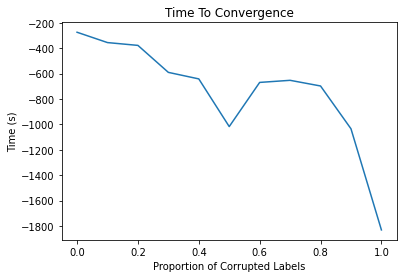

In [ ]:
transform_train = transforms.Compose([
    transforms.CenterCrop(28) ,                                 
    transforms.ToTensor(),
    myNormalize()
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/InceptionModel_Convergence"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("Inception",'inception','train', directory, 150)

In [ ]:
# def corrupt_labels(train_set, corrupt_prob):
#     # inputs, targets = zip(*train_loader)
#     labels = np.array(train_set.targets)
#     np.random.seed(12345)
#     mask = np.random.rand(len(labels)) <= corrupt_prob
#     rnd_labels = np.random.choice(10, mask.sum())
#     labels[mask] = rnd_labels
#     # we need to explicitly cast the labels from npy.int64 to
#     # builtin int type, otherwise pytorch will fail...
#     labels = [int(x) for x in labels]

#     train_set.targets = labels
#     return train_set 

In [ ]:
# prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# transform_train = transforms.Compose([
#     transforms.CenterCrop(28),
#     transforms.ToTensor(),
#     myNormalize()
#     ])
# BATCH_SIZE = 512

# for i in prob:
#   directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_Corruption_" + str(prob)

#   trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform_train)
#   trainset = corrupt_labels(train_set, i)
#   trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
#                                             shuffle=True, num_workers=2)

#   valset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                           download=True, transform=None)
#   valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
#                                             shuffle=True, num_workers=2)
#   main("Inception",'inception','train', directory, 150)